In [1]:
%matplotlib inline
#includes
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['figure.figsize'] = (20, 10)
#pytorch
import torch
import torchaudio
torch.cuda.is_available()

True

In [2]:
def Normalize(tensor):
    # Subtract the mean, and scale to the interval [-1,1]
    tensor_minusmean = tensor - tensor.mean()
    return tensor_minusmean/tensor_minusmean.abs().max()

In [3]:
#librosa for some audio processing
import librosa
import librosa.display
#soundfile for writing .wav files
import soundfile as sf


In [4]:
#filename = os.path.join(folder, files[ file_n ])
#waveform, sample_rate = torchaudio.load(filename)

In [5]:
import os
top_folder = 'birdcalls/'
filetype = 'mp3'
folders = os.listdir(top_folder)
os.getcwd()
len(folders), folders

FileNotFoundError: [Errno 2] No such file or directory: 'birdcalls/'

In [6]:
#list of species to loop over (ones to start with)

species = [
    ('American Robin', 281),
    ('American Crow', 20),
    ('American Goldfinch', 286),
    ('Bald Eagle', 68),
    ('Blue Jay', 182),
    ('Brown-headed Cowbird', 230),
    ('Carolina Chickadee', 53),
    ('Canada Goose', 238),
    ('Eastern Bluebird', 243)]
''',
    ('Indigo Bunting', 264),
    ('Mallard', 101),
    ('Purple Finch', 233),
    ('Red-winged Blackbird', 138), #file 72 is a good example
    ('Rose-breasted Grosbeak', 186), #file 10
    ('Tufted Titmouse', 78), #file 5 good example (file 0 bad sound at end file 4 bad at beginning)
    ('Scarlet Tanager', 29)
]'''

species_list = [spec for spec,n in species]
species_list = [spec for spec in folders if '?' not in spec]
len(species_list), species_list

NameError: name 'folders' is not defined

In [7]:
from scipy.signal import find_peaks

def FindPeaksInSample( wf_in, sample_rate, output=False ):
    waveform = Normalize( wf_in )
    waveform_np = waveform[0].t().numpy()
    wf_abs = np.abs( waveform_np )
    yabs_avg, yabs_max = np.average( wf_abs ), np.max( wf_abs )
    
    ymin, ymax = waveform.min(), waveform.max()

    fraction_of_max = 0.5625
    nsec_before = 0.5625
    nsec_after = nsec_before + 2*0.1625
    
    sr = sample_rate

    dist_before = sr*nsec_before #+/- n second #seperation of 0.5 seconds between peaks
    dist_after = sr*(nsec_after)
    
    #define peak finder parameters
    thresh = ymax.numpy()*fraction_of_max
    #peak_seperation = nsec_before*sample_rate
    peak_seperation = nsec_before*sample_rate if nsec_before>nsec_after else nsec_after*sample_rate
    peaks, _ = find_peaks(waveform_np, height=thresh, distance=peak_seperation)
    if output:
        print('yabs_avg', yabs_avg, 'yabs_max', yabs_max)
        print('nsec after = ', nsec_after)
        print( f'+/-{nsec_before} seconds = dist before {nsec_before} and after = {nsec_after}' )

        #create a plot, don't plot the peaks if you don't find any...
        f, ax = plt.subplots()# figsize=(14,10) )
    
        try:
            if output:
                print('peaks', peaks)
                x_max_peak = waveform_np[peaks[0]]
                #xbox = peaks[0] - dist/2

                height, width = 1.1*(ymax-ymin), dist_before+dist_after
                SF = 1.1

                ax.fill_between( (peaks[0]-dist_before, peaks[0]+dist_after), y1=(SF*ymax, SF*ymax),
                                y2=(SF*ymin, SF*ymin), color='black', alpha=0.25 )
                ax.plot(peaks, waveform_np[peaks], 'x', color='orange')
                ax.set_xlabel('samples', fontsize=14)
                ax.set_ylabel('amplitude', fontsize=14)
                #ax.set_title('Scarlet Tanager/321431.mp3', fontsize=18)

        except Exception as e: 
            print('exception', e)
            print('no peaks found!')

          
        ax.plot(waveform_np, color='blue')
        ax.plot(np.zeros_like(waveform_np)+thresh, '--', color='gray');
        plt.show()
    return peaks, nsec_before, nsec_after



yabs_avg 0.018652694 yabs_max 1.0
nsec after =  0.8875
+/-0.5625 seconds = dist before 0.5625 and after = 0.8875
peaks [ 59459 134446 200666 265863 363009 436005 595123]


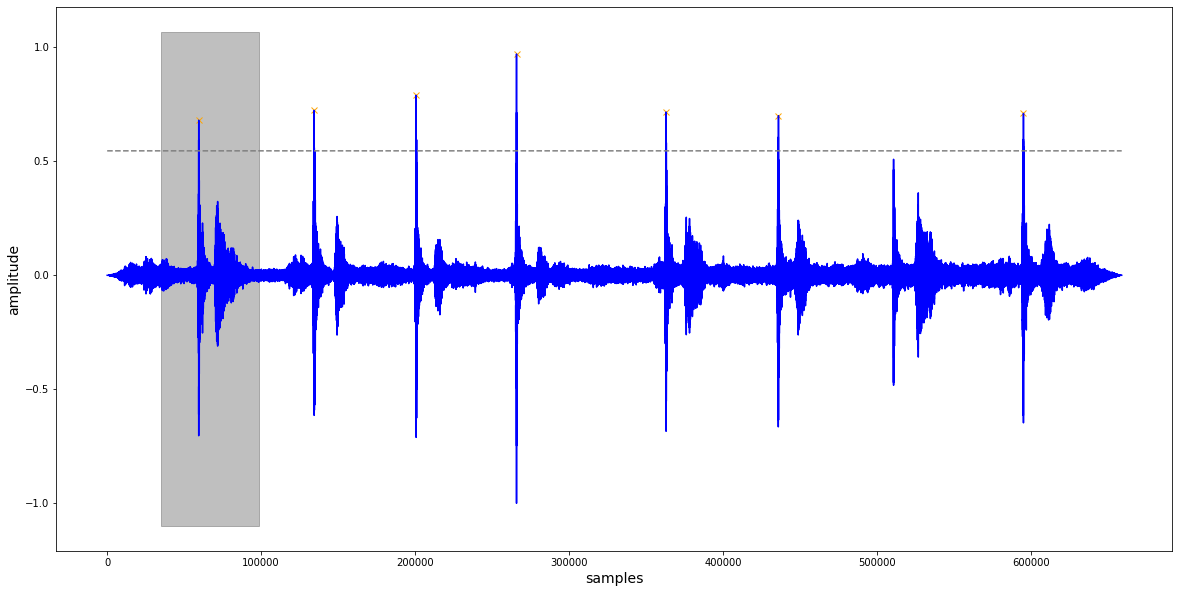

(array([ 59459, 134446, 200666, 265863, 363009, 436005, 595123]),
 0.5625,
 0.8875)

In [8]:
#to create plot for presentation
import torchaudio

filename = '/home/chris/Documents/Insight2020/examples/birdcalls/Scarlet Tanager/321431.mp3'
waveform, sample_rate = torchaudio.load(filename)
wf_np = waveform[0].t().numpy()
FindPeaksInSample( waveform, sample_rate, output=True )

In [9]:
#writing sub-soundfiles from the original, broken at the interseting peaks
#choose how long you want the new clip to be (2 seconds for example)
#this time must be translated into "samples" units

def CutClip( original_audio, peaks, sample_rate, sec_before, sec_after, species, filenumber, savefolder='cutclips/' ):
    '''cut the clip into a sub-clip at each of the peak positions found'''
    #peak = peaks[2]  #test line, put into loop of all peaks after
    sample_before = sample_rate*sec_before #num of samples after peak
    sample_after = sample_rate*sec_after #num of smaples before peak
    length = sec_before + sec_after  #sum of cut before and after, in seconds
    total = sample_rate * length  #total number of smaples to cut
    #length_in_samples = sample_rate * sec_to_cut
    ##print(f'to cut {length} seconds, the total will be {total} samples\n')
    ##print('begin looping through peaks:')
    for j,peak in enumerate(peaks):
        
        start = peak - sample_before
        end = peak + sample_after
        print( f'\nfor the peak at {peak}, cut from {start} to {end}' )
        if start<0:
            print('start<0...Can not create a clip before the start of the file!')
            ##print('potentially shift the start of the clip over the number of samples it is over the edge\
            ##...but just throw it out for now')
        elif end > original_audio.shape[1]:
            print('end > len(original_audio)...Can not create a clip that ends after the end of the file!')
        else:
            ##print('good index values to write clip!')
            #write a new .wav file, in the sub-dir for that species
            kind = '.wav' #'.mp3' #'.wav'
            newfilename = f'{savefolder}{spec_name}_{filenumber}_{j}{kind}'
            print(newfilename)
            y = np.asfortranarray( original_audio[0].numpy() ) #convert to numpy array so soundfile can handle it
            ##print( 'orig.shape', original_audio.shape, 'y.shape', y.shape )
            #sf.write('testfile.wav', y[int(peak - sample_before): int(peak + sample_after) ], samplerate=sample_rate)  #write the file 
            sf.write(newfilename, y[ int(peak - sample_before): int(peak + sample_after) ], samplerate=sample_rate)  #write the file      
            #break

#orig =  np.array([ np.arange( 1, 100001 ) , np.arange( 2, 100001 ) ])

In [10]:
os.getcwd()

'/home/chris/Documents/Insight2020/birdsounder-model'

In [11]:
def GetFolderNumberByName( spec_name = 'American Robin' ):
    '''get the folder number'''
    #spec_name = 'American Robin'
    found_num = [n for name, n in zip( folders, range(len(folders)) ) if name == spec_name]
    ##print('\n', spec_name == folders[found_num[0]], 'name found', folders[found_num[0]], 'folder number', found_num )
    return found_num[0]

def GetFilesForSpecies( spec_name ):
    nfold = GetFolderNumberByName( spec_name )
    folder =folders[nfold]
    path = ''.join( (top_folder, folder) )
    files = [ file for file in os.listdir(path) if filetype in file ]
    if spec_name == 'Scarlet Tanager':
        ##print(files)
        files.remove( '375269.mp3' )
        ##print(files, '\n')
    return path, files
    
def LoopOverFiles( path, files, spec_name, save_folder='cutclips/', cutclips=True ):
    '''for each file in the file list:
    load the waveform, call the peak finder function
    then for each peak, split the file into new files and store them in the '''
    for i,file in enumerate(files):
        filename = f'{path}/{file}'
        ##print(filename)
        try:
            waveform, sample_rate = torchaudio.load(filename)
            peaks, before, after = FindPeaksInSample( waveform, sample_rate )
            ##print('file', i, peaks, '\n')
            #function to cut clips into smaller samples
            if cutclips:
                CutClip( original_audio=waveform, peaks=peaks, sample_rate=sample_rate, sec_before=before,
                        sec_after=after, species=spec_name, filenumber=i, savefolder='cutclips/' )
        except Exception as e:
            print( 'exception', e )
        #break




In [12]:
#exmaple of finding peaks
path, files = GetFilesForSpecies( spec_name='American Robin' )
file = files[0]
filename = f'{path}/{file}'
print(filename)
waveform, sample_rate = torchaudio.load(filename)
peaks, before, after = FindPeaksInSample( waveform, sample_rate )
#FindPeaksInSample( wf_np, sample_rate, output=True )
FindPeaksInSample( waveform, sample_rate, output=True )

NameError: name 'folders' is not defined

In [ ]:
#loop for single species
spec_name = species_list[0] #'American Robin' 
print( 'species in', spec_name)

path, files = GetFilesForSpecies( spec_name=spec_name )
LoopOverFiles( path, files, spec_name)
#LoopThroughSpecies( species_list=species_list )


In [17]:
#repeat for robin
start, end = 0, 384
#for i in range( 0, len(species_list) ):
for spec_name in species_list[start:end+1]:
    #spec_name = species_list[i] #'American Robin' 
    print( 'species in:', spec_name)

    path, files = GetFilesForSpecies( spec_name=spec_name )
    LoopOverFiles( path, files, spec_name)
    print( f'species done: {spec_name}\n' ) 
    #LoopThroughSpecies( species_list=species_list )

species in: Chestnut-sided Warbler

for the peak at 270443, cut from 245636.75 to 309581.75
cutclips/Chestnut-sided Warbler_1_0.wav

for the peak at 315725, cut from 290918.75 to 354863.75
cutclips/Chestnut-sided Warbler_1_1.wav

for the peak at 576392, cut from 551585.75 to 615530.75
cutclips/Chestnut-sided Warbler_1_2.wav

for the peak at 620738, cut from 595931.75 to 659876.75
cutclips/Chestnut-sided Warbler_1_3.wav

for the peak at 853570, cut from 828763.75 to 892708.75
cutclips/Chestnut-sided Warbler_1_4.wav

for the peak at 1040736, cut from 1015929.75 to 1079874.75
cutclips/Chestnut-sided Warbler_1_5.wav

for the peak at 1091500, cut from 1066693.75 to 1130638.75
cutclips/Chestnut-sided Warbler_1_6.wav

for the peak at 1487655, cut from 1462848.75 to 1526793.75
cutclips/Chestnut-sided Warbler_1_7.wav

for the peak at 1751791, cut from 1726984.75 to 1790929.75
cutclips/Chestnut-sided Warbler_1_8.wav

for the peak at 2205216, cut from 2180409.75 to 2244354.75
cutclips/Chestnut-si


for the peak at 745010, cut from 720203.75 to 784148.75
cutclips/Chestnut-sided Warbler_18_0.wav

for the peak at 827024, cut from 802217.75 to 866162.75
cutclips/Chestnut-sided Warbler_18_1.wav

for the peak at 1074836, cut from 1050029.75 to 1113974.75
end > len(original_audio)...Can not create a clip that ends after the end of the file!

for the peak at 73994, cut from 46994.0 to 116594.0
cutclips/Chestnut-sided Warbler_19_0.wav

for the peak at 520788, cut from 493788.0 to 563388.0
cutclips/Chestnut-sided Warbler_19_1.wav

for the peak at 805674, cut from 778674.0 to 848274.0
cutclips/Chestnut-sided Warbler_19_2.wav

for the peak at 1134973, cut from 1107973.0 to 1177573.0
cutclips/Chestnut-sided Warbler_19_3.wav

for the peak at 33482, cut from 6482.0 to 76082.0
cutclips/Chestnut-sided Warbler_20_0.wav

for the peak at 193928, cut from 166928.0 to 236528.0
cutclips/Chestnut-sided Warbler_20_1.wav

for the peak at 236687, cut from 209687.0 to 279287.0
cutclips/Chestnut-sided Warbl


for the peak at 90081, cut from 65274.75 to 129219.75
cutclips/Chestnut-sided Warbler_32_0.wav

for the peak at 256375, cut from 231568.75 to 295513.75
cutclips/Chestnut-sided Warbler_32_1.wav

for the peak at 510808, cut from 486001.75 to 549946.75
cutclips/Chestnut-sided Warbler_32_2.wav

for the peak at 112643, cut from 85643.0 to 155243.0
cutclips/Chestnut-sided Warbler_33_0.wav

for the peak at 550389, cut from 523389.0 to 592989.0
cutclips/Chestnut-sided Warbler_33_1.wav

for the peak at 1006805, cut from 979805.0 to 1049405.0
cutclips/Chestnut-sided Warbler_33_2.wav

for the peak at 1444429, cut from 1417429.0 to 1487029.0
cutclips/Chestnut-sided Warbler_33_3.wav

for the peak at 1867926, cut from 1840926.0 to 1910526.0
cutclips/Chestnut-sided Warbler_33_4.wav

for the peak at 70859, cut from 46052.75 to 109997.75
cutclips/Chestnut-sided Warbler_34_0.wav

for the peak at 320999, cut from 296192.75 to 360137.75
cutclips/Chestnut-sided Warbler_34_1.wav

for the peak at 557378, cu


for the peak at 22665, cut from -2141.25 to 61803.75
start<0...Can not create a clip before the start of the file!

for the peak at 117913, cut from 93106.75 to 157051.75
cutclips/Chestnut-sided Warbler_49_1.wav

for the peak at 208053, cut from 183246.75 to 247191.75
cutclips/Chestnut-sided Warbler_49_2.wav

for the peak at 278061, cut from 253254.75 to 317199.75
cutclips/Chestnut-sided Warbler_49_3.wav

for the peak at 534822, cut from 510015.75 to 573960.75
cutclips/Chestnut-sided Warbler_49_4.wav

for the peak at 728520, cut from 703713.75 to 767658.75
cutclips/Chestnut-sided Warbler_49_5.wav

for the peak at 913953, cut from 889146.75 to 953091.75
cutclips/Chestnut-sided Warbler_49_6.wav

for the peak at 1208941, cut from 1184134.75 to 1248079.75
cutclips/Chestnut-sided Warbler_49_7.wav

for the peak at 1317224, cut from 1292417.75 to 1356362.75
cutclips/Chestnut-sided Warbler_49_8.wav

for the peak at 1865641, cut from 1840834.75 to 1904779.75
cutclips/Chestnut-sided Warbler_49_


for the peak at 55777, cut from 30970.75 to 94915.75
cutclips/Chestnut-sided Warbler_69_0.wav

for the peak at 95911, cut from 71104.75 to 135049.75
cutclips/Chestnut-sided Warbler_69_1.wav

for the peak at 409248, cut from 384441.75 to 448386.75
cutclips/Chestnut-sided Warbler_69_2.wav

for the peak at 669665, cut from 644858.75 to 708803.75
end > len(original_audio)...Can not create a clip that ends after the end of the file!

for the peak at 116733, cut from 91926.75 to 155871.75
cutclips/Chestnut-sided Warbler_70_0.wav

for the peak at 558781, cut from 531781.0 to 601381.0
cutclips/Chestnut-sided Warbler_71_0.wav

for the peak at 888962, cut from 861962.0 to 931562.0
cutclips/Chestnut-sided Warbler_71_1.wav

for the peak at 1332831, cut from 1305831.0 to 1375431.0
cutclips/Chestnut-sided Warbler_71_2.wav

for the peak at 98768, cut from 71768.0 to 141368.0
cutclips/Chestnut-sided Warbler_72_0.wav

for the peak at 317013, cut from 290013.0 to 359613.0
cutclips/Chestnut-sided Warble


for the peak at 8198, cut from -16608.25 to 47336.75
start<0...Can not create a clip before the start of the file!

for the peak at 194232, cut from 169425.75 to 233370.75
cutclips/Barn Swallow_7_1.wav

for the peak at 671597, cut from 646790.75 to 710735.75
cutclips/Barn Swallow_7_2.wav

for the peak at 62521, cut from 35521.0 to 105121.0
cutclips/Barn Swallow_8_0.wav

for the peak at 362059, cut from 335059.0 to 404659.0
cutclips/Barn Swallow_8_1.wav

for the peak at 409276, cut from 382276.0 to 451876.0
cutclips/Barn Swallow_8_2.wav

for the peak at 261094, cut from 234094.0 to 303694.0
cutclips/Barn Swallow_9_0.wav

for the peak at 836624, cut from 809624.0 to 879224.0
cutclips/Barn Swallow_9_1.wav

for the peak at 895631, cut from 868631.0 to 938231.0
cutclips/Barn Swallow_9_2.wav

for the peak at 939499, cut from 912499.0 to 982099.0
cutclips/Barn Swallow_9_3.wav

for the peak at 993320, cut from 966320.0 to 1035920.0
cutclips/Barn Swallow_9_4.wav

for the peak at 121849, cut fr


for the peak at 691932, cut from 664932.0 to 734532.0
cutclips/Barn Swallow_26_0.wav

for the peak at 2074913, cut from 2047913.0 to 2117513.0
cutclips/Barn Swallow_26_1.wav

for the peak at 2484119, cut from 2457119.0 to 2526719.0
cutclips/Barn Swallow_26_2.wav

for the peak at 2570091, cut from 2543091.0 to 2612691.0
cutclips/Barn Swallow_26_3.wav

for the peak at 86080, cut from 59080.0 to 128680.0
cutclips/Barn Swallow_27_0.wav

for the peak at 323685, cut from 296685.0 to 366285.0
cutclips/Barn Swallow_27_1.wav

for the peak at 374933, cut from 347933.0 to 417533.0
cutclips/Barn Swallow_27_2.wav

for the peak at 426144, cut from 399144.0 to 468744.0
cutclips/Barn Swallow_27_3.wav

for the peak at 485849, cut from 458849.0 to 528449.0
cutclips/Barn Swallow_27_4.wav

for the peak at 536606, cut from 509606.0 to 579206.0
cutclips/Barn Swallow_27_5.wav

for the peak at 589838, cut from 562838.0 to 632438.0
cutclips/Barn Swallow_27_6.wav

for the peak at 645040, cut from 618040.0 to 6


for the peak at 228302, cut from 203495.75 to 267440.75
cutclips/Boat-tailed Grackle_7_0.wav

for the peak at 357052, cut from 332245.75 to 396190.75
cutclips/Boat-tailed Grackle_7_1.wav

for the peak at 594597, cut from 569790.75 to 633735.75
cutclips/Boat-tailed Grackle_7_2.wav

for the peak at 635874, cut from 611067.75 to 675012.75
cutclips/Boat-tailed Grackle_7_3.wav

for the peak at 703688, cut from 678881.75 to 742826.75
cutclips/Boat-tailed Grackle_7_4.wav

for the peak at 1471304, cut from 1446497.75 to 1510442.75
cutclips/Boat-tailed Grackle_7_5.wav

for the peak at 1543959, cut from 1519152.75 to 1583097.75
cutclips/Boat-tailed Grackle_7_6.wav

for the peak at 106236, cut from 79236.0 to 148836.0
cutclips/Boat-tailed Grackle_8_0.wav

for the peak at 601587, cut from 574587.0 to 644187.0
cutclips/Boat-tailed Grackle_8_1.wav

for the peak at 1014252, cut from 987252.0 to 1056852.0
cutclips/Boat-tailed Grackle_8_2.wav

for the peak at 1094796, cut from 1067796.0 to 1137396.0
c


for the peak at 67723, cut from 40723.0 to 110323.0
cutclips/Boat-tailed Grackle_24_0.wav

for the peak at 163720, cut from 136720.0 to 206320.0
cutclips/Boat-tailed Grackle_24_1.wav

for the peak at 220024, cut from 193024.0 to 262624.0
cutclips/Boat-tailed Grackle_24_2.wav

for the peak at 268948, cut from 241948.0 to 311548.0
cutclips/Boat-tailed Grackle_24_3.wav

for the peak at 335812, cut from 308812.0 to 378412.0
cutclips/Boat-tailed Grackle_24_4.wav

for the peak at 573070, cut from 546070.0 to 615670.0
cutclips/Boat-tailed Grackle_24_5.wav

for the peak at 627858, cut from 600858.0 to 670458.0
cutclips/Boat-tailed Grackle_24_6.wav

for the peak at 673535, cut from 646535.0 to 716135.0
cutclips/Boat-tailed Grackle_24_7.wav

for the peak at 33482, cut from 8675.75 to 72620.75
cutclips/Boat-tailed Grackle_25_0.wav

for the peak at 92429, cut from 67622.75 to 131567.75
cutclips/Boat-tailed Grackle_25_1.wav

for the peak at 148801, cut from 123994.75 to 187939.75
cutclips/Boat-tai


for the peak at 87104, cut from 60104.0 to 129704.0
cutclips/Boat-tailed Grackle_36_0.wav

for the peak at 323916, cut from 296916.0 to 366516.0
cutclips/Boat-tailed Grackle_36_1.wav

for the peak at 376623, cut from 349623.0 to 419223.0
cutclips/Boat-tailed Grackle_36_2.wav

for the peak at 427083, cut from 400083.0 to 469683.0
cutclips/Boat-tailed Grackle_36_3.wav

for the peak at 480898, cut from 453898.0 to 523498.0
cutclips/Boat-tailed Grackle_36_4.wav

for the peak at 855573, cut from 828573.0 to 898173.0
cutclips/Boat-tailed Grackle_36_5.wav

for the peak at 991677, cut from 964677.0 to 1034277.0
cutclips/Boat-tailed Grackle_36_6.wav

for the peak at 1048910, cut from 1021910.0 to 1091510.0
cutclips/Boat-tailed Grackle_36_7.wav

for the peak at 1390162, cut from 1363162.0 to 1432762.0
cutclips/Boat-tailed Grackle_36_8.wav

for the peak at 1453574, cut from 1426574.0 to 1496174.0
cutclips/Boat-tailed Grackle_36_9.wav

for the peak at 1592449, cut from 1565449.0 to 1635049.0
cutc


for the peak at 128572, cut from 101572.0 to 171172.0
cutclips/Boat-tailed Grackle_52_0.wav

for the peak at 172364, cut from 145364.0 to 214964.0
cutclips/Boat-tailed Grackle_52_1.wav

for the peak at 217259, cut from 190259.0 to 259859.0
cutclips/Boat-tailed Grackle_52_2.wav

for the peak at 267985, cut from 240985.0 to 310585.0
cutclips/Boat-tailed Grackle_52_3.wav

for the peak at 312498, cut from 285498.0 to 355098.0
cutclips/Boat-tailed Grackle_52_4.wav

for the peak at 373596, cut from 346596.0 to 416196.0
cutclips/Boat-tailed Grackle_52_5.wav

for the peak at 449400, cut from 422400.0 to 492000.0
cutclips/Boat-tailed Grackle_52_6.wav

for the peak at 99911, cut from 72911.0 to 142511.0
cutclips/Boat-tailed Grackle_53_0.wav

for the peak at 145814, cut from 118814.0 to 188414.0
cutclips/Boat-tailed Grackle_53_1.wav

for the peak at 297052, cut from 270052.0 to 339652.0
cutclips/Boat-tailed Grackle_53_2.wav

for the peak at 398074, cut from 371074.0 to 440674.0
cutclips/Boat-tai


for the peak at 36248, cut from 11441.75 to 75386.75
cutclips/Bachman's Sparrow_6_0.wav

for the peak at 478357, cut from 453550.75 to 517495.75
cutclips/Bachman's Sparrow_6_1.wav

for the peak at 560843, cut from 536036.75 to 599981.75
cutclips/Bachman's Sparrow_6_2.wav

for the peak at 55639, cut from 30832.75 to 94777.75
cutclips/Bachman's Sparrow_7_0.wav

for the peak at 129553, cut from 104746.75 to 168691.75
cutclips/Bachman's Sparrow_7_1.wav

for the peak at 207481, cut from 182674.75 to 246619.75
cutclips/Bachman's Sparrow_7_2.wav

for the peak at 316311, cut from 291504.75 to 355449.75
cutclips/Bachman's Sparrow_7_3.wav

for the peak at 388931, cut from 364124.75 to 428069.75
cutclips/Bachman's Sparrow_7_4.wav

for the peak at 460961, cut from 436154.75 to 500099.75
cutclips/Bachman's Sparrow_7_5.wav

for the peak at 533230, cut from 508423.75 to 572368.75
cutclips/Bachman's Sparrow_7_6.wav

for the peak at 604363, cut from 579556.75 to 643501.75
cutclips/Bachman's Sparrow_7_


for the peak at 450865, cut from 426058.75 to 490003.75
cutclips/Bachman's Sparrow_20_0.wav

for the peak at 492038, cut from 467231.75 to 531176.75
cutclips/Bachman's Sparrow_20_1.wav

for the peak at 738457, cut from 713650.75 to 777595.75
end > len(original_audio)...Can not create a clip that ends after the end of the file!

for the peak at 1239025, cut from 1214218.75 to 1278163.75
cutclips/Bachman's Sparrow_21_0.wav

for the peak at 111610, cut from 84610.0 to 154210.0
cutclips/Bachman's Sparrow_22_0.wav

for the peak at 633251, cut from 606251.0 to 675851.0
cutclips/Bachman's Sparrow_22_1.wav

for the peak at 1101658, cut from 1074658.0 to 1144258.0
cutclips/Bachman's Sparrow_22_2.wav

for the peak at 1145799, cut from 1118799.0 to 1188399.0
cutclips/Bachman's Sparrow_22_3.wav

for the peak at 1645640, cut from 1618640.0 to 1688240.0
cutclips/Bachman's Sparrow_22_4.wav

for the peak at 2211959, cut from 2184959.0 to 2254559.0
cutclips/Bachman's Sparrow_22_5.wav

for the peak at 


for the peak at 103070, cut from 78263.75 to 142208.75
cutclips/Boreal Chickadee_13_0.wav

for the peak at 149281, cut from 124474.75 to 188419.75
cutclips/Boreal Chickadee_13_1.wav

for the peak at 188789, cut from 163982.75 to 227927.75
cutclips/Boreal Chickadee_13_2.wav

for the peak at 266814, cut from 242007.75 to 305952.75
cutclips/Boreal Chickadee_13_3.wav

for the peak at 375354, cut from 350547.75 to 414492.75
cutclips/Boreal Chickadee_13_4.wav

for the peak at 492451, cut from 467644.75 to 531589.75
cutclips/Boreal Chickadee_13_5.wav

for the peak at 547475, cut from 522668.75 to 586613.75
cutclips/Boreal Chickadee_13_6.wav

for the peak at 613526, cut from 588719.75 to 652664.75
cutclips/Boreal Chickadee_13_7.wav

for the peak at 670502, cut from 645695.75 to 709640.75
cutclips/Boreal Chickadee_13_8.wav

for the peak at 798513, cut from 773706.75 to 837651.75
cutclips/Boreal Chickadee_13_9.wav

for the peak at 900577, cut from 875770.75 to 939715.75
cutclips/Boreal Chickade


for the peak at 195069, cut from 170262.75 to 234207.75
cutclips/Rusty Blackbird_0_0.wav

for the peak at 267200, cut from 242393.75 to 306338.75
cutclips/Rusty Blackbird_0_1.wav

for the peak at 309831, cut from 285024.75 to 348969.75
cutclips/Rusty Blackbird_0_2.wav

for the peak at 364316, cut from 339509.75 to 403454.75
cutclips/Rusty Blackbird_0_3.wav

for the peak at 466032, cut from 441225.75 to 505170.75
cutclips/Rusty Blackbird_0_4.wav

for the peak at 1021485, cut from 996678.75 to 1060623.75
cutclips/Rusty Blackbird_0_5.wav

for the peak at 1184637, cut from 1159830.75 to 1223775.75
cutclips/Rusty Blackbird_0_6.wav

for the peak at 1445557, cut from 1420750.75 to 1484695.75
cutclips/Rusty Blackbird_0_7.wav

for the peak at 1548889, cut from 1524082.75 to 1588027.75
cutclips/Rusty Blackbird_0_8.wav

for the peak at 1608331, cut from 1583524.75 to 1647469.75
cutclips/Rusty Blackbird_0_9.wav

for the peak at 1652642, cut from 1627835.75 to 1691780.75
cutclips/Rusty Blackbird_0


for the peak at 294937, cut from 267937.0 to 337537.0
cutclips/Rusty Blackbird_15_1.wav

for the peak at 369216, cut from 342216.0 to 411816.0
cutclips/Rusty Blackbird_15_2.wav

for the peak at 459632, cut from 432632.0 to 502232.0
cutclips/Rusty Blackbird_15_3.wav

for the peak at 48634, cut from 23827.75 to 87772.75
cutclips/Rusty Blackbird_16_0.wav

for the peak at 101614, cut from 76807.75 to 140752.75
cutclips/Rusty Blackbird_16_1.wav

for the peak at 143614, cut from 118807.75 to 182752.75
cutclips/Rusty Blackbird_16_2.wav

for the peak at 27182, cut from 182.0 to 69782.0
cutclips/Rusty Blackbird_17_0.wav

for the peak at 85600, cut from 58600.0 to 128200.0
cutclips/Rusty Blackbird_17_1.wav

for the peak at 132139, cut from 105139.0 to 174739.0
cutclips/Rusty Blackbird_17_2.wav

for the peak at 183428, cut from 156428.0 to 226028.0
cutclips/Rusty Blackbird_17_3.wav

for the peak at 1878453, cut from 1853646.75 to 1917591.75
cutclips/Rusty Blackbird_18_0.wav

for the peak at 1965


for the peak at 119345, cut from 92345.0 to 161945.0
cutclips/Grey-headed Swamphen_2_0.wav

for the peak at 174840, cut from 147840.0 to 217440.0
cutclips/Grey-headed Swamphen_2_1.wav

for the peak at 231873, cut from 204873.0 to 274473.0
cutclips/Grey-headed Swamphen_2_2.wav

for the peak at 74480, cut from 47480.0 to 117080.0
cutclips/Grey-headed Swamphen_3_0.wav

for the peak at 128454, cut from 101454.0 to 171054.0
cutclips/Grey-headed Swamphen_3_1.wav

for the peak at 691307, cut from 664307.0 to 733907.0
cutclips/Grey-headed Swamphen_4_0.wav

for the peak at 549881, cut from 522881.0 to 592481.0
cutclips/Grey-headed Swamphen_5_0.wav

for the peak at 899003, cut from 872003.0 to 941603.0
cutclips/Grey-headed Swamphen_5_1.wav

for the peak at 967409, cut from 940409.0 to 1010009.0
cutclips/Grey-headed Swamphen_5_2.wav

for the peak at 134940, cut from 107940.0 to 177540.0
cutclips/Grey-headed Swamphen_6_0.wav

for the peak at 204243, cut from 177243.0 to 246843.0
cutclips/Grey-hea


for the peak at 126339, cut from 101532.75 to 165477.75
cutclips/Eastern Kingbird_15_0.wav

for the peak at 212721, cut from 187914.75 to 251859.75
cutclips/Eastern Kingbird_15_1.wav

for the peak at 334511, cut from 309704.75 to 373649.75
cutclips/Eastern Kingbird_15_2.wav

for the peak at 420572, cut from 395765.75 to 459710.75
cutclips/Eastern Kingbird_15_3.wav

for the peak at 843851, cut from 819044.75 to 882989.75
cutclips/Eastern Kingbird_15_4.wav

for the peak at 19851, cut from -4955.25 to 58989.75
start<0...Can not create a clip before the start of the file!

for the peak at 111617, cut from 86810.75 to 150755.75
cutclips/Eastern Kingbird_16_1.wav

for the peak at 184896, cut from 160089.75 to 224034.75
cutclips/Eastern Kingbird_16_2.wav

for the peak at 274414, cut from 247414.0 to 317014.0
cutclips/Eastern Kingbird_17_0.wav

for the peak at 351177, cut from 324177.0 to 393777.0
cutclips/Eastern Kingbird_17_1.wav

for the peak at 483093, cut from 456093.0 to 525693.0
cutcli


for the peak at 259723, cut from 232723.0 to 302323.0
cutclips/Buff-bellied Hummingbird_2_0.wav

for the peak at 303891, cut from 276891.0 to 346491.0
cutclips/Buff-bellied Hummingbird_2_1.wav

for the peak at 235677, cut from 208677.0 to 278277.0
cutclips/Buff-bellied Hummingbird_3_0.wav

for the peak at 328143, cut from 301143.0 to 370743.0
cutclips/Buff-bellied Hummingbird_3_1.wav

for the peak at 372823, cut from 345823.0 to 415423.0
cutclips/Buff-bellied Hummingbird_3_2.wav

for the peak at 517072, cut from 490072.0 to 559672.0
cutclips/Buff-bellied Hummingbird_3_3.wav

for the peak at 660605, cut from 633605.0 to 703205.0
cutclips/Buff-bellied Hummingbird_3_4.wav

for the peak at 734767, cut from 707767.0 to 777367.0
cutclips/Buff-bellied Hummingbird_3_5.wav

for the peak at 796463, cut from 769463.0 to 839063.0
cutclips/Buff-bellied Hummingbird_3_6.wav

for the peak at 943495, cut from 916495.0 to 986095.0
cutclips/Buff-bellied Hummingbird_3_7.wav

for the peak at 1036372, cut 


for the peak at 134805, cut from 109998.75 to 173943.75
cutclips/Magnolia Warbler_8_0.wav

for the peak at 601625, cut from 576818.75 to 640763.75
cutclips/Magnolia Warbler_8_1.wav

for the peak at 641082, cut from 616275.75 to 680220.75
cutclips/Magnolia Warbler_8_2.wav

for the peak at 1189420, cut from 1164613.75 to 1228558.75
cutclips/Magnolia Warbler_8_3.wav

for the peak at 1515333, cut from 1490526.75 to 1554471.75
cutclips/Magnolia Warbler_8_4.wav

for the peak at 1988886, cut from 1964079.75 to 2028024.75
cutclips/Magnolia Warbler_8_5.wav

for the peak at 2505479, cut from 2480672.75 to 2544617.75
cutclips/Magnolia Warbler_8_6.wav

for the peak at 107345, cut from 82538.75 to 146483.75
cutclips/Magnolia Warbler_10_0.wav

for the peak at 529084, cut from 504277.75 to 568222.75
cutclips/Magnolia Warbler_10_1.wav

for the peak at 1112127, cut from 1087320.75 to 1151265.75
cutclips/Magnolia Warbler_10_2.wav

for the peak at 108864, cut from 81864.0 to 151464.0
cutclips/Magnolia W


for the peak at 288015, cut from 263208.75 to 327153.75
cutclips/Magnolia Warbler_26_0.wav

for the peak at 632549, cut from 607742.75 to 671687.75
cutclips/Magnolia Warbler_26_1.wav

for the peak at 1030325, cut from 1005518.75 to 1069463.75
cutclips/Magnolia Warbler_26_2.wav

for the peak at 1300192, cut from 1275385.75 to 1339330.75
cutclips/Magnolia Warbler_26_3.wav

for the peak at 1580292, cut from 1555485.75 to 1619430.75
cutclips/Magnolia Warbler_26_4.wav

for the peak at 1896184, cut from 1871377.75 to 1935322.75
cutclips/Magnolia Warbler_26_5.wav

for the peak at 2296049, cut from 2271242.75 to 2335187.75
cutclips/Magnolia Warbler_26_6.wav

for the peak at 78023, cut from 51023.0 to 120623.0
cutclips/Magnolia Warbler_27_0.wav

for the peak at 158047, cut from 131047.0 to 200647.0
cutclips/Magnolia Warbler_27_1.wav

for the peak at 364830, cut from 337830.0 to 407430.0
cutclips/Magnolia Warbler_27_2.wav

for the peak at 571671, cut from 546864.75 to 610809.75
cutclips/Magnoli


for the peak at 56019, cut from 31212.75 to 95157.75
cutclips/Magnolia Warbler_44_0.wav

for the peak at 201105, cut from 176298.75 to 240243.75
cutclips/Magnolia Warbler_44_1.wav

for the peak at 379964, cut from 355157.75 to 419102.75
cutclips/Magnolia Warbler_44_2.wav

for the peak at 575208, cut from 550401.75 to 614346.75
cutclips/Magnolia Warbler_44_3.wav

for the peak at 651387, cut from 626580.75 to 690525.75
cutclips/Magnolia Warbler_44_4.wav

for the peak at 826417, cut from 801610.75 to 865555.75
cutclips/Magnolia Warbler_44_5.wav

for the peak at 996212, cut from 971405.75 to 1035350.75
cutclips/Magnolia Warbler_44_6.wav

for the peak at 1164385, cut from 1139578.75 to 1203523.75
cutclips/Magnolia Warbler_44_7.wav

for the peak at 1342947, cut from 1318140.75 to 1382085.75
end > len(original_audio)...Can not create a clip that ends after the end of the file!

for the peak at 478745, cut from 453938.75 to 517883.75
cutclips/Magnolia Warbler_45_0.wav

for the peak at 63059, 


for the peak at 33180, cut from 8373.75 to 72318.75
cutclips/Grey Kingbird_11_0.wav

for the peak at 152959, cut from 128152.75 to 192097.75
cutclips/Grey Kingbird_11_1.wav

for the peak at 223767, cut from 198960.75 to 262905.75
cutclips/Grey Kingbird_11_2.wav

for the peak at 306665, cut from 281858.75 to 345803.75
cutclips/Grey Kingbird_11_3.wav

for the peak at 359551, cut from 334744.75 to 398689.75
cutclips/Grey Kingbird_11_4.wav

for the peak at 385508, cut from 360701.75 to 424646.75
cutclips/Grey Kingbird_12_0.wav

for the peak at 806217, cut from 781410.75 to 845355.75
end > len(original_audio)...Can not create a clip that ends after the end of the file!

for the peak at 52808, cut from 28001.75 to 91946.75
cutclips/Grey Kingbird_13_0.wav

for the peak at 480810, cut from 456003.75 to 519948.75
cutclips/Grey Kingbird_13_1.wav

for the peak at 716547, cut from 691740.75 to 755685.75
cutclips/Grey Kingbird_13_2.wav

for the peak at 909861, cut from 885054.75 to 948999.75
cutcl


for the peak at 93397, cut from 68590.75 to 132535.75
cutclips/Ring-billed Gull_17_0.wav

for the peak at 174793, cut from 149986.75 to 213931.75
cutclips/Ring-billed Gull_17_1.wav

for the peak at 231379, cut from 206572.75 to 270517.75
cutclips/Ring-billed Gull_17_2.wav

for the peak at 298018, cut from 273211.75 to 337156.75
cutclips/Ring-billed Gull_17_3.wav

for the peak at 408862, cut from 384055.75 to 448000.75
cutclips/Ring-billed Gull_17_4.wav

for the peak at 467314, cut from 442507.75 to 506452.75
cutclips/Ring-billed Gull_17_5.wav

for the peak at 628665, cut from 603858.75 to 667803.75
cutclips/Ring-billed Gull_17_6.wav

for the peak at 107639, cut from 80639.0 to 150239.0
cutclips/Ring-billed Gull_18_0.wav

for the peak at 160055, cut from 133055.0 to 202655.0
cutclips/Ring-billed Gull_18_1.wav

for the peak at 207147, cut from 180147.0 to 249747.0
cutclips/Ring-billed Gull_18_2.wav

for the peak at 258516, cut from 231516.0 to 301116.0
cutclips/Ring-billed Gull_18_3.wav


for the peak at 1422122, cut from 1395122.0 to 1464722.0
cutclips/American Barn Owl_0_6.wav

for the peak at 1511382, cut from 1484382.0 to 1553982.0
cutclips/American Barn Owl_0_7.wav

for the peak at 1600410, cut from 1573410.0 to 1643010.0
cutclips/American Barn Owl_0_8.wav

for the peak at 27646, cut from 9646.0 to 56046.0
end > len(original_audio)...Can not create a clip that ends after the end of the file!

for the peak at 67554, cut from 42747.75 to 106692.75
cutclips/American Barn Owl_2_0.wav

for the peak at 1853711, cut from 1828904.75 to 1892849.75
cutclips/American Barn Owl_2_1.wav

for the peak at 341897, cut from 314897.0 to 384497.0
cutclips/American Barn Owl_3_0.wav

for the peak at 443083, cut from 416083.0 to 485683.0
cutclips/American Barn Owl_3_1.wav

for the peak at 541445, cut from 514445.0 to 584045.0
cutclips/American Barn Owl_3_2.wav

for the peak at 677466, cut from 650466.0 to 720066.0
cutclips/American Barn Owl_3_3.wav

for the peak at 976351, cut from 9493


for the peak at 8962, cut from -18038.0 to 51562.0
start<0...Can not create a clip before the start of the file!

for the peak at 1386786, cut from 1359786.0 to 1429386.0
cutclips/Spotted Sandpiper_16_1.wav

for the peak at 1581287, cut from 1554287.0 to 1623887.0
cutclips/Spotted Sandpiper_16_2.wav

for the peak at 1960716, cut from 1933716.0 to 2003316.0
cutclips/Spotted Sandpiper_16_3.wav

for the peak at 2115012, cut from 2088012.0 to 2157612.0
cutclips/Spotted Sandpiper_16_4.wav

for the peak at 844352, cut from 817352.0 to 886952.0
cutclips/Spotted Sandpiper_17_0.wav

for the peak at 966542, cut from 939542.0 to 1009142.0
cutclips/Spotted Sandpiper_17_1.wav

for the peak at 1077832, cut from 1050832.0 to 1120432.0
cutclips/Spotted Sandpiper_17_2.wav

for the peak at 1240427, cut from 1213427.0 to 1283027.0
cutclips/Spotted Sandpiper_17_3.wav

for the peak at 19600, cut from -5206.25 to 58738.75
start<0...Can not create a clip before the start of the file!

for the peak at 58841,


for the peak at 157513, cut from 132706.75 to 196651.75
cutclips/Connecticut Warbler_10_0.wav

for the peak at 555514, cut from 530707.75 to 594652.75
cutclips/Connecticut Warbler_10_1.wav

for the peak at 968949, cut from 944142.75 to 1008087.75
cutclips/Connecticut Warbler_10_2.wav

for the peak at 1404754, cut from 1379947.75 to 1443892.75
cutclips/Connecticut Warbler_10_3.wav

for the peak at 1778219, cut from 1753412.75 to 1817357.75
cutclips/Connecticut Warbler_10_4.wav

for the peak at 69360, cut from 42360.0 to 111960.0
cutclips/Connecticut Warbler_11_0.wav

for the peak at 127471, cut from 100471.0 to 170071.0
cutclips/Connecticut Warbler_11_1.wav

for the peak at 330833, cut from 303833.0 to 373433.0
cutclips/Connecticut Warbler_11_2.wav

for the peak at 386438, cut from 359438.0 to 429038.0
cutclips/Connecticut Warbler_11_3.wav

for the peak at 30560, cut from 5753.75 to 69698.75
cutclips/Connecticut Warbler_12_0.wav

for the peak at 137564, cut from 112757.75 to 176702.75



for the peak at 107143, cut from 80143.0 to 149743.0
cutclips/Egyptian Goose_0_0.wav

for the peak at 164955, cut from 137955.0 to 207555.0
cutclips/Egyptian Goose_0_1.wav

for the peak at 240965, cut from 213965.0 to 283565.0
cutclips/Egyptian Goose_0_2.wav

for the peak at 289965, cut from 262965.0 to 332565.0
cutclips/Egyptian Goose_0_3.wav

for the peak at 337632, cut from 310632.0 to 380232.0
cutclips/Egyptian Goose_0_4.wav

for the peak at 384738, cut from 357738.0 to 427338.0
cutclips/Egyptian Goose_0_5.wav

for the peak at 432934, cut from 405934.0 to 475534.0
cutclips/Egyptian Goose_0_6.wav

for the peak at 513617, cut from 486617.0 to 556217.0
cutclips/Egyptian Goose_0_7.wav

for the peak at 589205, cut from 562205.0 to 631805.0
cutclips/Egyptian Goose_0_8.wav

for the peak at 646905, cut from 619905.0 to 689505.0
cutclips/Egyptian Goose_0_9.wav

for the peak at 755123, cut from 728123.0 to 797723.0
cutclips/Egyptian Goose_0_10.wav

for the peak at 800830, cut from 773830.0 


for the peak at 250300, cut from 223300.0 to 292900.0
cutclips/Killdeer_14_0.wav

for the peak at 315196, cut from 288196.0 to 357796.0
cutclips/Killdeer_14_1.wav

for the peak at 360286, cut from 333286.0 to 402886.0
cutclips/Killdeer_14_2.wav

for the peak at 495875, cut from 468875.0 to 538475.0
cutclips/Killdeer_14_3.wav

for the peak at 175165, cut from 148165.0 to 217765.0
cutclips/Killdeer_15_0.wav

for the peak at 239444, cut from 212444.0 to 282044.0
cutclips/Killdeer_15_1.wav

for the peak at 417664, cut from 390664.0 to 460264.0
cutclips/Killdeer_15_2.wav

for the peak at 585960, cut from 558960.0 to 628560.0
cutclips/Killdeer_15_3.wav

for the peak at 867410, cut from 840410.0 to 910010.0
cutclips/Killdeer_15_4.wav

for the peak at 917086, cut from 890086.0 to 959686.0
cutclips/Killdeer_15_5.wav

for the peak at 961544, cut from 934544.0 to 1004144.0
cutclips/Killdeer_15_6.wav

for the peak at 1047891, cut from 1020891.0 to 1090491.0
cutclips/Killdeer_15_7.wav

for the pea


for the peak at 507457, cut from 482650.75 to 546595.75
cutclips/Killdeer_36_0.wav

for the peak at 884436, cut from 859629.75 to 923574.75
cutclips/Killdeer_36_1.wav

for the peak at 931140, cut from 906333.75 to 970278.75
cutclips/Killdeer_36_2.wav

for the peak at 986091, cut from 961284.75 to 1025229.75
cutclips/Killdeer_36_3.wav

for the peak at 1074394, cut from 1049587.75 to 1113532.75
cutclips/Killdeer_36_4.wav

for the peak at 359725, cut from 334918.75 to 398863.75
cutclips/Killdeer_37_0.wav

for the peak at 850438, cut from 825631.75 to 889576.75
cutclips/Killdeer_37_1.wav

for the peak at 891647, cut from 866840.75 to 930785.75
cutclips/Killdeer_37_2.wav

for the peak at 930874, cut from 906067.75 to 970012.75
cutclips/Killdeer_37_3.wav

for the peak at 997432, cut from 972625.75 to 1036570.75
cutclips/Killdeer_37_4.wav

for the peak at 1087819, cut from 1063012.75 to 1126957.75
cutclips/Killdeer_37_5.wav

for the peak at 1147230, cut from 1122423.75 to 1186368.75
cutclips


for the peak at 16872, cut from -7934.25 to 56010.75
start<0...Can not create a clip before the start of the file!

for the peak at 72004, cut from 47197.75 to 111142.75
cutclips/Forster's Tern_10_1.wav

for the peak at 165581, cut from 140774.75 to 204719.75
end > len(original_audio)...Can not create a clip that ends after the end of the file!

for the peak at 122085, cut from 95085.0 to 164685.0
cutclips/Forster's Tern_11_0.wav

for the peak at 47901, cut from 20901.0 to 90501.0
cutclips/Forster's Tern_12_0.wav

for the peak at 104739, cut from 77739.0 to 147339.0
cutclips/Forster's Tern_12_1.wav

for the peak at 156447, cut from 129447.0 to 199047.0
cutclips/Forster's Tern_13_0.wav

for the peak at 249115, cut from 222115.0 to 291715.0
cutclips/Forster's Tern_13_1.wav

for the peak at 360792, cut from 333792.0 to 403392.0
cutclips/Forster's Tern_13_2.wav

for the peak at 1244895, cut from 1217895.0 to 1287495.0
cutclips/Forster's Tern_13_3.wav

for the peak at 1373205, cut from 134


for the peak at 20952, cut from -6048.0 to 63552.0
start<0...Can not create a clip before the start of the file!

for the peak at 70808, cut from 43808.0 to 113408.0
cutclips/House Finch_7_1.wav

for the peak at 128990, cut from 101990.0 to 171590.0
cutclips/House Finch_7_2.wav

for the peak at 187426, cut from 160426.0 to 230026.0
cutclips/House Finch_7_3.wav

for the peak at 245923, cut from 218923.0 to 288523.0
cutclips/House Finch_7_4.wav

for the peak at 325058, cut from 298058.0 to 367658.0
cutclips/House Finch_7_5.wav

for the peak at 378853, cut from 351853.0 to 421453.0
cutclips/House Finch_7_6.wav

for the peak at 428246, cut from 401246.0 to 470846.0
cutclips/House Finch_7_7.wav

for the peak at 482235, cut from 455235.0 to 524835.0
cutclips/House Finch_7_8.wav

for the peak at 531237, cut from 504237.0 to 573837.0
cutclips/House Finch_7_9.wav

for the peak at 580837, cut from 553837.0 to 623437.0
cutclips/House Finch_7_10.wav

for the peak at 663950, cut from 636950.0 to 7


for the peak at 112044, cut from 87237.75 to 151182.75
cutclips/House Finch_14_0.wav

for the peak at 764945, cut from 740138.75 to 804083.75
cutclips/House Finch_14_1.wav

for the peak at 808729, cut from 783922.75 to 847867.75
cutclips/House Finch_14_2.wav

for the peak at 861224, cut from 836417.75 to 900362.75
cutclips/House Finch_14_3.wav

for the peak at 1693, cut from -10710.125 to 21262.375
start<0...Can not create a clip before the start of the file!

for the peak at 34907, cut from 22503.875 to 54476.375
cutclips/House Finch_15_1.wav

for the peak at 67772, cut from 55368.875 to 87341.375
cutclips/House Finch_15_2.wav

for the peak at 172596, cut from 160192.875 to 192165.375
cutclips/House Finch_15_3.wav

for the peak at 193969, cut from 181565.875 to 213538.375
cutclips/House Finch_15_4.wav

for the peak at 234100, cut from 221696.875 to 253669.375
cutclips/House Finch_15_5.wav

for the peak at 260404, cut from 248000.875 to 279973.375
cutclips/House Finch_15_6.wav

for th


for the peak at 20659, cut from -6341.0 to 63259.0
start<0...Can not create a clip before the start of the file!

for the peak at 82965, cut from 55965.0 to 125565.0
cutclips/House Finch_28_1.wav

for the peak at 191089, cut from 164089.0 to 233689.0
cutclips/House Finch_28_2.wav

for the peak at 287607, cut from 260607.0 to 330207.0
cutclips/House Finch_28_3.wav

for the peak at 393591, cut from 366591.0 to 436191.0
cutclips/House Finch_28_4.wav

for the peak at 523464, cut from 496464.0 to 566064.0
cutclips/House Finch_28_5.wav

for the peak at 664808, cut from 637808.0 to 707408.0
cutclips/House Finch_28_6.wav

for the peak at 748927, cut from 721927.0 to 791527.0
cutclips/House Finch_28_7.wav

for the peak at 882006, cut from 855006.0 to 924606.0
cutclips/House Finch_28_8.wav

for the peak at 963650, cut from 936650.0 to 1006250.0
cutclips/House Finch_28_9.wav

for the peak at 81608, cut from 56801.75 to 120746.75
cutclips/House Finch_29_0.wav

for the peak at 169670, cut from 144


for the peak at 52911, cut from 25911.0 to 95511.0
cutclips/Red-winged Blackbird_9_0.wav

for the peak at 133210, cut from 106210.0 to 175810.0
cutclips/Red-winged Blackbird_9_1.wav

for the peak at 278705, cut from 251705.0 to 321305.0
cutclips/Red-winged Blackbird_9_2.wav

for the peak at 386316, cut from 359316.0 to 428916.0
cutclips/Red-winged Blackbird_9_3.wav

for the peak at 514779, cut from 487779.0 to 557379.0
cutclips/Red-winged Blackbird_9_4.wav

for the peak at 647497, cut from 620497.0 to 690097.0
cutclips/Red-winged Blackbird_9_5.wav

for the peak at 808964, cut from 781964.0 to 851564.0
cutclips/Red-winged Blackbird_9_6.wav

for the peak at 872429, cut from 845429.0 to 915029.0
cutclips/Red-winged Blackbird_9_7.wav

for the peak at 1152005, cut from 1125005.0 to 1194605.0
cutclips/Red-winged Blackbird_9_8.wav

for the peak at 1269015, cut from 1242015.0 to 1311615.0
cutclips/Red-winged Blackbird_9_9.wav

for the peak at 1948894, cut from 1921894.0 to 1991494.0
cutclips/


for the peak at 40556, cut from 15749.75 to 79694.75
cutclips/Red-winged Blackbird_22_0.wav

for the peak at 118256, cut from 93449.75 to 157394.75
cutclips/Red-winged Blackbird_22_1.wav

for the peak at 278291, cut from 253484.75 to 317429.75
cutclips/Red-winged Blackbird_22_2.wav

for the peak at 331881, cut from 307074.75 to 371019.75
cutclips/Red-winged Blackbird_22_3.wav

for the peak at 391494, cut from 366687.75 to 430632.75
cutclips/Red-winged Blackbird_22_4.wav

for the peak at 452330, cut from 427523.75 to 491468.75
cutclips/Red-winged Blackbird_22_5.wav

for the peak at 535625, cut from 510818.75 to 574763.75
cutclips/Red-winged Blackbird_22_6.wav

for the peak at 615788, cut from 590981.75 to 654926.75
cutclips/Red-winged Blackbird_22_7.wav

for the peak at 505872, cut from 481065.75 to 545010.75
cutclips/Red-winged Blackbird_23_0.wav

for the peak at 706576, cut from 681769.75 to 745714.75
cutclips/Red-winged Blackbird_23_1.wav

for the peak at 886556, cut from 861749.75 


for the peak at 48357, cut from 23550.75 to 87495.75
cutclips/Red-winged Blackbird_33_0.wav

for the peak at 142044, cut from 117237.75 to 181182.75
cutclips/Red-winged Blackbird_33_1.wav

for the peak at 203932, cut from 179125.75 to 243070.75
cutclips/Red-winged Blackbird_33_2.wav

for the peak at 247760, cut from 222953.75 to 286898.75
cutclips/Red-winged Blackbird_33_3.wav

for the peak at 301726, cut from 276919.75 to 340864.75
cutclips/Red-winged Blackbird_33_4.wav

for the peak at 377734, cut from 352927.75 to 416872.75
cutclips/Red-winged Blackbird_33_5.wav

for the peak at 442560, cut from 417753.75 to 481698.75
cutclips/Red-winged Blackbird_33_6.wav

for the peak at 503582, cut from 478775.75 to 542720.75
cutclips/Red-winged Blackbird_33_7.wav

for the peak at 566682, cut from 541875.75 to 605820.75
cutclips/Red-winged Blackbird_33_8.wav

for the peak at 643199, cut from 618392.75 to 682337.75
cutclips/Red-winged Blackbird_33_9.wav

for the peak at 686591, cut from 661784.75


for the peak at 280344, cut from 255537.75 to 319482.75
cutclips/Red-winged Blackbird_44_0.wav

for the peak at 119950, cut from 95143.75 to 159088.75
cutclips/Red-winged Blackbird_45_0.wav

for the peak at 59317, cut from 34510.75 to 98455.75
cutclips/Red-winged Blackbird_46_0.wav

for the peak at 104467, cut from 79660.75 to 143605.75
cutclips/Red-winged Blackbird_46_1.wav

for the peak at 160883, cut from 136076.75 to 200021.75
cutclips/Red-winged Blackbird_46_2.wav

for the peak at 236961, cut from 212154.75 to 276099.75
cutclips/Red-winged Blackbird_46_3.wav

for the peak at 284861, cut from 260054.75 to 323999.75
end > len(original_audio)...Can not create a clip that ends after the end of the file!

for the peak at 24953, cut from 146.75 to 64091.75
cutclips/Red-winged Blackbird_47_0.wav

for the peak at 70308, cut from 45501.75 to 109446.75
cutclips/Red-winged Blackbird_47_1.wav

for the peak at 120778, cut from 95971.75 to 159916.75
cutclips/Red-winged Blackbird_47_2.wav

for 


for the peak at 893149, cut from 866149.0 to 935749.0
cutclips/Red-winged Blackbird_59_0.wav

for the peak at 1148097, cut from 1121097.0 to 1190697.0
cutclips/Red-winged Blackbird_59_1.wav

for the peak at 1786292, cut from 1759292.0 to 1828892.0
cutclips/Red-winged Blackbird_59_2.wav

for the peak at 2082533, cut from 2055533.0 to 2125133.0
cutclips/Red-winged Blackbird_59_3.wav

for the peak at 2411650, cut from 2384650.0 to 2454250.0
cutclips/Red-winged Blackbird_59_4.wav

for the peak at 45671, cut from 18671.0 to 88271.0
cutclips/Red-winged Blackbird_60_0.wav

for the peak at 110449, cut from 83449.0 to 153049.0
cutclips/Red-winged Blackbird_60_1.wav

for the peak at 301646, cut from 274646.0 to 344246.0
cutclips/Red-winged Blackbird_60_2.wav

for the peak at 1334085, cut from 1307085.0 to 1376685.0
cutclips/Red-winged Blackbird_60_3.wav

for the peak at 17004, cut from -7802.25 to 56142.75
start<0...Can not create a clip before the start of the file!

for the peak at 64230, cut


for the peak at 108428, cut from 81428.0 to 151028.0
cutclips/Red-winged Blackbird_72_0.wav

for the peak at 763397, cut from 736397.0 to 805997.0
cutclips/Red-winged Blackbird_72_1.wav

for the peak at 1219238, cut from 1192238.0 to 1261838.0
cutclips/Red-winged Blackbird_72_2.wav

for the peak at 1361058, cut from 1334058.0 to 1403658.0
cutclips/Red-winged Blackbird_72_3.wav

for the peak at 1511115, cut from 1484115.0 to 1553715.0
cutclips/Red-winged Blackbird_72_4.wav

for the peak at 1619967, cut from 1592967.0 to 1662567.0
cutclips/Red-winged Blackbird_72_5.wav

for the peak at 1881535, cut from 1854535.0 to 1924135.0
cutclips/Red-winged Blackbird_72_6.wav

for the peak at 2381682, cut from 2354682.0 to 2424282.0
cutclips/Red-winged Blackbird_72_7.wav

for the peak at 2576411, cut from 2549411.0 to 2619011.0
cutclips/Red-winged Blackbird_72_8.wav

for the peak at 2696328, cut from 2669328.0 to 2738928.0
cutclips/Red-winged Blackbird_72_9.wav

for the peak at 248444, cut from 221


for the peak at 777855, cut from 753048.75 to 816993.75
cutclips/Red-winged Blackbird_90_7.wav

for the peak at 825796, cut from 800989.75 to 864934.75
cutclips/Red-winged Blackbird_90_8.wav

for the peak at 1009927, cut from 985120.75 to 1049065.75
cutclips/Red-winged Blackbird_90_9.wav

for the peak at 1184079, cut from 1159272.75 to 1223217.75
cutclips/Red-winged Blackbird_90_10.wav

for the peak at 1340534, cut from 1315727.75 to 1379672.75
cutclips/Red-winged Blackbird_90_11.wav

for the peak at 1405250, cut from 1380443.75 to 1444388.75
cutclips/Red-winged Blackbird_90_12.wav

for the peak at 1535058, cut from 1510251.75 to 1574196.75
cutclips/Red-winged Blackbird_90_13.wav

for the peak at 1628543, cut from 1603736.75 to 1667681.75
cutclips/Red-winged Blackbird_90_14.wav

for the peak at 52563, cut from 27756.75 to 91701.75
cutclips/Red-winged Blackbird_91_0.wav

for the peak at 141415, cut from 116608.75 to 180553.75
cutclips/Red-winged Blackbird_91_1.wav

for the peak at 3636


for the peak at 1337089, cut from 1312282.75 to 1376227.75
cutclips/Red-winged Blackbird_105_16.wav

for the peak at 207363, cut from 182556.75 to 246501.75
cutclips/Red-winged Blackbird_106_0.wav

for the peak at 247051, cut from 222244.75 to 286189.75
cutclips/Red-winged Blackbird_106_1.wav

for the peak at 758194, cut from 733387.75 to 797332.75
cutclips/Red-winged Blackbird_106_2.wav

for the peak at 1315876, cut from 1291069.75 to 1355014.75
cutclips/Red-winged Blackbird_106_3.wav

for the peak at 1904221, cut from 1879414.75 to 1943359.75
cutclips/Red-winged Blackbird_106_4.wav

for the peak at 104978, cut from 92574.875 to 124547.375
cutclips/Red-winged Blackbird_107_0.wav

for the peak at 145894, cut from 133490.875 to 165463.375
cutclips/Red-winged Blackbird_107_1.wav

for the peak at 214405, cut from 202001.875 to 233974.375
cutclips/Red-winged Blackbird_107_2.wav

for the peak at 324987, cut from 312583.875 to 344556.375
cutclips/Red-winged Blackbird_107_3.wav

for the peak


for the peak at 38605, cut from 13798.75 to 77743.75
cutclips/Red-winged Blackbird_123_0.wav

for the peak at 197396, cut from 172589.75 to 236534.75
cutclips/Red-winged Blackbird_123_1.wav

for the peak at 298448, cut from 273641.75 to 337586.75
cutclips/Red-winged Blackbird_123_2.wav

for the peak at 406558, cut from 381751.75 to 445696.75
cutclips/Red-winged Blackbird_123_3.wav

for the peak at 511378, cut from 486571.75 to 550516.75
cutclips/Red-winged Blackbird_123_4.wav

for the peak at 47624, cut from 20624.0 to 90224.0
cutclips/Red-winged Blackbird_124_0.wav

for the peak at 686681, cut from 659681.0 to 729281.0
cutclips/Red-winged Blackbird_124_1.wav

for the peak at 919141, cut from 892141.0 to 961741.0
cutclips/Red-winged Blackbird_124_2.wav

for the peak at 1673960, cut from 1646960.0 to 1716560.0
cutclips/Red-winged Blackbird_124_3.wav

for the peak at 37024, cut from 12217.75 to 76162.75
cutclips/Red-winged Blackbird_125_0.wav

for the peak at 113117, cut from 88310.75 t


for the peak at 37717, cut from 12910.75 to 76855.75
cutclips/Red-winged Blackbird_138_0.wav

for the peak at 109547, cut from 84740.75 to 148685.75
cutclips/Red-winged Blackbird_138_1.wav

for the peak at 194759, cut from 169952.75 to 233897.75
cutclips/Red-winged Blackbird_138_2.wav

for the peak at 485861, cut from 461054.75 to 524999.75
cutclips/Red-winged Blackbird_138_3.wav

for the peak at 3029, cut from -21777.25 to 42167.75
start<0...Can not create a clip before the start of the file!

for the peak at 358164, cut from 331164.0 to 400764.0
cutclips/Red-winged Blackbird_140_0.wav

for the peak at 8763, cut from -16043.25 to 47901.75
start<0...Can not create a clip before the start of the file!

for the peak at 54270, cut from 29463.75 to 93408.75
cutclips/Red-winged Blackbird_141_1.wav

for the peak at 136033, cut from 111226.75 to 175171.75
cutclips/Red-winged Blackbird_141_2.wav

for the peak at 177072, cut from 152265.75 to 216210.75
cutclips/Red-winged Blackbird_141_3.wav




for the peak at 76617, cut from 49617.0 to 119217.0
cutclips/Shiny Cowbird_2_0.wav

for the peak at 336217, cut from 309217.0 to 378817.0
cutclips/Shiny Cowbird_2_1.wav

for the peak at 491440, cut from 464440.0 to 534040.0
cutclips/Shiny Cowbird_2_2.wav

for the peak at 552138, cut from 525138.0 to 594738.0
cutclips/Shiny Cowbird_2_3.wav

for the peak at 600470, cut from 573470.0 to 643070.0
cutclips/Shiny Cowbird_2_4.wav

for the peak at 731872, cut from 704872.0 to 774472.0
cutclips/Shiny Cowbird_2_5.wav

for the peak at 783218, cut from 756218.0 to 825818.0
cutclips/Shiny Cowbird_2_6.wav

for the peak at 853675, cut from 826675.0 to 896275.0
cutclips/Shiny Cowbird_2_7.wav
species done: Shiny Cowbird

species in: Golden-winged Warbler

for the peak at 137722, cut from 112915.75 to 176860.75
cutclips/Golden-winged Warbler_0_0.wav

for the peak at 322904, cut from 298097.75 to 362042.75
cutclips/Golden-winged Warbler_0_1.wav

for the peak at 639706, cut from 614899.75 to 678844.75
cu


for the peak at 175821, cut from 151014.75 to 214959.75
cutclips/Golden-winged Warbler_18_0.wav

for the peak at 718088, cut from 693281.75 to 757226.75
cutclips/Golden-winged Warbler_18_1.wav

for the peak at 668433, cut from 643626.75 to 707571.75
cutclips/Golden-winged Warbler_19_0.wav

for the peak at 715370, cut from 690563.75 to 754508.75
cutclips/Golden-winged Warbler_19_1.wav

for the peak at 770583, cut from 745776.75 to 809721.75
cutclips/Golden-winged Warbler_19_2.wav

for the peak at 1239126, cut from 1214319.75 to 1278264.75
cutclips/Golden-winged Warbler_19_3.wav

for the peak at 1340604, cut from 1315797.75 to 1379742.75
cutclips/Golden-winged Warbler_19_4.wav

for the peak at 1431693, cut from 1406886.75 to 1470831.75
cutclips/Golden-winged Warbler_19_5.wav

for the peak at 125061, cut from 98061.0 to 167661.0
cutclips/Golden-winged Warbler_20_0.wav

for the peak at 655145, cut from 628145.0 to 697745.0
cutclips/Golden-winged Warbler_20_1.wav

for the peak at 1090608, 


for the peak at 84976, cut from 57976.0 to 127576.0
cutclips/Golden-winged Warbler_36_0.wav

for the peak at 884460, cut from 857460.0 to 927060.0
cutclips/Golden-winged Warbler_36_1.wav

for the peak at 1124181, cut from 1097181.0 to 1166781.0
cutclips/Golden-winged Warbler_36_2.wav

for the peak at 2442040, cut from 2415040.0 to 2484640.0
cutclips/Golden-winged Warbler_36_3.wav

for the peak at 114023, cut from 89216.75 to 153161.75
cutclips/Golden-winged Warbler_37_0.wav

for the peak at 438528, cut from 413721.75 to 477666.75
cutclips/Golden-winged Warbler_37_1.wav

for the peak at 802158, cut from 777351.75 to 841296.75
cutclips/Golden-winged Warbler_37_2.wav

for the peak at 139859, cut from 115052.75 to 178997.75
cutclips/Golden-winged Warbler_38_0.wav

for the peak at 237046, cut from 212239.75 to 276184.75
cutclips/Golden-winged Warbler_38_1.wav

for the peak at 633167, cut from 608360.75 to 672305.75
cutclips/Golden-winged Warbler_38_2.wav

for the peak at 1419631, cut from 


for the peak at 26679, cut from -321.0 to 69279.0
start<0...Can not create a clip before the start of the file!

for the peak at 128124, cut from 101124.0 to 170724.0
cutclips/Savannah Sparrow_8_1.wav

for the peak at 253301, cut from 226301.0 to 295901.0
cutclips/Savannah Sparrow_8_2.wav

for the peak at 569226, cut from 542226.0 to 611826.0
cutclips/Savannah Sparrow_8_3.wav

for the peak at 621394, cut from 594394.0 to 663994.0
cutclips/Savannah Sparrow_8_4.wav

for the peak at 700899, cut from 673899.0 to 743499.0
cutclips/Savannah Sparrow_8_5.wav

for the peak at 1095810, cut from 1068810.0 to 1138410.0
cutclips/Savannah Sparrow_8_6.wav

for the peak at 1148817, cut from 1121817.0 to 1191417.0
cutclips/Savannah Sparrow_8_7.wav

for the peak at 1113837, cut from 1089030.75 to 1152975.75
cutclips/Savannah Sparrow_9_0.wav

for the peak at 1258262, cut from 1233455.75 to 1297400.75
cutclips/Savannah Sparrow_9_1.wav

for the peak at 118639, cut from 91639.0 to 161239.0
cutclips/Savanna


for the peak at 39187, cut from 14380.75 to 78325.75
cutclips/Savannah Sparrow_28_0.wav

for the peak at 260785, cut from 235978.75 to 299923.75
cutclips/Savannah Sparrow_28_1.wav

for the peak at 458858, cut from 434051.75 to 497996.75
cutclips/Savannah Sparrow_28_2.wav

for the peak at 847582, cut from 822775.75 to 886720.75
cutclips/Savannah Sparrow_28_3.wav

for the peak at 1161367, cut from 1136560.75 to 1200505.75
cutclips/Savannah Sparrow_28_4.wav

for the peak at 1364194, cut from 1339387.75 to 1403332.75
cutclips/Savannah Sparrow_28_5.wav

for the peak at 1542141, cut from 1517334.75 to 1581279.75
cutclips/Savannah Sparrow_28_6.wav

for the peak at 1839158, cut from 1814351.75 to 1878296.75
cutclips/Savannah Sparrow_28_7.wav

for the peak at 2008314, cut from 1983507.75 to 2047452.75
cutclips/Savannah Sparrow_28_8.wav

for the peak at 331019, cut from 304019.0 to 373619.0
cutclips/Savannah Sparrow_29_0.wav

for the peak at 1986076, cut from 1959076.0 to 2028676.0
cutclips/Sav


for the peak at 7873, cut from -16933.25 to 47011.75
start<0...Can not create a clip before the start of the file!

for the peak at 100879, cut from 76072.75 to 140017.75
cutclips/Savannah Sparrow_44_1.wav

for the peak at 200881, cut from 176074.75 to 240019.75
cutclips/Savannah Sparrow_44_2.wav

for the peak at 467616, cut from 442809.75 to 506754.75
cutclips/Savannah Sparrow_44_3.wav

for the peak at 467306, cut from 442499.75 to 506444.75
cutclips/Savannah Sparrow_45_0.wav

for the peak at 111502, cut from 86695.75 to 150640.75
cutclips/Savannah Sparrow_46_0.wav

for the peak at 158809, cut from 134002.75 to 197947.75
cutclips/Savannah Sparrow_46_1.wav

for the peak at 670077, cut from 645270.75 to 709215.75
cutclips/Savannah Sparrow_46_2.wav

for the peak at 712913, cut from 688106.75 to 752051.75
cutclips/Savannah Sparrow_46_3.wav

for the peak at 1180815, cut from 1156008.75 to 1219953.75
cutclips/Savannah Sparrow_46_4.wav

for the peak at 1705273, cut from 1680466.75 to 174441


for the peak at 73391, cut from 48584.75 to 112529.75
cutclips/Semipalmated Sandpiper_20_0.wav

for the peak at 174092, cut from 149285.75 to 213230.75
cutclips/Semipalmated Sandpiper_20_1.wav

for the peak at 293946, cut from 269139.75 to 333084.75
cutclips/Semipalmated Sandpiper_20_2.wav

for the peak at 135651, cut from 108651.0 to 178251.0
cutclips/Semipalmated Sandpiper_21_0.wav

for the peak at 199745, cut from 172745.0 to 242345.0
cutclips/Semipalmated Sandpiper_21_1.wav

for the peak at 311371, cut from 284371.0 to 353971.0
cutclips/Semipalmated Sandpiper_21_2.wav

for the peak at 200096, cut from 173096.0 to 242696.0
cutclips/Semipalmated Sandpiper_22_0.wav

for the peak at 296044, cut from 269044.0 to 338644.0
cutclips/Semipalmated Sandpiper_23_0.wav

for the peak at 384591, cut from 357591.0 to 427191.0
cutclips/Semipalmated Sandpiper_23_1.wav

for the peak at 151424, cut from 124424.0 to 194024.0
cutclips/Semipalmated Sandpiper_24_0.wav

for the peak at 279571, cut from 25


for the peak at 725423, cut from 700616.75 to 764561.75
cutclips/American Three-toed Woodpecker_2_0.wav

for the peak at 912446, cut from 887639.75 to 951584.75
cutclips/American Three-toed Woodpecker_2_1.wav

for the peak at 1077616, cut from 1052809.75 to 1116754.75
cutclips/American Three-toed Woodpecker_2_2.wav

for the peak at 1163885, cut from 1139078.75 to 1203023.75
cutclips/American Three-toed Woodpecker_2_3.wav

for the peak at 1639920, cut from 1615113.75 to 1679058.75
cutclips/American Three-toed Woodpecker_2_4.wav

for the peak at 2035768, cut from 2010961.75 to 2074906.75
cutclips/American Three-toed Woodpecker_2_5.wav
species done: American Three-toed Woodpecker

species in: Sanderling

for the peak at 10352, cut from -14454.25 to 49490.75
start<0...Can not create a clip before the start of the file!

for the peak at 66661, cut from 41854.75 to 105799.75
cutclips/Sanderling_0_1.wav

for the peak at 5371, cut from -19435.25 to 44509.75
start<0...Can not create a clip bef


for the peak at 49128, cut from 24321.75 to 88266.75
cutclips/Northern Saw-whet Owl_8_0.wav

for the peak at 110988, cut from 86181.75 to 150126.75
cutclips/Northern Saw-whet Owl_8_1.wav

for the peak at 271036, cut from 246229.75 to 310174.75
cutclips/Northern Saw-whet Owl_8_2.wav

for the peak at 66897, cut from 42090.75 to 106035.75
cutclips/Northern Saw-whet Owl_9_0.wav

for the peak at 127289, cut from 102482.75 to 166427.75
cutclips/Northern Saw-whet Owl_9_1.wav

for the peak at 422529, cut from 397722.75 to 461667.75
cutclips/Northern Saw-whet Owl_9_2.wav

for the peak at 485086, cut from 460279.75 to 524224.75
cutclips/Northern Saw-whet Owl_9_3.wav

for the peak at 527578, cut from 502771.75 to 566716.75
cutclips/Northern Saw-whet Owl_9_4.wav

for the peak at 14408, cut from -10398.25 to 53546.75
start<0...Can not create a clip before the start of the file!

for the peak at 85416, cut from 60609.75 to 124554.75
cutclips/Northern Saw-whet Owl_10_1.wav

for the peak at 165397, c


for the peak at 912758, cut from 885758.0 to 955358.0
cutclips/American Yellow Warbler_4_0.wav

for the peak at 1068974, cut from 1041974.0 to 1111574.0
cutclips/American Yellow Warbler_4_1.wav

for the peak at 1125880, cut from 1098880.0 to 1168480.0
cutclips/American Yellow Warbler_4_2.wav

for the peak at 1390988, cut from 1363988.0 to 1433588.0
cutclips/American Yellow Warbler_4_3.wav

for the peak at 1966125, cut from 1939125.0 to 2008725.0
cutclips/American Yellow Warbler_4_4.wav

for the peak at 304080, cut from 279273.75 to 343218.75
cutclips/American Yellow Warbler_5_0.wav

for the peak at 6975, cut from -17831.25 to 46113.75
start<0...Can not create a clip before the start of the file!

for the peak at 56256, cut from 31449.75 to 95394.75
cutclips/American Yellow Warbler_6_1.wav

for the peak at 108025, cut from 83218.75 to 147163.75
cutclips/American Yellow Warbler_6_2.wav

for the peak at 189332, cut from 164525.75 to 228470.75
cutclips/American Yellow Warbler_6_3.wav

for


for the peak at 45287, cut from 20480.75 to 84425.75
cutclips/American Yellow Warbler_14_0.wav

for the peak at 210869, cut from 186062.75 to 250007.75
cutclips/American Yellow Warbler_14_1.wav

for the peak at 640166, cut from 615359.75 to 679304.75
cutclips/American Yellow Warbler_14_2.wav

for the peak at 3324689, cut from 3299882.75 to 3363827.75
end > len(original_audio)...Can not create a clip that ends after the end of the file!

for the peak at 419809, cut from 395002.75 to 458947.75
cutclips/American Yellow Warbler_16_0.wav

for the peak at 483653, cut from 458846.75 to 522791.75
cutclips/American Yellow Warbler_16_1.wav

for the peak at 669772, cut from 644965.75 to 708910.75
end > len(original_audio)...Can not create a clip that ends after the end of the file!

for the peak at 94107, cut from 67107.0 to 136707.0
cutclips/American Yellow Warbler_17_0.wav

for the peak at 202335, cut from 175335.0 to 244935.0
cutclips/American Yellow Warbler_17_1.wav

for the peak at 279703, 


for the peak at 87801, cut from 62994.75 to 126939.75
cutclips/American Yellow Warbler_31_0.wav

for the peak at 293979, cut from 269172.75 to 333117.75
cutclips/American Yellow Warbler_31_1.wav

for the peak at 420784, cut from 395977.75 to 459922.75
cutclips/American Yellow Warbler_31_2.wav

for the peak at 656888, cut from 632081.75 to 696026.75
cutclips/American Yellow Warbler_31_3.wav

for the peak at 760623, cut from 735816.75 to 799761.75
cutclips/American Yellow Warbler_31_4.wav

for the peak at 1289553, cut from 1264746.75 to 1328691.75
cutclips/American Yellow Warbler_31_5.wav

for the peak at 1332549, cut from 1307742.75 to 1371687.75
cutclips/American Yellow Warbler_31_6.wav

for the peak at 1614447, cut from 1589640.75 to 1653585.75
cutclips/American Yellow Warbler_31_7.wav

for the peak at 1951878, cut from 1927071.75 to 1991016.75
cutclips/American Yellow Warbler_31_8.wav

for the peak at 2416158, cut from 2391351.75 to 2455296.75
cutclips/American Yellow Warbler_31_9.w


for the peak at 103231, cut from 78424.75 to 142369.75
cutclips/American Yellow Warbler_49_0.wav

for the peak at 448326, cut from 423519.75 to 487464.75
cutclips/American Yellow Warbler_49_1.wav

for the peak at 764354, cut from 739547.75 to 803492.75
cutclips/American Yellow Warbler_49_2.wav

for the peak at 1162672, cut from 1137865.75 to 1201810.75
cutclips/American Yellow Warbler_49_3.wav

for the peak at 25437, cut from 13033.875 to 45006.375
cutclips/American Yellow Warbler_50_0.wav

for the peak at 122003, cut from 109599.875 to 141572.375
cutclips/American Yellow Warbler_50_1.wav

for the peak at 257795, cut from 245391.875 to 277364.375
cutclips/American Yellow Warbler_50_2.wav

for the peak at 304596, cut from 292192.875 to 324165.375
cutclips/American Yellow Warbler_50_3.wav

for the peak at 327200, cut from 314796.875 to 346769.375
cutclips/American Yellow Warbler_50_4.wav

for the peak at 365082, cut from 352678.875 to 384651.375
cutclips/American Yellow Warbler_50_5.wav


for the peak at 104053, cut from 79246.75 to 143191.75
cutclips/American Yellow Warbler_63_0.wav

for the peak at 299818, cut from 275011.75 to 338956.75
cutclips/American Yellow Warbler_63_1.wav

for the peak at 526281, cut from 501474.75 to 565419.75
cutclips/American Yellow Warbler_63_2.wav

for the peak at 853844, cut from 829037.75 to 892982.75
cutclips/American Yellow Warbler_63_3.wav

for the peak at 93039, cut from 68232.75 to 132177.75
cutclips/American Yellow Warbler_64_0.wav

for the peak at 33866, cut from 6866.0 to 76466.0
cutclips/American Yellow Warbler_65_0.wav

for the peak at 99615, cut from 72615.0 to 142215.0
cutclips/American Yellow Warbler_65_1.wav

for the peak at 173886, cut from 146886.0 to 216486.0
cutclips/American Yellow Warbler_65_2.wav

for the peak at 220211, cut from 193211.0 to 262811.0
cutclips/American Yellow Warbler_65_3.wav

for the peak at 269164, cut from 242164.0 to 311764.0
cutclips/American Yellow Warbler_65_4.wav

for the peak at 338540, cut 


for the peak at 148790, cut from 121790.0 to 191390.0
cutclips/Pied-billed Grebe_0_0.wav

for the peak at 328554, cut from 301554.0 to 371154.0
cutclips/Pied-billed Grebe_0_1.wav

for the peak at 890091, cut from 863091.0 to 932691.0
cutclips/Pied-billed Grebe_0_2.wav

for the peak at 43449, cut from 18642.75 to 82587.75
cutclips/Pied-billed Grebe_1_0.wav

for the peak at 165352, cut from 140545.75 to 204490.75
cutclips/Pied-billed Grebe_1_1.wav

for the peak at 211745, cut from 186938.75 to 250883.75
cutclips/Pied-billed Grebe_1_2.wav

for the peak at 289696, cut from 264889.75 to 328834.75
cutclips/Pied-billed Grebe_1_3.wav

for the peak at 55566, cut from 28566.0 to 98166.0
cutclips/Pied-billed Grebe_2_0.wav

for the peak at 108302, cut from 81302.0 to 150902.0
cutclips/Pied-billed Grebe_2_1.wav

for the peak at 159521, cut from 132521.0 to 202121.0
cutclips/Pied-billed Grebe_2_2.wav

for the peak at 240049, cut from 215242.75 to 279187.75
cutclips/Pied-billed Grebe_3_0.wav

for th


for the peak at 602551, cut from 577744.75 to 641689.75
cutclips/Pied-billed Grebe_16_7.wav

for the peak at 657265, cut from 632458.75 to 696403.75
cutclips/Pied-billed Grebe_16_8.wav

for the peak at 23956, cut from -850.25 to 63094.75
start<0...Can not create a clip before the start of the file!

for the peak at 115131, cut from 90324.75 to 154269.75
cutclips/Pied-billed Grebe_17_1.wav

for the peak at 181111, cut from 156304.75 to 220249.75
cutclips/Pied-billed Grebe_17_2.wav

for the peak at 368831, cut from 344024.75 to 407969.75
cutclips/Pied-billed Grebe_17_3.wav

for the peak at 531702, cut from 506895.75 to 570840.75
cutclips/Pied-billed Grebe_17_4.wav

for the peak at 722800, cut from 697993.75 to 761938.75
cutclips/Pied-billed Grebe_17_5.wav

for the peak at 926614, cut from 901807.75 to 965752.75
cutclips/Pied-billed Grebe_17_6.wav

for the peak at 978930, cut from 954123.75 to 1018068.75
cutclips/Pied-billed Grebe_17_7.wav

for the peak at 1108022, cut from 1083215.75 to


for the peak at 211658, cut from 184658.0 to 254258.0
cutclips/Snow Bunting_4_0.wav

for the peak at 288334, cut from 261334.0 to 330934.0
cutclips/Snow Bunting_4_1.wav

for the peak at 361499, cut from 334499.0 to 404099.0
cutclips/Snow Bunting_4_2.wav

for the peak at 304189, cut from 277189.0 to 346789.0
cutclips/Snow Bunting_5_0.wav

for the peak at 430684, cut from 403684.0 to 473284.0
cutclips/Snow Bunting_5_1.wav

for the peak at 538935, cut from 511935.0 to 581535.0
cutclips/Snow Bunting_5_2.wav

for the peak at 157248, cut from 130248.0 to 199848.0
cutclips/Snow Bunting_6_0.wav

for the peak at 227929, cut from 200929.0 to 270529.0
cutclips/Snow Bunting_6_1.wav

for the peak at 315910, cut from 288910.0 to 358510.0
cutclips/Snow Bunting_6_2.wav

for the peak at 329345, cut from 302345.0 to 371945.0
cutclips/Snow Bunting_7_0.wav

for the peak at 406996, cut from 379996.0 to 449596.0
cutclips/Snow Bunting_7_1.wav

for the peak at 479128, cut from 452128.0 to 521728.0
cutclips/S


for the peak at 1498739, cut from 1471739.0 to 1541339.0
cutclips/Vesper Sparrow_6_3.wav

for the peak at 247717, cut from 222910.75 to 286855.75
cutclips/Vesper Sparrow_7_0.wav

for the peak at 798624, cut from 773817.75 to 837762.75
cutclips/Vesper Sparrow_7_1.wav

for the peak at 1313462, cut from 1288655.75 to 1352600.75
cutclips/Vesper Sparrow_7_2.wav

for the peak at 1847021, cut from 1822214.75 to 1886159.75
cutclips/Vesper Sparrow_7_3.wav

for the peak at 83627, cut from 58820.75 to 122765.75
cutclips/Vesper Sparrow_8_0.wav

for the peak at 133670, cut from 108863.75 to 172808.75
cutclips/Vesper Sparrow_8_1.wav

for the peak at 639128, cut from 614321.75 to 678266.75
cutclips/Vesper Sparrow_8_2.wav

for the peak at 118377, cut from 91377.0 to 160977.0
cutclips/Vesper Sparrow_9_0.wav

for the peak at 165518, cut from 138518.0 to 208118.0
cutclips/Vesper Sparrow_9_1.wav

for the peak at 624227, cut from 597227.0 to 666827.0
cutclips/Vesper Sparrow_9_2.wav

for the peak at 114265


for the peak at 283240, cut from 258433.75 to 322378.75
cutclips/Field Sparrow_11_0.wav

for the peak at 322576, cut from 297769.75 to 361714.75
cutclips/Field Sparrow_11_1.wav

for the peak at 390529, cut from 365722.75 to 429667.75
cutclips/Field Sparrow_11_2.wav

for the peak at 440751, cut from 415944.75 to 479889.75
cutclips/Field Sparrow_11_3.wav

for the peak at 507763, cut from 482956.75 to 546901.75
cutclips/Field Sparrow_11_4.wav

for the peak at 550390, cut from 525583.75 to 589528.75
cutclips/Field Sparrow_11_5.wav

for the peak at 643305, cut from 618498.75 to 682443.75
cutclips/Field Sparrow_11_6.wav

for the peak at 714626, cut from 689819.75 to 753764.75
cutclips/Field Sparrow_11_7.wav

for the peak at 875153, cut from 850346.75 to 914291.75
cutclips/Field Sparrow_11_8.wav

for the peak at 2109713, cut from 2084906.75 to 2148851.75
cutclips/Field Sparrow_11_9.wav

for the peak at 2153567, cut from 2128760.75 to 2192705.75
cutclips/Field Sparrow_11_10.wav

for the peak 


for the peak at 105829, cut from 81022.75 to 144967.75
cutclips/Field Sparrow_30_0.wav

for the peak at 153613, cut from 128806.75 to 192751.75
cutclips/Field Sparrow_30_1.wav

for the peak at 422769, cut from 397962.75 to 461907.75
cutclips/Field Sparrow_30_2.wav

for the peak at 930095, cut from 905288.75 to 969233.75
cutclips/Field Sparrow_30_3.wav

for the peak at 969440, cut from 944633.75 to 1008578.75
cutclips/Field Sparrow_30_4.wav

for the peak at 1020360, cut from 995553.75 to 1059498.75
cutclips/Field Sparrow_30_5.wav

for the peak at 1755107, cut from 1730300.75 to 1794245.75
cutclips/Field Sparrow_30_6.wav

for the peak at 1803536, cut from 1778729.75 to 1842674.75
cutclips/Field Sparrow_30_7.wav

for the peak at 2077992, cut from 2053185.75 to 2117130.75
cutclips/Field Sparrow_30_8.wav

for the peak at 2443854, cut from 2419047.75 to 2482992.75
cutclips/Field Sparrow_30_9.wav

for the peak at 2484224, cut from 2459417.75 to 2523362.75
cutclips/Field Sparrow_30_10.wav

fo


for the peak at 153814, cut from 126814.0 to 196414.0
cutclips/Field Sparrow_39_0.wav

for the peak at 756753, cut from 729753.0 to 799353.0
cutclips/Field Sparrow_39_1.wav

for the peak at 886915, cut from 859915.0 to 929515.0
cutclips/Field Sparrow_39_2.wav

for the peak at 1197170, cut from 1170170.0 to 1239770.0
cutclips/Field Sparrow_39_3.wav

for the peak at 1293486, cut from 1266486.0 to 1336086.0
cutclips/Field Sparrow_39_4.wav

for the peak at 1457209, cut from 1430209.0 to 1499809.0
cutclips/Field Sparrow_39_5.wav

for the peak at 1562302, cut from 1535302.0 to 1604902.0
cutclips/Field Sparrow_39_6.wav

for the peak at 1634554, cut from 1607554.0 to 1677154.0
cutclips/Field Sparrow_39_7.wav

for the peak at 1749635, cut from 1722635.0 to 1792235.0
cutclips/Field Sparrow_39_8.wav

for the peak at 1823777, cut from 1796777.0 to 1866377.0
cutclips/Field Sparrow_39_9.wav

for the peak at 1898572, cut from 1871572.0 to 1941172.0
cutclips/Field Sparrow_39_10.wav

for the peak at 2


for the peak at 191629, cut from 164629.0 to 234229.0
cutclips/Field Sparrow_54_0.wav

for the peak at 738112, cut from 711112.0 to 780712.0
cutclips/Field Sparrow_54_1.wav

for the peak at 790726, cut from 763726.0 to 833326.0
cutclips/Field Sparrow_54_2.wav

for the peak at 857468, cut from 830468.0 to 900068.0
cutclips/Field Sparrow_54_3.wav

for the peak at 53443, cut from 28636.75 to 92581.75
cutclips/Field Sparrow_55_0.wav

for the peak at 105030, cut from 80223.75 to 144168.75
cutclips/Field Sparrow_55_1.wav

for the peak at 146407, cut from 121600.75 to 185545.75
cutclips/Field Sparrow_55_2.wav

for the peak at 280066, cut from 255259.75 to 319204.75
cutclips/Field Sparrow_55_3.wav

for the peak at 342046, cut from 317239.75 to 381184.75
cutclips/Field Sparrow_55_4.wav

for the peak at 384872, cut from 360065.75 to 424010.75
cutclips/Field Sparrow_55_5.wav

for the peak at 770977, cut from 746170.75 to 810115.75
cutclips/Field Sparrow_55_6.wav

for the peak at 830732, cut from


for the peak at 1217434, cut from 1192627.75 to 1256572.75
cutclips/Field Sparrow_65_0.wav

for the peak at 1266771, cut from 1241964.75 to 1305909.75
cutclips/Field Sparrow_65_1.wav

for the peak at 99998, cut from 75191.75 to 139136.75
cutclips/Field Sparrow_66_0.wav

for the peak at 139189, cut from 114382.75 to 178327.75
cutclips/Field Sparrow_66_1.wav

for the peak at 580900, cut from 556093.75 to 620038.75
cutclips/Field Sparrow_66_2.wav

for the peak at 620301, cut from 595494.75 to 659439.75
cutclips/Field Sparrow_66_3.wav

for the peak at 664722, cut from 639915.75 to 703860.75
cutclips/Field Sparrow_66_4.wav

for the peak at 21654, cut from -3152.25 to 60792.75
start<0...Can not create a clip before the start of the file!

for the peak at 122755, cut from 97948.75 to 161893.75
cutclips/Field Sparrow_67_1.wav

for the peak at 488591, cut from 463784.75 to 527729.75
cutclips/Field Sparrow_67_2.wav

for the peak at 132470, cut from 105470.0 to 175070.0
cutclips/Field Sparrow_68


for the peak at 578901, cut from 554094.75 to 618039.75
cutclips/Yellow-throated Warbler_3_0.wav

for the peak at 1650716, cut from 1625909.75 to 1689854.75
cutclips/Yellow-throated Warbler_3_1.wav

for the peak at 1998396, cut from 1973589.75 to 2037534.75
cutclips/Yellow-throated Warbler_3_2.wav

for the peak at 2211494, cut from 2186687.75 to 2250632.75
cutclips/Yellow-throated Warbler_3_3.wav

for the peak at 2625668, cut from 2600861.75 to 2664806.75
cutclips/Yellow-throated Warbler_3_4.wav

for the peak at 54925, cut from 30118.75 to 94063.75
cutclips/Yellow-throated Warbler_4_0.wav

for the peak at 95677, cut from 70870.75 to 134815.75
cutclips/Yellow-throated Warbler_4_1.wav

for the peak at 700441, cut from 675634.75 to 739579.75
cutclips/Yellow-throated Warbler_4_2.wav

for the peak at 114773, cut from 89966.75 to 153911.75
cutclips/Yellow-throated Warbler_5_0.wav

for the peak at 156833, cut from 132026.75 to 195971.75
cutclips/Yellow-throated Warbler_5_1.wav

for the peak 


for the peak at 558943, cut from 531943.0 to 601543.0
cutclips/Yellow-throated Warbler_26_0.wav

for the peak at 144963, cut from 120156.75 to 184101.75
cutclips/Yellow-throated Warbler_27_0.wav

for the peak at 692779, cut from 667972.75 to 731917.75
cutclips/Yellow-throated Warbler_27_1.wav

for the peak at 108320, cut from 83513.75 to 147458.75
cutclips/Yellow-throated Warbler_28_0.wav

for the peak at 1044413, cut from 1019606.75 to 1083551.75
cutclips/Yellow-throated Warbler_28_1.wav

for the peak at 1547515, cut from 1522708.75 to 1586653.75
cutclips/Yellow-throated Warbler_28_2.wav

for the peak at 2046507, cut from 2021700.75 to 2085645.75
cutclips/Yellow-throated Warbler_28_3.wav

for the peak at 2527171, cut from 2502364.75 to 2566309.75
cutclips/Yellow-throated Warbler_28_4.wav

for the peak at 160249, cut from 133249.0 to 202849.0
cutclips/Yellow-throated Warbler_29_0.wav

for the peak at 203278, cut from 176278.0 to 245878.0
cutclips/Yellow-throated Warbler_29_1.wav

for 


for the peak at 226192, cut from 199192.0 to 268792.0
cutclips/American Coot_2_0.wav

for the peak at 348535, cut from 321535.0 to 391135.0
cutclips/American Coot_2_1.wav

for the peak at 441248, cut from 414248.0 to 483848.0
cutclips/American Coot_2_2.wav

for the peak at 561309, cut from 534309.0 to 603909.0
cutclips/American Coot_2_3.wav

for the peak at 696220, cut from 669220.0 to 738820.0
cutclips/American Coot_2_4.wav

for the peak at 871964, cut from 844964.0 to 914564.0
cutclips/American Coot_2_5.wav

for the peak at 1109198, cut from 1082198.0 to 1151798.0
cutclips/American Coot_2_6.wav

for the peak at 1296960, cut from 1269960.0 to 1339560.0
cutclips/American Coot_2_7.wav

for the peak at 1429150, cut from 1402150.0 to 1471750.0
cutclips/American Coot_2_8.wav

for the peak at 1961849, cut from 1934849.0 to 2004449.0
cutclips/American Coot_2_9.wav

for the peak at 867516, cut from 840516.0 to 910116.0
cutclips/American Coot_3_0.wav

for the peak at 1186430, cut from 1159430


for the peak at 275313, cut from 248313.0 to 317913.0
cutclips/Cuban Pewee_0_0.wav

for the peak at 360990, cut from 333990.0 to 403590.0
cutclips/Cuban Pewee_0_1.wav

for the peak at 766546, cut from 739546.0 to 809146.0
cutclips/Cuban Pewee_0_2.wav

for the peak at 884587, cut from 857587.0 to 927187.0
cutclips/Cuban Pewee_0_3.wav

for the peak at 1467070, cut from 1440070.0 to 1509670.0
cutclips/Cuban Pewee_0_4.wav

for the peak at 2007420, cut from 1980420.0 to 2050020.0
cutclips/Cuban Pewee_0_5.wav

for the peak at 172383, cut from 145383.0 to 214983.0
cutclips/Cuban Pewee_1_0.wav

for the peak at 890024, cut from 863024.0 to 932624.0
cutclips/Cuban Pewee_1_1.wav

for the peak at 364259, cut from 337259.0 to 406859.0
cutclips/Cuban Pewee_2_0.wav

for the peak at 573978, cut from 546978.0 to 616578.0
cutclips/Cuban Pewee_2_1.wav

for the peak at 679056, cut from 652056.0 to 721656.0
cutclips/Cuban Pewee_2_2.wav

for the peak at 811443, cut from 784443.0 to 854043.0
cutclips/Cuban 


for the peak at 1113121, cut from 1086121.0 to 1155721.0
cutclips/Black-capped Chickadee_11_0.wav

for the peak at 1313130, cut from 1286130.0 to 1355730.0
cutclips/Black-capped Chickadee_11_1.wav

for the peak at 1798055, cut from 1771055.0 to 1840655.0
cutclips/Black-capped Chickadee_11_2.wav

for the peak at 1945704, cut from 1918704.0 to 1988304.0
cutclips/Black-capped Chickadee_11_3.wav

for the peak at 2060543, cut from 2033543.0 to 2103143.0
cutclips/Black-capped Chickadee_11_4.wav

for the peak at 2235218, cut from 2208218.0 to 2277818.0
cutclips/Black-capped Chickadee_11_5.wav

for the peak at 2338046, cut from 2311046.0 to 2380646.0
cutclips/Black-capped Chickadee_11_6.wav

for the peak at 2493228, cut from 2466228.0 to 2535828.0
cutclips/Black-capped Chickadee_11_7.wav

for the peak at 2631937, cut from 2604937.0 to 2674537.0
cutclips/Black-capped Chickadee_11_8.wav

for the peak at 2804262, cut from 2777262.0 to 2846862.0
cutclips/Black-capped Chickadee_11_9.wav

for the p


for the peak at 268282, cut from 241282.0 to 310882.0
cutclips/Black-capped Chickadee_26_0.wav

for the peak at 430500, cut from 403500.0 to 473100.0
cutclips/Black-capped Chickadee_26_1.wav

for the peak at 593728, cut from 566728.0 to 636328.0
cutclips/Black-capped Chickadee_26_2.wav

for the peak at 768848, cut from 741848.0 to 811448.0
cutclips/Black-capped Chickadee_26_3.wav

for the peak at 1008852, cut from 981852.0 to 1051452.0
cutclips/Black-capped Chickadee_26_4.wav

for the peak at 1131786, cut from 1104786.0 to 1174386.0
cutclips/Black-capped Chickadee_26_5.wav

for the peak at 1277851, cut from 1250851.0 to 1320451.0
cutclips/Black-capped Chickadee_26_6.wav

for the peak at 1449321, cut from 1422321.0 to 1491921.0
cutclips/Black-capped Chickadee_26_7.wav

for the peak at 1679201, cut from 1652201.0 to 1721801.0
cutclips/Black-capped Chickadee_26_8.wav

for the peak at 87129, cut from 62322.75 to 126267.75
cutclips/Black-capped Chickadee_27_0.wav

for the peak at 212094, c


for the peak at 35042, cut from 10235.75 to 74180.75
cutclips/Black-capped Chickadee_41_0.wav

for the peak at 729431, cut from 704624.75 to 768569.75
cutclips/Black-capped Chickadee_41_1.wav

for the peak at 1613715, cut from 1588908.75 to 1652853.75
cutclips/Black-capped Chickadee_41_2.wav

for the peak at 929535, cut from 904728.75 to 968673.75
cutclips/Black-capped Chickadee_42_0.wav

for the peak at 37382, cut from 12575.75 to 76520.75
cutclips/Black-capped Chickadee_43_0.wav

for the peak at 182532, cut from 157725.75 to 221670.75
cutclips/Black-capped Chickadee_43_1.wav

for the peak at 423844, cut from 399037.75 to 462982.75
cutclips/Black-capped Chickadee_43_2.wav

for the peak at 259737, cut from 232737.0 to 302337.0
cutclips/Black-capped Chickadee_44_0.wav

for the peak at 376172, cut from 349172.0 to 418772.0
cutclips/Black-capped Chickadee_44_1.wav

for the peak at 597091, cut from 570091.0 to 639691.0
cutclips/Black-capped Chickadee_44_2.wav

for the peak at 919925, cut 


for the peak at 785145, cut from 760338.75 to 824283.75
cutclips/Black-capped Chickadee_54_3.wav

for the peak at 382725, cut from 355725.0 to 425325.0
cutclips/Black-capped Chickadee_55_0.wav

for the peak at 860686, cut from 833686.0 to 903286.0
cutclips/Black-capped Chickadee_55_1.wav

for the peak at 1133640, cut from 1106640.0 to 1176240.0
cutclips/Black-capped Chickadee_55_2.wav

for the peak at 1346141, cut from 1319141.0 to 1388741.0
cutclips/Black-capped Chickadee_55_3.wav

for the peak at 1735924, cut from 1708924.0 to 1778524.0
cutclips/Black-capped Chickadee_55_4.wav

for the peak at 59875, cut from 35068.75 to 99013.75
cutclips/Black-capped Chickadee_56_0.wav

for the peak at 499931, cut from 475124.75 to 539069.75
cutclips/Black-capped Chickadee_56_1.wav

for the peak at 643882, cut from 619075.75 to 683020.75
cutclips/Black-capped Chickadee_56_2.wav

for the peak at 811467, cut from 786660.75 to 850605.75
cutclips/Black-capped Chickadee_56_3.wav

for the peak at 937532,


for the peak at 214878, cut from 190071.75 to 254016.75
cutclips/Greater Yellowlegs_4_0.wav

for the peak at 370679, cut from 345872.75 to 409817.75
cutclips/Greater Yellowlegs_4_1.wav

for the peak at 417055, cut from 392248.75 to 456193.75
cutclips/Greater Yellowlegs_4_2.wav

for the peak at 476522, cut from 451715.75 to 515660.75
cutclips/Greater Yellowlegs_4_3.wav

for the peak at 544433, cut from 519626.75 to 583571.75
cutclips/Greater Yellowlegs_4_4.wav

for the peak at 627211, cut from 602404.75 to 666349.75
cutclips/Greater Yellowlegs_4_5.wav

for the peak at 773908, cut from 749101.75 to 813046.75
cutclips/Greater Yellowlegs_4_6.wav

for the peak at 817470, cut from 792663.75 to 856608.75
cutclips/Greater Yellowlegs_4_7.wav

for the peak at 859921, cut from 835114.75 to 899059.75
cutclips/Greater Yellowlegs_4_8.wav

for the peak at 901845, cut from 877038.75 to 940983.75
cutclips/Greater Yellowlegs_4_9.wav

for the peak at 951190, cut from 926383.75 to 990328.75
cutclips/Grea


for the peak at 42878, cut from 15878.0 to 85478.0
cutclips/Greater Yellowlegs_22_0.wav

for the peak at 151388, cut from 124388.0 to 193988.0
cutclips/Greater Yellowlegs_22_1.wav

for the peak at 286293, cut from 259293.0 to 328893.0
cutclips/Greater Yellowlegs_22_2.wav

for the peak at 341986, cut from 314986.0 to 384586.0
cutclips/Greater Yellowlegs_22_3.wav

for the peak at 270084, cut from 243084.0 to 312684.0
cutclips/Greater Yellowlegs_24_0.wav

for the peak at 321997, cut from 294997.0 to 364597.0
cutclips/Greater Yellowlegs_24_1.wav

for the peak at 53170, cut from 26170.0 to 95770.0
cutclips/Greater Yellowlegs_25_0.wav

for the peak at 489811, cut from 462811.0 to 532411.0
cutclips/Greater Yellowlegs_25_1.wav

for the peak at 610149, cut from 583149.0 to 652749.0
cutclips/Greater Yellowlegs_25_2.wav

for the peak at 659515, cut from 632515.0 to 702115.0
cutclips/Greater Yellowlegs_25_3.wav

for the peak at 742840, cut from 715840.0 to 785440.0
cutclips/Greater Yellowlegs_25_


for the peak at 42040, cut from 17233.75 to 81178.75
cutclips/Carolina Wren_6_0.wav

for the peak at 112116, cut from 87309.75 to 151254.75
cutclips/Carolina Wren_7_0.wav

for the peak at 285587, cut from 260780.75 to 324725.75
cutclips/Carolina Wren_7_1.wav

for the peak at 450083, cut from 425276.75 to 489221.75
cutclips/Carolina Wren_7_2.wav

for the peak at 610022, cut from 585215.75 to 649160.75
cutclips/Carolina Wren_7_3.wav

for the peak at 1015458, cut from 990651.75 to 1054596.75
cutclips/Carolina Wren_7_4.wav

for the peak at 1149476, cut from 1124669.75 to 1188614.75
cutclips/Carolina Wren_7_5.wav

for the peak at 1338375, cut from 1313568.75 to 1377513.75
cutclips/Carolina Wren_7_6.wav

for the peak at 1643874, cut from 1619067.75 to 1683012.75
cutclips/Carolina Wren_7_7.wav

for the peak at 1836184, cut from 1811377.75 to 1875322.75
cutclips/Carolina Wren_7_8.wav

for the peak at 1975736, cut from 1950929.75 to 2014874.75
cutclips/Carolina Wren_7_9.wav

for the peak at 21


for the peak at 145960, cut from 118960.0 to 188560.0
cutclips/Carolina Wren_20_0.wav

for the peak at 664858, cut from 637858.0 to 707458.0
cutclips/Carolina Wren_20_1.wav

for the peak at 1027955, cut from 1000955.0 to 1070555.0
cutclips/Carolina Wren_20_2.wav

for the peak at 1310114, cut from 1283114.0 to 1352714.0
cutclips/Carolina Wren_20_3.wav

for the peak at 1357750, cut from 1330750.0 to 1400350.0
cutclips/Carolina Wren_20_4.wav

for the peak at 1682840, cut from 1655840.0 to 1725440.0
cutclips/Carolina Wren_20_5.wav

for the peak at 1730660, cut from 1703660.0 to 1773260.0
cutclips/Carolina Wren_20_6.wav

for the peak at 2088501, cut from 2061501.0 to 2131101.0
cutclips/Carolina Wren_20_7.wav

for the peak at 2623645, cut from 2596645.0 to 2666245.0
cutclips/Carolina Wren_20_8.wav

for the peak at 2671295, cut from 2644295.0 to 2713895.0
cutclips/Carolina Wren_20_9.wav

for the peak at 3402703, cut from 3375703.0 to 3445303.0
cutclips/Carolina Wren_20_10.wav

for the peak a


for the peak at 99142, cut from 74335.75 to 138280.75
cutclips/Carolina Wren_34_0.wav

for the peak at 265524, cut from 240717.75 to 304662.75
cutclips/Carolina Wren_34_1.wav

for the peak at 473083, cut from 448276.75 to 512221.75
cutclips/Carolina Wren_34_2.wav

for the peak at 795664, cut from 770857.75 to 834802.75
cutclips/Carolina Wren_34_3.wav

for the peak at 843343, cut from 818536.75 to 882481.75
cutclips/Carolina Wren_34_4.wav

for the peak at 1068034, cut from 1043227.75 to 1107172.75
cutclips/Carolina Wren_34_5.wav

for the peak at 1269871, cut from 1245064.75 to 1309009.75
cutclips/Carolina Wren_34_6.wav

for the peak at 1531930, cut from 1507123.75 to 1571068.75
cutclips/Carolina Wren_34_7.wav

for the peak at 102136, cut from 77329.75 to 141274.75
cutclips/Carolina Wren_35_0.wav

for the peak at 658575, cut from 633768.75 to 697713.75
cutclips/Carolina Wren_35_1.wav

for the peak at 9628, cut from -15178.25 to 48766.75
start<0...Can not create a clip before the start o


for the peak at 51685, cut from 26878.75 to 90823.75
cutclips/Carolina Wren_50_0.wav

for the peak at 112632, cut from 87825.75 to 151770.75
cutclips/Carolina Wren_50_1.wav

for the peak at 165699, cut from 140892.75 to 204837.75
cutclips/Carolina Wren_50_2.wav

for the peak at 256509, cut from 231702.75 to 295647.75
cutclips/Carolina Wren_50_3.wav

for the peak at 327630, cut from 302823.75 to 366768.75
cutclips/Carolina Wren_50_4.wav

for the peak at 378855, cut from 354048.75 to 417993.75
cutclips/Carolina Wren_50_5.wav

for the peak at 443668, cut from 418861.75 to 482806.75
cutclips/Carolina Wren_50_6.wav

for the peak at 484673, cut from 459866.75 to 523811.75
cutclips/Carolina Wren_50_7.wav

for the peak at 534109, cut from 509302.75 to 573247.75
cutclips/Carolina Wren_50_8.wav

for the peak at 586804, cut from 561997.75 to 625942.75
cutclips/Carolina Wren_50_9.wav

for the peak at 636006, cut from 611199.75 to 675144.75
cutclips/Carolina Wren_50_10.wav

for the peak at 696270,


for the peak at 15887, cut from -11113.0 to 58487.0
start<0...Can not create a clip before the start of the file!

for the peak at 156470, cut from 129470.0 to 199070.0
cutclips/Carolina Wren_59_1.wav

for the peak at 257420, cut from 230420.0 to 300020.0
cutclips/Carolina Wren_59_2.wav

for the peak at 13913, cut from -10893.25 to 53051.75
start<0...Can not create a clip before the start of the file!

for the peak at 66248, cut from 41441.75 to 105386.75
cutclips/Carolina Wren_60_1.wav

for the peak at 166918, cut from 142111.75 to 206056.75
cutclips/Carolina Wren_60_2.wav

for the peak at 230255, cut from 205448.75 to 269393.75
cutclips/Carolina Wren_60_3.wav

for the peak at 325688, cut from 300881.75 to 364826.75
cutclips/Carolina Wren_60_4.wav

for the peak at 681745, cut from 656938.75 to 720883.75
cutclips/Carolina Wren_60_5.wav

for the peak at 769753, cut from 744946.75 to 808891.75
cutclips/Carolina Wren_60_6.wav

for the peak at 916460, cut from 891653.75 to 955598.75
cutcl


for the peak at 1078036, cut from 1053229.75 to 1117174.75
cutclips/Carolina Wren_72_0.wav

for the peak at 1338962, cut from 1314155.75 to 1378100.75
cutclips/Carolina Wren_72_1.wav

for the peak at 2145634, cut from 2120827.75 to 2184772.75
end > len(original_audio)...Can not create a clip that ends after the end of the file!

for the peak at 56549, cut from 29549.0 to 99149.0
cutclips/Carolina Wren_73_0.wav

for the peak at 232120, cut from 205120.0 to 274720.0
cutclips/Carolina Wren_73_1.wav

for the peak at 332395, cut from 305395.0 to 374995.0
cutclips/Carolina Wren_73_2.wav

for the peak at 391507, cut from 364507.0 to 434107.0
cutclips/Carolina Wren_73_3.wav

for the peak at 459160, cut from 432160.0 to 501760.0
cutclips/Carolina Wren_73_4.wav

for the peak at 508678, cut from 481678.0 to 551278.0
cutclips/Carolina Wren_73_5.wav

for the peak at 557677, cut from 530677.0 to 600277.0
cutclips/Carolina Wren_73_6.wav

for the peak at 632671, cut from 605671.0 to 675271.0
cutclips


for the peak at 46912, cut from 22105.75 to 86050.75
cutclips/Carolina Wren_80_0.wav

for the peak at 96055, cut from 71248.75 to 135193.75
cutclips/Carolina Wren_80_1.wav

for the peak at 301502, cut from 276695.75 to 340640.75
cutclips/Carolina Wren_80_2.wav

for the peak at 428412, cut from 403605.75 to 467550.75
cutclips/Carolina Wren_80_3.wav

for the peak at 577602, cut from 552795.75 to 616740.75
cutclips/Carolina Wren_80_4.wav

for the peak at 627806, cut from 602999.75 to 666944.75
cutclips/Carolina Wren_80_5.wav

for the peak at 666945, cut from 642138.75 to 706083.75
cutclips/Carolina Wren_80_6.wav

for the peak at 803332, cut from 778525.75 to 842470.75
cutclips/Carolina Wren_80_7.wav

for the peak at 922075, cut from 897268.75 to 961213.75
cutclips/Carolina Wren_80_8.wav

for the peak at 962498, cut from 937691.75 to 1001636.75
cutclips/Carolina Wren_80_9.wav

for the peak at 1083280, cut from 1058473.75 to 1122418.75
cutclips/Carolina Wren_80_10.wav

for the peak at 1138


for the peak at 47381, cut from 20381.0 to 89981.0
cutclips/Carolina Wren_95_0.wav

for the peak at 95722, cut from 68722.0 to 138322.0
cutclips/Carolina Wren_95_1.wav

for the peak at 326368, cut from 299368.0 to 368968.0
cutclips/Carolina Wren_95_2.wav

for the peak at 510828, cut from 483828.0 to 553428.0
cutclips/Carolina Wren_95_3.wav

for the peak at 559470, cut from 532470.0 to 602070.0
cutclips/Carolina Wren_95_4.wav

for the peak at 803152, cut from 776152.0 to 845752.0
cutclips/Carolina Wren_95_5.wav

for the peak at 851486, cut from 824486.0 to 894086.0
cutclips/Carolina Wren_95_6.wav

for the peak at 1054115, cut from 1027115.0 to 1096715.0
cutclips/Carolina Wren_95_7.wav

for the peak at 1101992, cut from 1074992.0 to 1144592.0
cutclips/Carolina Wren_95_8.wav

for the peak at 1324818, cut from 1297818.0 to 1367418.0
cutclips/Carolina Wren_95_9.wav

for the peak at 1373106, cut from 1346106.0 to 1415706.0
cutclips/Carolina Wren_95_10.wav

for the peak at 1608874, cut from 


for the peak at 90060, cut from 65253.75 to 129198.75
cutclips/Carolina Wren_106_0.wav

for the peak at 313265, cut from 288458.75 to 352403.75
cutclips/Carolina Wren_106_1.wav

for the peak at 547361, cut from 522554.75 to 586499.75
cutclips/Carolina Wren_106_2.wav

for the peak at 795515, cut from 770708.75 to 834653.75
cutclips/Carolina Wren_106_3.wav

for the peak at 1051335, cut from 1026528.75 to 1090473.75
cutclips/Carolina Wren_106_4.wav

for the peak at 1093516, cut from 1068709.75 to 1132654.75
cutclips/Carolina Wren_106_5.wav

for the peak at 1301881, cut from 1277074.75 to 1341019.75
cutclips/Carolina Wren_106_6.wav

for the peak at 1349917, cut from 1325110.75 to 1389055.75
cutclips/Carolina Wren_106_7.wav

for the peak at 1549877, cut from 1525070.75 to 1589015.75
cutclips/Carolina Wren_106_8.wav

for the peak at 1797128, cut from 1772321.75 to 1836266.75
cutclips/Carolina Wren_106_9.wav

for the peak at 1838968, cut from 1814161.75 to 1878106.75
cutclips/Carolina Wren_1


for the peak at 15433, cut from -9373.25 to 54571.75
start<0...Can not create a clip before the start of the file!

for the peak at 505162, cut from 480355.75 to 544300.75
cutclips/Carolina Wren_121_1.wav

for the peak at 1443663, cut from 1418856.75 to 1482801.75
cutclips/Carolina Wren_121_2.wav

for the peak at 72160, cut from 47353.75 to 111298.75
cutclips/Carolina Wren_122_0.wav

for the peak at 124807, cut from 100000.75 to 163945.75
cutclips/Carolina Wren_122_1.wav

for the peak at 281746, cut from 256939.75 to 320884.75
cutclips/Carolina Wren_122_2.wav

for the peak at 335883, cut from 311076.75 to 375021.75
cutclips/Carolina Wren_122_3.wav

for the peak at 513233, cut from 488426.75 to 552371.75
cutclips/Carolina Wren_122_4.wav

for the peak at 755844, cut from 731037.75 to 794982.75
cutclips/Carolina Wren_122_5.wav

for the peak at 799682, cut from 774875.75 to 838820.75
cutclips/Carolina Wren_122_6.wav

for the peak at 992441, cut from 967634.75 to 1031579.75
cutclips/Caroli


for the peak at 133475, cut from 106475.0 to 176075.0
cutclips/Carolina Wren_130_0.wav

for the peak at 23777, cut from -1029.25 to 62915.75
start<0...Can not create a clip before the start of the file!

for the peak at 72168, cut from 47361.75 to 111306.75
cutclips/Carolina Wren_131_1.wav

for the peak at 136729, cut from 111922.75 to 175867.75
cutclips/Carolina Wren_131_2.wav

for the peak at 212299, cut from 187492.75 to 251437.75
cutclips/Carolina Wren_131_3.wav

for the peak at 290339, cut from 265532.75 to 329477.75
cutclips/Carolina Wren_131_4.wav

for the peak at 352705, cut from 327898.75 to 391843.75
cutclips/Carolina Wren_131_5.wav

for the peak at 445921, cut from 421114.75 to 485059.75
cutclips/Carolina Wren_131_6.wav

for the peak at 494872, cut from 470065.75 to 534010.75
cutclips/Carolina Wren_131_7.wav

for the peak at 537666, cut from 512859.75 to 576804.75
cutclips/Carolina Wren_131_8.wav

for the peak at 594289, cut from 569482.75 to 633427.75
cutclips/Carolina Wre


for the peak at 49632, cut from 24825.75 to 88770.75
cutclips/Carolina Wren_143_0.wav

for the peak at 251367, cut from 226560.75 to 290505.75
cutclips/Carolina Wren_143_1.wav

for the peak at 481366, cut from 456559.75 to 520504.75
cutclips/Carolina Wren_143_2.wav

for the peak at 751561, cut from 726754.75 to 790699.75
cutclips/Carolina Wren_143_3.wav

for the peak at 958648, cut from 933841.75 to 997786.75
cutclips/Carolina Wren_143_4.wav

for the peak at 1180117, cut from 1155310.75 to 1219255.75
cutclips/Carolina Wren_143_5.wav

for the peak at 1389974, cut from 1365167.75 to 1429112.75
cutclips/Carolina Wren_143_6.wav

for the peak at 1609926, cut from 1585119.75 to 1649064.75
cutclips/Carolina Wren_143_7.wav

for the peak at 67230, cut from 42423.75 to 106368.75
cutclips/Carolina Wren_144_0.wav

for the peak at 170409, cut from 145602.75 to 209547.75
cutclips/Carolina Wren_144_1.wav

for the peak at 332204, cut from 307397.75 to 371342.75
cutclips/Carolina Wren_144_2.wav

for t


for the peak at 65910, cut from 41103.75 to 105048.75
cutclips/Carolina Wren_153_0.wav

for the peak at 106312, cut from 81505.75 to 145450.75
cutclips/Carolina Wren_153_1.wav

for the peak at 271536, cut from 246729.75 to 310674.75
cutclips/Carolina Wren_153_2.wav

for the peak at 438771, cut from 413964.75 to 477909.75
cutclips/Carolina Wren_153_3.wav

for the peak at 486451, cut from 461644.75 to 525589.75
cutclips/Carolina Wren_153_4.wav

for the peak at 621317, cut from 596510.75 to 660455.75
cutclips/Carolina Wren_153_5.wav

for the peak at 675436, cut from 650629.75 to 714574.75
cutclips/Carolina Wren_153_6.wav

for the peak at 93530, cut from 68723.75 to 132668.75
cutclips/Carolina Wren_154_0.wav

for the peak at 40296, cut from 13296.0 to 82896.0
cutclips/Carolina Wren_155_0.wav

for the peak at 581561, cut from 554561.0 to 624161.0
cutclips/Carolina Wren_155_1.wav

for the peak at 840920, cut from 813920.0 to 883520.0
cutclips/Carolina Wren_155_2.wav

for the peak at 1042326


for the peak at 303413, cut from 278606.75 to 342551.75
cutclips/Carolina Wren_165_2.wav

for the peak at 342794, cut from 317987.75 to 381932.75
cutclips/Carolina Wren_165_3.wav

for the peak at 1469457, cut from 1444650.75 to 1508595.75
cutclips/Carolina Wren_165_4.wav

for the peak at 648245, cut from 621245.0 to 690845.0
end > len(original_audio)...Can not create a clip that ends after the end of the file!

for the peak at 64917, cut from 40110.75 to 104055.75
cutclips/Carolina Wren_168_0.wav

for the peak at 107740, cut from 82933.75 to 146878.75
cutclips/Carolina Wren_168_1.wav

for the peak at 254337, cut from 229530.75 to 293475.75
cutclips/Carolina Wren_168_2.wav

for the peak at 575775, cut from 550968.75 to 614913.75
cutclips/Carolina Wren_168_3.wav

for the peak at 617101, cut from 592294.75 to 656239.75
cutclips/Carolina Wren_168_4.wav

for the peak at 871683, cut from 846876.75 to 910821.75
cutclips/Carolina Wren_168_5.wav

for the peak at 356892, cut from 329892.0 to 39


for the peak at 126703, cut from 101896.75 to 165841.75
cutclips/Carolina Wren_177_0.wav

for the peak at 168917, cut from 144110.75 to 208055.75
cutclips/Carolina Wren_177_1.wav

for the peak at 331410, cut from 306603.75 to 370548.75
cutclips/Carolina Wren_177_2.wav

for the peak at 541230, cut from 516423.75 to 580368.75
cutclips/Carolina Wren_177_3.wav

for the peak at 588473, cut from 563666.75 to 627611.75
cutclips/Carolina Wren_177_4.wav

for the peak at 808437, cut from 783630.75 to 847575.75
cutclips/Carolina Wren_177_5.wav

for the peak at 850631, cut from 825824.75 to 889769.75
end > len(original_audio)...Can not create a clip that ends after the end of the file!

for the peak at 480404, cut from 453404.0 to 523004.0
cutclips/Carolina Wren_178_0.wav

for the peak at 1320407, cut from 1293407.0 to 1363007.0
cutclips/Carolina Wren_178_1.wav

for the peak at 1407297, cut from 1380297.0 to 1449897.0
cutclips/Carolina Wren_178_2.wav

for the peak at 1547652, cut from 1520652.0 t


for the peak at 54273, cut from 29466.75 to 93411.75
cutclips/Carolina Wren_189_0.wav

for the peak at 243832, cut from 219025.75 to 282970.75
cutclips/Carolina Wren_189_1.wav

for the peak at 327118, cut from 302311.75 to 366256.75
cutclips/Carolina Wren_189_2.wav

for the peak at 421870, cut from 397063.75 to 461008.75
cutclips/Carolina Wren_189_3.wav

for the peak at 655752, cut from 630945.75 to 694890.75
cutclips/Carolina Wren_189_4.wav

for the peak at 862841, cut from 838034.75 to 901979.75
cutclips/Carolina Wren_189_5.wav

for the peak at 1904219, cut from 1879412.75 to 1943357.75
cutclips/Carolina Wren_189_6.wav

for the peak at 2167708, cut from 2142901.75 to 2206846.75
cutclips/Carolina Wren_189_7.wav

for the peak at 2379922, cut from 2355115.75 to 2419060.75
cutclips/Carolina Wren_189_8.wav

for the peak at 6863, cut from -17943.25 to 46001.75
start<0...Can not create a clip before the start of the file!

for the peak at 664343, cut from 639536.75 to 703481.75
cutclips/Ca


for the peak at 59856, cut from 35049.75 to 98994.75
cutclips/Carolina Wren_203_0.wav

for the peak at 279292, cut from 254485.75 to 318430.75
cutclips/Carolina Wren_203_1.wav

for the peak at 538611, cut from 513804.75 to 577749.75
cutclips/Carolina Wren_203_2.wav

for the peak at 777093, cut from 752286.75 to 816231.75
cutclips/Carolina Wren_203_3.wav

for the peak at 816787, cut from 791980.75 to 855925.75
cutclips/Carolina Wren_203_4.wav

for the peak at 1020602, cut from 995795.75 to 1059740.75
cutclips/Carolina Wren_203_5.wav

for the peak at 1061491, cut from 1036684.75 to 1100629.75
cutclips/Carolina Wren_203_6.wav

for the peak at 1269612, cut from 1244805.75 to 1308750.75
cutclips/Carolina Wren_203_7.wav

for the peak at 1464515, cut from 1439708.75 to 1503653.75
cutclips/Carolina Wren_203_8.wav

for the peak at 1505445, cut from 1480638.75 to 1544583.75
cutclips/Carolina Wren_203_9.wav

for the peak at 1733769, cut from 1708962.75 to 1772907.75
cutclips/Carolina Wren_203_10


for the peak at 168898, cut from 144091.75 to 208036.75
cutclips/Willow Flycatcher_9_0.wav

for the peak at 428164, cut from 403357.75 to 467302.75
cutclips/Willow Flycatcher_9_1.wav

for the peak at 960381, cut from 935574.75 to 999519.75
cutclips/Willow Flycatcher_9_2.wav

for the peak at 1203657, cut from 1178850.75 to 1242795.75
cutclips/Willow Flycatcher_9_3.wav

for the peak at 73453, cut from 46453.0 to 116053.0
cutclips/Willow Flycatcher_10_0.wav

for the peak at 606954, cut from 579954.0 to 649554.0
cutclips/Willow Flycatcher_10_1.wav

for the peak at 719558, cut from 692558.0 to 762158.0
cutclips/Willow Flycatcher_10_2.wav

for the peak at 872746, cut from 845746.0 to 915346.0
cutclips/Willow Flycatcher_10_3.wav

for the peak at 130135, cut from 105328.75 to 169273.75
cutclips/Willow Flycatcher_11_0.wav

for the peak at 429822, cut from 405015.75 to 468960.75
cutclips/Willow Flycatcher_11_1.wav

for the peak at 573281, cut from 548474.75 to 612419.75
cutclips/Willow Flycatch


for the peak at 447129, cut from 422322.75 to 486267.75
cutclips/Willow Flycatcher_20_1.wav

for the peak at 36532, cut from 11725.75 to 75670.75
cutclips/Willow Flycatcher_21_0.wav

for the peak at 120189, cut from 95382.75 to 159327.75
cutclips/Willow Flycatcher_22_0.wav

for the peak at 267662, cut from 242855.75 to 306800.75
cutclips/Willow Flycatcher_22_1.wav

for the peak at 434040, cut from 409233.75 to 473178.75
cutclips/Willow Flycatcher_22_2.wav

for the peak at 517085, cut from 492278.75 to 556223.75
cutclips/Willow Flycatcher_22_3.wav

for the peak at 96586, cut from 71779.75 to 135724.75
cutclips/Willow Flycatcher_23_0.wav

for the peak at 249029, cut from 224222.75 to 288167.75
cutclips/Willow Flycatcher_23_1.wav

for the peak at 345609, cut from 320802.75 to 384747.75
cutclips/Willow Flycatcher_23_2.wav

for the peak at 465122, cut from 440315.75 to 504260.75
cutclips/Willow Flycatcher_23_3.wav

for the peak at 680072, cut from 655265.75 to 719210.75
cutclips/Willow Fly


for the peak at 54483, cut from 29676.75 to 93621.75
cutclips/Willow Flycatcher_35_0.wav

for the peak at 119454, cut from 94647.75 to 158592.75
cutclips/Willow Flycatcher_35_1.wav

for the peak at 432913, cut from 405913.0 to 475513.0
cutclips/Willow Flycatcher_36_0.wav

for the peak at 560492, cut from 533492.0 to 603092.0
cutclips/Willow Flycatcher_36_1.wav

for the peak at 66211, cut from 39211.0 to 108811.0
cutclips/Willow Flycatcher_37_0.wav

for the peak at 138401, cut from 111401.0 to 181001.0
cutclips/Willow Flycatcher_37_1.wav

for the peak at 276198, cut from 249198.0 to 318798.0
cutclips/Willow Flycatcher_37_2.wav

for the peak at 374481, cut from 347481.0 to 417081.0
cutclips/Willow Flycatcher_37_3.wav

for the peak at 66680, cut from 39680.0 to 109280.0
end > len(original_audio)...Can not create a clip that ends after the end of the file!

for the peak at 40033, cut from 13033.0 to 82633.0
cutclips/Willow Flycatcher_39_0.wav

for the peak at 141950, cut from 114950.0 to 


for the peak at 1346454, cut from 1321647.75 to 1385592.75
end > len(original_audio)...Can not create a clip that ends after the end of the file!

for the peak at 318570, cut from 291570.0 to 361170.0
cutclips/Willow Flycatcher_56_0.wav

for the peak at 412138, cut from 385138.0 to 454738.0
cutclips/Willow Flycatcher_56_1.wav

for the peak at 594764, cut from 567764.0 to 637364.0
cutclips/Willow Flycatcher_56_2.wav

for the peak at 675864, cut from 648864.0 to 718464.0
cutclips/Willow Flycatcher_56_3.wav

for the peak at 797153, cut from 770153.0 to 839753.0
end > len(original_audio)...Can not create a clip that ends after the end of the file!

for the peak at 55137, cut from 30330.75 to 94275.75
cutclips/Willow Flycatcher_57_0.wav
species done: Willow Flycatcher

species in: Ruby-throated Hummingbird

for the peak at 205983, cut from 178983.0 to 248583.0
cutclips/Ruby-throated Hummingbird_0_0.wav

for the peak at 108935, cut from 84128.75 to 148073.75
cutclips/Ruby-throated Hummingbi


for the peak at 7926, cut from -16880.25 to 47064.75
start<0...Can not create a clip before the start of the file!

for the peak at 220012, cut from 195205.75 to 259150.75
cutclips/Eastern Whip-poor-will_4_1.wav

for the peak at 565768, cut from 540961.75 to 604906.75
end > len(original_audio)...Can not create a clip that ends after the end of the file!

for the peak at 45224, cut from 20417.75 to 84362.75
cutclips/Eastern Whip-poor-will_5_0.wav

for the peak at 85160, cut from 60353.75 to 124298.75
cutclips/Eastern Whip-poor-will_5_1.wav

for the peak at 125142, cut from 100335.75 to 164280.75
cutclips/Eastern Whip-poor-will_5_2.wav

for the peak at 174197, cut from 149390.75 to 213335.75
cutclips/Eastern Whip-poor-will_5_3.wav

for the peak at 224182, cut from 199375.75 to 263320.75
cutclips/Eastern Whip-poor-will_5_4.wav

for the peak at 301988, cut from 277181.75 to 341126.75
cutclips/Eastern Whip-poor-will_5_5.wav

for the peak at 349395, cut from 324588.75 to 388533.75
cutclips/


for the peak at 187224, cut from 162417.75 to 226362.75
cutclips/Eastern Whip-poor-will_13_3.wav

for the peak at 238215, cut from 213408.75 to 277353.75
cutclips/Eastern Whip-poor-will_13_4.wav

for the peak at 288175, cut from 263368.75 to 327313.75
cutclips/Eastern Whip-poor-will_13_5.wav

for the peak at 338615, cut from 313808.75 to 377753.75
cutclips/Eastern Whip-poor-will_13_6.wav

for the peak at 387044, cut from 362237.75 to 426182.75
cutclips/Eastern Whip-poor-will_13_7.wav

for the peak at 434614, cut from 409807.75 to 473752.75
cutclips/Eastern Whip-poor-will_13_8.wav

for the peak at 486532, cut from 461725.75 to 525670.75
cutclips/Eastern Whip-poor-will_13_9.wav

for the peak at 541808, cut from 517001.75 to 580946.75
cutclips/Eastern Whip-poor-will_13_10.wav

for the peak at 590018, cut from 565211.75 to 629156.75
cutclips/Eastern Whip-poor-will_13_11.wav

for the peak at 637553, cut from 612746.75 to 676691.75
cutclips/Eastern Whip-poor-will_13_12.wav

for the peak at 


for the peak at 38669, cut from 13862.75 to 77807.75
cutclips/Eastern Whip-poor-will_17_0.wav

for the peak at 88871, cut from 64064.75 to 128009.75
cutclips/Eastern Whip-poor-will_17_1.wav

for the peak at 140904, cut from 116097.75 to 180042.75
cutclips/Eastern Whip-poor-will_17_2.wav

for the peak at 196763, cut from 171956.75 to 235901.75
cutclips/Eastern Whip-poor-will_17_3.wav

for the peak at 248232, cut from 223425.75 to 287370.75
cutclips/Eastern Whip-poor-will_17_4.wav

for the peak at 297555, cut from 272748.75 to 336693.75
cutclips/Eastern Whip-poor-will_17_5.wav

for the peak at 347489, cut from 322682.75 to 386627.75
cutclips/Eastern Whip-poor-will_17_6.wav

for the peak at 399973, cut from 375166.75 to 439111.75
cutclips/Eastern Whip-poor-will_17_7.wav

for the peak at 448655, cut from 423848.75 to 487793.75
cutclips/Eastern Whip-poor-will_17_8.wav

for the peak at 499667, cut from 474860.75 to 538805.75
cutclips/Eastern Whip-poor-will_17_9.wav

for the peak at 556337, 


for the peak at 37188, cut from 10188.0 to 79788.0
cutclips/Eastern Whip-poor-will_22_0.wav

for the peak at 80861, cut from 53861.0 to 123461.0
cutclips/Eastern Whip-poor-will_22_1.wav

for the peak at 165764, cut from 138764.0 to 208364.0
cutclips/Eastern Whip-poor-will_22_2.wav

for the peak at 208599, cut from 181599.0 to 251199.0
cutclips/Eastern Whip-poor-will_22_3.wav

for the peak at 289781, cut from 262781.0 to 332381.0
cutclips/Eastern Whip-poor-will_22_4.wav

for the peak at 372029, cut from 345029.0 to 414629.0
cutclips/Eastern Whip-poor-will_22_5.wav

for the peak at 415870, cut from 388870.0 to 458470.0
cutclips/Eastern Whip-poor-will_22_6.wav

for the peak at 460086, cut from 433086.0 to 502686.0
cutclips/Eastern Whip-poor-will_22_7.wav

for the peak at 505098, cut from 478098.0 to 547698.0
cutclips/Eastern Whip-poor-will_22_8.wav

for the peak at 550175, cut from 523175.0 to 592775.0
cutclips/Eastern Whip-poor-will_22_9.wav

for the peak at 596101, cut from 569101.0 to


for the peak at 394724, cut from 369917.75 to 433862.75
cutclips/Eastern Whip-poor-will_26_8.wav

for the peak at 437434, cut from 412627.75 to 476572.75
cutclips/Eastern Whip-poor-will_26_9.wav

for the peak at 481350, cut from 456543.75 to 520488.75
cutclips/Eastern Whip-poor-will_26_10.wav

for the peak at 530963, cut from 506156.75 to 570101.75
cutclips/Eastern Whip-poor-will_26_11.wav

for the peak at 597628, cut from 572821.75 to 636766.75
cutclips/Eastern Whip-poor-will_26_12.wav

for the peak at 641287, cut from 616480.75 to 680425.75
cutclips/Eastern Whip-poor-will_26_13.wav

for the peak at 696596, cut from 671789.75 to 735734.75
cutclips/Eastern Whip-poor-will_26_14.wav

for the peak at 738760, cut from 713953.75 to 777898.75
cutclips/Eastern Whip-poor-will_26_15.wav

for the peak at 783506, cut from 758699.75 to 822644.75
cutclips/Eastern Whip-poor-will_26_16.wav

for the peak at 831222, cut from 806415.75 to 870360.75
cutclips/Eastern Whip-poor-will_26_17.wav

for the pea


for the peak at 33115, cut from 8308.75 to 72253.75
cutclips/Eastern Whip-poor-will_34_0.wav

for the peak at 88439, cut from 63632.75 to 127577.75
cutclips/Eastern Whip-poor-will_34_1.wav

for the peak at 135647, cut from 110840.75 to 174785.75
cutclips/Eastern Whip-poor-will_34_2.wav

for the peak at 182454, cut from 157647.75 to 221592.75
cutclips/Eastern Whip-poor-will_34_3.wav

for the peak at 231450, cut from 206643.75 to 270588.75
cutclips/Eastern Whip-poor-will_34_4.wav

for the peak at 279747, cut from 254940.75 to 318885.75
cutclips/Eastern Whip-poor-will_34_5.wav

for the peak at 330210, cut from 305403.75 to 369348.75
cutclips/Eastern Whip-poor-will_34_6.wav

for the peak at 378637, cut from 353830.75 to 417775.75
cutclips/Eastern Whip-poor-will_34_7.wav

for the peak at 427289, cut from 402482.75 to 466427.75
cutclips/Eastern Whip-poor-will_34_8.wav

for the peak at 475284, cut from 450477.75 to 514422.75
cutclips/Eastern Whip-poor-will_34_9.wav

for the peak at 520544, c


for the peak at 327700, cut from 302893.75 to 366838.75
cutclips/Red-eyed Vireo_2_4.wav

for the peak at 371456, cut from 346649.75 to 410594.75
cutclips/Red-eyed Vireo_2_5.wav

for the peak at 422293, cut from 397486.75 to 461431.75
cutclips/Red-eyed Vireo_2_6.wav

for the peak at 510632, cut from 485825.75 to 549770.75
cutclips/Red-eyed Vireo_2_7.wav

for the peak at 570841, cut from 546034.75 to 609979.75
cutclips/Red-eyed Vireo_2_8.wav

for the peak at 612564, cut from 587757.75 to 651702.75
cutclips/Red-eyed Vireo_2_9.wav

for the peak at 709045, cut from 684238.75 to 748183.75
cutclips/Red-eyed Vireo_2_10.wav

for the peak at 806766, cut from 781959.75 to 845904.75
cutclips/Red-eyed Vireo_2_11.wav

for the peak at 853842, cut from 829035.75 to 892980.75
cutclips/Red-eyed Vireo_2_12.wav

for the peak at 899157, cut from 874350.75 to 938295.75
cutclips/Red-eyed Vireo_2_13.wav

for the peak at 954453, cut from 929646.75 to 993591.75
cutclips/Red-eyed Vireo_2_14.wav

for the peak at


for the peak at 84066, cut from 59259.75 to 123204.75
cutclips/Red-eyed Vireo_11_0.wav

for the peak at 283815, cut from 259008.75 to 322953.75
cutclips/Red-eyed Vireo_11_1.wav

for the peak at 414732, cut from 389925.75 to 453870.75
cutclips/Red-eyed Vireo_11_2.wav

for the peak at 532889, cut from 508082.75 to 572027.75
cutclips/Red-eyed Vireo_11_3.wav

for the peak at 643604, cut from 618797.75 to 682742.75
cutclips/Red-eyed Vireo_11_4.wav

for the peak at 699226, cut from 674419.75 to 738364.75
cutclips/Red-eyed Vireo_11_5.wav

for the peak at 757753, cut from 732946.75 to 796891.75
cutclips/Red-eyed Vireo_11_6.wav

for the peak at 858035, cut from 833228.75 to 897173.75
cutclips/Red-eyed Vireo_11_7.wav

for the peak at 915994, cut from 891187.75 to 955132.75
cutclips/Red-eyed Vireo_11_8.wav

for the peak at 975730, cut from 950923.75 to 1014868.75
cutclips/Red-eyed Vireo_11_9.wav

for the peak at 1033773, cut from 1008966.75 to 1072911.75
cutclips/Red-eyed Vireo_11_10.wav

for th


for the peak at 76316, cut from 51509.75 to 115454.75
cutclips/Red-eyed Vireo_18_0.wav

for the peak at 435492, cut from 410685.75 to 474630.75
cutclips/Red-eyed Vireo_18_1.wav

for the peak at 637851, cut from 613044.75 to 676989.75
cutclips/Red-eyed Vireo_18_2.wav

for the peak at 1288771, cut from 1263964.75 to 1327909.75
cutclips/Red-eyed Vireo_18_3.wav

for the peak at 1550032, cut from 1525225.75 to 1589170.75
cutclips/Red-eyed Vireo_18_4.wav

for the peak at 1646900, cut from 1622093.75 to 1686038.75
cutclips/Red-eyed Vireo_18_5.wav

for the peak at 1759636, cut from 1734829.75 to 1798774.75
cutclips/Red-eyed Vireo_18_6.wav

for the peak at 121339, cut from 94339.0 to 163939.0
cutclips/Red-eyed Vireo_19_0.wav

for the peak at 286249, cut from 259249.0 to 328849.0
cutclips/Red-eyed Vireo_19_1.wav

for the peak at 394053, cut from 367053.0 to 436653.0
cutclips/Red-eyed Vireo_19_2.wav

for the peak at 485145, cut from 458145.0 to 527745.0
cutclips/Red-eyed Vireo_19_3.wav

for the 


for the peak at 91258, cut from 66451.75 to 130396.75
cutclips/Red-eyed Vireo_27_0.wav

for the peak at 170190, cut from 145383.75 to 209328.75
cutclips/Red-eyed Vireo_27_1.wav

for the peak at 322549, cut from 297742.75 to 361687.75
cutclips/Red-eyed Vireo_27_2.wav

for the peak at 369458, cut from 344651.75 to 408596.75
cutclips/Red-eyed Vireo_27_3.wav

for the peak at 492821, cut from 468014.75 to 531959.75
cutclips/Red-eyed Vireo_27_4.wav

for the peak at 562430, cut from 537623.75 to 601568.75
cutclips/Red-eyed Vireo_27_5.wav

for the peak at 636873, cut from 612066.75 to 676011.75
cutclips/Red-eyed Vireo_27_6.wav

for the peak at 691689, cut from 666882.75 to 730827.75
cutclips/Red-eyed Vireo_27_7.wav

for the peak at 833522, cut from 808715.75 to 872660.75
cutclips/Red-eyed Vireo_27_8.wav

for the peak at 898850, cut from 874043.75 to 937988.75
cutclips/Red-eyed Vireo_27_9.wav

for the peak at 1010816, cut from 986009.75 to 1049954.75
cutclips/Red-eyed Vireo_27_10.wav

for the 


for the peak at 508987, cut from 484180.75 to 548125.75
cutclips/Red-eyed Vireo_34_5.wav

for the peak at 558198, cut from 533391.75 to 597336.75
cutclips/Red-eyed Vireo_34_6.wav

for the peak at 614858, cut from 590051.75 to 653996.75
cutclips/Red-eyed Vireo_34_7.wav

for the peak at 681712, cut from 656905.75 to 720850.75
cutclips/Red-eyed Vireo_34_8.wav

for the peak at 103929, cut from 79122.75 to 143067.75
cutclips/Red-eyed Vireo_35_0.wav

for the peak at 159001, cut from 134194.75 to 198139.75
cutclips/Red-eyed Vireo_35_1.wav

for the peak at 259968, cut from 235161.75 to 299106.75
cutclips/Red-eyed Vireo_35_2.wav

for the peak at 15350, cut from -9456.25 to 54488.75
start<0...Can not create a clip before the start of the file!

for the peak at 79618, cut from 54811.75 to 118756.75
cutclips/Red-eyed Vireo_36_1.wav

for the peak at 124832, cut from 100025.75 to 163970.75
cutclips/Red-eyed Vireo_36_2.wav

for the peak at 172562, cut from 147755.75 to 211700.75
cutclips/Red-eyed Vi


for the peak at 195529, cut from 170722.75 to 234667.75
cutclips/Red-eyed Vireo_40_0.wav

for the peak at 369665, cut from 344858.75 to 408803.75
cutclips/Red-eyed Vireo_40_1.wav

for the peak at 427017, cut from 402210.75 to 466155.75
cutclips/Red-eyed Vireo_40_2.wav

for the peak at 492781, cut from 467974.75 to 531919.75
cutclips/Red-eyed Vireo_40_3.wav

for the peak at 612928, cut from 588121.75 to 652066.75
cutclips/Red-eyed Vireo_40_4.wav

for the peak at 1116460, cut from 1091653.75 to 1155598.75
cutclips/Red-eyed Vireo_40_5.wav

for the peak at 1163176, cut from 1138369.75 to 1202314.75
cutclips/Red-eyed Vireo_40_6.wav

for the peak at 1217938, cut from 1193131.75 to 1257076.75
cutclips/Red-eyed Vireo_40_7.wav

for the peak at 2197598, cut from 2172791.75 to 2236736.75
cutclips/Red-eyed Vireo_40_8.wav

for the peak at 2257923, cut from 2233116.75 to 2297061.75
cutclips/Red-eyed Vireo_40_9.wav

for the peak at 2782109, cut from 2757302.75 to 2821247.75
cutclips/Red-eyed Vireo_4


for the peak at 40901, cut from 16094.75 to 80039.75
cutclips/Red-eyed Vireo_48_0.wav

for the peak at 376160, cut from 351353.75 to 415298.75
cutclips/Red-eyed Vireo_48_1.wav

for the peak at 428199, cut from 403392.75 to 467337.75
cutclips/Red-eyed Vireo_48_2.wav

for the peak at 485686, cut from 460879.75 to 524824.75
cutclips/Red-eyed Vireo_48_3.wav

for the peak at 553062, cut from 528255.75 to 592200.75
cutclips/Red-eyed Vireo_48_4.wav

for the peak at 730835, cut from 706028.75 to 769973.75
cutclips/Red-eyed Vireo_48_5.wav

for the peak at 799974, cut from 775167.75 to 839112.75
cutclips/Red-eyed Vireo_48_6.wav

for the peak at 850755, cut from 825948.75 to 889893.75
cutclips/Red-eyed Vireo_48_7.wav

for the peak at 905286, cut from 880479.75 to 944424.75
cutclips/Red-eyed Vireo_48_8.wav

for the peak at 1060052, cut from 1035245.75 to 1099190.75
cutclips/Red-eyed Vireo_48_9.wav

for the peak at 1110371, cut from 1085564.75 to 1149509.75
cutclips/Red-eyed Vireo_48_10.wav

for t


for the peak at 659598, cut from 634791.75 to 698736.75
cutclips/Red-eyed Vireo_57_0.wav

for the peak at 745388, cut from 720581.75 to 784526.75
cutclips/Red-eyed Vireo_57_1.wav

for the peak at 843262, cut from 818455.75 to 882400.75
cutclips/Red-eyed Vireo_57_2.wav

for the peak at 1009159, cut from 984352.75 to 1048297.75
cutclips/Red-eyed Vireo_57_3.wav

for the peak at 1095793, cut from 1070986.75 to 1134931.75
cutclips/Red-eyed Vireo_57_4.wav

for the peak at 1341379, cut from 1316572.75 to 1380517.75
cutclips/Red-eyed Vireo_57_5.wav

for the peak at 1469695, cut from 1444888.75 to 1508833.75
cutclips/Red-eyed Vireo_57_6.wav

for the peak at 1554506, cut from 1529699.75 to 1593644.75
cutclips/Red-eyed Vireo_57_7.wav

for the peak at 1655299, cut from 1630492.75 to 1694437.75
cutclips/Red-eyed Vireo_57_8.wav

for the peak at 1740503, cut from 1715696.75 to 1779641.75
cutclips/Red-eyed Vireo_57_9.wav

for the peak at 13311, cut from -11495.25 to 52449.75
start<0...Can not create 


for the peak at 1716845, cut from 1689845.0 to 1759445.0
cutclips/Red-eyed Vireo_63_15.wav

for the peak at 2133119, cut from 2106119.0 to 2175719.0
cutclips/Red-eyed Vireo_63_16.wav

for the peak at 2176047, cut from 2149047.0 to 2218647.0
cutclips/Red-eyed Vireo_63_17.wav

for the peak at 2245948, cut from 2218948.0 to 2288548.0
cutclips/Red-eyed Vireo_63_18.wav

for the peak at 579068, cut from 554261.75 to 618206.75
cutclips/Red-eyed Vireo_64_0.wav

for the peak at 711458, cut from 686651.75 to 750596.75
cutclips/Red-eyed Vireo_64_1.wav

for the peak at 784675, cut from 759868.75 to 823813.75
cutclips/Red-eyed Vireo_64_2.wav

for the peak at 846717, cut from 821910.75 to 885855.75
cutclips/Red-eyed Vireo_64_3.wav

for the peak at 943321, cut from 918514.75 to 982459.75
cutclips/Red-eyed Vireo_64_4.wav

for the peak at 1012573, cut from 987766.75 to 1051711.75
cutclips/Red-eyed Vireo_64_5.wav

for the peak at 1074218, cut from 1049411.75 to 1113356.75
cutclips/Red-eyed Vireo_64_6.w


for the peak at 132554, cut from 107747.75 to 171692.75
cutclips/Red-eyed Vireo_71_1.wav

for the peak at 263010, cut from 238203.75 to 302148.75
cutclips/Red-eyed Vireo_71_2.wav

for the peak at 389182, cut from 364375.75 to 428320.75
cutclips/Red-eyed Vireo_71_3.wav

for the peak at 599546, cut from 574739.75 to 638684.75
cutclips/Red-eyed Vireo_71_4.wav

for the peak at 691708, cut from 666901.75 to 730846.75
cutclips/Red-eyed Vireo_71_5.wav

for the peak at 798053, cut from 773246.75 to 837191.75
cutclips/Red-eyed Vireo_71_6.wav

for the peak at 882702, cut from 857895.75 to 921840.75
cutclips/Red-eyed Vireo_71_7.wav

for the peak at 1002758, cut from 977951.75 to 1041896.75
cutclips/Red-eyed Vireo_71_8.wav

for the peak at 16132, cut from -10868.0 to 58732.0
start<0...Can not create a clip before the start of the file!

for the peak at 82541, cut from 55541.0 to 125141.0
cutclips/Red-eyed Vireo_72_1.wav

for the peak at 145193, cut from 118193.0 to 187793.0
cutclips/Red-eyed Vire


for the peak at 154285, cut from 129478.75 to 193423.75
cutclips/Red-eyed Vireo_77_0.wav

for the peak at 289243, cut from 264436.75 to 328381.75
cutclips/Red-eyed Vireo_77_1.wav

for the peak at 428428, cut from 403621.75 to 467566.75
cutclips/Red-eyed Vireo_77_2.wav

for the peak at 568183, cut from 543376.75 to 607321.75
cutclips/Red-eyed Vireo_77_3.wav

for the peak at 664441, cut from 639634.75 to 703579.75
cutclips/Red-eyed Vireo_77_4.wav

for the peak at 836342, cut from 811535.75 to 875480.75
cutclips/Red-eyed Vireo_77_5.wav

for the peak at 940048, cut from 915241.75 to 979186.75
cutclips/Red-eyed Vireo_77_6.wav

for the peak at 1069089, cut from 1044282.75 to 1108227.75
cutclips/Red-eyed Vireo_77_7.wav

for the peak at 1207647, cut from 1182840.75 to 1246785.75
cutclips/Red-eyed Vireo_77_8.wav

for the peak at 1358377, cut from 1333570.75 to 1397515.75
cutclips/Red-eyed Vireo_77_9.wav

for the peak at 1552851, cut from 1528044.75 to 1591989.75
cutclips/Red-eyed Vireo_77_10.w


for the peak at 266555, cut from 241748.75 to 305693.75
cutclips/Pileated Woodpecker_17_0.wav

for the peak at 888460, cut from 863653.75 to 927598.75
cutclips/Pileated Woodpecker_17_1.wav

for the peak at 1239120, cut from 1214313.75 to 1278258.75
cutclips/Pileated Woodpecker_17_2.wav

for the peak at 121805, cut from 94805.0 to 164405.0
cutclips/Pileated Woodpecker_18_0.wav

for the peak at 749976, cut from 722976.0 to 792576.0
cutclips/Pileated Woodpecker_19_0.wav

for the peak at 192098, cut from 167291.75 to 231236.75
cutclips/Pileated Woodpecker_20_0.wav

for the peak at 291680, cut from 266873.75 to 330818.75
cutclips/Pileated Woodpecker_20_1.wav

for the peak at 367777, cut from 342970.75 to 406915.75
cutclips/Pileated Woodpecker_20_2.wav

for the peak at 466578, cut from 441771.75 to 505716.75
cutclips/Pileated Woodpecker_20_3.wav

for the peak at 630032, cut from 605225.75 to 669170.75
cutclips/Pileated Woodpecker_20_4.wav

for the peak at 714219, cut from 689412.75 to 75335


for the peak at 119783, cut from 92783.0 to 162383.0
cutclips/Pileated Woodpecker_44_0.wav

for the peak at 192569, cut from 165569.0 to 235169.0
cutclips/Pileated Woodpecker_44_1.wav

for the peak at 251497, cut from 224497.0 to 294097.0
cutclips/Pileated Woodpecker_44_2.wav

for the peak at 314266, cut from 287266.0 to 356866.0
cutclips/Pileated Woodpecker_44_3.wav

for the peak at 362921, cut from 335921.0 to 405521.0
cutclips/Pileated Woodpecker_44_4.wav

for the peak at 438890, cut from 411890.0 to 481490.0
cutclips/Pileated Woodpecker_44_5.wav

for the peak at 519059, cut from 492059.0 to 561659.0
cutclips/Pileated Woodpecker_44_6.wav

for the peak at 571239, cut from 544239.0 to 613839.0
cutclips/Pileated Woodpecker_44_7.wav

for the peak at 625187, cut from 598187.0 to 667787.0
cutclips/Pileated Woodpecker_44_8.wav

for the peak at 700340, cut from 673340.0 to 742940.0
cutclips/Pileated Woodpecker_44_9.wav

for the peak at 784207, cut from 757207.0 to 826807.0
cutclips/Pileate


for the peak at 47054, cut from 22247.75 to 86192.75
cutclips/Willet_14_0.wav

for the peak at 805821, cut from 781014.75 to 844959.75
cutclips/Willet_14_1.wav

for the peak at 244187, cut from 217187.0 to 286787.0
cutclips/Willet_15_0.wav

for the peak at 301248, cut from 274248.0 to 343848.0
cutclips/Willet_15_1.wav

for the peak at 373884, cut from 346884.0 to 416484.0
cutclips/Willet_15_2.wav

for the peak at 417197, cut from 390197.0 to 459797.0
cutclips/Willet_15_3.wav

for the peak at 120288, cut from 93288.0 to 162888.0
cutclips/Willet_16_0.wav

for the peak at 78890, cut from 54083.75 to 118028.75
cutclips/Willet_17_0.wav

for the peak at 711192, cut from 686385.75 to 750330.75
cutclips/Willet_17_1.wav

for the peak at 800618, cut from 775811.75 to 839756.75
cutclips/Willet_17_2.wav

for the peak at 2250181, cut from 2223181.0 to 2292781.0
end > len(original_audio)...Can not create a clip that ends after the end of the file!

for the peak at 50088, cut from 25281.75 to 89226.


for the peak at 10386, cut from -14420.25 to 49524.75
start<0...Can not create a clip before the start of the file!

for the peak at 71627, cut from 46820.75 to 110765.75
cutclips/Willet_38_1.wav

for the peak at 125813, cut from 101006.75 to 164951.75
cutclips/Willet_38_2.wav

for the peak at 171026, cut from 146219.75 to 210164.75
cutclips/Willet_38_3.wav

for the peak at 66722, cut from 39722.0 to 109322.0
cutclips/Willet_39_0.wav

for the peak at 88107, cut from 63300.75 to 127245.75
cutclips/Willet_40_0.wav

for the peak at 228432, cut from 203625.75 to 267570.75
cutclips/Willet_40_1.wav

for the peak at 1136225, cut from 1111418.75 to 1175363.75
cutclips/Willet_40_2.wav

for the peak at 1339212, cut from 1314405.75 to 1378350.75
cutclips/Willet_40_3.wav

for the peak at 1673776, cut from 1648969.75 to 1712914.75
cutclips/Willet_40_4.wav

for the peak at 2147463, cut from 2122656.75 to 2186601.75
cutclips/Willet_40_5.wav

for the peak at 802705, cut from 775705.0 to 845305.0
cutc


for the peak at 340057, cut from 315250.75 to 379195.75
cutclips/Western Cattle Egret_12_0.wav

for the peak at 864548, cut from 839741.75 to 903686.75
cutclips/Western Cattle Egret_12_1.wav

for the peak at 1040264, cut from 1015457.75 to 1079402.75
cutclips/Western Cattle Egret_12_2.wav

for the peak at 1091035, cut from 1066228.75 to 1130173.75
cutclips/Western Cattle Egret_12_3.wav

for the peak at 1130749, cut from 1105942.75 to 1169887.75
cutclips/Western Cattle Egret_12_4.wav

for the peak at 1888347, cut from 1863540.75 to 1927485.75
cutclips/Western Cattle Egret_12_5.wav

for the peak at 2379526, cut from 2354719.75 to 2418664.75
cutclips/Western Cattle Egret_12_6.wav

for the peak at 2444490, cut from 2419683.75 to 2483628.75
cutclips/Western Cattle Egret_12_7.wav

for the peak at 2524195, cut from 2499388.75 to 2563333.75
cutclips/Western Cattle Egret_12_8.wav

for the peak at 165535, cut from 138535.0 to 208135.0
cutclips/Western Cattle Egret_13_0.wav

for the peak at 2869


for the peak at 215548, cut from 188548.0 to 258148.0
cutclips/Monk Parakeet_9_0.wav

for the peak at 273472, cut from 246472.0 to 316072.0
cutclips/Monk Parakeet_9_1.wav

for the peak at 354518, cut from 327518.0 to 397118.0
cutclips/Monk Parakeet_9_2.wav

for the peak at 67794, cut from 40794.0 to 110394.0
cutclips/Monk Parakeet_10_0.wav

for the peak at 675516, cut from 648516.0 to 718116.0
cutclips/Monk Parakeet_11_0.wav

for the peak at 813484, cut from 786484.0 to 856084.0
cutclips/Monk Parakeet_11_1.wav

for the peak at 42987, cut from 15987.0 to 85587.0
cutclips/Monk Parakeet_12_0.wav

for the peak at 398951, cut from 371951.0 to 441551.0
cutclips/Monk Parakeet_12_1.wav

for the peak at 473134, cut from 446134.0 to 515734.0
cutclips/Monk Parakeet_12_2.wav

for the peak at 523273, cut from 496273.0 to 565873.0
cutclips/Monk Parakeet_12_3.wav

for the peak at 566386, cut from 539386.0 to 608986.0
cutclips/Monk Parakeet_12_4.wav

for the peak at 630346, cut from 603346.0 to 67294


for the peak at 244834, cut from 220027.75 to 283972.75
cutclips/Philadelphia Vireo_6_0.wav

for the peak at 290129, cut from 265322.75 to 329267.75
cutclips/Philadelphia Vireo_6_1.wav

for the peak at 330568, cut from 305761.75 to 369706.75
cutclips/Philadelphia Vireo_6_2.wav

for the peak at 387942, cut from 363135.75 to 427080.75
cutclips/Philadelphia Vireo_6_3.wav

for the peak at 431864, cut from 407057.75 to 471002.75
cutclips/Philadelphia Vireo_6_4.wav

for the peak at 480555, cut from 455748.75 to 519693.75
cutclips/Philadelphia Vireo_6_5.wav

for the peak at 685666, cut from 660859.75 to 724804.75
cutclips/Philadelphia Vireo_6_6.wav

for the peak at 747155, cut from 722348.75 to 786293.75
cutclips/Philadelphia Vireo_6_7.wav

for the peak at 790044, cut from 765237.75 to 829182.75
cutclips/Philadelphia Vireo_6_8.wav

for the peak at 949825, cut from 925018.75 to 988963.75
cutclips/Philadelphia Vireo_6_9.wav

for the peak at 993969, cut from 969162.75 to 1033107.75
cutclips/Phi


for the peak at 779049, cut from 754242.75 to 818187.75
cutclips/Brewer's Blackbird_1_0.wav

for the peak at 216927, cut from 192120.75 to 256065.75
cutclips/Brewer's Blackbird_2_0.wav

for the peak at 411850, cut from 387043.75 to 450988.75
cutclips/Brewer's Blackbird_2_1.wav

for the peak at 453002, cut from 428195.75 to 492140.75
cutclips/Brewer's Blackbird_2_2.wav

for the peak at 815530, cut from 790723.75 to 854668.75
cutclips/Brewer's Blackbird_2_3.wav

for the peak at 1048620, cut from 1023813.75 to 1087758.75
cutclips/Brewer's Blackbird_2_4.wav

for the peak at 1447398, cut from 1422591.75 to 1486536.75
cutclips/Brewer's Blackbird_2_5.wav

for the peak at 1529992, cut from 1505185.75 to 1569130.75
cutclips/Brewer's Blackbird_2_6.wav

for the peak at 1701202, cut from 1676395.75 to 1740340.75
cutclips/Brewer's Blackbird_2_7.wav

for the peak at 1978992, cut from 1954185.75 to 2018130.75
cutclips/Brewer's Blackbird_2_8.wav
species done: Brewer's Blackbird

species in: Grey-chee


for the peak at 1840968, cut from 1813968.0 to 1883568.0
cutclips/Blue Jay_8_5.wav

for the peak at 2013304, cut from 1986304.0 to 2055904.0
cutclips/Blue Jay_8_6.wav

for the peak at 2119430, cut from 2092430.0 to 2162030.0
cutclips/Blue Jay_8_7.wav

for the peak at 2369881, cut from 2342881.0 to 2412481.0
cutclips/Blue Jay_8_8.wav

for the peak at 2487612, cut from 2460612.0 to 2530212.0
cutclips/Blue Jay_8_9.wav

for the peak at 2759644, cut from 2732644.0 to 2802244.0
cutclips/Blue Jay_8_10.wav

for the peak at 3111264, cut from 3084264.0 to 3153864.0
cutclips/Blue Jay_8_11.wav

for the peak at 102880, cut from 78073.75 to 142018.75
cutclips/Blue Jay_9_0.wav

for the peak at 252314, cut from 227507.75 to 291452.75
cutclips/Blue Jay_9_1.wav

for the peak at 341597, cut from 316790.75 to 380735.75
cutclips/Blue Jay_9_2.wav

for the peak at 440624, cut from 415817.75 to 479762.75
cutclips/Blue Jay_9_3.wav

for the peak at 504854, cut from 480047.75 to 543992.75
cutclips/Blue Jay_9_4.


for the peak at 70249, cut from 43249.0 to 112849.0
cutclips/Blue Jay_25_0.wav

for the peak at 360432, cut from 333432.0 to 403032.0
cutclips/Blue Jay_25_1.wav

for the peak at 636807, cut from 609807.0 to 679407.0
cutclips/Blue Jay_25_2.wav

for the peak at 976103, cut from 949103.0 to 1018703.0
cutclips/Blue Jay_25_3.wav

for the peak at 1183782, cut from 1156782.0 to 1226382.0
cutclips/Blue Jay_25_4.wav

for the peak at 1457286, cut from 1430286.0 to 1499886.0
cutclips/Blue Jay_25_5.wav

for the peak at 235677, cut from 208677.0 to 278277.0
cutclips/Blue Jay_26_0.wav

for the peak at 311605, cut from 284605.0 to 354205.0
cutclips/Blue Jay_26_1.wav

for the peak at 358104, cut from 331104.0 to 400704.0
cutclips/Blue Jay_26_2.wav

for the peak at 404125, cut from 377125.0 to 446725.0
cutclips/Blue Jay_26_3.wav

for the peak at 449188, cut from 422188.0 to 491788.0
cutclips/Blue Jay_26_4.wav

for the peak at 527357, cut from 500357.0 to 569957.0
cutclips/Blue Jay_26_5.wav

for the pe


for the peak at 307275, cut from 282468.75 to 346413.75
cutclips/Blue Jay_43_0.wav

for the peak at 472108, cut from 447301.75 to 511246.75
cutclips/Blue Jay_43_1.wav

for the peak at 634024, cut from 609217.75 to 673162.75
cutclips/Blue Jay_43_2.wav

for the peak at 22229, cut from -2577.25 to 61367.75
start<0...Can not create a clip before the start of the file!

for the peak at 151554, cut from 126747.75 to 190692.75
cutclips/Blue Jay_44_1.wav

for the peak at 381569, cut from 356762.75 to 420707.75
cutclips/Blue Jay_44_2.wav

for the peak at 521348, cut from 496541.75 to 560486.75
cutclips/Blue Jay_44_3.wav

for the peak at 674331, cut from 649524.75 to 713469.75
cutclips/Blue Jay_44_4.wav

for the peak at 238635, cut from 211635.0 to 281235.0
cutclips/Blue Jay_45_0.wav

for the peak at 308739, cut from 281739.0 to 351339.0
cutclips/Blue Jay_45_1.wav

for the peak at 362208, cut from 335208.0 to 404808.0
cutclips/Blue Jay_45_2.wav

for the peak at 405778, cut from 378778.0 to 4483


for the peak at 62588, cut from 37781.75 to 101726.75
cutclips/Blue Jay_55_0.wav

for the peak at 148042, cut from 123235.75 to 187180.75
end > len(original_audio)...Can not create a clip that ends after the end of the file!

for the peak at 566252, cut from 541445.75 to 605390.75
cutclips/Blue Jay_56_0.wav

for the peak at 671019, cut from 646212.75 to 710157.75
cutclips/Blue Jay_56_1.wav

for the peak at 810175, cut from 785368.75 to 849313.75
cutclips/Blue Jay_56_2.wav

for the peak at 974364, cut from 949557.75 to 1013502.75
cutclips/Blue Jay_56_3.wav

for the peak at 1040801, cut from 1015994.75 to 1079939.75
cutclips/Blue Jay_56_4.wav

for the peak at 1117384, cut from 1092577.75 to 1156522.75
cutclips/Blue Jay_56_5.wav

for the peak at 1204116, cut from 1179309.75 to 1243254.75
cutclips/Blue Jay_56_6.wav

for the peak at 1261965, cut from 1237158.75 to 1301103.75
cutclips/Blue Jay_56_7.wav

for the peak at 1349522, cut from 1324715.75 to 1388660.75
cutclips/Blue Jay_56_8.wav

f


for the peak at 404624, cut from 379817.75 to 443762.75
cutclips/Blue Jay_73_0.wav

for the peak at 1608454, cut from 1583647.75 to 1647592.75
cutclips/Blue Jay_73_1.wav

for the peak at 1723362, cut from 1698555.75 to 1762500.75
cutclips/Blue Jay_73_2.wav

for the peak at 53631, cut from 28824.75 to 92769.75
cutclips/Blue Jay_74_0.wav

for the peak at 124022, cut from 99215.75 to 163160.75
cutclips/Blue Jay_74_1.wav

for the peak at 186865, cut from 162058.75 to 226003.75
cutclips/Blue Jay_74_2.wav

for the peak at 297219, cut from 272412.75 to 336357.75
cutclips/Blue Jay_74_3.wav

for the peak at 348978, cut from 324171.75 to 388116.75
cutclips/Blue Jay_74_4.wav

for the peak at 398055, cut from 373248.75 to 437193.75
cutclips/Blue Jay_74_5.wav

for the peak at 470410, cut from 445603.75 to 509548.75
cutclips/Blue Jay_74_6.wav

for the peak at 513926, cut from 489119.75 to 553064.75
cutclips/Blue Jay_74_7.wav

for the peak at 574694, cut from 549887.75 to 613832.75
cutclips/Blue Jay


for the peak at 280490, cut from 255683.75 to 319628.75
cutclips/Blue Jay_86_0.wav

for the peak at 447057, cut from 422250.75 to 486195.75
cutclips/Blue Jay_86_1.wav

for the peak at 70179, cut from 43179.0 to 112779.0
cutclips/Blue Jay_87_0.wav

for the peak at 182206, cut from 155206.0 to 224806.0
end > len(original_audio)...Can not create a clip that ends after the end of the file!

for the peak at 95833, cut from 71026.75 to 134971.75
cutclips/Blue Jay_88_0.wav

for the peak at 341403, cut from 316596.75 to 380541.75
cutclips/Blue Jay_88_1.wav

for the peak at 600592, cut from 575785.75 to 639730.75
cutclips/Blue Jay_88_2.wav

for the peak at 640229, cut from 615422.75 to 679367.75
cutclips/Blue Jay_88_3.wav

for the peak at 796504, cut from 771697.75 to 835642.75
cutclips/Blue Jay_88_4.wav

for the peak at 871151, cut from 846344.75 to 910289.75
cutclips/Blue Jay_88_5.wav

for the peak at 1034690, cut from 1009883.75 to 1073828.75
cutclips/Blue Jay_88_6.wav

for the peak at 1083


for the peak at 88338, cut from 61338.0 to 130938.0
cutclips/Blue Jay_99_0.wav

for the peak at 296903, cut from 269903.0 to 339503.0
cutclips/Blue Jay_99_1.wav

for the peak at 402275, cut from 375275.0 to 444875.0
cutclips/Blue Jay_99_2.wav

for the peak at 482728, cut from 455728.0 to 525328.0
cutclips/Blue Jay_99_3.wav

for the peak at 705606, cut from 678606.0 to 748206.0
cutclips/Blue Jay_99_4.wav

for the peak at 809514, cut from 782514.0 to 852114.0
cutclips/Blue Jay_99_5.wav

for the peak at 944713, cut from 917713.0 to 987313.0
cutclips/Blue Jay_99_6.wav

for the peak at 995578, cut from 968578.0 to 1038178.0
cutclips/Blue Jay_99_7.wav

for the peak at 1062867, cut from 1035867.0 to 1105467.0
cutclips/Blue Jay_100_0.wav

for the peak at 2965229, cut from 2938229.0 to 3007829.0
cutclips/Blue Jay_101_0.wav

for the peak at 3070631, cut from 3043631.0 to 3113231.0
cutclips/Blue Jay_101_1.wav

for the peak at 44868, cut from 20061.75 to 84006.75
cutclips/Blue Jay_102_0.wav

for 


for the peak at 135556, cut from 110749.75 to 174694.75
cutclips/Blue Jay_118_0.wav

for the peak at 314032, cut from 289225.75 to 353170.75
cutclips/Blue Jay_118_1.wav

for the peak at 974136, cut from 949329.75 to 1013274.75
cutclips/Blue Jay_118_2.wav

for the peak at 1060044, cut from 1035237.75 to 1099182.75
cutclips/Blue Jay_118_3.wav

for the peak at 1365287, cut from 1340480.75 to 1404425.75
cutclips/Blue Jay_118_4.wav

for the peak at 1512872, cut from 1488065.75 to 1552010.75
cutclips/Blue Jay_118_5.wav

for the peak at 1608464, cut from 1583657.75 to 1647602.75
cutclips/Blue Jay_118_6.wav

for the peak at 1738235, cut from 1713428.75 to 1777373.75
cutclips/Blue Jay_118_7.wav

for the peak at 1875899, cut from 1851092.75 to 1915037.75
cutclips/Blue Jay_118_8.wav

for the peak at 1957558, cut from 1932751.75 to 1996696.75
cutclips/Blue Jay_118_9.wav

for the peak at 2019107, cut from 1994300.75 to 2058245.75
cutclips/Blue Jay_118_10.wav

for the peak at 2126887, cut from 2102


for the peak at 127311, cut from 100311.0 to 169911.0
cutclips/Blue Jay_133_0.wav

for the peak at 306993, cut from 279993.0 to 349593.0
cutclips/Blue Jay_133_1.wav

for the peak at 419932, cut from 392932.0 to 462532.0
cutclips/Blue Jay_133_2.wav

for the peak at 499016, cut from 472016.0 to 541616.0
cutclips/Blue Jay_133_3.wav

for the peak at 614120, cut from 587120.0 to 656720.0
cutclips/Blue Jay_133_4.wav

for the peak at 99755, cut from 72755.0 to 142355.0
cutclips/Blue Jay_134_0.wav

for the peak at 431609, cut from 404609.0 to 474209.0
cutclips/Blue Jay_134_1.wav

for the peak at 1100861, cut from 1073861.0 to 1143461.0
cutclips/Blue Jay_134_2.wav

for the peak at 1305872, cut from 1278872.0 to 1348472.0
cutclips/Blue Jay_134_3.wav

for the peak at 1814377, cut from 1787377.0 to 1856977.0
cutclips/Blue Jay_134_4.wav

for the peak at 105311, cut from 80504.75 to 144449.75
cutclips/Blue Jay_135_0.wav

for the peak at 276697, cut from 251890.75 to 315835.75
cutclips/Blue Jay_135_


for the peak at 392911, cut from 368104.75 to 432049.75
cutclips/Blue Jay_153_0.wav

for the peak at 1083629, cut from 1058822.75 to 1122767.75
cutclips/Blue Jay_153_1.wav

for the peak at 68243, cut from 43436.75 to 107381.75
cutclips/Blue Jay_154_0.wav

for the peak at 129153, cut from 104346.75 to 168291.75
cutclips/Blue Jay_154_1.wav

for the peak at 176347, cut from 151540.75 to 215485.75
cutclips/Blue Jay_154_2.wav

for the peak at 234757, cut from 209950.75 to 273895.75
cutclips/Blue Jay_154_3.wav

for the peak at 46600, cut from 21793.75 to 85738.75
cutclips/Blue Jay_155_0.wav

for the peak at 488115, cut from 463308.75 to 527253.75
cutclips/Blue Jay_155_1.wav

for the peak at 976057, cut from 951250.75 to 1015195.75
cutclips/Blue Jay_155_2.wav

for the peak at 1180801, cut from 1155994.75 to 1219939.75
cutclips/Blue Jay_155_3.wav

for the peak at 1307105, cut from 1282298.75 to 1346243.75
cutclips/Blue Jay_155_4.wav

for the peak at 1360727, cut from 1335920.75 to 1399865.75



for the peak at 59724, cut from 32724.0 to 102324.0
cutclips/Blue Jay_168_0.wav

for the peak at 123244, cut from 96244.0 to 165844.0
cutclips/Blue Jay_168_1.wav

for the peak at 193903, cut from 166903.0 to 236503.0
cutclips/Blue Jay_168_2.wav

for the peak at 293783, cut from 266783.0 to 336383.0
cutclips/Blue Jay_168_3.wav

for the peak at 795692, cut from 768692.0 to 838292.0
cutclips/Blue Jay_168_4.wav

for the peak at 1017016, cut from 990016.0 to 1059616.0
cutclips/Blue Jay_168_5.wav

for the peak at 1162701, cut from 1135701.0 to 1205301.0
cutclips/Blue Jay_168_6.wav

for the peak at 1324680, cut from 1297680.0 to 1367280.0
cutclips/Blue Jay_168_7.wav

for the peak at 1497383, cut from 1470383.0 to 1539983.0
cutclips/Blue Jay_168_8.wav

for the peak at 1856666, cut from 1829666.0 to 1899266.0
cutclips/Blue Jay_168_9.wav

for the peak at 2068963, cut from 2041963.0 to 2111563.0
cutclips/Blue Jay_168_10.wav

for the peak at 2334980, cut from 2307980.0 to 2377580.0
cutclips/Blue 


for the peak at 334208, cut from 309401.75 to 373346.75
cutclips/Blue Jay_183_0.wav

for the peak at 515455, cut from 490648.75 to 554593.75
cutclips/Blue Jay_183_1.wav

for the peak at 640964, cut from 616157.75 to 680102.75
cutclips/Blue Jay_183_2.wav

for the peak at 716241, cut from 691434.75 to 755379.75
cutclips/Blue Jay_183_3.wav

for the peak at 1157233, cut from 1132426.75 to 1196371.75
cutclips/Blue Jay_183_4.wav

for the peak at 1803901, cut from 1779094.75 to 1843039.75
cutclips/Blue Jay_183_5.wav

for the peak at 1997705, cut from 1972898.75 to 2036843.75
cutclips/Blue Jay_183_6.wav

for the peak at 2059666, cut from 2034859.75 to 2098804.75
cutclips/Blue Jay_183_7.wav

for the peak at 2223961, cut from 2199154.75 to 2263099.75
cutclips/Blue Jay_183_8.wav

for the peak at 2303516, cut from 2278709.75 to 2342654.75
cutclips/Blue Jay_183_9.wav

for the peak at 2397814, cut from 2373007.75 to 2436952.75
cutclips/Blue Jay_183_10.wav

for the peak at 71370, cut from 44370.0 to


for the peak at 208481, cut from 181481.0 to 251081.0
cutclips/Great Egret_6_0.wav

for the peak at 259768, cut from 232768.0 to 302368.0
cutclips/Great Egret_6_1.wav

for the peak at 367473, cut from 340473.0 to 410073.0
cutclips/Great Egret_6_2.wav

for the peak at 446063, cut from 419063.0 to 488663.0
cutclips/Great Egret_6_3.wav

for the peak at 823815, cut from 796815.0 to 866415.0
cutclips/Great Egret_6_4.wav

for the peak at 55096, cut from 30289.75 to 94234.75
cutclips/Great Egret_7_0.wav

for the peak at 119751, cut from 94944.75 to 158889.75
cutclips/Great Egret_7_1.wav

for the peak at 167066, cut from 142259.75 to 206204.75
cutclips/Great Egret_7_2.wav

for the peak at 220129, cut from 195322.75 to 259267.75
cutclips/Great Egret_7_3.wav

for the peak at 281354, cut from 256547.75 to 320492.75
cutclips/Great Egret_7_4.wav

for the peak at 374562, cut from 349755.75 to 413700.75
cutclips/Great Egret_7_5.wav

for the peak at 487809, cut from 463002.75 to 526947.75
cutclips/Gr


for the peak at 172806, cut from 145806.0 to 215406.0
cutclips/Rose-breasted Grosbeak_1_0.wav

for the peak at 215855, cut from 188855.0 to 258455.0
cutclips/Rose-breasted Grosbeak_1_1.wav

for the peak at 656674, cut from 629674.0 to 699274.0
cutclips/Rose-breasted Grosbeak_1_2.wav

for the peak at 700843, cut from 673843.0 to 743443.0
cutclips/Rose-breasted Grosbeak_1_3.wav

for the peak at 744973, cut from 717973.0 to 787573.0
cutclips/Rose-breasted Grosbeak_1_4.wav

for the peak at 140693, cut from 113693.0 to 183293.0
cutclips/Rose-breasted Grosbeak_2_0.wav

for the peak at 231351, cut from 204351.0 to 273951.0
cutclips/Rose-breasted Grosbeak_2_1.wav

for the peak at 292164, cut from 265164.0 to 334764.0
cutclips/Rose-breasted Grosbeak_2_2.wav

for the peak at 1002769, cut from 975769.0 to 1045369.0
cutclips/Rose-breasted Grosbeak_2_3.wav

for the peak at 1077597, cut from 1050597.0 to 1120197.0
cutclips/Rose-breasted Grosbeak_2_4.wav

for the peak at 1884433, cut from 1857433.0 


for the peak at 185276, cut from 160469.75 to 224414.75
cutclips/Rose-breasted Grosbeak_14_0.wav

for the peak at 629709, cut from 604902.75 to 668847.75
cutclips/Rose-breasted Grosbeak_14_1.wav

for the peak at 748505, cut from 723698.75 to 787643.75
cutclips/Rose-breasted Grosbeak_14_2.wav

for the peak at 908807, cut from 884000.75 to 947945.75
cutclips/Rose-breasted Grosbeak_14_3.wav

for the peak at 979971, cut from 955164.75 to 1019109.75
cutclips/Rose-breasted Grosbeak_14_4.wav

for the peak at 1076195, cut from 1051388.75 to 1115333.75
cutclips/Rose-breasted Grosbeak_14_5.wav

for the peak at 1167267, cut from 1142460.75 to 1206405.75
cutclips/Rose-breasted Grosbeak_14_6.wav

for the peak at 1262811, cut from 1238004.75 to 1301949.75
cutclips/Rose-breasted Grosbeak_14_7.wav

for the peak at 211363, cut from 186556.75 to 250501.75
cutclips/Rose-breasted Grosbeak_15_0.wav

for the peak at 510072, cut from 485265.75 to 549210.75
cutclips/Rose-breasted Grosbeak_15_1.wav

for the p


for the peak at 829891, cut from 805084.75 to 869029.75
cutclips/Rose-breasted Grosbeak_22_0.wav

for the peak at 929257, cut from 904450.75 to 968395.75
cutclips/Rose-breasted Grosbeak_22_1.wav

for the peak at 2104684, cut from 2079877.75 to 2143822.75
cutclips/Rose-breasted Grosbeak_22_2.wav

for the peak at 2519438, cut from 2494631.75 to 2558576.75
cutclips/Rose-breasted Grosbeak_22_3.wav

for the peak at 94730, cut from 69923.75 to 133868.75
cutclips/Rose-breasted Grosbeak_23_0.wav

for the peak at 174231, cut from 149424.75 to 213369.75
cutclips/Rose-breasted Grosbeak_23_1.wav

for the peak at 346822, cut from 322015.75 to 385960.75
cutclips/Rose-breasted Grosbeak_23_2.wav

for the peak at 388350, cut from 363543.75 to 427488.75
cutclips/Rose-breasted Grosbeak_23_3.wav

for the peak at 469965, cut from 445158.75 to 509103.75
cutclips/Rose-breasted Grosbeak_23_4.wav

for the peak at 622812, cut from 598005.75 to 661950.75
cutclips/Rose-breasted Grosbeak_23_5.wav

for the peak at


for the peak at 2014007, cut from 1987007.0 to 2056607.0
end > len(original_audio)...Can not create a clip that ends after the end of the file!

for the peak at 37468, cut from 12661.75 to 76606.75
cutclips/Rose-breasted Grosbeak_39_0.wav

for the peak at 152341, cut from 127534.75 to 191479.75
cutclips/Rose-breasted Grosbeak_39_1.wav

for the peak at 204832, cut from 180025.75 to 243970.75
cutclips/Rose-breasted Grosbeak_39_2.wav

for the peak at 601404, cut from 576597.75 to 640542.75
cutclips/Rose-breasted Grosbeak_39_3.wav

for the peak at 657867, cut from 633060.75 to 697005.75
cutclips/Rose-breasted Grosbeak_39_4.wav

for the peak at 718204, cut from 693397.75 to 757342.75
cutclips/Rose-breasted Grosbeak_39_5.wav

for the peak at 1189647, cut from 1164840.75 to 1228785.75
cutclips/Rose-breasted Grosbeak_39_6.wav

for the peak at 1252427, cut from 1227620.75 to 1291565.75
cutclips/Rose-breasted Grosbeak_39_7.wav

for the peak at 1331389, cut from 1306582.75 to 1370527.75
cutclips


for the peak at 201603, cut from 174603.0 to 244203.0
cutclips/Black-whiskered Vireo_0_0.wav

for the peak at 402084, cut from 375084.0 to 444684.0
cutclips/Black-whiskered Vireo_0_1.wav

for the peak at 607144, cut from 580144.0 to 649744.0
cutclips/Black-whiskered Vireo_0_2.wav

for the peak at 789912, cut from 762912.0 to 832512.0
cutclips/Black-whiskered Vireo_0_3.wav

for the peak at 1095681, cut from 1068681.0 to 1138281.0
cutclips/Black-whiskered Vireo_0_4.wav

for the peak at 1268858, cut from 1241858.0 to 1311458.0
cutclips/Black-whiskered Vireo_0_5.wav

for the peak at 1432188, cut from 1405188.0 to 1474788.0
cutclips/Black-whiskered Vireo_0_6.wav

for the peak at 1566516, cut from 1539516.0 to 1609116.0
cutclips/Black-whiskered Vireo_0_7.wav

for the peak at 1671660, cut from 1644660.0 to 1714260.0
cutclips/Black-whiskered Vireo_0_8.wav

for the peak at 1892045, cut from 1865045.0 to 1934645.0
cutclips/Black-whiskered Vireo_0_9.wav

for the peak at 2096451, cut from 2069451


for the peak at 94570, cut from 69763.75 to 133708.75
cutclips/Black-whiskered Vireo_8_0.wav

for the peak at 501475, cut from 476668.75 to 540613.75
cutclips/Black-whiskered Vireo_8_1.wav

for the peak at 627087, cut from 602280.75 to 666225.75
cutclips/Black-whiskered Vireo_8_2.wav

for the peak at 901579, cut from 876772.75 to 940717.75
cutclips/Black-whiskered Vireo_8_3.wav

for the peak at 2376319, cut from 2351512.75 to 2415457.75
cutclips/Black-whiskered Vireo_8_4.wav

for the peak at 60686, cut from 35879.75 to 99824.75
cutclips/Black-whiskered Vireo_9_0.wav

for the peak at 175891, cut from 151084.75 to 215029.75
cutclips/Black-whiskered Vireo_9_1.wav

for the peak at 304930, cut from 280123.75 to 344068.75
cutclips/Black-whiskered Vireo_9_2.wav

for the peak at 409508, cut from 384701.75 to 448646.75
cutclips/Black-whiskered Vireo_9_3.wav

for the peak at 526789, cut from 501982.75 to 565927.75
cutclips/Black-whiskered Vireo_9_4.wav

for the peak at 630329, cut from 605522.7


for the peak at 166501, cut from 139501.0 to 209101.0
cutclips/Warbling Vireo_4_0.wav

for the peak at 911603, cut from 884603.0 to 954203.0
cutclips/Warbling Vireo_4_1.wav

for the peak at 1314227, cut from 1287227.0 to 1356827.0
cutclips/Warbling Vireo_4_2.wav

for the peak at 1801213, cut from 1774213.0 to 1843813.0
cutclips/Warbling Vireo_4_3.wav

for the peak at 2320047, cut from 2293047.0 to 2362647.0
cutclips/Warbling Vireo_4_4.wav

for the peak at 3197929, cut from 3170929.0 to 3240529.0
cutclips/Warbling Vireo_4_5.wav

for the peak at 113097, cut from 86097.0 to 155697.0
cutclips/Warbling Vireo_5_0.wav

for the peak at 155984, cut from 128984.0 to 198584.0
cutclips/Warbling Vireo_5_1.wav

for the peak at 698592, cut from 671592.0 to 741192.0
cutclips/Warbling Vireo_5_2.wav

for the peak at 1317847, cut from 1290847.0 to 1360447.0
cutclips/Warbling Vireo_5_3.wav

for the peak at 1538555, cut from 1511555.0 to 1581155.0
cutclips/Warbling Vireo_5_4.wav

for the peak at 1597938, 


for the peak at 118523, cut from 93716.75 to 157661.75
cutclips/Warbling Vireo_16_0.wav

for the peak at 169022, cut from 144215.75 to 208160.75
cutclips/Warbling Vireo_16_1.wav

for the peak at 431928, cut from 407121.75 to 471066.75
cutclips/Warbling Vireo_16_2.wav

for the peak at 483374, cut from 458567.75 to 522512.75
cutclips/Warbling Vireo_16_3.wav

for the peak at 703173, cut from 678366.75 to 742311.75
cutclips/Warbling Vireo_16_4.wav

for the peak at 762042, cut from 737235.75 to 801180.75
cutclips/Warbling Vireo_16_5.wav

for the peak at 981352, cut from 956545.75 to 1020490.75
cutclips/Warbling Vireo_16_6.wav

for the peak at 1053128, cut from 1028321.75 to 1092266.75
cutclips/Warbling Vireo_16_7.wav

for the peak at 1283248, cut from 1258441.75 to 1322386.75
cutclips/Warbling Vireo_16_8.wav

for the peak at 1322435, cut from 1297628.75 to 1361573.75
cutclips/Warbling Vireo_16_9.wav

for the peak at 1374168, cut from 1349361.75 to 1413306.75
cutclips/Warbling Vireo_16_10.w


for the peak at 1193463, cut from 1166463.0 to 1236063.0
cutclips/Common Nighthawk_2_0.wav

for the peak at 1547971, cut from 1520971.0 to 1590571.0
cutclips/Common Nighthawk_2_1.wav

for the peak at 1591477, cut from 1564477.0 to 1634077.0
cutclips/Common Nighthawk_2_2.wav

for the peak at 1751056, cut from 1724056.0 to 1793656.0
cutclips/Common Nighthawk_2_3.wav

for the peak at 2198339, cut from 2171339.0 to 2240939.0
cutclips/Common Nighthawk_2_4.wav

for the peak at 2222373, cut from 2195373.0 to 2264973.0
cutclips/Common Nighthawk_3_0.wav

for the peak at 366434, cut from 339434.0 to 409034.0
cutclips/Common Nighthawk_4_0.wav

for the peak at 515049, cut from 488049.0 to 557649.0
cutclips/Common Nighthawk_4_1.wav

for the peak at 637613, cut from 610613.0 to 680213.0
cutclips/Common Nighthawk_4_2.wav

for the peak at 851964, cut from 824964.0 to 894564.0
cutclips/Common Nighthawk_4_3.wav

for the peak at 94294, cut from 67294.0 to 136894.0
cutclips/Common Nighthawk_5_0.wav

for 


for the peak at 33304, cut from 8497.75 to 72442.75
cutclips/Orchard Oriole_3_0.wav

for the peak at 214211, cut from 189404.75 to 253349.75
cutclips/Orchard Oriole_3_1.wav

for the peak at 487468, cut from 462661.75 to 526606.75
cutclips/Orchard Oriole_3_2.wav

for the peak at 534803, cut from 509996.75 to 573941.75
cutclips/Orchard Oriole_3_3.wav

for the peak at 655832, cut from 631025.75 to 694970.75
cutclips/Orchard Oriole_3_4.wav

for the peak at 761682, cut from 736875.75 to 800820.75
cutclips/Orchard Oriole_3_5.wav

for the peak at 849189, cut from 824382.75 to 888327.75
cutclips/Orchard Oriole_3_6.wav

for the peak at 911608, cut from 886801.75 to 950746.75
cutclips/Orchard Oriole_3_7.wav

for the peak at 1039595, cut from 1014788.75 to 1078733.75
cutclips/Orchard Oriole_3_8.wav

for the peak at 18338, cut from -6468.25 to 57476.75
start<0...Can not create a clip before the start of the file!

for the peak at 189233, cut from 164426.75 to 228371.75
cutclips/Orchard Oriole_4_1


for the peak at 64444, cut from 39637.75 to 103582.75
cutclips/Orchard Oriole_19_0.wav

for the peak at 123159, cut from 98352.75 to 162297.75
cutclips/Orchard Oriole_19_1.wav

for the peak at 180508, cut from 155701.75 to 219646.75
cutclips/Orchard Oriole_19_2.wav

for the peak at 251147, cut from 226340.75 to 290285.75
cutclips/Orchard Oriole_19_3.wav

for the peak at 291367, cut from 266560.75 to 330505.75
cutclips/Orchard Oriole_19_4.wav

for the peak at 352393, cut from 327586.75 to 391531.75
cutclips/Orchard Oriole_19_5.wav

for the peak at 399385, cut from 374578.75 to 438523.75
cutclips/Orchard Oriole_19_6.wav

for the peak at 460304, cut from 435497.75 to 499442.75
cutclips/Orchard Oriole_19_7.wav

for the peak at 659919, cut from 635112.75 to 699057.75
end > len(original_audio)...Can not create a clip that ends after the end of the file!

for the peak at 212660, cut from 185660.0 to 255260.0
cutclips/Orchard Oriole_20_0.wav

for the peak at 279087, cut from 252087.0 to 32168


for the peak at 67388, cut from 42581.75 to 106526.75
cutclips/Orchard Oriole_34_0.wav

for the peak at 285211, cut from 260404.75 to 324349.75
cutclips/Orchard Oriole_34_1.wav

for the peak at 519599, cut from 494792.75 to 558737.75
cutclips/Orchard Oriole_34_2.wav

for the peak at 596512, cut from 571705.75 to 635650.75
cutclips/Orchard Oriole_34_3.wav

for the peak at 129164, cut from 104357.75 to 168302.75
cutclips/Orchard Oriole_35_0.wav

for the peak at 175478, cut from 150671.75 to 214616.75
cutclips/Orchard Oriole_35_1.wav

for the peak at 613480, cut from 588673.75 to 652618.75
cutclips/Orchard Oriole_35_2.wav

for the peak at 672948, cut from 648141.75 to 712086.75
cutclips/Orchard Oriole_35_3.wav

for the peak at 1093295, cut from 1068488.75 to 1132433.75
cutclips/Orchard Oriole_35_4.wav

for the peak at 1135946, cut from 1111139.75 to 1175084.75
cutclips/Orchard Oriole_35_5.wav

for the peak at 1484170, cut from 1459363.75 to 1523308.75
cutclips/Orchard Oriole_35_6.wav

fo


for the peak at 226454, cut from 201647.75 to 265592.75
cutclips/Orchard Oriole_47_0.wav

for the peak at 566470, cut from 541663.75 to 605608.75
cutclips/Orchard Oriole_47_1.wav

for the peak at 605611, cut from 580804.75 to 644749.75
cutclips/Orchard Oriole_47_2.wav

for the peak at 887147, cut from 862340.75 to 926285.75
cutclips/Orchard Oriole_47_3.wav

for the peak at 947647, cut from 922840.75 to 986785.75
cutclips/Orchard Oriole_47_4.wav

for the peak at 1241182, cut from 1216375.75 to 1280320.75
cutclips/Orchard Oriole_47_5.wav

for the peak at 1281575, cut from 1256768.75 to 1320713.75
cutclips/Orchard Oriole_47_6.wav

for the peak at 108423, cut from 83616.75 to 147561.75
cutclips/Orchard Oriole_48_0.wav

for the peak at 155135, cut from 130328.75 to 194273.75
cutclips/Orchard Oriole_48_1.wav

for the peak at 738835, cut from 714028.75 to 777973.75
cutclips/Orchard Oriole_48_2.wav

for the peak at 787002, cut from 762195.75 to 826140.75
cutclips/Orchard Oriole_48_3.wav

for 


for the peak at 146508, cut from 121701.75 to 185646.75
cutclips/Limpkin_10_0.wav

for the peak at 188085, cut from 163278.75 to 227223.75
cutclips/Limpkin_10_1.wav

for the peak at 247823, cut from 223016.75 to 286961.75
cutclips/Limpkin_10_2.wav

for the peak at 324926, cut from 300119.75 to 364064.75
cutclips/Limpkin_10_3.wav

for the peak at 364076, cut from 339269.75 to 403214.75
cutclips/Limpkin_10_4.wav

for the peak at 412030, cut from 387223.75 to 451168.75
cutclips/Limpkin_10_5.wav

for the peak at 129915, cut from 102915.0 to 172515.0
cutclips/Limpkin_11_0.wav

for the peak at 190656, cut from 163656.0 to 233256.0
cutclips/Limpkin_11_1.wav

for the peak at 246986, cut from 219986.0 to 289586.0
cutclips/Limpkin_11_2.wav

for the peak at 303687, cut from 276687.0 to 346287.0
cutclips/Limpkin_11_3.wav

for the peak at 456938, cut from 429938.0 to 499538.0
cutclips/Limpkin_11_4.wav

for the peak at 274953, cut from 247953.0 to 317553.0
cutclips/Limpkin_12_0.wav

for the peak at


for the peak at 196677, cut from 169677.0 to 239277.0
cutclips/Limpkin_29_0.wav

for the peak at 288844, cut from 261844.0 to 331444.0
cutclips/Limpkin_29_1.wav

for the peak at 414499, cut from 387499.0 to 457099.0
cutclips/Limpkin_29_2.wav

for the peak at 592585, cut from 565585.0 to 635185.0
cutclips/Limpkin_29_3.wav

for the peak at 672706, cut from 645706.0 to 715306.0
cutclips/Limpkin_29_4.wav

for the peak at 1049882, cut from 1022882.0 to 1092482.0
cutclips/Limpkin_29_5.wav

for the peak at 1992293, cut from 1965293.0 to 2034893.0
cutclips/Limpkin_29_6.wav

for the peak at 2134848, cut from 2107848.0 to 2177448.0
cutclips/Limpkin_29_7.wav

for the peak at 2248548, cut from 2221548.0 to 2291148.0
cutclips/Limpkin_29_8.wav

for the peak at 2368047, cut from 2341047.0 to 2410647.0
cutclips/Limpkin_29_9.wav

for the peak at 2752352, cut from 2725352.0 to 2794952.0
cutclips/Limpkin_29_10.wav

for the peak at 2860175, cut from 2833175.0 to 2902775.0
cutclips/Limpkin_29_11.wav

for 


for the peak at 118470, cut from 93663.75 to 157608.75
cutclips/Caspian Tern_4_0.wav

for the peak at 625899, cut from 601092.75 to 665037.75
cutclips/Caspian Tern_4_1.wav

for the peak at 684842, cut from 660035.75 to 723980.75
cutclips/Caspian Tern_4_2.wav

for the peak at 792472, cut from 767665.75 to 831610.75
cutclips/Caspian Tern_4_3.wav

for the peak at 865763, cut from 840956.75 to 904901.75
cutclips/Caspian Tern_4_4.wav

for the peak at 915496, cut from 890689.75 to 954634.75
cutclips/Caspian Tern_4_5.wav

for the peak at 996197, cut from 971390.75 to 1035335.75
cutclips/Caspian Tern_4_6.wav

for the peak at 1172239, cut from 1147432.75 to 1211377.75
cutclips/Caspian Tern_4_7.wav

for the peak at 2007226, cut from 1982419.75 to 2046364.75
cutclips/Caspian Tern_4_8.wav

for the peak at 2301285, cut from 2276478.75 to 2340423.75
cutclips/Caspian Tern_4_9.wav

for the peak at 2365622, cut from 2340815.75 to 2404760.75
cutclips/Caspian Tern_4_10.wav

for the peak at 93100, cut fr


for the peak at 253260, cut from 228453.75 to 292398.75
cutclips/Fish Crow_6_0.wav

for the peak at 31244, cut from 6437.75 to 70382.75
cutclips/Fish Crow_7_0.wav

for the peak at 168198, cut from 143391.75 to 207336.75
cutclips/Fish Crow_7_1.wav

for the peak at 926119, cut from 901312.75 to 965257.75
cutclips/Fish Crow_7_2.wav

for the peak at 1075631, cut from 1050824.75 to 1114769.75
cutclips/Fish Crow_7_3.wav

for the peak at 1293393, cut from 1268586.75 to 1332531.75
cutclips/Fish Crow_7_4.wav

for the peak at 1332557, cut from 1307750.75 to 1371695.75
cutclips/Fish Crow_7_5.wav

for the peak at 1572893, cut from 1548086.75 to 1612031.75
cutclips/Fish Crow_7_6.wav

for the peak at 1649850, cut from 1625043.75 to 1688988.75
cutclips/Fish Crow_7_7.wav

for the peak at 26369, cut from -631.0 to 68969.0
start<0...Can not create a clip before the start of the file!

for the peak at 182432, cut from 155432.0 to 225032.0
cutclips/Fish Crow_8_1.wav

for the peak at 238088, cut from 2110


for the peak at 66354, cut from 41547.75 to 105492.75
cutclips/Fish Crow_17_0.wav

for the peak at 234223, cut from 209416.75 to 273361.75
cutclips/Fish Crow_17_1.wav

for the peak at 349374, cut from 324567.75 to 388512.75
cutclips/Fish Crow_17_2.wav

for the peak at 394302, cut from 369495.75 to 433440.75
cutclips/Fish Crow_17_3.wav

for the peak at 798010, cut from 773203.75 to 837148.75
cutclips/Fish Crow_17_4.wav

for the peak at 901985, cut from 877178.75 to 941123.75
cutclips/Fish Crow_17_5.wav

for the peak at 1108384, cut from 1083577.75 to 1147522.75
cutclips/Fish Crow_17_6.wav

for the peak at 1270962, cut from 1246155.75 to 1310100.75
cutclips/Fish Crow_17_7.wav

for the peak at 1322613, cut from 1297806.75 to 1361751.75
cutclips/Fish Crow_17_8.wav

for the peak at 1514177, cut from 1489370.75 to 1553315.75
cutclips/Fish Crow_17_9.wav

for the peak at 1581028, cut from 1556221.75 to 1620166.75
cutclips/Fish Crow_17_10.wav

for the peak at 1637029, cut from 1612222.75 to 16


for the peak at 676260, cut from 651453.75 to 715398.75
end > len(original_audio)...Can not create a clip that ends after the end of the file!

for the peak at 94774, cut from 67774.0 to 137374.0
cutclips/Fish Crow_32_0.wav

for the peak at 311020, cut from 284020.0 to 353620.0
cutclips/Fish Crow_32_1.wav

for the peak at 546742, cut from 519742.0 to 589342.0
cutclips/Fish Crow_32_2.wav

for the peak at 770153, cut from 743153.0 to 812753.0
cutclips/Fish Crow_32_3.wav

for the peak at 989025, cut from 962025.0 to 1031625.0
cutclips/Fish Crow_32_4.wav

for the peak at 1434720, cut from 1407720.0 to 1477320.0
cutclips/Fish Crow_32_5.wav

for the peak at 1725009, cut from 1698009.0 to 1767609.0
cutclips/Fish Crow_32_6.wav

for the peak at 2159750, cut from 2132750.0 to 2202350.0
cutclips/Fish Crow_32_7.wav

for the peak at 98525, cut from 71525.0 to 141125.0
cutclips/Fish Crow_33_0.wav

for the peak at 580435, cut from 553435.0 to 623035.0
cutclips/Fish Crow_33_1.wav

for the peak at 829


for the peak at 78313, cut from 53506.75 to 117451.75
cutclips/Yellow-throated Vireo_0_0.wav

for the peak at 487893, cut from 463086.75 to 527031.75
cutclips/Yellow-throated Vireo_0_1.wav

for the peak at 557853, cut from 533046.75 to 596991.75
cutclips/Yellow-throated Vireo_0_2.wav

for the peak at 634051, cut from 609244.75 to 673189.75
cutclips/Yellow-throated Vireo_0_3.wav

for the peak at 730744, cut from 705937.75 to 769882.75
cutclips/Yellow-throated Vireo_0_4.wav

for the peak at 905111, cut from 880304.75 to 944249.75
cutclips/Yellow-throated Vireo_0_5.wav

for the peak at 986429, cut from 961622.75 to 1025567.75
cutclips/Yellow-throated Vireo_0_6.wav

for the peak at 1078396, cut from 1053589.75 to 1117534.75
cutclips/Yellow-throated Vireo_0_7.wav

for the peak at 1190011, cut from 1165204.75 to 1229149.75
cutclips/Yellow-throated Vireo_0_8.wav

for the peak at 1293810, cut from 1269003.75 to 1332948.75
cutclips/Yellow-throated Vireo_0_9.wav

for the peak at 1393374, cut fr


for the peak at 235241, cut from 208241.0 to 277841.0
cutclips/Yellow-throated Vireo_14_0.wav

for the peak at 514133, cut from 487133.0 to 556733.0
cutclips/Yellow-throated Vireo_14_1.wav

for the peak at 637765, cut from 610765.0 to 680365.0
cutclips/Yellow-throated Vireo_14_2.wav

for the peak at 733383, cut from 706383.0 to 775983.0
cutclips/Yellow-throated Vireo_14_3.wav

for the peak at 820809, cut from 793809.0 to 863409.0
cutclips/Yellow-throated Vireo_14_4.wav

for the peak at 901156, cut from 874156.0 to 943756.0
cutclips/Yellow-throated Vireo_14_5.wav

for the peak at 986946, cut from 959946.0 to 1029546.0
cutclips/Yellow-throated Vireo_14_6.wav

for the peak at 1195857, cut from 1168857.0 to 1238457.0
cutclips/Yellow-throated Vireo_14_7.wav

for the peak at 1271136, cut from 1244136.0 to 1313736.0
cutclips/Yellow-throated Vireo_14_8.wav

for the peak at 1634342, cut from 1607342.0 to 1676942.0
cutclips/Yellow-throated Vireo_14_9.wav

for the peak at 1753884, cut from 17268


for the peak at 71046, cut from 46239.75 to 110184.75
cutclips/Yellow-throated Vireo_23_0.wav

for the peak at 165599, cut from 140792.75 to 204737.75
cutclips/Yellow-throated Vireo_23_1.wav

for the peak at 289556, cut from 264749.75 to 328694.75
cutclips/Yellow-throated Vireo_23_2.wav

for the peak at 387506, cut from 362699.75 to 426644.75
cutclips/Yellow-throated Vireo_23_3.wav

for the peak at 501028, cut from 476221.75 to 540166.75
cutclips/Yellow-throated Vireo_23_4.wav

for the peak at 639459, cut from 614652.75 to 678597.75
cutclips/Yellow-throated Vireo_23_5.wav

for the peak at 773834, cut from 749027.75 to 812972.75
cutclips/Yellow-throated Vireo_23_6.wav

for the peak at 934032, cut from 909225.75 to 973170.75
cutclips/Yellow-throated Vireo_23_7.wav

for the peak at 1054804, cut from 1029997.75 to 1093942.75
cutclips/Yellow-throated Vireo_23_8.wav

for the peak at 1150872, cut from 1126065.75 to 1190010.75
cutclips/Yellow-throated Vireo_23_9.wav

for the peak at 76244, cu


for the peak at 48308, cut from 23501.75 to 87446.75
cutclips/Yellow-throated Vireo_32_0.wav

for the peak at 281990, cut from 257183.75 to 321128.75
cutclips/Yellow-throated Vireo_32_1.wav

for the peak at 395876, cut from 371069.75 to 435014.75
cutclips/Yellow-throated Vireo_32_2.wav

for the peak at 504037, cut from 479230.75 to 543175.75
cutclips/Yellow-throated Vireo_32_3.wav

for the peak at 649540, cut from 624733.75 to 688678.75
cutclips/Yellow-throated Vireo_32_4.wav

for the peak at 771093, cut from 746286.75 to 810231.75
cutclips/Yellow-throated Vireo_32_5.wav

for the peak at 883724, cut from 858917.75 to 922862.75
cutclips/Yellow-throated Vireo_32_6.wav

for the peak at 1077702, cut from 1052895.75 to 1116840.75
cutclips/Yellow-throated Vireo_32_7.wav

for the peak at 1188118, cut from 1163311.75 to 1227256.75
cutclips/Yellow-throated Vireo_32_8.wav

for the peak at 1300851, cut from 1276044.75 to 1339989.75
cutclips/Yellow-throated Vireo_32_9.wav

for the peak at 1392557


for the peak at 32853, cut from 8046.75 to 71991.75
cutclips/Yellow-throated Vireo_40_0.wav

for the peak at 94713, cut from 69906.75 to 133851.75
cutclips/Yellow-throated Vireo_40_1.wav

for the peak at 134953, cut from 110146.75 to 174091.75
cutclips/Yellow-throated Vireo_40_2.wav

for the peak at 209266, cut from 184459.75 to 248404.75
cutclips/Yellow-throated Vireo_40_3.wav

for the peak at 286451, cut from 261644.75 to 325589.75
cutclips/Yellow-throated Vireo_40_4.wav

for the peak at 355753, cut from 330946.75 to 394891.75
cutclips/Yellow-throated Vireo_40_5.wav

for the peak at 456753, cut from 431946.75 to 495891.75
cutclips/Yellow-throated Vireo_40_6.wav

for the peak at 610673, cut from 585866.75 to 649811.75
cutclips/Yellow-throated Vireo_40_7.wav

for the peak at 665343, cut from 640536.75 to 704481.75
cutclips/Yellow-throated Vireo_40_8.wav

for the peak at 713689, cut from 688882.75 to 752827.75
cutclips/Yellow-throated Vireo_40_9.wav

for the peak at 795993, cut from 77


for the peak at 37079, cut from 10079.0 to 79679.0
cutclips/Yellow-throated Vireo_48_0.wav

for the peak at 140839, cut from 113839.0 to 183439.0
cutclips/Yellow-throated Vireo_48_1.wav

for the peak at 233853, cut from 206853.0 to 276453.0
cutclips/Yellow-throated Vireo_48_2.wav

for the peak at 405439, cut from 378439.0 to 448039.0
cutclips/Yellow-throated Vireo_48_3.wav

for the peak at 490904, cut from 463904.0 to 533504.0
cutclips/Yellow-throated Vireo_48_4.wav

for the peak at 623617, cut from 596617.0 to 666217.0
cutclips/Yellow-throated Vireo_48_5.wav

for the peak at 732640, cut from 705640.0 to 775240.0
cutclips/Yellow-throated Vireo_48_6.wav

for the peak at 847828, cut from 820828.0 to 890428.0
cutclips/Yellow-throated Vireo_48_7.wav

for the peak at 1052334, cut from 1025334.0 to 1094934.0
cutclips/Yellow-throated Vireo_48_8.wav

for the peak at 1506051, cut from 1479051.0 to 1548651.0
cutclips/Yellow-throated Vireo_48_9.wav

for the peak at 1623022, cut from 1596022.0 to


for the peak at 66774, cut from 41967.75 to 105912.75
cutclips/Yellow-throated Vireo_56_0.wav

for the peak at 276743, cut from 251936.75 to 315881.75
cutclips/Yellow-throated Vireo_56_1.wav

for the peak at 877617, cut from 852810.75 to 916755.75
cutclips/Yellow-throated Vireo_56_2.wav

for the peak at 972213, cut from 947406.75 to 1011351.75
cutclips/Yellow-throated Vireo_56_3.wav

for the peak at 1050411, cut from 1025604.75 to 1089549.75
cutclips/Yellow-throated Vireo_56_4.wav

for the peak at 1127378, cut from 1102571.75 to 1166516.75
cutclips/Yellow-throated Vireo_56_5.wav

for the peak at 1210254, cut from 1185447.75 to 1249392.75
cutclips/Yellow-throated Vireo_56_6.wav

for the peak at 1369176, cut from 1344369.75 to 1408314.75
cutclips/Yellow-throated Vireo_56_7.wav

for the peak at 1475054, cut from 1450247.75 to 1514192.75
cutclips/Yellow-throated Vireo_56_8.wav

for the peak at 1712076, cut from 1687269.75 to 1751214.75
cutclips/Yellow-throated Vireo_56_9.wav

for the peak


for the peak at 56812, cut from 32005.75 to 95950.75
cutclips/Red-bellied Woodpecker_3_0.wav

for the peak at 225708, cut from 200901.75 to 264846.75
cutclips/Red-bellied Woodpecker_3_1.wav

for the peak at 289626, cut from 264819.75 to 328764.75
cutclips/Red-bellied Woodpecker_3_2.wav

for the peak at 688749, cut from 663942.75 to 727887.75
cutclips/Red-bellied Woodpecker_3_3.wav

for the peak at 736432, cut from 711625.75 to 775570.75
cutclips/Red-bellied Woodpecker_3_4.wav

for the peak at 806551, cut from 781744.75 to 845689.75
cutclips/Red-bellied Woodpecker_3_5.wav

for the peak at 980299, cut from 955492.75 to 1019437.75
cutclips/Red-bellied Woodpecker_3_6.wav

for the peak at 104930, cut from 77930.0 to 147530.0
cutclips/Red-bellied Woodpecker_4_0.wav

for the peak at 1098353, cut from 1071353.0 to 1140953.0
cutclips/Red-bellied Woodpecker_4_1.wav

for the peak at 1143137, cut from 1116137.0 to 1185737.0
cutclips/Red-bellied Woodpecker_4_2.wav

for the peak at 1343749, cut fro


for the peak at 173071, cut from 148264.75 to 212209.75
cutclips/Red-bellied Woodpecker_20_0.wav

for the peak at 275718, cut from 250911.75 to 314856.75
cutclips/Red-bellied Woodpecker_20_1.wav

for the peak at 408554, cut from 383747.75 to 447692.75
cutclips/Red-bellied Woodpecker_20_2.wav

for the peak at 488866, cut from 464059.75 to 528004.75
cutclips/Red-bellied Woodpecker_20_3.wav

for the peak at 608991, cut from 584184.75 to 648129.75
cutclips/Red-bellied Woodpecker_20_4.wav

for the peak at 674249, cut from 649442.75 to 713387.75
cutclips/Red-bellied Woodpecker_20_5.wav

for the peak at 756964, cut from 732157.75 to 796102.75
end > len(original_audio)...Can not create a clip that ends after the end of the file!

for the peak at 397137, cut from 370137.0 to 439737.0
cutclips/Red-bellied Woodpecker_21_0.wav

for the peak at 452317, cut from 425317.0 to 494917.0
cutclips/Red-bellied Woodpecker_21_1.wav

for the peak at 132840, cut from 105840.0 to 175440.0
cutclips/Red-bellied 


for the peak at 4602, cut from -20204.25 to 43740.75
start<0...Can not create a clip before the start of the file!

for the peak at 70559, cut from 45752.75 to 109697.75
cutclips/Red-bellied Woodpecker_39_1.wav

for the peak at 310618, cut from 285811.75 to 349756.75
cutclips/Red-bellied Woodpecker_39_2.wav

for the peak at 700120, cut from 675313.75 to 739258.75
cutclips/Red-bellied Woodpecker_39_3.wav

for the peak at 859228, cut from 834421.75 to 898366.75
cutclips/Red-bellied Woodpecker_39_4.wav

for the peak at 75618, cut from 50811.75 to 114756.75
cutclips/Red-bellied Woodpecker_40_0.wav

for the peak at 139416, cut from 114609.75 to 178554.75
cutclips/Red-bellied Woodpecker_40_1.wav

for the peak at 195118, cut from 170311.75 to 234256.75
cutclips/Red-bellied Woodpecker_40_2.wav

for the peak at 265344, cut from 240537.75 to 304482.75
cutclips/Red-bellied Woodpecker_40_3.wav

for the peak at 9147, cut from -17853.0 to 51747.0
start<0...Can not create a clip before the start of 


for the peak at 2314482, cut from 2287482.0 to 2357082.0
cutclips/Red-bellied Woodpecker_57_0.wav

for the peak at 2502093, cut from 2475093.0 to 2544693.0
cutclips/Red-bellied Woodpecker_57_1.wav

for the peak at 2581351, cut from 2554351.0 to 2623951.0
cutclips/Red-bellied Woodpecker_57_2.wav

for the peak at 3313204, cut from 3286204.0 to 3355804.0
cutclips/Red-bellied Woodpecker_57_3.wav

for the peak at 130458, cut from 105651.75 to 169596.75
cutclips/Red-bellied Woodpecker_58_0.wav

for the peak at 186788, cut from 161981.75 to 225926.75
cutclips/Red-bellied Woodpecker_58_1.wav

for the peak at 308107, cut from 283300.75 to 347245.75
cutclips/Red-bellied Woodpecker_58_2.wav

for the peak at 384982, cut from 360175.75 to 424120.75
cutclips/Red-bellied Woodpecker_58_3.wav

for the peak at 507606, cut from 482799.75 to 546744.75
cutclips/Red-bellied Woodpecker_58_4.wav

for the peak at 648964, cut from 624157.75 to 688102.75
cutclips/Red-bellied Woodpecker_58_5.wav

for the peak at


for the peak at 98087, cut from 71087.0 to 140687.0
cutclips/Red-bellied Woodpecker_73_0.wav

for the peak at 145697, cut from 118697.0 to 188297.0
cutclips/Red-bellied Woodpecker_73_1.wav

for the peak at 151380, cut from 124380.0 to 193980.0
cutclips/Red-bellied Woodpecker_74_0.wav

for the peak at 230518, cut from 203518.0 to 273118.0
cutclips/Red-bellied Woodpecker_74_1.wav

for the peak at 278945, cut from 251945.0 to 321545.0
cutclips/Red-bellied Woodpecker_74_2.wav

for the peak at 330392, cut from 303392.0 to 372992.0
cutclips/Red-bellied Woodpecker_74_3.wav

for the peak at 335164, cut from 310357.75 to 374302.75
cutclips/Red-bellied Woodpecker_75_0.wav

for the peak at 444164, cut from 419357.75 to 483302.75
cutclips/Red-bellied Woodpecker_75_1.wav

for the peak at 612325, cut from 587518.75 to 651463.75
cutclips/Red-bellied Woodpecker_75_2.wav

for the peak at 7628, cut from -17178.25 to 46766.75
start<0...Can not create a clip before the start of the file!

for the peak at


for the peak at 148315, cut from 121315.0 to 190915.0
cutclips/King Rail_4_0.wav

for the peak at 194288, cut from 167288.0 to 236888.0
cutclips/King Rail_4_1.wav

for the peak at 243237, cut from 216237.0 to 285837.0
cutclips/King Rail_4_2.wav

for the peak at 148225, cut from 123418.75 to 187363.75
cutclips/King Rail_5_0.wav

for the peak at 227859, cut from 203052.75 to 266997.75
cutclips/King Rail_5_1.wav

for the peak at 271269, cut from 246462.75 to 310407.75
cutclips/King Rail_5_2.wav

for the peak at 350429, cut from 325622.75 to 389567.75
cutclips/King Rail_5_3.wav

for the peak at 397819, cut from 373012.75 to 436957.75
cutclips/King Rail_5_4.wav

for the peak at 441177, cut from 416370.75 to 480315.75
end > len(original_audio)...Can not create a clip that ends after the end of the file!

for the peak at 116479, cut from 89479.0 to 159079.0
cutclips/King Rail_6_0.wav

for the peak at 186805, cut from 159805.0 to 229405.0
cutclips/King Rail_6_1.wav

for the peak at 46287, cut


for the peak at 356710, cut from 331903.75 to 395848.75
cutclips/Clay-colored Sparrow_0_0.wav

for the peak at 761285, cut from 736478.75 to 800423.75
cutclips/Clay-colored Sparrow_0_1.wav

for the peak at 142976, cut from 118169.75 to 182114.75
cutclips/Clay-colored Sparrow_1_0.wav

for the peak at 545132, cut from 520325.75 to 584270.75
cutclips/Clay-colored Sparrow_1_1.wav

for the peak at 956442, cut from 931635.75 to 995580.75
cutclips/Clay-colored Sparrow_1_2.wav

for the peak at 1389363, cut from 1364556.75 to 1428501.75
cutclips/Clay-colored Sparrow_1_3.wav

for the peak at 1433853, cut from 1409046.75 to 1472991.75
cutclips/Clay-colored Sparrow_1_4.wav

for the peak at 94366, cut from 67366.0 to 136966.0
cutclips/Clay-colored Sparrow_2_0.wav

for the peak at 557813, cut from 530813.0 to 600413.0
cutclips/Clay-colored Sparrow_2_1.wav

for the peak at 950609, cut from 923609.0 to 993209.0
cutclips/Clay-colored Sparrow_2_2.wav

for the peak at 1351286, cut from 1324286.0 to 1393


for the peak at 31406, cut from 6599.75 to 70544.75
cutclips/Great Blue Heron_10_0.wav

for the peak at 92331, cut from 67524.75 to 131469.75
cutclips/Great Blue Heron_10_1.wav

for the peak at 436623, cut from 411816.75 to 475761.75
cutclips/Great Blue Heron_10_2.wav

for the peak at 516650, cut from 491843.75 to 555788.75
cutclips/Great Blue Heron_10_3.wav

for the peak at 565720, cut from 540913.75 to 604858.75
cutclips/Great Blue Heron_10_4.wav

for the peak at 729558, cut from 704751.75 to 768696.75
cutclips/Great Blue Heron_10_5.wav

for the peak at 828136, cut from 803329.75 to 867274.75
end > len(original_audio)...Can not create a clip that ends after the end of the file!

for the peak at 133441, cut from 106441.0 to 176041.0
cutclips/Great Blue Heron_11_0.wav

for the peak at 176232, cut from 149232.0 to 218832.0
cutclips/Great Blue Heron_11_1.wav

for the peak at 49656, cut from 22656.0 to 92256.0
cutclips/Great Blue Heron_12_0.wav

for the peak at 107753, cut from 80753.0 t


for the peak at 314710, cut from 287710.0 to 357310.0
cutclips/Great Blue Heron_32_0.wav

for the peak at 362188, cut from 335188.0 to 404788.0
cutclips/Great Blue Heron_32_1.wav
species done: Great Blue Heron

species in: Bewick's Wren

for the peak at 3577, cut from -21229.25 to 42715.75
start<0...Can not create a clip before the start of the file!

for the peak at 67514, cut from 42707.75 to 106652.75
cutclips/Bewick's Wren_0_1.wav

for the peak at 151841, cut from 127034.75 to 190979.75
cutclips/Bewick's Wren_0_2.wav

for the peak at 2257, cut from -24743.0 to 44857.0
start<0...Can not create a clip before the start of the file!

for the peak at 50028, cut from 23028.0 to 92628.0
cutclips/Bewick's Wren_2_1.wav

for the peak at 108300, cut from 81300.0 to 150900.0
cutclips/Bewick's Wren_2_2.wav

for the peak at 178537, cut from 151537.0 to 221137.0
cutclips/Bewick's Wren_2_3.wav

for the peak at 525066, cut from 498066.0 to 567666.0
cutclips/Bewick's Wren_2_4.wav

for the peak at 5


for the peak at 111990, cut from 84990.0 to 154590.0
cutclips/Indian Peafowl_7_0.wav

for the peak at 161743, cut from 134743.0 to 204343.0
cutclips/Indian Peafowl_7_1.wav

for the peak at 233780, cut from 206780.0 to 276380.0
cutclips/Indian Peafowl_7_2.wav

for the peak at 93055, cut from 66055.0 to 135655.0
cutclips/Indian Peafowl_8_0.wav
species done: Indian Peafowl

species in: Mitred Parakeet

for the peak at 41543, cut from 16736.75 to 80681.75
cutclips/Mitred Parakeet_0_0.wav

for the peak at 156433, cut from 131626.75 to 195571.75
cutclips/Mitred Parakeet_0_1.wav

for the peak at 215574, cut from 190767.75 to 254712.75
cutclips/Mitred Parakeet_0_2.wav

for the peak at 312088, cut from 287281.75 to 351226.75
cutclips/Mitred Parakeet_0_3.wav

for the peak at 302273, cut from 275273.0 to 344873.0
cutclips/Mitred Parakeet_1_0.wav

for the peak at 385203, cut from 358203.0 to 427803.0
cutclips/Mitred Parakeet_1_1.wav
species done: Mitred Parakeet

species in: Tree Swallow

for the


for the peak at 108432, cut from 81432.0 to 151032.0
cutclips/Tree Swallow_19_0.wav

for the peak at 832418, cut from 805418.0 to 875018.0
cutclips/Tree Swallow_19_1.wav

for the peak at 117667, cut from 90667.0 to 160267.0
cutclips/Tree Swallow_20_0.wav

for the peak at 166510, cut from 139510.0 to 209110.0
cutclips/Tree Swallow_20_1.wav

for the peak at 367288, cut from 340288.0 to 409888.0
cutclips/Tree Swallow_20_2.wav

for the peak at 514300, cut from 487300.0 to 556900.0
cutclips/Tree Swallow_20_3.wav

for the peak at 970178, cut from 943178.0 to 1012778.0
cutclips/Tree Swallow_21_0.wav

for the peak at 356236, cut from 329236.0 to 398836.0
cutclips/Tree Swallow_22_0.wav

for the peak at 427909, cut from 400909.0 to 470509.0
cutclips/Tree Swallow_22_1.wav

for the peak at 620986, cut from 593986.0 to 663586.0
cutclips/Tree Swallow_22_2.wav

for the peak at 670219, cut from 643219.0 to 712819.0
cutclips/Tree Swallow_22_3.wav

for the peak at 762995, cut from 735995.0 to 805595.0



for the peak at 38150, cut from 13343.75 to 77288.75
cutclips/Winter Wren_4_0.wav

for the peak at 103429, cut from 78622.75 to 142567.75
cutclips/Winter Wren_4_1.wav

for the peak at 178799, cut from 153992.75 to 217937.75
cutclips/Winter Wren_4_2.wav

for the peak at 261212, cut from 236405.75 to 300350.75
cutclips/Winter Wren_4_3.wav

for the peak at 430241, cut from 405434.75 to 469379.75
cutclips/Winter Wren_4_4.wav

for the peak at 577066, cut from 552259.75 to 616204.75
cutclips/Winter Wren_4_5.wav

for the peak at 626834, cut from 602027.75 to 665972.75
cutclips/Winter Wren_4_6.wav

for the peak at 1788864, cut from 1764057.75 to 1828002.75
cutclips/Winter Wren_4_7.wav

for the peak at 2518237, cut from 2493430.75 to 2557375.75
cutclips/Winter Wren_4_8.wav

for the peak at 135113, cut from 110306.75 to 174251.75
cutclips/Winter Wren_5_0.wav

for the peak at 181083, cut from 156276.75 to 220221.75
cutclips/Winter Wren_5_1.wav

for the peak at 228120, cut from 203313.75 to 26725


for the peak at 550816, cut from 526009.75 to 589954.75
cutclips/Winter Wren_15_9.wav

for the peak at 159899, cut from 135092.75 to 199037.75
cutclips/Winter Wren_16_0.wav

for the peak at 201857, cut from 177050.75 to 240995.75
cutclips/Winter Wren_16_1.wav

for the peak at 246401, cut from 221594.75 to 285539.75
cutclips/Winter Wren_16_2.wav

for the peak at 785143, cut from 760336.75 to 824281.75
cutclips/Winter Wren_16_3.wav

for the peak at 840830, cut from 816023.75 to 879968.75
cutclips/Winter Wren_16_4.wav

for the peak at 918716, cut from 893909.75 to 957854.75
cutclips/Winter Wren_16_5.wav

for the peak at 1284161, cut from 1259354.75 to 1323299.75
cutclips/Winter Wren_16_6.wav

for the peak at 1336927, cut from 1312120.75 to 1376065.75
cutclips/Winter Wren_16_7.wav

for the peak at 1395739, cut from 1370932.75 to 1434877.75
cutclips/Winter Wren_16_8.wav

for the peak at 1451012, cut from 1426205.75 to 1490150.75
cutclips/Winter Wren_16_9.wav

for the peak at 49064, cut fro


for the peak at 150814, cut from 123814.0 to 193414.0
cutclips/Winter Wren_27_0.wav

for the peak at 196040, cut from 169040.0 to 238640.0
cutclips/Winter Wren_27_1.wav

for the peak at 242062, cut from 215062.0 to 284662.0
cutclips/Winter Wren_27_2.wav

for the peak at 303031, cut from 276031.0 to 345631.0
cutclips/Winter Wren_27_3.wav

for the peak at 638921, cut from 611921.0 to 681521.0
cutclips/Winter Wren_27_4.wav

for the peak at 696311, cut from 669311.0 to 738911.0
cutclips/Winter Wren_27_5.wav

for the peak at 753496, cut from 726496.0 to 796096.0
cutclips/Winter Wren_27_6.wav

for the peak at 327629, cut from 302822.75 to 366767.75
cutclips/Winter Wren_28_0.wav

for the peak at 733627, cut from 708820.75 to 772765.75
cutclips/Winter Wren_28_1.wav

for the peak at 773812, cut from 749005.75 to 812950.75
cutclips/Winter Wren_28_2.wav

for the peak at 817867, cut from 793060.75 to 857005.75
cutclips/Winter Wren_28_3.wav

for the peak at 901563, cut from 876756.75 to 940701.75



for the peak at 124625, cut from 99818.75 to 163763.75
cutclips/Winter Wren_38_0.wav

for the peak at 176007, cut from 151200.75 to 215145.75
cutclips/Winter Wren_38_1.wav

for the peak at 215756, cut from 190949.75 to 254894.75
cutclips/Winter Wren_38_2.wav

for the peak at 266862, cut from 242055.75 to 306000.75
cutclips/Winter Wren_38_3.wav

for the peak at 306590, cut from 281783.75 to 345728.75
cutclips/Winter Wren_38_4.wav

for the peak at 352483, cut from 327676.75 to 391621.75
cutclips/Winter Wren_38_5.wav

for the peak at 636875, cut from 612068.75 to 676013.75
cutclips/Winter Wren_38_6.wav

for the peak at 676209, cut from 651402.75 to 715347.75
cutclips/Winter Wren_38_7.wav

for the peak at 726425, cut from 701618.75 to 765563.75
cutclips/Winter Wren_38_8.wav

for the peak at 769859, cut from 745052.75 to 808997.75
cutclips/Winter Wren_38_9.wav

for the peak at 836996, cut from 812189.75 to 876134.75
cutclips/Winter Wren_38_10.wav

for the peak at 884571, cut from 859764.75


for the peak at 72230, cut from 47423.75 to 111368.75
cutclips/Winter Wren_47_0.wav

for the peak at 160789, cut from 135982.75 to 199927.75
cutclips/Winter Wren_47_1.wav

for the peak at 236303, cut from 211496.75 to 275441.75
cutclips/Winter Wren_47_2.wav

for the peak at 276017, cut from 251210.75 to 315155.75
cutclips/Winter Wren_47_3.wav

for the peak at 633825, cut from 609018.75 to 672963.75
cutclips/Winter Wren_47_4.wav

for the peak at 729648, cut from 704841.75 to 768786.75
cutclips/Winter Wren_47_5.wav

for the peak at 806846, cut from 782039.75 to 845984.75
cutclips/Winter Wren_47_6.wav

for the peak at 1280948, cut from 1256141.75 to 1320086.75
cutclips/Winter Wren_47_7.wav

for the peak at 1324804, cut from 1299997.75 to 1363942.75
cutclips/Winter Wren_47_8.wav

for the peak at 1369296, cut from 1344489.75 to 1408434.75
cutclips/Winter Wren_47_9.wav

for the peak at 1409362, cut from 1384555.75 to 1448500.75
cutclips/Winter Wren_47_10.wav

for the peak at 1486545, cut fr


for the peak at 119238, cut from 92238.0 to 161838.0
cutclips/Northern Crested Caracara_1_0.wav

for the peak at 192099, cut from 165099.0 to 234699.0
cutclips/Northern Crested Caracara_1_1.wav

for the peak at 478409, cut from 451409.0 to 521009.0
cutclips/Northern Crested Caracara_1_2.wav

for the peak at 569654, cut from 542654.0 to 612254.0
cutclips/Northern Crested Caracara_1_3.wav

for the peak at 1538239, cut from 1511239.0 to 1580839.0
cutclips/Northern Crested Caracara_1_4.wav

for the peak at 1582937, cut from 1555937.0 to 1625537.0
cutclips/Northern Crested Caracara_1_5.wav

for the peak at 1866685, cut from 1839685.0 to 1909285.0
cutclips/Northern Crested Caracara_1_6.wav

for the peak at 2021007, cut from 1994007.0 to 2063607.0
cutclips/Northern Crested Caracara_1_7.wav

for the peak at 52700, cut from 25700.0 to 95300.0
cutclips/Northern Crested Caracara_2_0.wav

for the peak at 173560, cut from 146560.0 to 216160.0
cutclips/Northern Crested Caracara_2_1.wav

for the pea


for the peak at 29391, cut from 4584.75 to 68529.75
cutclips/Florida Scrub Jay_5_0.wav

for the peak at 179717, cut from 154910.75 to 218855.75
cutclips/Florida Scrub Jay_5_1.wav

for the peak at 363988, cut from 339181.75 to 403126.75
cutclips/Florida Scrub Jay_5_2.wav

for the peak at 569155, cut from 544348.75 to 608293.75
cutclips/Florida Scrub Jay_5_3.wav

for the peak at 609850, cut from 585043.75 to 648988.75
cutclips/Florida Scrub Jay_5_4.wav

for the peak at 680994, cut from 656187.75 to 720132.75
cutclips/Florida Scrub Jay_5_5.wav

for the peak at 810682, cut from 785875.75 to 849820.75
cutclips/Florida Scrub Jay_5_6.wav

for the peak at 981713, cut from 956906.75 to 1020851.75
cutclips/Florida Scrub Jay_5_7.wav

for the peak at 1064512, cut from 1039705.75 to 1103650.75
cutclips/Florida Scrub Jay_5_8.wav

for the peak at 1138362, cut from 1113555.75 to 1177500.75
cutclips/Florida Scrub Jay_5_9.wav

for the peak at 1212681, cut from 1187874.75 to 1251819.75
cutclips/Florida 


for the peak at 671876, cut from 644876.0 to 714476.0
cutclips/Florida Scrub Jay_13_0.wav

for the peak at 801671, cut from 774671.0 to 844271.0
cutclips/Florida Scrub Jay_13_1.wav

for the peak at 95494, cut from 68494.0 to 138094.0
cutclips/Florida Scrub Jay_14_0.wav

for the peak at 495230, cut from 468230.0 to 537830.0
cutclips/Florida Scrub Jay_14_1.wav

for the peak at 119168, cut from 92168.0 to 161768.0
cutclips/Florida Scrub Jay_15_0.wav

for the peak at 137501, cut from 110501.0 to 180101.0
cutclips/Florida Scrub Jay_16_0.wav

for the peak at 227641, cut from 200641.0 to 270241.0
cutclips/Florida Scrub Jay_16_1.wav

for the peak at 317976, cut from 290976.0 to 360576.0
cutclips/Florida Scrub Jay_16_2.wav

for the peak at 418366, cut from 391366.0 to 460966.0
cutclips/Florida Scrub Jay_16_3.wav

for the peak at 655332, cut from 628332.0 to 697932.0
cutclips/Florida Scrub Jay_16_4.wav

for the peak at 1567877, cut from 1540877.0 to 1610477.0
cutclips/Florida Scrub Jay_16_5.wav


for the peak at 160616, cut from 135809.75 to 199754.75
cutclips/Tennessee Warbler_2_0.wav

for the peak at 208512, cut from 183705.75 to 247650.75
cutclips/Tennessee Warbler_2_1.wav

for the peak at 369267, cut from 344460.75 to 408405.75
cutclips/Tennessee Warbler_2_2.wav

for the peak at 416387, cut from 391580.75 to 455525.75
cutclips/Tennessee Warbler_2_3.wav

for the peak at 609702, cut from 584895.75 to 648840.75
cutclips/Tennessee Warbler_2_4.wav

for the peak at 1209995, cut from 1185188.75 to 1249133.75
cutclips/Tennessee Warbler_2_5.wav

for the peak at 1258942, cut from 1234135.75 to 1298080.75
cutclips/Tennessee Warbler_2_6.wav

for the peak at 1445045, cut from 1420238.75 to 1484183.75
cutclips/Tennessee Warbler_2_7.wav

for the peak at 1493714, cut from 1468907.75 to 1532852.75
cutclips/Tennessee Warbler_2_8.wav

for the peak at 1616329, cut from 1591522.75 to 1655467.75
cutclips/Tennessee Warbler_2_9.wav

for the peak at 1671290, cut from 1646483.75 to 1710428.75
cutcl


for the peak at 877683, cut from 852876.75 to 916821.75
cutclips/Tennessee Warbler_11_0.wav

for the peak at 929874, cut from 905067.75 to 969012.75
cutclips/Tennessee Warbler_11_1.wav

for the peak at 1216837, cut from 1192030.75 to 1255975.75
cutclips/Tennessee Warbler_11_2.wav

for the peak at 1260219, cut from 1235412.75 to 1299357.75
cutclips/Tennessee Warbler_11_3.wav

for the peak at 1370812, cut from 1346005.75 to 1409950.75
cutclips/Tennessee Warbler_11_4.wav

for the peak at 474419, cut from 449612.75 to 513557.75
cutclips/Tennessee Warbler_12_0.wav

for the peak at 798930, cut from 774123.75 to 838068.75
cutclips/Tennessee Warbler_12_1.wav

for the peak at 1152835, cut from 1128028.75 to 1191973.75
cutclips/Tennessee Warbler_12_2.wav

for the peak at 1378824, cut from 1354017.75 to 1417962.75
cutclips/Tennessee Warbler_12_3.wav

for the peak at 1420306, cut from 1395499.75 to 1459444.75
cutclips/Tennessee Warbler_12_4.wav

for the peak at 116795, cut from 91988.75 to 155933


for the peak at 1328867, cut from 1304060.75 to 1368005.75
cutclips/Tennessee Warbler_27_0.wav

for the peak at 79133, cut from 54326.75 to 118271.75
cutclips/Tennessee Warbler_28_0.wav

for the peak at 180707, cut from 155900.75 to 219845.75
cutclips/Tennessee Warbler_28_1.wav

for the peak at 305742, cut from 280935.75 to 344880.75
cutclips/Tennessee Warbler_28_2.wav

for the peak at 356332, cut from 331525.75 to 395470.75
cutclips/Tennessee Warbler_28_3.wav

for the peak at 578171, cut from 553364.75 to 617309.75
cutclips/Tennessee Warbler_28_4.wav

for the peak at 905218, cut from 880411.75 to 944356.75
cutclips/Tennessee Warbler_28_5.wav

for the peak at 151784, cut from 124784.0 to 194384.0
cutclips/Tennessee Warbler_29_0.wav

for the peak at 219191, cut from 192191.0 to 261791.0
cutclips/Tennessee Warbler_29_1.wav

for the peak at 277354, cut from 250354.0 to 319954.0
cutclips/Tennessee Warbler_29_2.wav

for the peak at 1043531, cut from 1016531.0 to 1086131.0
end > len(origina


for the peak at 74279, cut from 47279.0 to 116879.0
cutclips/Tennessee Warbler_44_0.wav

for the peak at 129026, cut from 102026.0 to 171626.0
cutclips/Tennessee Warbler_44_1.wav

for the peak at 423304, cut from 396304.0 to 465904.0
cutclips/Tennessee Warbler_44_2.wav

for the peak at 711568, cut from 684568.0 to 754168.0
cutclips/Tennessee Warbler_44_3.wav

for the peak at 942440, cut from 915440.0 to 985040.0
cutclips/Tennessee Warbler_44_4.wav

for the peak at 1289044, cut from 1262044.0 to 1331644.0
cutclips/Tennessee Warbler_45_0.wav

for the peak at 1392503, cut from 1365503.0 to 1435103.0
cutclips/Tennessee Warbler_45_1.wav

for the peak at 75346, cut from 50539.75 to 114484.75
cutclips/Tennessee Warbler_46_0.wav

for the peak at 162483, cut from 137676.75 to 201621.75
cutclips/Tennessee Warbler_46_1.wav

for the peak at 217072, cut from 192265.75 to 256210.75
cutclips/Tennessee Warbler_46_2.wav

for the peak at 270465, cut from 245658.75 to 309603.75
cutclips/Tennessee Warble


for the peak at 48768, cut from 21768.0 to 91368.0
cutclips/Grey Catbird_4_0.wav

for the peak at 127241, cut from 100241.0 to 169841.0
cutclips/Grey Catbird_4_1.wav

for the peak at 250568, cut from 223568.0 to 293168.0
cutclips/Grey Catbird_4_2.wav

for the peak at 421100, cut from 394100.0 to 463700.0
cutclips/Grey Catbird_4_3.wav

for the peak at 486315, cut from 459315.0 to 528915.0
cutclips/Grey Catbird_4_4.wav

for the peak at 548380, cut from 521380.0 to 590980.0
cutclips/Grey Catbird_4_5.wav

for the peak at 614548, cut from 587548.0 to 657148.0
cutclips/Grey Catbird_4_6.wav

for the peak at 682335, cut from 655335.0 to 724935.0
cutclips/Grey Catbird_4_7.wav

for the peak at 112752, cut from 87945.75 to 151890.75
cutclips/Grey Catbird_5_0.wav

for the peak at 154842, cut from 130035.75 to 193980.75
cutclips/Grey Catbird_5_1.wav

for the peak at 351972, cut from 327165.75 to 391110.75
cutclips/Grey Catbird_5_2.wav

for the peak at 414040, cut from 389233.75 to 453178.75
cutcli


for the peak at 125529, cut from 100722.75 to 164667.75
cutclips/Grey Catbird_13_0.wav

for the peak at 248333, cut from 223526.75 to 287471.75
cutclips/Grey Catbird_13_1.wav

for the peak at 356219, cut from 331412.75 to 395357.75
cutclips/Grey Catbird_13_2.wav

for the peak at 871070, cut from 846263.75 to 910208.75
cutclips/Grey Catbird_13_3.wav

for the peak at 913542, cut from 888735.75 to 952680.75
cutclips/Grey Catbird_13_4.wav

for the peak at 1043149, cut from 1018342.75 to 1082287.75
cutclips/Grey Catbird_13_5.wav

for the peak at 1149157, cut from 1124350.75 to 1188295.75
cutclips/Grey Catbird_13_6.wav

for the peak at 1189777, cut from 1164970.75 to 1228915.75
cutclips/Grey Catbird_13_7.wav

for the peak at 1541893, cut from 1514893.0 to 1584493.0
cutclips/Grey Catbird_14_0.wav

for the peak at 2442338, cut from 2415338.0 to 2484938.0
cutclips/Grey Catbird_14_1.wav

for the peak at 2554797, cut from 2527797.0 to 2597397.0
cutclips/Grey Catbird_14_2.wav

for the peak at 272


for the peak at 322455, cut from 295455.0 to 365055.0
cutclips/Grey Catbird_22_0.wav

for the peak at 439051, cut from 412051.0 to 481651.0
cutclips/Grey Catbird_22_1.wav

for the peak at 540030, cut from 513030.0 to 582630.0
cutclips/Grey Catbird_22_2.wav

for the peak at 591246, cut from 564246.0 to 633846.0
cutclips/Grey Catbird_22_3.wav

for the peak at 678292, cut from 651292.0 to 720892.0
cutclips/Grey Catbird_22_4.wav

for the peak at 754584, cut from 727584.0 to 797184.0
cutclips/Grey Catbird_22_5.wav

for the peak at 883087, cut from 856087.0 to 925687.0
cutclips/Grey Catbird_22_6.wav

for the peak at 1036102, cut from 1009102.0 to 1078702.0
cutclips/Grey Catbird_22_7.wav

for the peak at 1116251, cut from 1089251.0 to 1158851.0
cutclips/Grey Catbird_22_8.wav

for the peak at 1169977, cut from 1142977.0 to 1212577.0
cutclips/Grey Catbird_22_9.wav

for the peak at 1255599, cut from 1228599.0 to 1298199.0
cutclips/Grey Catbird_22_10.wav

for the peak at 1390665, cut from 136366


for the peak at 72982, cut from 48175.75 to 112120.75
cutclips/Grey Catbird_33_0.wav

for the peak at 134599, cut from 109792.75 to 173737.75
cutclips/Grey Catbird_33_1.wav

for the peak at 191489, cut from 166682.75 to 230627.75
cutclips/Grey Catbird_33_2.wav

for the peak at 241094, cut from 216287.75 to 280232.75
cutclips/Grey Catbird_33_3.wav

for the peak at 349040, cut from 324233.75 to 388178.75
cutclips/Grey Catbird_33_4.wav

for the peak at 415946, cut from 391139.75 to 455084.75
cutclips/Grey Catbird_33_5.wav

for the peak at 762651, cut from 737844.75 to 801789.75
cutclips/Grey Catbird_33_6.wav

for the peak at 884866, cut from 860059.75 to 924004.75
cutclips/Grey Catbird_33_7.wav

for the peak at 957628, cut from 932821.75 to 996766.75
cutclips/Grey Catbird_33_8.wav

for the peak at 1010764, cut from 985957.75 to 1049902.75
cutclips/Grey Catbird_33_9.wav

for the peak at 1051567, cut from 1026760.75 to 1090705.75
cutclips/Grey Catbird_33_10.wav

for the peak at 1160062, cu


for the peak at 345818, cut from 321011.75 to 384956.75
cutclips/Grey Catbird_45_0.wav

for the peak at 387730, cut from 362923.75 to 426868.75
cutclips/Grey Catbird_45_1.wav

for the peak at 761169, cut from 736362.75 to 800307.75
cutclips/Grey Catbird_45_2.wav

for the peak at 813016, cut from 788209.75 to 852154.75
cutclips/Grey Catbird_45_3.wav

for the peak at 860410, cut from 835603.75 to 899548.75
cutclips/Grey Catbird_45_4.wav

for the peak at 989375, cut from 964568.75 to 1028513.75
cutclips/Grey Catbird_45_5.wav

for the peak at 1096554, cut from 1071747.75 to 1135692.75
cutclips/Grey Catbird_45_6.wav

for the peak at 1148322, cut from 1123515.75 to 1187460.75
cutclips/Grey Catbird_45_7.wav

for the peak at 182248, cut from 157441.75 to 221386.75
cutclips/Grey Catbird_46_0.wav

for the peak at 315566, cut from 290759.75 to 354704.75
cutclips/Grey Catbird_46_1.wav

for the peak at 500084, cut from 475277.75 to 539222.75
cutclips/Grey Catbird_46_2.wav

for the peak at 683848, 


for the peak at 73275, cut from 48468.75 to 112413.75
cutclips/Grey Catbird_61_0.wav

for the peak at 267109, cut from 242302.75 to 306247.75
cutclips/Grey Catbird_61_1.wav

for the peak at 14204, cut from -10602.25 to 53342.75
start<0...Can not create a clip before the start of the file!

for the peak at 103235, cut from 78428.75 to 142373.75
cutclips/Grey Catbird_62_1.wav

for the peak at 185043, cut from 160236.75 to 224181.75
cutclips/Grey Catbird_62_2.wav

for the peak at 222630, cut from 195630.0 to 265230.0
cutclips/Grey Catbird_63_0.wav

for the peak at 819470, cut from 792470.0 to 862070.0
cutclips/Grey Catbird_63_1.wav

for the peak at 1413188, cut from 1386188.0 to 1455788.0
cutclips/Grey Catbird_63_2.wav

for the peak at 1553755, cut from 1526755.0 to 1596355.0
cutclips/Grey Catbird_63_3.wav

for the peak at 1683581, cut from 1656581.0 to 1726181.0
cutclips/Grey Catbird_63_4.wav

for the peak at 1806078, cut from 1779078.0 to 1848678.0
cutclips/Grey Catbird_63_5.wav

for t


for the peak at 146019, cut from 121212.75 to 185157.75
cutclips/Grey Catbird_74_0.wav

for the peak at 414750, cut from 389943.75 to 453888.75
cutclips/Grey Catbird_74_1.wav

for the peak at 592298, cut from 567491.75 to 631436.75
cutclips/Grey Catbird_74_2.wav

for the peak at 824935, cut from 800128.75 to 864073.75
cutclips/Grey Catbird_74_3.wav

for the peak at 41761, cut from 14761.0 to 84361.0
cutclips/Grey Catbird_75_0.wav

for the peak at 157344, cut from 130344.0 to 199944.0
cutclips/Grey Catbird_75_1.wav

for the peak at 300816, cut from 273816.0 to 343416.0
cutclips/Grey Catbird_75_2.wav

for the peak at 408123, cut from 381123.0 to 450723.0
cutclips/Grey Catbird_75_3.wav

for the peak at 90133, cut from 65326.75 to 129271.75
cutclips/Grey Catbird_76_0.wav

for the peak at 153484, cut from 128677.75 to 192622.75
cutclips/Grey Catbird_76_1.wav

for the peak at 387803, cut from 362996.75 to 426941.75
cutclips/Grey Catbird_76_2.wav

for the peak at 84473, cut from 57473.0 to 1


for the peak at 14412, cut from -10394.25 to 53550.75
start<0...Can not create a clip before the start of the file!

for the peak at 56521, cut from 31714.75 to 95659.75
cutclips/Grey Catbird_87_1.wav

for the peak at 167025, cut from 142218.75 to 206163.75
cutclips/Grey Catbird_87_2.wav

for the peak at 211402, cut from 186595.75 to 250540.75
cutclips/Grey Catbird_87_3.wav

for the peak at 257330, cut from 232523.75 to 296468.75
cutclips/Grey Catbird_87_4.wav

for the peak at 302507, cut from 277700.75 to 341645.75
cutclips/Grey Catbird_87_5.wav

for the peak at 358397, cut from 333590.75 to 397535.75
cutclips/Grey Catbird_87_6.wav

for the peak at 452336, cut from 427529.75 to 491474.75
cutclips/Grey Catbird_87_7.wav

for the peak at 516368, cut from 491561.75 to 555506.75
cutclips/Grey Catbird_87_8.wav

for the peak at 573888, cut from 549081.75 to 613026.75
cutclips/Grey Catbird_87_9.wav

for the peak at 629341, cut from 604534.75 to 668479.75
cutclips/Grey Catbird_87_10.wav

for 


for the peak at 21184, cut from -3622.25 to 60322.75
start<0...Can not create a clip before the start of the file!

for the peak at 70459, cut from 45652.75 to 109597.75
cutclips/Grey Catbird_99_1.wav

for the peak at 109611, cut from 84804.75 to 148749.75
cutclips/Grey Catbird_99_2.wav

for the peak at 160107, cut from 135300.75 to 199245.75
cutclips/Grey Catbird_99_3.wav

for the peak at 209234, cut from 184427.75 to 248372.75
cutclips/Grey Catbird_99_4.wav

for the peak at 292467, cut from 267660.75 to 331605.75
cutclips/Grey Catbird_99_5.wav

for the peak at 425793, cut from 400986.75 to 464931.75
cutclips/Grey Catbird_99_6.wav

for the peak at 555495, cut from 530688.75 to 594633.75
cutclips/Grey Catbird_99_7.wav

for the peak at 737864, cut from 713057.75 to 777002.75
cutclips/Grey Catbird_99_8.wav

for the peak at 786052, cut from 761245.75 to 825190.75
cutclips/Grey Catbird_99_9.wav

for the peak at 25792, cut from 985.75 to 64930.75
cutclips/Grey Catbird_100_0.wav

for the pe


for the peak at 329670, cut from 304863.75 to 368808.75
cutclips/Grey Catbird_109_0.wav

for the peak at 1496279, cut from 1471472.75 to 1535417.75
cutclips/Grey Catbird_109_1.wav

for the peak at 1580896, cut from 1556089.75 to 1620034.75
cutclips/Grey Catbird_109_2.wav

for the peak at 1741043, cut from 1716236.75 to 1780181.75
cutclips/Grey Catbird_109_3.wav

for the peak at 2440301, cut from 2415494.75 to 2479439.75
cutclips/Grey Catbird_109_4.wav

for the peak at 2512630, cut from 2487823.75 to 2551768.75
cutclips/Grey Catbird_109_5.wav

for the peak at 2556780, cut from 2531973.75 to 2595918.75
cutclips/Grey Catbird_109_6.wav

for the peak at 29390, cut from 4583.75 to 68528.75
cutclips/Grey Catbird_110_0.wav

for the peak at 187327, cut from 162520.75 to 226465.75
cutclips/Grey Catbird_110_1.wav

for the peak at 228789, cut from 203982.75 to 267927.75
cutclips/Grey Catbird_110_2.wav

for the peak at 80917, cut from 56110.75 to 120055.75
cutclips/Grey Catbird_111_0.wav

for the 


for the peak at 780628, cut from 753628.0 to 823228.0
cutclips/Grey Catbird_125_0.wav

for the peak at 930668, cut from 903668.0 to 973268.0
cutclips/Grey Catbird_125_1.wav

for the peak at 1066954, cut from 1039954.0 to 1109554.0
cutclips/Grey Catbird_125_2.wav

for the peak at 1233337, cut from 1206337.0 to 1275937.0
cutclips/Grey Catbird_125_3.wav

for the peak at 1445893, cut from 1418893.0 to 1488493.0
cutclips/Grey Catbird_125_4.wav

for the peak at 1775810, cut from 1748810.0 to 1818410.0
cutclips/Grey Catbird_125_5.wav

for the peak at 1971833, cut from 1944833.0 to 2014433.0
cutclips/Grey Catbird_125_6.wav

for the peak at 107794, cut from 80794.0 to 150394.0
cutclips/Grey Catbird_126_0.wav

for the peak at 273902, cut from 246902.0 to 316502.0
cutclips/Grey Catbird_126_1.wav

for the peak at 27447, cut from 2640.75 to 66585.75
cutclips/Grey Catbird_127_0.wav

for the peak at 76268, cut from 51461.75 to 115406.75
cutclips/Grey Catbird_127_1.wav

for the peak at 174258, cut fr


for the peak at 28689, cut from 3882.75 to 67827.75
cutclips/American Tree Sparrow_5_0.wav

for the peak at 88424, cut from 63617.75 to 127562.75
cutclips/American Tree Sparrow_5_1.wav

for the peak at 136171, cut from 111364.75 to 175309.75
cutclips/American Tree Sparrow_5_2.wav

for the peak at 287738, cut from 262931.75 to 326876.75
cutclips/American Tree Sparrow_5_3.wav

for the peak at 571774, cut from 546967.75 to 610912.75
cutclips/American Tree Sparrow_5_4.wav

for the peak at 1301010, cut from 1276203.75 to 1340148.75
cutclips/American Tree Sparrow_5_5.wav

for the peak at 150307, cut from 123307.0 to 192907.0
cutclips/American Tree Sparrow_6_0.wav

for the peak at 210259, cut from 183259.0 to 252859.0
cutclips/American Tree Sparrow_6_1.wav

for the peak at 276583, cut from 249583.0 to 319183.0
cutclips/American Tree Sparrow_6_2.wav

for the peak at 159539, cut from 134732.75 to 198677.75
cutclips/American Tree Sparrow_7_0.wav

for the peak at 239733, cut from 214926.75 to 27


for the peak at 1363556, cut from 1338749.75 to 1402694.75
cutclips/Roseate Tern_14_0.wav

for the peak at 1409168, cut from 1384361.75 to 1448306.75
cutclips/Roseate Tern_14_1.wav

for the peak at 1899342, cut from 1874535.75 to 1938480.75
cutclips/Roseate Tern_14_2.wav

for the peak at 78479, cut from 51479.0 to 121079.0
cutclips/Roseate Tern_15_0.wav

for the peak at 135072, cut from 108072.0 to 177672.0
cutclips/Roseate Tern_15_1.wav

for the peak at 80025, cut from 53025.0 to 122625.0
cutclips/Roseate Tern_16_0.wav

for the peak at 132691, cut from 105691.0 to 175291.0
cutclips/Roseate Tern_16_1.wav

for the peak at 290888, cut from 263888.0 to 333488.0
cutclips/Roseate Tern_16_2.wav

for the peak at 413475, cut from 386475.0 to 456075.0
cutclips/Roseate Tern_16_3.wav

for the peak at 469752, cut from 442752.0 to 512352.0
cutclips/Roseate Tern_16_4.wav

for the peak at 62482, cut from 35482.0 to 105082.0
cutclips/Roseate Tern_17_0.wav

for the peak at 64310, cut from 39503.75 to 


for the peak at 11649, cut from -13157.25 to 50787.75
start<0...Can not create a clip before the start of the file!

for the peak at 238748, cut from 213941.75 to 277886.75
cutclips/Northern Flicker_8_1.wav

for the peak at 481453, cut from 456646.75 to 520591.75
cutclips/Northern Flicker_8_2.wav

for the peak at 1594795, cut from 1569988.75 to 1633933.75
end > len(original_audio)...Can not create a clip that ends after the end of the file!

for the peak at 6177, cut from -18629.25 to 45315.75
start<0...Can not create a clip before the start of the file!

for the peak at 987304, cut from 962497.75 to 1026442.75
cutclips/Northern Flicker_9_1.wav

for the peak at 1052936, cut from 1028129.75 to 1092074.75
cutclips/Northern Flicker_9_2.wav

for the peak at 1499635, cut from 1474828.75 to 1538773.75
cutclips/Northern Flicker_9_3.wav

for the peak at 1790712, cut from 1765905.75 to 1829850.75
cutclips/Northern Flicker_9_4.wav

for the peak at 1841828, cut from 1817021.75 to 1880966.75
cutc


for the peak at 109673, cut from 84866.75 to 148811.75
cutclips/Northern Flicker_26_0.wav

for the peak at 155996, cut from 131189.75 to 195134.75
cutclips/Northern Flicker_26_1.wav

for the peak at 222180, cut from 197373.75 to 261318.75
cutclips/Northern Flicker_26_2.wav

for the peak at 8099, cut from -18901.0 to 50699.0
start<0...Can not create a clip before the start of the file!

for the peak at 52705, cut from 25705.0 to 95305.0
cutclips/Northern Flicker_27_1.wav

for the peak at 96436, cut from 69436.0 to 139036.0
cutclips/Northern Flicker_27_2.wav

for the peak at 394769, cut from 367769.0 to 437369.0
cutclips/Northern Flicker_27_3.wav

for the peak at 528340, cut from 501340.0 to 570940.0
cutclips/Northern Flicker_27_4.wav

for the peak at 585604, cut from 558604.0 to 628204.0
cutclips/Northern Flicker_27_5.wav

for the peak at 638227, cut from 611227.0 to 680827.0
cutclips/Northern Flicker_27_6.wav

for the peak at 685273, cut from 658273.0 to 727873.0
cutclips/Northern Fli


for the peak at 38362, cut from 11362.0 to 80962.0
cutclips/Northern Flicker_33_0.wav

for the peak at 811720, cut from 784720.0 to 854320.0
cutclips/Northern Flicker_33_1.wav

for the peak at 890893, cut from 863893.0 to 933493.0
cutclips/Northern Flicker_33_2.wav

for the peak at 949327, cut from 922327.0 to 991927.0
cutclips/Northern Flicker_33_3.wav

for the peak at 996008, cut from 969008.0 to 1038608.0
cutclips/Northern Flicker_33_4.wav

for the peak at 1041701, cut from 1014701.0 to 1084301.0
cutclips/Northern Flicker_33_5.wav

for the peak at 1174440, cut from 1147440.0 to 1217040.0
cutclips/Northern Flicker_33_6.wav

for the peak at 1227619, cut from 1200619.0 to 1270219.0
cutclips/Northern Flicker_33_7.wav

for the peak at 1272182, cut from 1245182.0 to 1314782.0
cutclips/Northern Flicker_33_8.wav

for the peak at 1330904, cut from 1303904.0 to 1373504.0
cutclips/Northern Flicker_33_9.wav

for the peak at 10194, cut from -16806.0 to 52794.0
start<0...Can not create a clip be


for the peak at 57751, cut from 30751.0 to 100351.0
cutclips/Stilt Sandpiper_0_0.wav

for the peak at 816241, cut from 789241.0 to 858841.0
cutclips/Stilt Sandpiper_0_1.wav

for the peak at 969439, cut from 942439.0 to 1012039.0
cutclips/Stilt Sandpiper_0_2.wav

for the peak at 1055279, cut from 1028279.0 to 1097879.0
cutclips/Stilt Sandpiper_0_3.wav

for the peak at 1157100, cut from 1130100.0 to 1199700.0
cutclips/Stilt Sandpiper_0_4.wav

for the peak at 1354051, cut from 1327051.0 to 1396651.0
cutclips/Stilt Sandpiper_0_5.wav

for the peak at 80804, cut from 53804.0 to 123404.0
cutclips/Stilt Sandpiper_1_0.wav

for the peak at 182822, cut from 155822.0 to 225422.0
cutclips/Stilt Sandpiper_1_1.wav

for the peak at 476563, cut from 449563.0 to 519163.0
cutclips/Stilt Sandpiper_2_0.wav

for the peak at 557822, cut from 530822.0 to 600422.0
cutclips/Stilt Sandpiper_2_1.wav

for the peak at 600496, cut from 573496.0 to 643096.0
cutclips/Stilt Sandpiper_2_2.wav

for the peak at 92339, cu


for the peak at 63653, cut from 38846.75 to 102791.75
cutclips/American Woodcock_4_0.wav

for the peak at 221064, cut from 196257.75 to 260202.75
cutclips/American Woodcock_4_1.wav

for the peak at 401952, cut from 377145.75 to 441090.75
cutclips/American Woodcock_4_2.wav

for the peak at 547603, cut from 522796.75 to 586741.75
cutclips/American Woodcock_4_3.wav

for the peak at 688823, cut from 664016.75 to 727961.75
cutclips/American Woodcock_4_4.wav

for the peak at 1013577, cut from 988770.75 to 1052715.75
cutclips/American Woodcock_4_5.wav

for the peak at 1114918, cut from 1090111.75 to 1154056.75
cutclips/American Woodcock_4_6.wav

for the peak at 1243770, cut from 1218963.75 to 1282908.75
cutclips/American Woodcock_4_7.wav

for the peak at 1363109, cut from 1338302.75 to 1402247.75
cutclips/American Woodcock_4_8.wav

for the peak at 1516141, cut from 1491334.75 to 1555279.75
cutclips/American Woodcock_4_9.wav

for the peak at 1684178, cut from 1659371.75 to 1723316.75
cutclips


for the peak at 138377, cut from 111377.0 to 180977.0
cutclips/American Woodcock_19_0.wav

for the peak at 268995, cut from 241995.0 to 311595.0
cutclips/American Woodcock_19_1.wav

for the peak at 419693, cut from 392693.0 to 462293.0
cutclips/American Woodcock_19_2.wav

for the peak at 612366, cut from 585366.0 to 654966.0
cutclips/American Woodcock_19_3.wav

for the peak at 732745, cut from 705745.0 to 775345.0
cutclips/American Woodcock_19_4.wav

for the peak at 924123, cut from 897123.0 to 966723.0
cutclips/American Woodcock_19_5.wav

for the peak at 1050548, cut from 1023548.0 to 1093148.0
cutclips/American Woodcock_19_6.wav

for the peak at 1189013, cut from 1162013.0 to 1231613.0
cutclips/American Woodcock_19_7.wav

for the peak at 1421780, cut from 1394780.0 to 1464380.0
cutclips/American Woodcock_19_8.wav

for the peak at 1548805, cut from 1521805.0 to 1591405.0
cutclips/American Woodcock_19_9.wav

for the peak at 1754566, cut from 1727566.0 to 1797166.0
cutclips/American Wo


for the peak at 128466, cut from 101466.0 to 171066.0
cutclips/American Woodcock_29_0.wav

for the peak at 173616, cut from 146616.0 to 216216.0
cutclips/American Woodcock_29_1.wav

for the peak at 403000, cut from 376000.0 to 445600.0
cutclips/American Woodcock_29_2.wav

for the peak at 705885, cut from 678885.0 to 748485.0
cutclips/American Woodcock_29_3.wav

for the peak at 1116602, cut from 1089602.0 to 1159202.0
cutclips/American Woodcock_29_4.wav

for the peak at 60046, cut from 35239.75 to 99184.75
cutclips/American Woodcock_30_0.wav

for the peak at 223566, cut from 198759.75 to 262704.75
cutclips/American Woodcock_30_1.wav

for the peak at 684133, cut from 659326.75 to 723271.75
cutclips/American Woodcock_30_2.wav

for the peak at 948212, cut from 923405.75 to 987350.75
cutclips/American Woodcock_30_3.wav

for the peak at 1495575, cut from 1470768.75 to 1534713.75
cutclips/American Woodcock_30_4.wav

for the peak at 189598, cut from 162598.0 to 232198.0
cutclips/American Wood


for the peak at 209415, cut from 184608.75 to 248553.75
cutclips/Mute Swan_0_0.wav

for the peak at 264679, cut from 239872.75 to 303817.75
cutclips/Mute Swan_0_1.wav

for the peak at 15978, cut from -8828.25 to 55116.75
start<0...Can not create a clip before the start of the file!

for the peak at 82548, cut from 57741.75 to 121686.75
cutclips/Mute Swan_1_1.wav

for the peak at 130030, cut from 105223.75 to 169168.75
cutclips/Mute Swan_1_2.wav

for the peak at 346785, cut from 321978.75 to 385923.75
cutclips/Mute Swan_1_3.wav

for the peak at 720743, cut from 695936.75 to 759881.75
cutclips/Mute Swan_1_4.wav

for the peak at 76016, cut from 51209.75 to 115154.75
cutclips/Mute Swan_2_0.wav

for the peak at 143610, cut from 118803.75 to 182748.75
cutclips/Mute Swan_2_1.wav

for the peak at 127392, cut from 100392.0 to 169992.0
cutclips/Mute Swan_3_0.wav

for the peak at 198558, cut from 171558.0 to 241158.0
cutclips/Mute Swan_3_1.wav
species done: Mute Swan

species in: Wilson's Warble


for the peak at 582629, cut from 557822.75 to 621767.75
cutclips/Cabot's Tern_4_11.wav

for the peak at 651353, cut from 626546.75 to 690491.75
cutclips/Cabot's Tern_4_12.wav

for the peak at 706904, cut from 682097.75 to 746042.75
cutclips/Cabot's Tern_4_13.wav

for the peak at 775850, cut from 751043.75 to 814988.75
cutclips/Cabot's Tern_4_14.wav

for the peak at 839701, cut from 814894.75 to 878839.75
cutclips/Cabot's Tern_4_15.wav

for the peak at 880497, cut from 855690.75 to 919635.75
cutclips/Cabot's Tern_4_16.wav

for the peak at 931434, cut from 906627.75 to 970572.75
cutclips/Cabot's Tern_4_17.wav

for the peak at 980772, cut from 955965.75 to 1019910.75
cutclips/Cabot's Tern_4_18.wav

for the peak at 1033310, cut from 1008503.75 to 1072448.75
cutclips/Cabot's Tern_4_19.wav

for the peak at 1083399, cut from 1058592.75 to 1122537.75
cutclips/Cabot's Tern_4_20.wav

for the peak at 1127543, cut from 1102736.75 to 1166681.75
cutclips/Cabot's Tern_4_21.wav

for the peak at 11971


for the peak at 75616, cut from 48616.0 to 118216.0
cutclips/Cabot's Tern_17_0.wav

for the peak at 331205, cut from 304205.0 to 373805.0
cutclips/Cabot's Tern_17_1.wav

for the peak at 393439, cut from 366439.0 to 436039.0
cutclips/Cabot's Tern_17_2.wav

for the peak at 73238, cut from 48431.75 to 112376.75
cutclips/Cabot's Tern_18_0.wav

for the peak at 240641, cut from 215834.75 to 279779.75
cutclips/Cabot's Tern_18_1.wav

for the peak at 713014, cut from 688207.75 to 752152.75
cutclips/Cabot's Tern_18_2.wav

for the peak at 774242, cut from 749435.75 to 813380.75
cutclips/Cabot's Tern_18_3.wav

for the peak at 906702, cut from 881895.75 to 945840.75
cutclips/Cabot's Tern_18_4.wav

for the peak at 1064569, cut from 1039762.75 to 1103707.75
cutclips/Cabot's Tern_18_5.wav

for the peak at 1125551, cut from 1100744.75 to 1164689.75
cutclips/Cabot's Tern_18_6.wav

for the peak at 1201020, cut from 1176213.75 to 1240158.75
cutclips/Cabot's Tern_18_7.wav

for the peak at 1242525, cut fro


for the peak at 2021264, cut from 1996457.75 to 2060402.75
cutclips/Brown-headed Cowbird_16_1.wav

for the peak at 2287304, cut from 2262497.75 to 2326442.75
cutclips/Brown-headed Cowbird_16_2.wav

for the peak at 21534, cut from -3272.25 to 60672.75
start<0...Can not create a clip before the start of the file!

for the peak at 66037, cut from 41230.75 to 105175.75
cutclips/Brown-headed Cowbird_17_1.wav

for the peak at 143690, cut from 118883.75 to 182828.75
cutclips/Brown-headed Cowbird_17_2.wav

for the peak at 210180, cut from 185373.75 to 249318.75
cutclips/Brown-headed Cowbird_17_3.wav

for the peak at 332758, cut from 307951.75 to 371896.75
cutclips/Brown-headed Cowbird_17_4.wav

for the peak at 408580, cut from 383773.75 to 447718.75
cutclips/Brown-headed Cowbird_17_5.wav

for the peak at 455580, cut from 430773.75 to 494718.75
cutclips/Brown-headed Cowbird_17_6.wav

for the peak at 506557, cut from 481750.75 to 545695.75
end > len(original_audio)...Can not create a clip that 


for the peak at 91544, cut from 66737.75 to 130682.75
cutclips/Brown-headed Cowbird_31_0.wav

for the peak at 134306, cut from 109499.75 to 173444.75
cutclips/Brown-headed Cowbird_31_1.wav

for the peak at 226500, cut from 201693.75 to 265638.75
cutclips/Brown-headed Cowbird_31_2.wav

for the peak at 294437, cut from 269630.75 to 333575.75
cutclips/Brown-headed Cowbird_31_3.wav

for the peak at 428328, cut from 403521.75 to 467466.75
cutclips/Brown-headed Cowbird_31_4.wav

for the peak at 527334, cut from 502527.75 to 566472.75
cutclips/Brown-headed Cowbird_31_5.wav

for the peak at 584328, cut from 559521.75 to 623466.75
cutclips/Brown-headed Cowbird_31_6.wav

for the peak at 631777, cut from 606970.75 to 670915.75
cutclips/Brown-headed Cowbird_31_7.wav

for the peak at 704224, cut from 679417.75 to 743362.75
cutclips/Brown-headed Cowbird_31_8.wav

for the peak at 762170, cut from 737363.75 to 801308.75
cutclips/Brown-headed Cowbird_31_9.wav

for the peak at 940095, cut from 915288.7


for the peak at 425038, cut from 400231.75 to 464176.75
cutclips/LeConte's Sparrow_12_0.wav

for the peak at 471332, cut from 446525.75 to 510470.75
cutclips/LeConte's Sparrow_12_1.wav

for the peak at 513077, cut from 488270.75 to 552215.75
cutclips/LeConte's Sparrow_12_2.wav

for the peak at 553265, cut from 528458.75 to 592403.75
cutclips/LeConte's Sparrow_12_3.wav

for the peak at 596018, cut from 571211.75 to 635156.75
cutclips/LeConte's Sparrow_12_4.wav

for the peak at 645012, cut from 620205.75 to 684150.75
cutclips/LeConte's Sparrow_12_5.wav

for the peak at 719448, cut from 694641.75 to 758586.75
cutclips/LeConte's Sparrow_12_6.wav

for the peak at 810678, cut from 785871.75 to 849816.75
cutclips/LeConte's Sparrow_12_7.wav

for the peak at 918667, cut from 893860.75 to 957805.75
cutclips/LeConte's Sparrow_12_8.wav

for the peak at 983066, cut from 958259.75 to 1022204.75
cutclips/LeConte's Sparrow_12_9.wav

for the peak at 1044658, cut from 1019851.75 to 1083796.75
cutclips/


for the peak at 20727, cut from -4079.25 to 59865.75
start<0...Can not create a clip before the start of the file!

for the peak at 82265, cut from 57458.75 to 121403.75
cutclips/House Sparrow_4_1.wav

for the peak at 137508, cut from 112701.75 to 176646.75
cutclips/House Sparrow_4_2.wav

for the peak at 204121, cut from 179314.75 to 243259.75
cutclips/House Sparrow_4_3.wav

for the peak at 244398, cut from 219591.75 to 283536.75
cutclips/House Sparrow_4_4.wav

for the peak at 294911, cut from 270104.75 to 334049.75
cutclips/House Sparrow_4_5.wav

for the peak at 141705, cut from 114705.0 to 184305.0
cutclips/House Sparrow_5_0.wav

for the peak at 232457, cut from 205457.0 to 275057.0
cutclips/House Sparrow_5_1.wav

for the peak at 284794, cut from 257794.0 to 327394.0
cutclips/House Sparrow_5_2.wav

for the peak at 521823, cut from 494823.0 to 564423.0
cutclips/House Sparrow_5_3.wav

for the peak at 629464, cut from 602464.0 to 672064.0
cutclips/House Sparrow_5_4.wav

for the peak at


for the peak at 48608, cut from 21608.0 to 91208.0
cutclips/House Sparrow_14_0.wav

for the peak at 842653, cut from 815653.0 to 885253.0
cutclips/House Sparrow_14_1.wav

for the peak at 1260202, cut from 1233202.0 to 1302802.0
cutclips/House Sparrow_14_2.wav

for the peak at 1415425, cut from 1388425.0 to 1458025.0
cutclips/House Sparrow_14_3.wav

for the peak at 1577224, cut from 1550224.0 to 1619824.0
cutclips/House Sparrow_14_4.wav

for the peak at 221823, cut from 194823.0 to 264423.0
cutclips/House Sparrow_15_0.wav

for the peak at 274599, cut from 247599.0 to 317199.0
cutclips/House Sparrow_15_1.wav

for the peak at 333850, cut from 306850.0 to 376450.0
cutclips/House Sparrow_15_2.wav

for the peak at 384450, cut from 357450.0 to 427050.0
cutclips/House Sparrow_15_3.wav

for the peak at 433503, cut from 406503.0 to 476103.0
cutclips/House Sparrow_15_4.wav

for the peak at 527884, cut from 500884.0 to 570484.0
cutclips/House Sparrow_15_5.wav

for the peak at 574946, cut from 547


for the peak at 99561, cut from 74754.75 to 138699.75
cutclips/Purple Finch_1_0.wav

for the peak at 318786, cut from 293979.75 to 357924.75
cutclips/Purple Finch_1_1.wav

for the peak at 358651, cut from 333844.75 to 397789.75
cutclips/Purple Finch_1_2.wav

for the peak at 531357, cut from 506550.75 to 570495.75
cutclips/Purple Finch_1_3.wav

for the peak at 572082, cut from 547275.75 to 611220.75
cutclips/Purple Finch_1_4.wav

for the peak at 702307, cut from 677500.75 to 741445.75
cutclips/Purple Finch_1_5.wav

for the peak at 745561, cut from 720754.75 to 784699.75
cutclips/Purple Finch_1_6.wav

for the peak at 1086596, cut from 1061789.75 to 1125734.75
cutclips/Purple Finch_1_7.wav

for the peak at 1246333, cut from 1221526.75 to 1285471.75
cutclips/Purple Finch_1_8.wav

for the peak at 1287022, cut from 1262215.75 to 1326160.75
cutclips/Purple Finch_1_9.wav

for the peak at 1548086, cut from 1523279.75 to 1587224.75
cutclips/Purple Finch_1_10.wav

for the peak at 68536, cut from


for the peak at 116583, cut from 91776.75 to 155721.75
cutclips/Purple Finch_22_0.wav

for the peak at 231113, cut from 206306.75 to 270251.75
cutclips/Purple Finch_22_1.wav

for the peak at 403163, cut from 378356.75 to 442301.75
cutclips/Purple Finch_22_2.wav

for the peak at 830986, cut from 806179.75 to 870124.75
cutclips/Purple Finch_22_3.wav

for the peak at 908382, cut from 883575.75 to 947520.75
cutclips/Purple Finch_22_4.wav

for the peak at 1121996, cut from 1097189.75 to 1161134.75
cutclips/Purple Finch_22_5.wav

for the peak at 1162504, cut from 1137697.75 to 1201642.75
cutclips/Purple Finch_22_6.wav

for the peak at 1482438, cut from 1457631.75 to 1521576.75
cutclips/Purple Finch_22_7.wav

for the peak at 1549281, cut from 1524474.75 to 1588419.75
cutclips/Purple Finch_22_8.wav

for the peak at 1612645, cut from 1587838.75 to 1651783.75
cutclips/Purple Finch_22_9.wav

for the peak at 1961297, cut from 1936490.75 to 2000435.75
cutclips/Purple Finch_22_10.wav

for the peak 


for the peak at 402252, cut from 377445.75 to 441390.75
cutclips/Purple Finch_32_0.wav

for the peak at 630060, cut from 605253.75 to 669198.75
cutclips/Purple Finch_32_1.wav

for the peak at 947514, cut from 922707.75 to 986652.75
cutclips/Purple Finch_32_2.wav

for the peak at 30093, cut from 5286.75 to 69231.75
cutclips/Purple Finch_33_0.wav

for the peak at 156367, cut from 131560.75 to 195505.75
cutclips/Purple Finch_33_1.wav

for the peak at 253623, cut from 228816.75 to 292761.75
cutclips/Purple Finch_33_2.wav

for the peak at 398160, cut from 373353.75 to 437298.75
cutclips/Purple Finch_33_3.wav

for the peak at 581225, cut from 556418.75 to 620363.75
cutclips/Purple Finch_33_4.wav

for the peak at 854057, cut from 829250.75 to 893195.75
cutclips/Purple Finch_33_5.wav

for the peak at 1116843, cut from 1092036.75 to 1155981.75
end > len(original_audio)...Can not create a clip that ends after the end of the file!

for the peak at 186136, cut from 159136.0 to 228736.0
cutclips/P


for the peak at 132011, cut from 107204.75 to 171149.75
cutclips/Northern Waterthrush_5_0.wav

for the peak at 981152, cut from 956345.75 to 1020290.75
cutclips/Northern Waterthrush_5_1.wav

for the peak at 1022234, cut from 997427.75 to 1061372.75
cutclips/Northern Waterthrush_5_2.wav

for the peak at 2112197, cut from 2087390.75 to 2151335.75
cutclips/Northern Waterthrush_5_3.wav

for the peak at 99024, cut from 72024.0 to 141624.0
cutclips/Northern Waterthrush_6_0.wav

for the peak at 231645, cut from 204645.0 to 274245.0
cutclips/Northern Waterthrush_6_1.wav

for the peak at 15055, cut from -9751.25 to 54193.75
start<0...Can not create a clip before the start of the file!

for the peak at 55735, cut from 30928.75 to 94873.75
cutclips/Northern Waterthrush_7_1.wav

for the peak at 99029, cut from 74222.75 to 138167.75
end > len(original_audio)...Can not create a clip that ends after the end of the file!

for the peak at 1986238, cut from 1959238.0 to 2028838.0
cutclips/Northern Wate


for the peak at 330046, cut from 303046.0 to 372646.0
cutclips/Northern Waterthrush_24_1.wav

for the peak at 406270, cut from 379270.0 to 448870.0
cutclips/Northern Waterthrush_24_2.wav

for the peak at 846600, cut from 819600.0 to 889200.0
cutclips/Northern Waterthrush_24_3.wav

for the peak at 1119046, cut from 1092046.0 to 1161646.0
cutclips/Northern Waterthrush_24_4.wav

for the peak at 790726, cut from 763726.0 to 833326.0
cutclips/Northern Waterthrush_25_0.wav

for the peak at 66601, cut from 41794.75 to 105739.75
cutclips/Northern Waterthrush_26_0.wav

for the peak at 109731, cut from 84924.75 to 148869.75
cutclips/Northern Waterthrush_26_1.wav

for the peak at 408032, cut from 383225.75 to 447170.75
cutclips/Northern Waterthrush_26_2.wav

for the peak at 680660, cut from 655853.75 to 719798.75
cutclips/Northern Waterthrush_26_3.wav

for the peak at 721154, cut from 696347.75 to 760292.75
cutclips/Northern Waterthrush_26_4.wav

for the peak at 58454, cut from 33647.75 to 97592


for the peak at 274150, cut from 249343.75 to 313288.75
cutclips/Northern Waterthrush_40_0.wav

for the peak at 819429, cut from 794622.75 to 858567.75
cutclips/Northern Waterthrush_40_1.wav

for the peak at 1306756, cut from 1281949.75 to 1345894.75
cutclips/Northern Waterthrush_40_2.wav

for the peak at 1351690, cut from 1326883.75 to 1390828.75
cutclips/Northern Waterthrush_40_3.wav

for the peak at 90256, cut from 65449.75 to 129394.75
cutclips/Northern Waterthrush_41_0.wav

for the peak at 996098, cut from 971291.75 to 1035236.75
cutclips/Northern Waterthrush_41_1.wav

for the peak at 1068786, cut from 1043979.75 to 1107924.75
cutclips/Northern Waterthrush_41_2.wav

for the peak at 1202758, cut from 1177951.75 to 1241896.75
cutclips/Northern Waterthrush_41_3.wav

for the peak at 1270655, cut from 1245848.75 to 1309793.75
cutclips/Northern Waterthrush_41_4.wav

for the peak at 1376516, cut from 1351709.75 to 1415654.75
cutclips/Northern Waterthrush_41_5.wav

for the peak at 146951


for the peak at 413413, cut from 388606.75 to 452551.75
cutclips/Northern Waterthrush_57_0.wav

for the peak at 860737, cut from 835930.75 to 899875.75
cutclips/Northern Waterthrush_57_1.wav

for the peak at 1259149, cut from 1234342.75 to 1298287.75
cutclips/Northern Waterthrush_57_2.wav

for the peak at 1990563, cut from 1965756.75 to 2029701.75
cutclips/Northern Waterthrush_57_3.wav

for the peak at 334549, cut from 307549.0 to 377149.0
cutclips/Northern Waterthrush_58_0.wav

for the peak at 1050870, cut from 1023870.0 to 1093470.0
cutclips/Northern Waterthrush_58_1.wav

for the peak at 1480985, cut from 1453985.0 to 1523585.0
cutclips/Northern Waterthrush_58_2.wav

for the peak at 1536249, cut from 1509249.0 to 1578849.0
cutclips/Northern Waterthrush_58_3.wav

for the peak at 1945471, cut from 1918471.0 to 1988071.0
cutclips/Northern Waterthrush_58_4.wav

for the peak at 2460345, cut from 2433345.0 to 2502945.0
end > len(original_audio)...Can not create a clip that ends after the 


for the peak at 73016, cut from 48209.75 to 112154.75
cutclips/Brown Thrasher_5_0.wav

for the peak at 202667, cut from 177860.75 to 241805.75
cutclips/Brown Thrasher_5_1.wav

for the peak at 406799, cut from 381992.75 to 445937.75
cutclips/Brown Thrasher_5_2.wav

for the peak at 616509, cut from 591702.75 to 655647.75
cutclips/Brown Thrasher_5_3.wav

for the peak at 786370, cut from 761563.75 to 825508.75
cutclips/Brown Thrasher_5_4.wav

for the peak at 969910, cut from 945103.75 to 1009048.75
cutclips/Brown Thrasher_5_5.wav

for the peak at 1077844, cut from 1053037.75 to 1116982.75
cutclips/Brown Thrasher_5_6.wav

for the peak at 1231648, cut from 1206841.75 to 1270786.75
cutclips/Brown Thrasher_5_7.wav

for the peak at 1473900, cut from 1449093.75 to 1513038.75
cutclips/Brown Thrasher_5_8.wav

for the peak at 1621251, cut from 1596444.75 to 1660389.75
cutclips/Brown Thrasher_5_9.wav

for the peak at 1784402, cut from 1759595.75 to 1823540.75
cutclips/Brown Thrasher_5_10.wav

for t


for the peak at 196768, cut from 171961.75 to 235906.75
cutclips/Brown Thrasher_14_0.wav

for the peak at 664106, cut from 639299.75 to 703244.75
cutclips/Brown Thrasher_14_1.wav

for the peak at 762055, cut from 737248.75 to 801193.75
cutclips/Brown Thrasher_14_2.wav

for the peak at 948943, cut from 924136.75 to 988081.75
cutclips/Brown Thrasher_14_3.wav

for the peak at 1074730, cut from 1049923.75 to 1113868.75
cutclips/Brown Thrasher_14_4.wav

for the peak at 1167275, cut from 1142468.75 to 1206413.75
cutclips/Brown Thrasher_14_5.wav

for the peak at 1413243, cut from 1388436.75 to 1452381.75
cutclips/Brown Thrasher_14_6.wav

for the peak at 1666073, cut from 1641266.75 to 1705211.75
cutclips/Brown Thrasher_14_7.wav

for the peak at 2057548, cut from 2032741.75 to 2096686.75
cutclips/Brown Thrasher_14_8.wav

for the peak at 2154646, cut from 2129839.75 to 2193784.75
cutclips/Brown Thrasher_14_9.wav

for the peak at 2274613, cut from 2249806.75 to 2313751.75
cutclips/Brown Thrashe


for the peak at 2383, cut from -22423.25 to 41521.75
start<0...Can not create a clip before the start of the file!

for the peak at 88522, cut from 63715.75 to 127660.75
cutclips/Brown Thrasher_26_1.wav

for the peak at 140275, cut from 115468.75 to 179413.75
cutclips/Brown Thrasher_26_2.wav

for the peak at 202475, cut from 177668.75 to 241613.75
cutclips/Brown Thrasher_26_3.wav

for the peak at 269296, cut from 244489.75 to 308434.75
cutclips/Brown Thrasher_26_4.wav

for the peak at 341585, cut from 316778.75 to 380723.75
cutclips/Brown Thrasher_26_5.wav

for the peak at 412487, cut from 387680.75 to 451625.75
cutclips/Brown Thrasher_26_6.wav

for the peak at 460974, cut from 436167.75 to 500112.75
cutclips/Brown Thrasher_26_7.wav

for the peak at 519141, cut from 494334.75 to 558279.75
cutclips/Brown Thrasher_26_8.wav

for the peak at 577990, cut from 553183.75 to 617128.75
cutclips/Brown Thrasher_26_9.wav

for the peak at 666615, cut from 641808.75 to 705753.75
cutclips/Brown Thra


for the peak at 65119, cut from 40312.75 to 104257.75
cutclips/Brown Thrasher_33_0.wav

for the peak at 440122, cut from 415315.75 to 479260.75
cutclips/Brown Thrasher_33_1.wav

for the peak at 129783, cut from 104976.75 to 168921.75
cutclips/Brown Thrasher_34_0.wav

for the peak at 343220, cut from 318413.75 to 382358.75
cutclips/Brown Thrasher_34_1.wav

for the peak at 503231, cut from 478424.75 to 542369.75
cutclips/Brown Thrasher_34_2.wav

for the peak at 602130, cut from 577323.75 to 641268.75
cutclips/Brown Thrasher_34_3.wav

for the peak at 681839, cut from 657032.75 to 720977.75
cutclips/Brown Thrasher_34_4.wav

for the peak at 860350, cut from 835543.75 to 899488.75
cutclips/Brown Thrasher_34_5.wav

for the peak at 1042421, cut from 1017614.75 to 1081559.75
cutclips/Brown Thrasher_34_6.wav

for the peak at 1252228, cut from 1227421.75 to 1291366.75
cutclips/Brown Thrasher_34_7.wav

for the peak at 1374121, cut from 1349314.75 to 1413259.75
cutclips/Brown Thrasher_34_8.wav

fo


for the peak at 845730, cut from 820923.75 to 884868.75
cutclips/Brown Thrasher_39_0.wav

for the peak at 922432, cut from 897625.75 to 961570.75
cutclips/Brown Thrasher_39_1.wav

for the peak at 1397449, cut from 1372642.75 to 1436587.75
cutclips/Brown Thrasher_39_2.wav

for the peak at 12429, cut from -12377.25 to 51567.75
start<0...Can not create a clip before the start of the file!

for the peak at 221030, cut from 196223.75 to 260168.75
cutclips/Brown Thrasher_40_1.wav

for the peak at 330550, cut from 305743.75 to 369688.75
cutclips/Brown Thrasher_40_2.wav

for the peak at 411093, cut from 386286.75 to 450231.75
cutclips/Brown Thrasher_40_3.wav

for the peak at 490753, cut from 465946.75 to 529891.75
cutclips/Brown Thrasher_40_4.wav

for the peak at 573849, cut from 549042.75 to 612987.75
end > len(original_audio)...Can not create a clip that ends after the end of the file!

for the peak at 104795, cut from 79988.75 to 143933.75
cutclips/Brown Thrasher_41_0.wav

for the peak at 


for the peak at 195085, cut from 168085.0 to 237685.0
cutclips/Brown Thrasher_47_0.wav

for the peak at 349716, cut from 322716.0 to 392316.0
cutclips/Brown Thrasher_47_1.wav

for the peak at 590202, cut from 563202.0 to 632802.0
cutclips/Brown Thrasher_47_2.wav

for the peak at 674115, cut from 647115.0 to 716715.0
cutclips/Brown Thrasher_47_3.wav

for the peak at 758917, cut from 731917.0 to 801517.0
cutclips/Brown Thrasher_47_4.wav

for the peak at 861419, cut from 834419.0 to 904019.0
cutclips/Brown Thrasher_47_5.wav

for the peak at 965768, cut from 938768.0 to 1008368.0
cutclips/Brown Thrasher_47_6.wav

for the peak at 1256037, cut from 1229037.0 to 1298637.0
cutclips/Brown Thrasher_47_7.wav

for the peak at 1490730, cut from 1463730.0 to 1533330.0
cutclips/Brown Thrasher_47_8.wav

for the peak at 1536018, cut from 1509018.0 to 1578618.0
cutclips/Brown Thrasher_47_9.wav

for the peak at 1660985, cut from 1633985.0 to 1703585.0
cutclips/Brown Thrasher_47_10.wav

for the peak at 1


for the peak at 64315, cut from 37315.0 to 106915.0
cutclips/Brown Thrasher_54_0.wav

for the peak at 139733, cut from 112733.0 to 182333.0
cutclips/Brown Thrasher_54_1.wav

for the peak at 192354, cut from 165354.0 to 234954.0
cutclips/Brown Thrasher_54_2.wav

for the peak at 249519, cut from 222519.0 to 292119.0
cutclips/Brown Thrasher_54_3.wav

for the peak at 335653, cut from 308653.0 to 378253.0
cutclips/Brown Thrasher_54_4.wav

for the peak at 386921, cut from 359921.0 to 429521.0
cutclips/Brown Thrasher_54_5.wav

for the peak at 438329, cut from 411329.0 to 480929.0
cutclips/Brown Thrasher_54_6.wav

for the peak at 519714, cut from 492714.0 to 562314.0
cutclips/Brown Thrasher_54_7.wav

for the peak at 581101, cut from 554101.0 to 623701.0
cutclips/Brown Thrasher_54_8.wav

for the peak at 643134, cut from 616134.0 to 685734.0
cutclips/Brown Thrasher_54_9.wav

for the peak at 702187, cut from 675187.0 to 744787.0
cutclips/Brown Thrasher_54_10.wav

for the peak at 772442, cut from


for the peak at 171174, cut from 144174.0 to 213774.0
cutclips/Sora_11_0.wav

for the peak at 223057, cut from 196057.0 to 265657.0
cutclips/Sora_11_1.wav

for the peak at 309589, cut from 282589.0 to 352189.0
cutclips/Sora_11_2.wav

for the peak at 385820, cut from 358820.0 to 428420.0
cutclips/Sora_11_3.wav

for the peak at 460358, cut from 433358.0 to 502958.0
cutclips/Sora_11_4.wav

for the peak at 597430, cut from 570430.0 to 640030.0
cutclips/Sora_11_5.wav

for the peak at 694003, cut from 667003.0 to 736603.0
cutclips/Sora_11_6.wav

for the peak at 801716, cut from 774716.0 to 844316.0
cutclips/Sora_11_7.wav

for the peak at 59997, cut from 35190.75 to 99135.75
cutclips/Sora_12_0.wav

for the peak at 131013, cut from 106206.75 to 170151.75
cutclips/Sora_12_1.wav

for the peak at 185297, cut from 160490.75 to 224435.75
cutclips/Sora_12_2.wav

for the peak at 120473, cut from 95666.75 to 159611.75
cutclips/Sora_13_0.wav

for the peak at 92070, cut from 65070.0 to 134670.0
cutclip


for the peak at 355416, cut from 330609.75 to 394554.75
cutclips/Sora_32_0.wav

for the peak at 446153, cut from 421346.75 to 485291.75
cutclips/Sora_32_1.wav

for the peak at 590781, cut from 565974.75 to 629919.75
cutclips/Sora_32_2.wav

for the peak at 670768, cut from 645961.75 to 709906.75
cutclips/Sora_32_3.wav

for the peak at 805826, cut from 781019.75 to 844964.75
cutclips/Sora_32_4.wav

for the peak at 89398, cut from 62398.0 to 131998.0
cutclips/Sora_33_0.wav

for the peak at 135206, cut from 108206.0 to 177806.0
cutclips/Sora_33_1.wav

for the peak at 356672, cut from 329672.0 to 399272.0
cutclips/Sora_33_2.wav

for the peak at 646664, cut from 619664.0 to 689264.0
cutclips/Sora_33_3.wav

for the peak at 1447018, cut from 1420018.0 to 1489618.0
cutclips/Sora_33_4.wav

for the peak at 1634809, cut from 1607809.0 to 1677409.0
cutclips/Sora_33_5.wav

for the peak at 1747266, cut from 1720266.0 to 1789866.0
cutclips/Sora_33_6.wav

for the peak at 1873667, cut from 1846667.0 to


for the peak at 43756, cut from 18949.75 to 82894.75
cutclips/Canada Goose_5_0.wav

for the peak at 214627, cut from 189820.75 to 253765.75
cutclips/Canada Goose_5_1.wav

for the peak at 383240, cut from 358433.75 to 422378.75
cutclips/Canada Goose_5_2.wav

for the peak at 587776, cut from 562969.75 to 626914.75
cutclips/Canada Goose_5_3.wav

for the peak at 14244, cut from -12756.0 to 56844.0
start<0...Can not create a clip before the start of the file!

for the peak at 56948, cut from 29948.0 to 99548.0
cutclips/Canada Goose_6_1.wav

for the peak at 112948, cut from 85948.0 to 155548.0
cutclips/Canada Goose_6_2.wav

for the peak at 233349, cut from 206349.0 to 275949.0
cutclips/Canada Goose_6_3.wav

for the peak at 435829, cut from 408829.0 to 478429.0
cutclips/Canada Goose_6_4.wav

for the peak at 603749, cut from 576749.0 to 646349.0
cutclips/Canada Goose_6_5.wav

for the peak at 87160, cut from 62353.75 to 126298.75
cutclips/Canada Goose_7_0.wav

for the peak at 127857, cut from 


for the peak at 40738, cut from 13738.0 to 83338.0
cutclips/Canada Goose_20_0.wav

for the peak at 125401, cut from 98401.0 to 168001.0
cutclips/Canada Goose_20_1.wav

for the peak at 214159, cut from 187159.0 to 256759.0
cutclips/Canada Goose_20_2.wav

for the peak at 290104, cut from 263104.0 to 332704.0
cutclips/Canada Goose_20_3.wav

for the peak at 491286, cut from 464286.0 to 533886.0
cutclips/Canada Goose_20_4.wav

for the peak at 544245, cut from 517245.0 to 586845.0
cutclips/Canada Goose_20_5.wav

for the peak at 594381, cut from 567381.0 to 636981.0
cutclips/Canada Goose_20_6.wav

for the peak at 643248, cut from 616248.0 to 685848.0
cutclips/Canada Goose_20_7.wav

for the peak at 759219, cut from 732219.0 to 801819.0
cutclips/Canada Goose_20_8.wav

for the peak at 1256646, cut from 1229646.0 to 1299246.0
cutclips/Canada Goose_20_9.wav

for the peak at 49091, cut from 24284.75 to 88229.75
cutclips/Canada Goose_21_0.wav

for the peak at 99143, cut from 74336.75 to 138281.75
c


for the peak at 1533737, cut from 1508930.75 to 1572875.75
cutclips/Northern Mockingbird_0_0.wav

for the peak at 1583815, cut from 1559008.75 to 1622953.75
cutclips/Northern Mockingbird_0_1.wav

for the peak at 1744010, cut from 1719203.75 to 1783148.75
cutclips/Northern Mockingbird_0_2.wav

for the peak at 1877310, cut from 1852503.75 to 1916448.75
cutclips/Northern Mockingbird_0_3.wav

for the peak at 896367, cut from 869367.0 to 938967.0
cutclips/Northern Mockingbird_1_0.wav

for the peak at 1133236, cut from 1106236.0 to 1175836.0
cutclips/Northern Mockingbird_1_1.wav

for the peak at 1413522, cut from 1386522.0 to 1456122.0
cutclips/Northern Mockingbird_1_2.wav

for the peak at 74610, cut from 49803.75 to 113748.75
cutclips/Northern Mockingbird_2_0.wav

for the peak at 169696, cut from 144889.75 to 208834.75
cutclips/Northern Mockingbird_2_1.wav

for the peak at 214221, cut from 189414.75 to 253359.75
cutclips/Northern Mockingbird_2_2.wav

for the peak at 276449, cut from 251642


for the peak at 56870, cut from 29870.0 to 99470.0
cutclips/Northern Mockingbird_9_0.wav

for the peak at 126836, cut from 99836.0 to 169436.0
cutclips/Northern Mockingbird_9_1.wav

for the peak at 275329, cut from 248329.0 to 317929.0
cutclips/Northern Mockingbird_9_2.wav

for the peak at 423716, cut from 396716.0 to 466316.0
cutclips/Northern Mockingbird_9_3.wav

for the peak at 494160, cut from 467160.0 to 536760.0
cutclips/Northern Mockingbird_9_4.wav

for the peak at 559858, cut from 532858.0 to 602458.0
cutclips/Northern Mockingbird_9_5.wav

for the peak at 633597, cut from 606597.0 to 676197.0
cutclips/Northern Mockingbird_9_6.wav

for the peak at 712590, cut from 685590.0 to 755190.0
cutclips/Northern Mockingbird_9_7.wav

for the peak at 779115, cut from 752115.0 to 821715.0
cutclips/Northern Mockingbird_9_8.wav

for the peak at 851391, cut from 824391.0 to 893991.0
cutclips/Northern Mockingbird_9_9.wav

for the peak at 936860, cut from 909860.0 to 979460.0
cutclips/Northern M


for the peak at 55425, cut from 30618.75 to 94563.75
cutclips/Northern Mockingbird_22_0.wav

for the peak at 172297, cut from 147490.75 to 211435.75
cutclips/Northern Mockingbird_22_1.wav

for the peak at 255387, cut from 230580.75 to 294525.75
cutclips/Northern Mockingbird_22_2.wav

for the peak at 319181, cut from 294374.75 to 358319.75
cutclips/Northern Mockingbird_22_3.wav

for the peak at 496091, cut from 471284.75 to 535229.75
cutclips/Northern Mockingbird_22_4.wav

for the peak at 549011, cut from 524204.75 to 588149.75
cutclips/Northern Mockingbird_22_5.wav

for the peak at 592569, cut from 567762.75 to 631707.75
cutclips/Northern Mockingbird_22_6.wav

for the peak at 639572, cut from 614765.75 to 678710.75
cutclips/Northern Mockingbird_22_7.wav

for the peak at 710346, cut from 685539.75 to 749484.75
cutclips/Northern Mockingbird_22_8.wav

for the peak at 758483, cut from 733676.75 to 797621.75
cutclips/Northern Mockingbird_22_9.wav

for the peak at 826758, cut from 801951.75


for the peak at 1066377, cut from 1039377.0 to 1108977.0
cutclips/Northern Mockingbird_29_3.wav

for the peak at 1132928, cut from 1105928.0 to 1175528.0
cutclips/Northern Mockingbird_29_4.wav

for the peak at 1265307, cut from 1238307.0 to 1307907.0
cutclips/Northern Mockingbird_29_5.wav

for the peak at 1332682, cut from 1305682.0 to 1375282.0
cutclips/Northern Mockingbird_29_6.wav

for the peak at 1411398, cut from 1384398.0 to 1453998.0
cutclips/Northern Mockingbird_29_7.wav

for the peak at 1568370, cut from 1541370.0 to 1610970.0
cutclips/Northern Mockingbird_29_8.wav

for the peak at 1691576, cut from 1664576.0 to 1734176.0
cutclips/Northern Mockingbird_29_9.wav

for the peak at 1857104, cut from 1830104.0 to 1899704.0
cutclips/Northern Mockingbird_29_10.wav

for the peak at 1929313, cut from 1902313.0 to 1971913.0
cutclips/Northern Mockingbird_29_11.wav

for the peak at 2016316, cut from 1989316.0 to 2058916.0
cutclips/Northern Mockingbird_29_12.wav

for the peak at 89719, cut


for the peak at 29379, cut from 4572.75 to 68517.75
cutclips/Northern Mockingbird_41_0.wav

for the peak at 75672, cut from 50865.75 to 114810.75
cutclips/Northern Mockingbird_41_1.wav

for the peak at 138368, cut from 113561.75 to 177506.75
cutclips/Northern Mockingbird_41_2.wav

for the peak at 225228, cut from 200421.75 to 264366.75
cutclips/Northern Mockingbird_41_3.wav

for the peak at 317030, cut from 292223.75 to 356168.75
cutclips/Northern Mockingbird_41_4.wav

for the peak at 577443, cut from 552636.75 to 616581.75
cutclips/Northern Mockingbird_41_5.wav

for the peak at 646667, cut from 621860.75 to 685805.75
cutclips/Northern Mockingbird_41_6.wav

for the peak at 687651, cut from 662844.75 to 726789.75
cutclips/Northern Mockingbird_41_7.wav

for the peak at 726810, cut from 702003.75 to 765948.75
cutclips/Northern Mockingbird_41_8.wav

for the peak at 766694, cut from 741887.75 to 805832.75
cutclips/Northern Mockingbird_41_9.wav

for the peak at 846420, cut from 821613.75 to


for the peak at 152825, cut from 125825.0 to 195425.0
cutclips/Bahama Swallow_5_0.wav
species done: Bahama Swallow

species in: Bahama Woodstar

for the peak at 130093, cut from 103093.0 to 172693.0
cutclips/Bahama Woodstar_0_0.wav

for the peak at 426732, cut from 399732.0 to 469332.0
cutclips/Bahama Woodstar_0_1.wav

for the peak at 98947, cut from 71947.0 to 141547.0
cutclips/Bahama Woodstar_1_0.wav

for the peak at 393261, cut from 366261.0 to 435861.0
cutclips/Bahama Woodstar_1_1.wav
species done: Bahama Woodstar

species in: Red-headed Woodpecker

for the peak at 348089, cut from 321089.0 to 390689.0
cutclips/Red-headed Woodpecker_0_0.wav

for the peak at 421018, cut from 394018.0 to 463618.0
cutclips/Red-headed Woodpecker_0_1.wav

for the peak at 679191, cut from 652191.0 to 721791.0
cutclips/Red-headed Woodpecker_0_2.wav

for the peak at 1123758, cut from 1096758.0 to 1166358.0
cutclips/Red-headed Woodpecker_0_3.wav

for the peak at 59945, cut from 32945.0 to 102545.0
cutclips


for the peak at 558187, cut from 531187.0 to 600787.0
cutclips/Red-headed Woodpecker_10_0.wav

for the peak at 401585, cut from 374585.0 to 444185.0
cutclips/Red-headed Woodpecker_11_0.wav

for the peak at 541413, cut from 514413.0 to 584013.0
cutclips/Red-headed Woodpecker_11_1.wav

for the peak at 620296, cut from 593296.0 to 662896.0
cutclips/Red-headed Woodpecker_11_2.wav

for the peak at 829129, cut from 802129.0 to 871729.0
cutclips/Red-headed Woodpecker_11_3.wav

for the peak at 896900, cut from 869900.0 to 939500.0
cutclips/Red-headed Woodpecker_11_4.wav

for the peak at 992619, cut from 965619.0 to 1035219.0
cutclips/Red-headed Woodpecker_11_5.wav

for the peak at 1177324, cut from 1150324.0 to 1219924.0
cutclips/Red-headed Woodpecker_11_6.wav

for the peak at 1297898, cut from 1270898.0 to 1340498.0
cutclips/Red-headed Woodpecker_11_7.wav

for the peak at 1111695, cut from 1086888.75 to 1150833.75
cutclips/Red-headed Woodpecker_12_0.wav

for the peak at 1187857, cut from 116


for the peak at 42348, cut from 17541.75 to 81486.75
cutclips/Red-headed Woodpecker_19_0.wav

for the peak at 166793, cut from 141986.75 to 205931.75
cutclips/Red-headed Woodpecker_19_1.wav

for the peak at 341249, cut from 316442.75 to 380387.75
cutclips/Red-headed Woodpecker_19_2.wav

for the peak at 420247, cut from 395440.75 to 459385.75
cutclips/Red-headed Woodpecker_19_3.wav

for the peak at 585271, cut from 560464.75 to 624409.75
cutclips/Red-headed Woodpecker_19_4.wav

for the peak at 769434, cut from 744627.75 to 808572.75
cutclips/Red-headed Woodpecker_19_5.wav

for the peak at 1008691, cut from 983884.75 to 1047829.75
cutclips/Red-headed Woodpecker_19_6.wav

for the peak at 4500, cut from -22500.0 to 47100.0
start<0...Can not create a clip before the start of the file!

for the peak at 32603, cut from 7796.75 to 71741.75
cutclips/Red-headed Woodpecker_21_0.wav

for the peak at 173042, cut from 148235.75 to 212180.75
cutclips/Red-headed Woodpecker_21_1.wav

for the peak at 2


for the peak at 405701, cut from 378701.0 to 448301.0
cutclips/Red-headed Woodpecker_35_0.wav

for the peak at 454342, cut from 427342.0 to 496942.0
cutclips/Red-headed Woodpecker_35_1.wav

for the peak at 675533, cut from 648533.0 to 718133.0
cutclips/Red-headed Woodpecker_35_2.wav

for the peak at 732695, cut from 705695.0 to 775295.0
cutclips/Red-headed Woodpecker_35_3.wav

for the peak at 802611, cut from 775611.0 to 845211.0
cutclips/Red-headed Woodpecker_35_4.wav

for the peak at 845535, cut from 818535.0 to 888135.0
cutclips/Red-headed Woodpecker_35_5.wav

for the peak at 975578, cut from 948578.0 to 1018178.0
cutclips/Red-headed Woodpecker_35_6.wav

for the peak at 1045864, cut from 1018864.0 to 1088464.0
cutclips/Red-headed Woodpecker_35_7.wav

for the peak at 1173476, cut from 1146476.0 to 1216076.0
cutclips/Red-headed Woodpecker_35_8.wav

for the peak at 1262930, cut from 1235930.0 to 1305530.0
cutclips/Red-headed Woodpecker_35_9.wav

for the peak at 1308575, cut from 12815


for the peak at 33859, cut from 6859.0 to 76459.0
cutclips/Eastern Bluebird_8_0.wav

for the peak at 299022, cut from 272022.0 to 341622.0
cutclips/Eastern Bluebird_8_1.wav

for the peak at 439818, cut from 412818.0 to 482418.0
cutclips/Eastern Bluebird_8_2.wav

for the peak at 647607, cut from 620607.0 to 690207.0
cutclips/Eastern Bluebird_8_3.wav

for the peak at 818642, cut from 791642.0 to 861242.0
cutclips/Eastern Bluebird_8_4.wav

for the peak at 1021606, cut from 994606.0 to 1064206.0
cutclips/Eastern Bluebird_8_5.wav

for the peak at 1221919, cut from 1194919.0 to 1264519.0
cutclips/Eastern Bluebird_8_6.wav

for the peak at 1430768, cut from 1403768.0 to 1473368.0
cutclips/Eastern Bluebird_8_7.wav

for the peak at 1604100, cut from 1577100.0 to 1646700.0
cutclips/Eastern Bluebird_8_8.wav

for the peak at 1802423, cut from 1775423.0 to 1845023.0
cutclips/Eastern Bluebird_8_9.wav

for the peak at 2014088, cut from 1987088.0 to 2056688.0
cutclips/Eastern Bluebird_8_10.wav

for th


for the peak at 198442, cut from 173635.75 to 237580.75
cutclips/Eastern Bluebird_21_0.wav

for the peak at 356601, cut from 331794.75 to 395739.75
cutclips/Eastern Bluebird_21_1.wav

for the peak at 534227, cut from 509420.75 to 573365.75
cutclips/Eastern Bluebird_21_2.wav

for the peak at 719525, cut from 694718.75 to 758663.75
cutclips/Eastern Bluebird_21_3.wav

for the peak at 894514, cut from 869707.75 to 933652.75
cutclips/Eastern Bluebird_21_4.wav

for the peak at 1081917, cut from 1057110.75 to 1121055.75
cutclips/Eastern Bluebird_21_5.wav

for the peak at 1227108, cut from 1202301.75 to 1266246.75
cutclips/Eastern Bluebird_21_6.wav

for the peak at 1424959, cut from 1400152.75 to 1464097.75
cutclips/Eastern Bluebird_21_7.wav

for the peak at 1643611, cut from 1618804.75 to 1682749.75
cutclips/Eastern Bluebird_21_8.wav

for the peak at 1804379, cut from 1779572.75 to 1843517.75
cutclips/Eastern Bluebird_21_9.wav

for the peak at 1936121, cut from 1911314.75 to 1975259.75
cutcl


for the peak at 1294231, cut from 1267231.0 to 1336831.0
end > len(original_audio)...Can not create a clip that ends after the end of the file!

for the peak at 40548, cut from 15741.75 to 79686.75
cutclips/Eastern Bluebird_35_0.wav

for the peak at 136555, cut from 111748.75 to 175693.75
cutclips/Eastern Bluebird_35_1.wav

for the peak at 184923, cut from 160116.75 to 224061.75
cutclips/Eastern Bluebird_35_2.wav

for the peak at 259507, cut from 234700.75 to 298645.75
cutclips/Eastern Bluebird_35_3.wav

for the peak at 302255, cut from 277448.75 to 341393.75
cutclips/Eastern Bluebird_35_4.wav

for the peak at 379641, cut from 354834.75 to 418779.75
cutclips/Eastern Bluebird_35_5.wav

for the peak at 460047, cut from 435240.75 to 499185.75
cutclips/Eastern Bluebird_35_6.wav

for the peak at 536370, cut from 511563.75 to 575508.75
cutclips/Eastern Bluebird_35_7.wav

for the peak at 586941, cut from 562134.75 to 626079.75
cutclips/Eastern Bluebird_35_8.wav

for the peak at 662033, cut f


for the peak at 16935, cut from -10065.0 to 59535.0
start<0...Can not create a clip before the start of the file!

for the peak at 331202, cut from 304202.0 to 373802.0
cutclips/Eastern Towhee_2_1.wav

for the peak at 440060, cut from 413060.0 to 482660.0
cutclips/Eastern Towhee_2_2.wav

for the peak at 571191, cut from 544191.0 to 613791.0
cutclips/Eastern Towhee_2_3.wav

for the peak at 646392, cut from 619392.0 to 688992.0
cutclips/Eastern Towhee_2_4.wav

for the peak at 1731891, cut from 1704891.0 to 1774491.0
cutclips/Eastern Towhee_2_5.wav

for the peak at 142667, cut from 117860.75 to 181805.75
cutclips/Eastern Towhee_3_0.wav

for the peak at 182614, cut from 157807.75 to 221752.75
cutclips/Eastern Towhee_3_1.wav

for the peak at 394992, cut from 370185.75 to 434130.75
cutclips/Eastern Towhee_3_2.wav

for the peak at 441515, cut from 416708.75 to 480653.75
cutclips/Eastern Towhee_3_3.wav

for the peak at 707729, cut from 682922.75 to 746867.75
cutclips/Eastern Towhee_3_4.wav

f


for the peak at 105206, cut from 80399.75 to 144344.75
cutclips/Eastern Towhee_17_0.wav

for the peak at 307327, cut from 282520.75 to 346465.75
cutclips/Eastern Towhee_17_1.wav

for the peak at 855327, cut from 830520.75 to 894465.75
cutclips/Eastern Towhee_17_2.wav

for the peak at 1090737, cut from 1065930.75 to 1129875.75
cutclips/Eastern Towhee_17_3.wav

for the peak at 1262788, cut from 1237981.75 to 1301926.75
cutclips/Eastern Towhee_17_4.wav

for the peak at 1417717, cut from 1392910.75 to 1456855.75
cutclips/Eastern Towhee_17_5.wav

for the peak at 1822671, cut from 1797864.75 to 1861809.75
cutclips/Eastern Towhee_17_6.wav

for the peak at 2014314, cut from 1989507.75 to 2053452.75
cutclips/Eastern Towhee_17_7.wav

for the peak at 2234561, cut from 2209754.75 to 2273699.75
cutclips/Eastern Towhee_17_8.wav

for the peak at 2422993, cut from 2398186.75 to 2462131.75
cutclips/Eastern Towhee_17_9.wav

for the peak at 2796133, cut from 2771326.75 to 2835271.75
cutclips/Eastern Tow


for the peak at 57583, cut from 32776.75 to 96721.75
cutclips/Eastern Towhee_29_0.wav

for the peak at 292133, cut from 267326.75 to 331271.75
cutclips/Eastern Towhee_29_1.wav

for the peak at 507373, cut from 482566.75 to 546511.75
cutclips/Eastern Towhee_29_2.wav

for the peak at 728902, cut from 704095.75 to 768040.75
cutclips/Eastern Towhee_29_3.wav

for the peak at 931690, cut from 906883.75 to 970828.75
cutclips/Eastern Towhee_29_4.wav

for the peak at 1145844, cut from 1121037.75 to 1184982.75
cutclips/Eastern Towhee_29_5.wav

for the peak at 1358205, cut from 1333398.75 to 1397343.75
cutclips/Eastern Towhee_29_6.wav

for the peak at 168480, cut from 141480.0 to 211080.0
cutclips/Eastern Towhee_30_0.wav

for the peak at 54816, cut from 27816.0 to 97416.0
cutclips/Eastern Towhee_31_0.wav

for the peak at 106612, cut from 79612.0 to 149212.0
cutclips/Eastern Towhee_31_1.wav

for the peak at 150236, cut from 123236.0 to 192836.0
cutclips/Eastern Towhee_31_2.wav

for the peak at 50


for the peak at 19337, cut from -5469.25 to 58475.75
start<0...Can not create a clip before the start of the file!

for the peak at 314214, cut from 289407.75 to 353352.75
cutclips/Eastern Towhee_47_1.wav

for the peak at 647621, cut from 622814.75 to 686759.75
cutclips/Eastern Towhee_47_2.wav

for the peak at 735505, cut from 708505.0 to 778105.0
cutclips/Eastern Towhee_48_0.wav

for the peak at 990038, cut from 963038.0 to 1032638.0
cutclips/Eastern Towhee_48_1.wav

for the peak at 1269867, cut from 1242867.0 to 1312467.0
cutclips/Eastern Towhee_48_2.wav

for the peak at 1578506, cut from 1551506.0 to 1621106.0
cutclips/Eastern Towhee_48_3.wav

for the peak at 76859, cut from 49859.0 to 119459.0
cutclips/Eastern Towhee_49_0.wav

for the peak at 304314, cut from 277314.0 to 346914.0
cutclips/Eastern Towhee_49_1.wav

for the peak at 465127, cut from 438127.0 to 507727.0
cutclips/Eastern Towhee_49_2.wav

for the peak at 630797, cut from 603797.0 to 673397.0
cutclips/Eastern Towhee_49_3


for the peak at 98377, cut from 71377.0 to 140977.0
cutclips/Eastern Towhee_65_0.wav

for the peak at 150264, cut from 123264.0 to 192864.0
cutclips/Eastern Towhee_65_1.wav

for the peak at 421594, cut from 394594.0 to 464194.0
cutclips/Eastern Towhee_65_2.wav

for the peak at 502198, cut from 475198.0 to 544798.0
cutclips/Eastern Towhee_65_3.wav

for the peak at 746646, cut from 719646.0 to 789246.0
cutclips/Eastern Towhee_65_4.wav

for the peak at 882551, cut from 855551.0 to 925151.0
cutclips/Eastern Towhee_65_5.wav

for the peak at 1055451, cut from 1028451.0 to 1098051.0
cutclips/Eastern Towhee_65_6.wav

for the peak at 1105957, cut from 1078957.0 to 1148557.0
cutclips/Eastern Towhee_65_7.wav

for the peak at 1243096, cut from 1216096.0 to 1285696.0
cutclips/Eastern Towhee_65_8.wav

for the peak at 1374745, cut from 1347745.0 to 1417345.0
cutclips/Eastern Towhee_65_9.wav

for the peak at 1426567, cut from 1399567.0 to 1469167.0
cutclips/Eastern Towhee_65_10.wav

for the peak at 1


for the peak at 400041, cut from 375234.75 to 439179.75
cutclips/Eastern Towhee_81_2.wav

for the peak at 575295, cut from 550488.75 to 614433.75
cutclips/Eastern Towhee_81_3.wav

for the peak at 746365, cut from 721558.75 to 785503.75
cutclips/Eastern Towhee_81_4.wav

for the peak at 865451, cut from 840644.75 to 904589.75
cutclips/Eastern Towhee_81_5.wav

for the peak at 982133, cut from 957326.75 to 1021271.75
cutclips/Eastern Towhee_81_6.wav

for the peak at 1114186, cut from 1089379.75 to 1153324.75
cutclips/Eastern Towhee_81_7.wav

for the peak at 1238437, cut from 1213630.75 to 1277575.75
cutclips/Eastern Towhee_81_8.wav

for the peak at 1349993, cut from 1325186.75 to 1389131.75
cutclips/Eastern Towhee_81_9.wav

for the peak at 1487128, cut from 1462321.75 to 1526266.75
cutclips/Eastern Towhee_81_10.wav

for the peak at 1625815, cut from 1601008.75 to 1664953.75
cutclips/Eastern Towhee_81_11.wav

for the peak at 1736867, cut from 1712060.75 to 1776005.75
cutclips/Eastern Towhe


for the peak at 77031, cut from 52224.75 to 116169.75
cutclips/Eastern Towhee_99_0.wav

for the peak at 273210, cut from 248403.75 to 312348.75
cutclips/Eastern Towhee_99_1.wav

for the peak at 983902, cut from 959095.75 to 1023040.75
cutclips/Eastern Towhee_99_2.wav

for the peak at 565812, cut from 538812.0 to 608412.0
cutclips/Eastern Towhee_100_0.wav

for the peak at 303837, cut from 276837.0 to 346437.0
cutclips/Eastern Towhee_101_0.wav

for the peak at 755262, cut from 728262.0 to 797862.0
cutclips/Eastern Towhee_101_1.wav

for the peak at 800387, cut from 773387.0 to 842987.0
cutclips/Eastern Towhee_101_2.wav

for the peak at 1156203, cut from 1129203.0 to 1198803.0
cutclips/Eastern Towhee_101_3.wav

for the peak at 1199827, cut from 1172827.0 to 1242427.0
cutclips/Eastern Towhee_101_4.wav

for the peak at 1595258, cut from 1568258.0 to 1637858.0
cutclips/Eastern Towhee_101_5.wav

for the peak at 1946344, cut from 1919344.0 to 1988944.0
cutclips/Eastern Towhee_101_6.wav

for th


for the peak at 612624, cut from 587817.75 to 651762.75
cutclips/Eastern Towhee_117_0.wav

for the peak at 752561, cut from 727754.75 to 791699.75
cutclips/Eastern Towhee_117_1.wav

for the peak at 838392, cut from 813585.75 to 877530.75
cutclips/Eastern Towhee_117_2.wav

for the peak at 914825, cut from 890018.75 to 953963.75
cutclips/Eastern Towhee_117_3.wav

for the peak at 990130, cut from 965323.75 to 1029268.75
cutclips/Eastern Towhee_117_4.wav

for the peak at 1063525, cut from 1038718.75 to 1102663.75
cutclips/Eastern Towhee_117_5.wav

for the peak at 1194504, cut from 1169697.75 to 1233642.75
cutclips/Eastern Towhee_117_6.wav

for the peak at 1259480, cut from 1234673.75 to 1298618.75
cutclips/Eastern Towhee_117_7.wav

for the peak at 1370285, cut from 1345478.75 to 1409423.75
cutclips/Eastern Towhee_117_8.wav

for the peak at 1548404, cut from 1523597.75 to 1587542.75
cutclips/Eastern Towhee_117_9.wav

for the peak at 1613263, cut from 1588456.75 to 1652401.75
cutclips/Easte


for the peak at 145441, cut from 118441.0 to 188041.0
cutclips/Eastern Towhee_127_0.wav

for the peak at 538058, cut from 511058.0 to 580658.0
cutclips/Eastern Towhee_127_1.wav

for the peak at 894433, cut from 867433.0 to 937033.0
cutclips/Eastern Towhee_127_2.wav

for the peak at 1231193, cut from 1204193.0 to 1273793.0
cutclips/Eastern Towhee_127_3.wav

for the peak at 1541546, cut from 1514546.0 to 1584146.0
cutclips/Eastern Towhee_127_4.wav

for the peak at 1873140, cut from 1846140.0 to 1915740.0
cutclips/Eastern Towhee_127_5.wav

for the peak at 2223484, cut from 2196484.0 to 2266084.0
cutclips/Eastern Towhee_127_6.wav

for the peak at 2270452, cut from 2243452.0 to 2313052.0
cutclips/Eastern Towhee_127_7.wav

for the peak at 2545838, cut from 2518838.0 to 2588438.0
cutclips/Eastern Towhee_127_8.wav

for the peak at 3090213, cut from 3063213.0 to 3132813.0
cutclips/Eastern Towhee_127_9.wav

for the peak at 3137986, cut from 3110986.0 to 3180586.0
cutclips/Eastern Towhee_127_10.


for the peak at 52459, cut from 27652.75 to 91597.75
cutclips/Eastern Towhee_148_0.wav

for the peak at 314971, cut from 290164.75 to 354109.75
cutclips/Eastern Towhee_148_1.wav

for the peak at 431075, cut from 406268.75 to 470213.75
cutclips/Eastern Towhee_148_2.wav

for the peak at 583141, cut from 558334.75 to 622279.75
cutclips/Eastern Towhee_148_3.wav

for the peak at 868950, cut from 844143.75 to 908088.75
cutclips/Eastern Towhee_148_4.wav

for the peak at 62085, cut from 37278.75 to 101223.75
cutclips/Eastern Towhee_149_0.wav

for the peak at 406691, cut from 381884.75 to 445829.75
cutclips/Eastern Towhee_149_1.wav

for the peak at 36681, cut from 27681.0 to 50881.0
cutclips/Eastern Towhee_150_0.wav

for the peak at 142614, cut from 133614.0 to 156814.0
cutclips/Eastern Towhee_150_1.wav

for the peak at 242196, cut from 233196.0 to 256396.0
cutclips/Eastern Towhee_150_2.wav

for the peak at 343831, cut from 334831.0 to 358031.0
cutclips/Eastern Towhee_150_3.wav

for the peak a


for the peak at 48763, cut from 23956.75 to 87901.75
cutclips/Eastern Towhee_165_0.wav

for the peak at 381850, cut from 357043.75 to 420988.75
cutclips/Eastern Towhee_165_1.wav

for the peak at 132183, cut from 107376.75 to 171321.75
cutclips/Eastern Towhee_166_0.wav

for the peak at 448976, cut from 424169.75 to 488114.75
cutclips/Eastern Towhee_166_1.wav

for the peak at 712427, cut from 687620.75 to 751565.75
cutclips/Eastern Towhee_166_2.wav

for the peak at 252494, cut from 225494.0 to 295094.0
cutclips/Eastern Towhee_167_0.wav

for the peak at 648120, cut from 621120.0 to 690720.0
cutclips/Eastern Towhee_167_1.wav

for the peak at 691737, cut from 664737.0 to 734337.0
cutclips/Eastern Towhee_167_2.wav

for the peak at 908128, cut from 881128.0 to 950728.0
cutclips/Eastern Towhee_167_3.wav

for the peak at 1064683, cut from 1037683.0 to 1107283.0
cutclips/Eastern Towhee_167_4.wav

for the peak at 1110052, cut from 1083052.0 to 1152652.0
cutclips/Eastern Towhee_167_5.wav

for the


for the peak at 426455, cut from 401648.75 to 465593.75
cutclips/Kentucky Warbler_15_3.wav

for the peak at 505226, cut from 480419.75 to 544364.75
cutclips/Kentucky Warbler_15_4.wav

for the peak at 584412, cut from 559605.75 to 623550.75
cutclips/Kentucky Warbler_15_5.wav

for the peak at 668832, cut from 644025.75 to 707970.75
cutclips/Kentucky Warbler_15_6.wav

for the peak at 743413, cut from 718606.75 to 782551.75
cutclips/Kentucky Warbler_15_7.wav

for the peak at 823604, cut from 798797.75 to 862742.75
cutclips/Kentucky Warbler_15_8.wav

for the peak at 904400, cut from 879593.75 to 943538.75
cutclips/Kentucky Warbler_15_9.wav

for the peak at 986617, cut from 961810.75 to 1025755.75
cutclips/Kentucky Warbler_15_10.wav

for the peak at 1087827, cut from 1063020.75 to 1126965.75
cutclips/Kentucky Warbler_15_11.wav

for the peak at 1182300, cut from 1157493.75 to 1221438.75
cutclips/Kentucky Warbler_15_12.wav

for the peak at 1262018, cut from 1237211.75 to 1301156.75
cutclips/K


for the peak at 940262, cut from 913262.0 to 982862.0
cutclips/Kentucky Warbler_33_0.wav

for the peak at 1186818, cut from 1159818.0 to 1229418.0
cutclips/Kentucky Warbler_33_1.wav

for the peak at 1249592, cut from 1222592.0 to 1292192.0
cutclips/Kentucky Warbler_33_2.wav

for the peak at 1304480, cut from 1277480.0 to 1347080.0
cutclips/Kentucky Warbler_33_3.wav

for the peak at 1366041, cut from 1339041.0 to 1408641.0
cutclips/Kentucky Warbler_33_4.wav

for the peak at 82382, cut from 57575.75 to 121520.75
cutclips/Kentucky Warbler_34_0.wav

for the peak at 131604, cut from 106797.75 to 170742.75
cutclips/Kentucky Warbler_34_1.wav

for the peak at 41472, cut from 16665.75 to 80610.75
cutclips/Kentucky Warbler_35_0.wav

for the peak at 378387, cut from 353580.75 to 417525.75
cutclips/Kentucky Warbler_35_1.wav

for the peak at 1480223, cut from 1455416.75 to 1519361.75
cutclips/Kentucky Warbler_35_2.wav

for the peak at 1549002, cut from 1524195.75 to 1588140.75
cutclips/Kentucky Wa


for the peak at 20805, cut from -4001.25 to 59943.75
start<0...Can not create a clip before the start of the file!

for the peak at 84855, cut from 60048.75 to 123993.75
cutclips/Kentucky Warbler_51_1.wav

for the peak at 259292, cut from 234485.75 to 298430.75
cutclips/Kentucky Warbler_51_2.wav

for the peak at 305288, cut from 280481.75 to 344426.75
cutclips/Kentucky Warbler_51_3.wav
species done: Kentucky Warbler

species in: Bay-breasted Warbler

for the peak at 854173, cut from 829366.75 to 893311.75
cutclips/Bay-breasted Warbler_0_0.wav

for the peak at 1435308, cut from 1410501.75 to 1474446.75
cutclips/Bay-breasted Warbler_0_1.wav

for the peak at 1821973, cut from 1797166.75 to 1861111.75
cutclips/Bay-breasted Warbler_0_2.wav

for the peak at 83784, cut from 58977.75 to 122922.75
cutclips/Bay-breasted Warbler_1_0.wav

for the peak at 431650, cut from 406843.75 to 470788.75
cutclips/Bay-breasted Warbler_1_1.wav

for the peak at 567561, cut from 542754.75 to 606699.75
cutclips/


for the peak at 3095374, cut from 3070567.75 to 3134512.75
cutclips/Bay-breasted Warbler_18_0.wav

for the peak at 55508, cut from 30701.75 to 94646.75
cutclips/Bay-breasted Warbler_19_0.wav

for the peak at 192457, cut from 167650.75 to 231595.75
cutclips/Bay-breasted Warbler_19_1.wav

for the peak at 128343, cut from 103536.75 to 167481.75
cutclips/Bay-breasted Warbler_21_0.wav

for the peak at 481943, cut from 457136.75 to 521081.75
cutclips/Bay-breasted Warbler_21_1.wav

for the peak at 791761, cut from 766954.75 to 830899.75
cutclips/Bay-breasted Warbler_21_2.wav

for the peak at 1128376, cut from 1103569.75 to 1167514.75
cutclips/Bay-breasted Warbler_21_3.wav

for the peak at 1596631, cut from 1571824.75 to 1635769.75
cutclips/Bay-breasted Warbler_21_4.wav

for the peak at 1915203, cut from 1890396.75 to 1954341.75
cutclips/Bay-breasted Warbler_21_5.wav

for the peak at 156140, cut from 129140.0 to 198740.0
cutclips/Bay-breasted Warbler_22_0.wav

for the peak at 607399, cut from


for the peak at 728984, cut from 701984.0 to 771584.0
cutclips/American Herring Gull_9_6.wav
species done: American Herring Gull

species in: Swainson's Warbler

for the peak at 22989, cut from -1817.25 to 62127.75
start<0...Can not create a clip before the start of the file!

for the peak at 69124, cut from 44317.75 to 108262.75
cutclips/Swainson's Warbler_0_1.wav

for the peak at 477839, cut from 453032.75 to 516977.75
cutclips/Swainson's Warbler_0_2.wav

for the peak at 523151, cut from 498344.75 to 562289.75
end > len(original_audio)...Can not create a clip that ends after the end of the file!

for the peak at 202298, cut from 177491.75 to 241436.75
cutclips/Swainson's Warbler_1_0.wav

for the peak at 467273, cut from 442466.75 to 506411.75
cutclips/Swainson's Warbler_1_1.wav

for the peak at 508321, cut from 483514.75 to 547459.75
cutclips/Swainson's Warbler_1_2.wav

for the peak at 596507, cut from 571700.75 to 635645.75
cutclips/Swainson's Warbler_1_3.wav

for the peak at 85843


for the peak at 41145, cut from 16338.75 to 80283.75
cutclips/Swainson's Warbler_16_0.wav

for the peak at 306786, cut from 281979.75 to 345924.75
cutclips/Swainson's Warbler_16_1.wav

for the peak at 541936, cut from 517129.75 to 581074.75
cutclips/Swainson's Warbler_16_2.wav

for the peak at 808117, cut from 783310.75 to 847255.75
cutclips/Swainson's Warbler_16_3.wav

for the peak at 1073140, cut from 1048333.75 to 1112278.75
cutclips/Swainson's Warbler_16_4.wav

for the peak at 1302033, cut from 1277226.75 to 1341171.75
cutclips/Swainson's Warbler_16_5.wav

for the peak at 1628400, cut from 1603593.75 to 1667538.75
cutclips/Swainson's Warbler_16_6.wav

for the peak at 228329, cut from 203522.75 to 267467.75
cutclips/Swainson's Warbler_17_0.wav

for the peak at 273928, cut from 249121.75 to 313066.75
cutclips/Swainson's Warbler_17_1.wav

for the peak at 1189946, cut from 1165139.75 to 1229084.75
cutclips/Swainson's Warbler_17_2.wav

for the peak at 7289, cut from -17517.25 to 46427.


for the peak at 358213, cut from 333406.75 to 397351.75
cutclips/Swainson's Warbler_31_0.wav

for the peak at 620521, cut from 595714.75 to 659659.75
cutclips/Swainson's Warbler_31_1.wav

for the peak at 831130, cut from 806323.75 to 870268.75
cutclips/Swainson's Warbler_31_2.wav

for the peak at 905797, cut from 880990.75 to 944935.75
cutclips/Swainson's Warbler_31_3.wav

for the peak at 1623840, cut from 1599033.75 to 1662978.75
cutclips/Swainson's Warbler_31_4.wav

for the peak at 1685372, cut from 1660565.75 to 1724510.75
cutclips/Swainson's Warbler_31_5.wav

for the peak at 1846991, cut from 1822184.75 to 1886129.75
cutclips/Swainson's Warbler_31_6.wav

for the peak at 33554, cut from 8747.75 to 72692.75
cutclips/Swainson's Warbler_32_0.wav

for the peak at 86206, cut from 61399.75 to 125344.75
cutclips/Swainson's Warbler_32_1.wav

for the peak at 133718, cut from 108911.75 to 172856.75
cutclips/Swainson's Warbler_32_2.wav

for the peak at 208554, cut from 183747.75 to 247692.75



for the peak at 41367, cut from 16560.75 to 80505.75
cutclips/Swainson's Warbler_42_0.wav

for the peak at 365749, cut from 340942.75 to 404887.75
cutclips/Swainson's Warbler_42_1.wav

for the peak at 746425, cut from 721618.75 to 785563.75
cutclips/Swainson's Warbler_42_2.wav

for the peak at 23843, cut from -963.25 to 62981.75
start<0...Can not create a clip before the start of the file!

for the peak at 128078, cut from 103271.75 to 167216.75
cutclips/Swainson's Warbler_43_1.wav

for the peak at 234124, cut from 209317.75 to 273262.75
cutclips/Swainson's Warbler_43_2.wav

for the peak at 316299, cut from 291492.75 to 355437.75
cutclips/Swainson's Warbler_43_3.wav

for the peak at 358846, cut from 334039.75 to 397984.75
cutclips/Swainson's Warbler_43_4.wav

for the peak at 423597, cut from 398790.75 to 462735.75
cutclips/Swainson's Warbler_43_5.wav

for the peak at 477755, cut from 452948.75 to 516893.75
cutclips/Swainson's Warbler_43_6.wav

for the peak at 519730, cut from 494923.7


for the peak at 21915, cut from -2891.25 to 61053.75
start<0...Can not create a clip before the start of the file!

for the peak at 63767, cut from 38960.75 to 102905.75
cutclips/Swainson's Warbler_60_1.wav

for the peak at 137512, cut from 112705.75 to 176650.75
cutclips/Swainson's Warbler_60_2.wav

for the peak at 178478, cut from 153671.75 to 217616.75
cutclips/Swainson's Warbler_60_3.wav

for the peak at 218466, cut from 193659.75 to 257604.75
cutclips/Swainson's Warbler_60_4.wav

for the peak at 294310, cut from 269503.75 to 333448.75
cutclips/Swainson's Warbler_60_5.wav

for the peak at 375359, cut from 350552.75 to 414497.75
cutclips/Swainson's Warbler_60_6.wav

for the peak at 458544, cut from 433737.75 to 497682.75
cutclips/Swainson's Warbler_60_7.wav

for the peak at 502527, cut from 477720.75 to 541665.75
cutclips/Swainson's Warbler_60_8.wav

for the peak at 544748, cut from 519941.75 to 583886.75
cutclips/Swainson's Warbler_60_9.wav

for the peak at 589523, cut from 564716


for the peak at 39503, cut from 12503.0 to 82103.0
cutclips/Swainson's Warbler_72_0.wav

for the peak at 90349, cut from 63349.0 to 132949.0
cutclips/Swainson's Warbler_72_1.wav

for the peak at 181608, cut from 154608.0 to 224208.0
cutclips/Swainson's Warbler_72_2.wav

for the peak at 226187, cut from 199187.0 to 268787.0
cutclips/Swainson's Warbler_72_3.wav

for the peak at 329766, cut from 302766.0 to 372366.0
cutclips/Swainson's Warbler_72_4.wav

for the peak at 488066, cut from 461066.0 to 530666.0
cutclips/Swainson's Warbler_72_5.wav

for the peak at 545613, cut from 518613.0 to 588213.0
cutclips/Swainson's Warbler_72_6.wav

for the peak at 593157, cut from 566157.0 to 635757.0
cutclips/Swainson's Warbler_72_7.wav

for the peak at 690561, cut from 663561.0 to 733161.0
cutclips/Swainson's Warbler_72_8.wav

for the peak at 737864, cut from 710864.0 to 780464.0
cutclips/Swainson's Warbler_72_9.wav

for the peak at 794638, cut from 767638.0 to 837238.0
cutclips/Swainson's Warbler_72


for the peak at 495554, cut from 470747.75 to 534692.75
cutclips/Sedge Wren_0_7.wav

for the peak at 690681, cut from 665874.75 to 729819.75
cutclips/Sedge Wren_0_8.wav

for the peak at 792660, cut from 767853.75 to 831798.75
cutclips/Sedge Wren_0_9.wav

for the peak at 489313, cut from 462313.0 to 531913.0
cutclips/Sedge Wren_1_0.wav

for the peak at 977901, cut from 950901.0 to 1020501.0
cutclips/Sedge Wren_1_1.wav

for the peak at 1058868, cut from 1031868.0 to 1101468.0
cutclips/Sedge Wren_1_2.wav

for the peak at 1157057, cut from 1130057.0 to 1199657.0
cutclips/Sedge Wren_1_3.wav

for the peak at 1215192, cut from 1188192.0 to 1257792.0
cutclips/Sedge Wren_1_4.wav

for the peak at 1263442, cut from 1236442.0 to 1306042.0
cutclips/Sedge Wren_1_5.wav

for the peak at 1320700, cut from 1293700.0 to 1363300.0
cutclips/Sedge Wren_1_6.wav

for the peak at 1505755, cut from 1478755.0 to 1548355.0
cutclips/Sedge Wren_1_7.wav

for the peak at 1641987, cut from 1614987.0 to 1684587.0
cutc


for the peak at 99115, cut from 72115.0 to 141715.0
cutclips/Sedge Wren_16_0.wav

for the peak at 293119, cut from 266119.0 to 335719.0
cutclips/Sedge Wren_16_1.wav

for the peak at 496679, cut from 469679.0 to 539279.0
cutclips/Sedge Wren_16_2.wav

for the peak at 731489, cut from 704489.0 to 774089.0
cutclips/Sedge Wren_16_3.wav

for the peak at 1003737, cut from 976737.0 to 1046337.0
cutclips/Sedge Wren_16_4.wav

for the peak at 1218677, cut from 1191677.0 to 1261277.0
cutclips/Sedge Wren_16_5.wav

for the peak at 1444787, cut from 1417787.0 to 1487387.0
cutclips/Sedge Wren_16_6.wav

for the peak at 51863, cut from 27056.75 to 91001.75
cutclips/Sedge Wren_17_0.wav

for the peak at 334425, cut from 309618.75 to 373563.75
cutclips/Sedge Wren_17_1.wav

for the peak at 516992, cut from 492185.75 to 556130.75
cutclips/Sedge Wren_17_2.wav

for the peak at 567128, cut from 542321.75 to 606266.75
cutclips/Sedge Wren_17_3.wav

for the peak at 777634, cut from 752827.75 to 816772.75
cutclips


for the peak at 26148, cut from 1341.75 to 65286.75
cutclips/Sedge Wren_27_0.wav

for the peak at 98394, cut from 73587.75 to 137532.75
cutclips/Sedge Wren_27_1.wav

for the peak at 14921, cut from -9885.25 to 54059.75
start<0...Can not create a clip before the start of the file!

for the peak at 57242, cut from 32435.75 to 96380.75
cutclips/Sedge Wren_28_1.wav

for the peak at 123247, cut from 98440.75 to 162385.75
cutclips/Sedge Wren_28_2.wav

for the peak at 166315, cut from 141508.75 to 205453.75
cutclips/Sedge Wren_28_3.wav

for the peak at 237863, cut from 213056.75 to 277001.75
cutclips/Sedge Wren_28_4.wav

for the peak at 297112, cut from 272305.75 to 336250.75
cutclips/Sedge Wren_28_5.wav

for the peak at 371424, cut from 346617.75 to 410562.75
cutclips/Sedge Wren_28_6.wav

for the peak at 450821, cut from 426014.75 to 489959.75
cutclips/Sedge Wren_28_7.wav

for the peak at 500318, cut from 475511.75 to 539456.75
cutclips/Sedge Wren_28_8.wav

for the peak at 572452, cut from 


for the peak at 80454, cut from 55647.75 to 119592.75
cutclips/Sedge Wren_42_0.wav

for the peak at 497813, cut from 473006.75 to 536951.75
cutclips/Sedge Wren_42_1.wav

for the peak at 867856, cut from 843049.75 to 906994.75
cutclips/Sedge Wren_42_2.wav

for the peak at 1146240, cut from 1121433.75 to 1185378.75
cutclips/Sedge Wren_42_3.wav

for the peak at 1738142, cut from 1713335.75 to 1777280.75
cutclips/Sedge Wren_42_4.wav

for the peak at 78733, cut from 51733.0 to 121333.0
cutclips/Sedge Wren_43_0.wav

for the peak at 129674, cut from 102674.0 to 172274.0
cutclips/Sedge Wren_43_1.wav

for the peak at 188987, cut from 161987.0 to 231587.0
cutclips/Sedge Wren_43_2.wav

for the peak at 247068, cut from 220068.0 to 289668.0
cutclips/Sedge Wren_43_3.wav

for the peak at 304219, cut from 277219.0 to 346819.0
cutclips/Sedge Wren_43_4.wav

for the peak at 366073, cut from 339073.0 to 408673.0
cutclips/Sedge Wren_43_5.wav

for the peak at 421837, cut from 394837.0 to 464437.0
cutclips/


for the peak at 238924, cut from 211924.0 to 281524.0
cutclips/Double-crested Cormorant_18_0.wav

for the peak at 283517, cut from 256517.0 to 326117.0
cutclips/Double-crested Cormorant_18_1.wav

for the peak at 328081, cut from 301081.0 to 370681.0
cutclips/Double-crested Cormorant_18_2.wav

for the peak at 383984, cut from 356984.0 to 426584.0
cutclips/Double-crested Cormorant_18_3.wav

for the peak at 441598, cut from 414598.0 to 484198.0
cutclips/Double-crested Cormorant_18_4.wav
species done: Double-crested Cormorant

species in: Black Skimmer

for the peak at 216044, cut from 189044.0 to 258644.0
cutclips/Black Skimmer_0_0.wav

for the peak at 310947, cut from 283947.0 to 353547.0
cutclips/Black Skimmer_0_1.wav

for the peak at 452160, cut from 425160.0 to 494760.0
cutclips/Black Skimmer_0_2.wav

for the peak at 528081, cut from 501081.0 to 570681.0
cutclips/Black Skimmer_0_3.wav

for the peak at 57537, cut from 32730.75 to 96675.75
cutclips/Black Skimmer_1_0.wav

for the peak a


for the peak at 42621, cut from 17814.75 to 81759.75
cutclips/Loggerhead Shrike_3_0.wav

for the peak at 171468, cut from 146661.75 to 210606.75
cutclips/Loggerhead Shrike_3_1.wav

for the peak at 550837, cut from 526030.75 to 589975.75
cutclips/Loggerhead Shrike_3_2.wav

for the peak at 689540, cut from 664733.75 to 728678.75
cutclips/Loggerhead Shrike_3_3.wav

for the peak at 862884, cut from 838077.75 to 902022.75
cutclips/Loggerhead Shrike_3_4.wav

for the peak at 1068848, cut from 1044041.75 to 1107986.75
cutclips/Loggerhead Shrike_3_5.wav

for the peak at 1187151, cut from 1162344.75 to 1226289.75
cutclips/Loggerhead Shrike_3_6.wav

for the peak at 1386629, cut from 1361822.75 to 1425767.75
cutclips/Loggerhead Shrike_3_7.wav

for the peak at 1645513, cut from 1620706.75 to 1684651.75
cutclips/Loggerhead Shrike_3_8.wav

for the peak at 1764650, cut from 1739843.75 to 1803788.75
cutclips/Loggerhead Shrike_3_9.wav

for the peak at 1861279, cut from 1836472.75 to 1900417.75
cutclips


for the peak at 682395, cut from 655395.0 to 724995.0
cutclips/Cuban Amazon_0_0.wav

for the peak at 1006925, cut from 979925.0 to 1049525.0
cutclips/Cuban Amazon_0_1.wav

for the peak at 1971012, cut from 1944012.0 to 2013612.0
cutclips/Cuban Amazon_0_2.wav

for the peak at 2278029, cut from 2251029.0 to 2320629.0
cutclips/Cuban Amazon_0_3.wav

for the peak at 2351870, cut from 2324870.0 to 2394470.0
cutclips/Cuban Amazon_0_4.wav

for the peak at 2475696, cut from 2448696.0 to 2518296.0
cutclips/Cuban Amazon_0_5.wav

for the peak at 2529584, cut from 2502584.0 to 2572184.0
cutclips/Cuban Amazon_0_6.wav

for the peak at 78306, cut from 51306.0 to 120906.0
cutclips/Cuban Amazon_1_0.wav

for the peak at 443628, cut from 416628.0 to 486228.0
cutclips/Cuban Amazon_1_1.wav

for the peak at 839850, cut from 812850.0 to 882450.0
cutclips/Cuban Amazon_1_2.wav

for the peak at 1385066, cut from 1358066.0 to 1427666.0
cutclips/Cuban Amazon_1_3.wav

for the peak at 1690435, cut from 1663435.0 to


for the peak at 111994, cut from 87187.75 to 151132.75
cutclips/Common Grackle_7_0.wav

for the peak at 422798, cut from 397991.75 to 461936.75
cutclips/Common Grackle_7_1.wav

for the peak at 830463, cut from 805656.75 to 869601.75
cutclips/Common Grackle_7_2.wav

for the peak at 899368, cut from 874561.75 to 938506.75
cutclips/Common Grackle_7_3.wav

for the peak at 1071884, cut from 1047077.75 to 1111022.75
cutclips/Common Grackle_7_4.wav

for the peak at 1820983, cut from 1796176.75 to 1860121.75
cutclips/Common Grackle_7_5.wav

for the peak at 2062998, cut from 2038191.75 to 2102136.75
cutclips/Common Grackle_7_6.wav

for the peak at 92042, cut from 67235.75 to 131180.75
cutclips/Common Grackle_8_0.wav

for the peak at 264779, cut from 239972.75 to 303917.75
cutclips/Common Grackle_8_1.wav

for the peak at 307038, cut from 282231.75 to 346176.75
cutclips/Common Grackle_8_2.wav

for the peak at 351713, cut from 326906.75 to 390851.75
cutclips/Common Grackle_8_3.wav

for the peak a


for the peak at 102184, cut from 75184.0 to 144784.0
cutclips/Common Grackle_16_0.wav

for the peak at 189863, cut from 162863.0 to 232463.0
cutclips/Common Grackle_16_1.wav

for the peak at 242915, cut from 215915.0 to 285515.0
cutclips/Common Grackle_16_2.wav

for the peak at 330405, cut from 303405.0 to 373005.0
cutclips/Common Grackle_16_3.wav

for the peak at 403400, cut from 376400.0 to 446000.0
cutclips/Common Grackle_16_4.wav

for the peak at 448458, cut from 421458.0 to 491058.0
cutclips/Common Grackle_16_5.wav

for the peak at 521535, cut from 494535.0 to 564135.0
cutclips/Common Grackle_16_6.wav

for the peak at 579381, cut from 552381.0 to 621981.0
cutclips/Common Grackle_16_7.wav

for the peak at 641299, cut from 614299.0 to 683899.0
cutclips/Common Grackle_16_8.wav

for the peak at 686718, cut from 659718.0 to 729318.0
cutclips/Common Grackle_16_9.wav

for the peak at 739295, cut from 712295.0 to 781895.0
cutclips/Common Grackle_16_10.wav

for the peak at 824609, cut fro


for the peak at 98962, cut from 71962.0 to 141562.0
cutclips/Common Grackle_27_0.wav

for the peak at 389264, cut from 362264.0 to 431864.0
cutclips/Common Grackle_27_1.wav

for the peak at 555789, cut from 528789.0 to 598389.0
cutclips/Common Grackle_27_2.wav

for the peak at 649165, cut from 622165.0 to 691765.0
cutclips/Common Grackle_27_3.wav

for the peak at 714797, cut from 687797.0 to 757397.0
cutclips/Common Grackle_27_4.wav

for the peak at 810971, cut from 783971.0 to 853571.0
cutclips/Common Grackle_27_5.wav

for the peak at 865727, cut from 838727.0 to 908327.0
cutclips/Common Grackle_27_6.wav

for the peak at 452996, cut from 425996.0 to 495596.0
cutclips/Common Grackle_28_0.wav

for the peak at 519588, cut from 492588.0 to 562188.0
cutclips/Common Grackle_28_1.wav

for the peak at 592950, cut from 565950.0 to 635550.0
cutclips/Common Grackle_28_2.wav

for the peak at 660234, cut from 633234.0 to 702834.0
cutclips/Common Grackle_28_3.wav

for the peak at 780160, cut from 


for the peak at 121359, cut from 94359.0 to 163959.0
cutclips/Common Grackle_43_0.wav

for the peak at 253510, cut from 226510.0 to 296110.0
cutclips/Common Grackle_43_1.wav

for the peak at 699281, cut from 672281.0 to 741881.0
cutclips/Common Grackle_43_2.wav

for the peak at 907536, cut from 880536.0 to 950136.0
cutclips/Common Grackle_43_3.wav

for the peak at 1291950, cut from 1264950.0 to 1334550.0
cutclips/Common Grackle_43_4.wav

for the peak at 79242, cut from 52242.0 to 121842.0
cutclips/Common Grackle_44_0.wav

for the peak at 170751, cut from 143751.0 to 213351.0
cutclips/Common Grackle_44_1.wav

for the peak at 292108, cut from 265108.0 to 334708.0
cutclips/Common Grackle_44_2.wav

for the peak at 368168, cut from 341168.0 to 410768.0
cutclips/Common Grackle_44_3.wav

for the peak at 1022989, cut from 995989.0 to 1065589.0
cutclips/Common Grackle_44_4.wav

for the peak at 1172604, cut from 1145604.0 to 1215204.0
cutclips/Common Grackle_44_5.wav

for the peak at 1258286, c


for the peak at 301641, cut from 276834.75 to 340779.75
cutclips/Broad-winged Hawk_6_0.wav

for the peak at 910490, cut from 885683.75 to 949628.75
cutclips/Broad-winged Hawk_6_1.wav

for the peak at 1937861, cut from 1913054.75 to 1976999.75
cutclips/Broad-winged Hawk_6_2.wav

for the peak at 2657, cut from -22149.25 to 41795.75
start<0...Can not create a clip before the start of the file!

for the peak at 5043, cut from -21957.0 to 47643.0
start<0...Can not create a clip before the start of the file!

for the peak at 111193, cut from 84193.0 to 153793.0
cutclips/Broad-winged Hawk_8_1.wav

for the peak at 174265, cut from 147265.0 to 216865.0
cutclips/Broad-winged Hawk_8_2.wav

for the peak at 227283, cut from 200283.0 to 269883.0
cutclips/Broad-winged Hawk_8_3.wav

for the peak at 282921, cut from 255921.0 to 325521.0
cutclips/Broad-winged Hawk_8_4.wav

for the peak at 362037, cut from 335037.0 to 404637.0
cutclips/Broad-winged Hawk_8_5.wav

for the peak at 452586, cut from 425586.0


for the peak at 108314, cut from 83507.75 to 147452.75
cutclips/Northern Bobwhite_21_0.wav

for the peak at 783716, cut from 758909.75 to 822854.75
cutclips/Northern Bobwhite_21_1.wav

for the peak at 1367528, cut from 1342721.75 to 1406666.75
cutclips/Northern Bobwhite_21_2.wav

for the peak at 1916472, cut from 1891665.75 to 1955610.75
cutclips/Northern Bobwhite_21_3.wav

for the peak at 2646615, cut from 2621808.75 to 2685753.75
end > len(original_audio)...Can not create a clip that ends after the end of the file!

for the peak at 19072, cut from -5734.25 to 58210.75
start<0...Can not create a clip before the start of the file!

for the peak at 77975, cut from 53168.75 to 117113.75
cutclips/Northern Bobwhite_22_1.wav

for the peak at 132918, cut from 108111.75 to 172056.75
end > len(original_audio)...Can not create a clip that ends after the end of the file!

for the peak at 219362, cut from 194555.75 to 258500.75
cutclips/Northern Bobwhite_23_0.wav

for the peak at 195219, cut fro


for the peak at 281866, cut from 254866.0 to 324466.0
cutclips/Black-bellied Whistling Duck_13_0.wav

for the peak at 769771, cut from 742771.0 to 812371.0
cutclips/Black-bellied Whistling Duck_13_1.wav
species done: Black-bellied Whistling Duck

species in: Nelson's Sparrow

for the peak at 88331, cut from 63524.75 to 127469.75
cutclips/Nelson's Sparrow_0_0.wav

for the peak at 530199, cut from 505392.75 to 569337.75
cutclips/Nelson's Sparrow_0_1.wav

for the peak at 66079, cut from 41272.75 to 105217.75
cutclips/Nelson's Sparrow_1_0.wav

for the peak at 111302, cut from 86495.75 to 150440.75
cutclips/Nelson's Sparrow_1_1.wav

for the peak at 508084, cut from 483277.75 to 547222.75
cutclips/Nelson's Sparrow_1_2.wav

for the peak at 553424, cut from 528617.75 to 592562.75
cutclips/Nelson's Sparrow_1_3.wav

for the peak at 599318, cut from 574511.75 to 638456.75
cutclips/Nelson's Sparrow_1_4.wav

for the peak at 654662, cut from 629855.75 to 693800.75
cutclips/Nelson's Sparrow_1_5.wav



for the peak at 53746, cut from 28939.75 to 92884.75
cutclips/Brown Creeper_5_0.wav

for the peak at 618776, cut from 593969.75 to 657914.75
cutclips/Brown Creeper_5_1.wav

for the peak at 101386, cut from 74386.0 to 143986.0
cutclips/Brown Creeper_6_0.wav

for the peak at 216720, cut from 189720.0 to 259320.0
cutclips/Brown Creeper_6_1.wav

for the peak at 503157, cut from 476157.0 to 545757.0
cutclips/Brown Creeper_6_2.wav

for the peak at 668896, cut from 641896.0 to 711496.0
cutclips/Brown Creeper_6_3.wav

for the peak at 106378, cut from 81571.75 to 145516.75
cutclips/Brown Creeper_7_0.wav

for the peak at 647704, cut from 622897.75 to 686842.75
cutclips/Brown Creeper_7_1.wav

for the peak at 54991, cut from 27991.0 to 97591.0
cutclips/Brown Creeper_8_0.wav

for the peak at 1465419, cut from 1438419.0 to 1508019.0
cutclips/Brown Creeper_8_1.wav

for the peak at 1514466, cut from 1487466.0 to 1557066.0
cutclips/Brown Creeper_8_2.wav

for the peak at 1561505, cut from 1534505.0 to 


for the peak at 64773, cut from 39966.75 to 103911.75
cutclips/Brown Creeper_24_0.wav

for the peak at 543239, cut from 518432.75 to 582377.75
cutclips/Brown Creeper_24_1.wav

for the peak at 828903, cut from 804096.75 to 868041.75
cutclips/Brown Creeper_24_2.wav

for the peak at 1023051, cut from 998244.75 to 1062189.75
cutclips/Brown Creeper_24_3.wav

for the peak at 1354819, cut from 1330012.75 to 1393957.75
cutclips/Brown Creeper_24_4.wav

for the peak at 1746706, cut from 1721899.75 to 1785844.75
cutclips/Brown Creeper_24_5.wav

for the peak at 49801, cut from 24994.75 to 88939.75
cutclips/Brown Creeper_25_0.wav

for the peak at 566153, cut from 541346.75 to 605291.75
cutclips/Brown Creeper_25_1.wav

for the peak at 1260597, cut from 1235790.75 to 1299735.75
cutclips/Brown Creeper_25_2.wav

for the peak at 1452955, cut from 1428148.75 to 1492093.75
cutclips/Brown Creeper_25_3.wav

for the peak at 35629, cut from 8629.0 to 78229.0
cutclips/Brown Creeper_26_0.wav

for the peak at 9


for the peak at 77194, cut from 50194.0 to 119794.0
cutclips/Red Crossbill_7_0.wav

for the peak at 184302, cut from 157302.0 to 226902.0
cutclips/Red Crossbill_7_1.wav

for the peak at 378829, cut from 351829.0 to 421429.0
end > len(original_audio)...Can not create a clip that ends after the end of the file!

for the peak at 105088, cut from 78088.0 to 147688.0
cutclips/Red Crossbill_8_0.wav

for the peak at 393599, cut from 366599.0 to 436199.0
cutclips/Red Crossbill_8_1.wav

for the peak at 28691, cut from 3884.75 to 67829.75
cutclips/Red Crossbill_9_0.wav

for the peak at 71263, cut from 46456.75 to 110401.75
cutclips/Red Crossbill_9_1.wav

for the peak at 147451, cut from 122644.75 to 186589.75
cutclips/Red Crossbill_9_2.wav

for the peak at 375281, cut from 350474.75 to 414419.75
end > len(original_audio)...Can not create a clip that ends after the end of the file!

for the peak at 27117, cut from 2310.75 to 66255.75
cutclips/Red Crossbill_11_0.wav

for the peak at 86823, cut fr


for the peak at 1405454, cut from 1380647.75 to 1444592.75
cutclips/Red Crossbill_27_0.wav

for the peak at 1589592, cut from 1564785.75 to 1628730.75
cutclips/Red Crossbill_27_1.wav

for the peak at 1649226, cut from 1624419.75 to 1688364.75
cutclips/Red Crossbill_27_2.wav

for the peak at 1691399, cut from 1666592.75 to 1730537.75
cutclips/Red Crossbill_27_3.wav

for the peak at 1786158, cut from 1761351.75 to 1825296.75
cutclips/Red Crossbill_27_4.wav

for the peak at 1952347, cut from 1927540.75 to 1991485.75
cutclips/Red Crossbill_27_5.wav

for the peak at 22900, cut from -1906.25 to 62038.75
start<0...Can not create a clip before the start of the file!

for the peak at 106643, cut from 81836.75 to 145781.75
cutclips/Red Crossbill_28_1.wav

for the peak at 168020, cut from 143213.75 to 207158.75
cutclips/Red Crossbill_28_2.wav

for the peak at 229077, cut from 204270.75 to 268215.75
cutclips/Red Crossbill_28_3.wav

for the peak at 271089, cut from 246282.75 to 310227.75
cutclips/


for the peak at 100684, cut from 75877.75 to 139822.75
cutclips/Black-throated Blue Warbler_10_0.wav

for the peak at 573948, cut from 549141.75 to 613086.75
cutclips/Black-throated Blue Warbler_10_1.wav

for the peak at 1114795, cut from 1089988.75 to 1153933.75
cutclips/Black-throated Blue Warbler_10_2.wav

for the peak at 781760, cut from 756953.75 to 820898.75
cutclips/Black-throated Blue Warbler_11_0.wav

for the peak at 1762916, cut from 1738109.75 to 1802054.75
cutclips/Black-throated Blue Warbler_11_1.wav

for the peak at 3330750, cut from 3305943.75 to 3369888.75
cutclips/Black-throated Blue Warbler_11_2.wav

for the peak at 327135, cut from 300135.0 to 369735.0
cutclips/Black-throated Blue Warbler_12_0.wav

for the peak at 460031, cut from 433031.0 to 502631.0
cutclips/Black-throated Blue Warbler_12_1.wav

for the peak at 641330, cut from 614330.0 to 683930.0
cutclips/Black-throated Blue Warbler_12_2.wav

for the peak at 802867, cut from 775867.0 to 845467.0
cutclips/Black-t


for the peak at 318283, cut from 293476.75 to 357421.75
cutclips/Black-throated Blue Warbler_26_0.wav

for the peak at 772214, cut from 747407.75 to 811352.75
cutclips/Black-throated Blue Warbler_26_1.wav

for the peak at 1109362, cut from 1084555.75 to 1148500.75
cutclips/Black-throated Blue Warbler_26_2.wav

for the peak at 1614532, cut from 1589725.75 to 1653670.75
cutclips/Black-throated Blue Warbler_26_3.wav

for the peak at 122835, cut from 98028.75 to 161973.75
cutclips/Black-throated Blue Warbler_27_0.wav

for the peak at 529385, cut from 504578.75 to 568523.75
cutclips/Black-throated Blue Warbler_27_1.wav

for the peak at 140310, cut from 115503.75 to 179448.75
cutclips/Black-throated Blue Warbler_28_0.wav

for the peak at 198334, cut from 173527.75 to 237472.75
cutclips/Black-throated Blue Warbler_28_1.wav

for the peak at 241163, cut from 216356.75 to 280301.75
cutclips/Black-throated Blue Warbler_28_2.wav

for the peak at 291597, cut from 266790.75 to 330735.75
cutclips/Bl


for the peak at 550400, cut from 523400.0 to 593000.0
cutclips/Black-throated Blue Warbler_48_0.wav

for the peak at 1109134, cut from 1082134.0 to 1151734.0
cutclips/Black-throated Blue Warbler_48_1.wav

for the peak at 1660177, cut from 1633177.0 to 1702777.0
cutclips/Black-throated Blue Warbler_48_2.wav

for the peak at 1773407, cut from 1746407.0 to 1816007.0
end > len(original_audio)...Can not create a clip that ends after the end of the file!

for the peak at 3799, cut from -21007.25 to 42937.75
start<0...Can not create a clip before the start of the file!
species done: Black-throated Blue Warbler

species in: Brown-headed Nuthatch

for the peak at 102608, cut from 75608.0 to 145208.0
cutclips/Brown-headed Nuthatch_0_0.wav

for the peak at 183598, cut from 156598.0 to 226198.0
cutclips/Brown-headed Nuthatch_0_1.wav

for the peak at 228597, cut from 201597.0 to 271197.0
cutclips/Brown-headed Nuthatch_0_2.wav

for the peak at 280043, cut from 253043.0 to 322643.0
cutclips/Brown-he


for the peak at 771372, cut from 746565.75 to 810510.75
cutclips/Brown-headed Nuthatch_9_0.wav

for the peak at 821211, cut from 796404.75 to 860349.75
cutclips/Brown-headed Nuthatch_9_1.wav

for the peak at 953900, cut from 929093.75 to 993038.75
cutclips/Brown-headed Nuthatch_9_2.wav

for the peak at 998177, cut from 973370.75 to 1037315.75
cutclips/Brown-headed Nuthatch_9_3.wav

for the peak at 1112643, cut from 1087836.75 to 1151781.75
cutclips/Brown-headed Nuthatch_9_4.wav

for the peak at 128741, cut from 103934.75 to 167879.75
cutclips/Brown-headed Nuthatch_10_0.wav

for the peak at 437490, cut from 412683.75 to 476628.75
cutclips/Brown-headed Nuthatch_10_1.wav

for the peak at 106445, cut from 81638.75 to 145583.75
cutclips/Brown-headed Nuthatch_11_0.wav

for the peak at 220460, cut from 195653.75 to 259598.75
cutclips/Brown-headed Nuthatch_11_1.wav

for the peak at 330495, cut from 305688.75 to 369633.75
cutclips/Brown-headed Nuthatch_11_2.wav

for the peak at 444726, cut fro


for the peak at 115909, cut from 91102.75 to 155047.75
cutclips/Brown-headed Nuthatch_25_0.wav

for the peak at 228900, cut from 204093.75 to 268038.75
cutclips/Brown-headed Nuthatch_25_1.wav

for the peak at 861135, cut from 836328.75 to 900273.75
cutclips/Brown-headed Nuthatch_25_2.wav

for the peak at 1018363, cut from 993556.75 to 1057501.75
cutclips/Brown-headed Nuthatch_25_3.wav

for the peak at 1068239, cut from 1043432.75 to 1107377.75
cutclips/Brown-headed Nuthatch_25_4.wav

for the peak at 1231724, cut from 1206917.75 to 1270862.75
cutclips/Brown-headed Nuthatch_25_5.wav

for the peak at 1320142, cut from 1295335.75 to 1359280.75
cutclips/Brown-headed Nuthatch_25_6.wav

for the peak at 1428627, cut from 1403820.75 to 1467765.75
cutclips/Brown-headed Nuthatch_25_7.wav

for the peak at 1478665, cut from 1453858.75 to 1517803.75
cutclips/Brown-headed Nuthatch_25_8.wav

for the peak at 1628025, cut from 1603218.75 to 1667163.75
cutclips/Brown-headed Nuthatch_25_9.wav

for the pe


for the peak at 431004, cut from 406197.75 to 470142.75
cutclips/Seaside Sparrow_7_0.wav

for the peak at 673936, cut from 649129.75 to 713074.75
cutclips/Seaside Sparrow_7_1.wav

for the peak at 998213, cut from 973406.75 to 1037351.75
cutclips/Seaside Sparrow_7_2.wav

for the peak at 1251779, cut from 1226972.75 to 1290917.75
cutclips/Seaside Sparrow_7_3.wav

for the peak at 1488846, cut from 1464039.75 to 1527984.75
cutclips/Seaside Sparrow_7_4.wav

for the peak at 1749338, cut from 1724531.75 to 1788476.75
cutclips/Seaside Sparrow_7_5.wav

for the peak at 1816905, cut from 1792098.75 to 1856043.75
end > len(original_audio)...Can not create a clip that ends after the end of the file!

for the peak at 111517, cut from 84517.0 to 154117.0
cutclips/Seaside Sparrow_8_0.wav

for the peak at 501321, cut from 474321.0 to 543921.0
cutclips/Seaside Sparrow_8_1.wav

for the peak at 948791, cut from 921791.0 to 991391.0
cutclips/Seaside Sparrow_8_2.wav

for the peak at 1431227, cut from 14042


for the peak at 187078, cut from 162271.75 to 226216.75
cutclips/Seaside Sparrow_24_0.wav

for the peak at 457567, cut from 432760.75 to 496705.75
cutclips/Seaside Sparrow_24_1.wav

for the peak at 771466, cut from 746659.75 to 810604.75
cutclips/Seaside Sparrow_24_2.wav

for the peak at 1051067, cut from 1026260.75 to 1090205.75
cutclips/Seaside Sparrow_24_3.wav

for the peak at 1336409, cut from 1311602.75 to 1375547.75
cutclips/Seaside Sparrow_24_4.wav

for the peak at 1595505, cut from 1570698.75 to 1634643.75
cutclips/Seaside Sparrow_24_5.wav

for the peak at 1853557, cut from 1828750.75 to 1892695.75
cutclips/Seaside Sparrow_24_6.wav

for the peak at 2118480, cut from 2093673.75 to 2157618.75
cutclips/Seaside Sparrow_24_7.wav

for the peak at 2404090, cut from 2379283.75 to 2443228.75
cutclips/Seaside Sparrow_24_8.wav

for the peak at 2655652, cut from 2630845.75 to 2694790.75
cutclips/Seaside Sparrow_24_9.wav

for the peak at 2893249, cut from 2868442.75 to 2932387.75
cutclips/


for the peak at 63590, cut from 36590.0 to 106190.0
cutclips/Indigo Bunting_9_0.wav

for the peak at 423979, cut from 396979.0 to 466579.0
cutclips/Indigo Bunting_9_1.wav

for the peak at 703060, cut from 676060.0 to 745660.0
cutclips/Indigo Bunting_9_2.wav

for the peak at 763844, cut from 736844.0 to 806444.0
cutclips/Indigo Bunting_9_3.wav

for the peak at 1781175, cut from 1754175.0 to 1823775.0
cutclips/Indigo Bunting_9_4.wav

for the peak at 504955, cut from 477955.0 to 547555.0
cutclips/Indigo Bunting_10_0.wav

for the peak at 108396, cut from 83589.75 to 147534.75
cutclips/Indigo Bunting_11_0.wav

for the peak at 155355, cut from 130548.75 to 194493.75
cutclips/Indigo Bunting_11_1.wav

for the peak at 210973, cut from 186166.75 to 250111.75
cutclips/Indigo Bunting_11_2.wav

for the peak at 276320, cut from 251513.75 to 315458.75
cutclips/Indigo Bunting_11_3.wav

for the peak at 329686, cut from 304879.75 to 368824.75
cutclips/Indigo Bunting_11_4.wav

for the peak at 378139, cu


for the peak at 663943, cut from 636943.0 to 706543.0
cutclips/Indigo Bunting_29_0.wav

for the peak at 719394, cut from 692394.0 to 761994.0
cutclips/Indigo Bunting_29_1.wav

for the peak at 1235076, cut from 1208076.0 to 1277676.0
cutclips/Indigo Bunting_29_2.wav

for the peak at 1350737, cut from 1323737.0 to 1393337.0
cutclips/Indigo Bunting_29_3.wav

for the peak at 42251, cut from 17444.75 to 81389.75
cutclips/Indigo Bunting_30_0.wav

for the peak at 81561, cut from 54561.0 to 124161.0
cutclips/Indigo Bunting_31_0.wav

for the peak at 509282, cut from 482282.0 to 551882.0
cutclips/Indigo Bunting_31_1.wav

for the peak at 650651, cut from 623651.0 to 693251.0
cutclips/Indigo Bunting_31_2.wav

for the peak at 1064487, cut from 1037487.0 to 1107087.0
cutclips/Indigo Bunting_31_3.wav

for the peak at 1453177, cut from 1426177.0 to 1495777.0
cutclips/Indigo Bunting_31_4.wav

for the peak at 85672, cut from 60865.75 to 124810.75
cutclips/Indigo Bunting_32_0.wav

for the peak at 544759


for the peak at 200279, cut from 173279.0 to 242879.0
cutclips/Indigo Bunting_47_0.wav

for the peak at 232915, cut from 208108.75 to 272053.75
cutclips/Indigo Bunting_48_0.wav

for the peak at 280133, cut from 255326.75 to 319271.75
cutclips/Indigo Bunting_48_1.wav

for the peak at 720538, cut from 695731.75 to 759676.75
cutclips/Indigo Bunting_48_2.wav

for the peak at 767456, cut from 742649.75 to 806594.75
cutclips/Indigo Bunting_48_3.wav

for the peak at 126073, cut from 101266.75 to 165211.75
cutclips/Indigo Bunting_49_0.wav

for the peak at 172378, cut from 147571.75 to 211516.75
cutclips/Indigo Bunting_49_1.wav

for the peak at 571875, cut from 547068.75 to 611013.75
cutclips/Indigo Bunting_49_2.wav

for the peak at 854117, cut from 829310.75 to 893255.75
cutclips/Indigo Bunting_49_3.wav

for the peak at 117432, cut from 92625.75 to 156570.75
cutclips/Indigo Bunting_50_0.wav

for the peak at 604857, cut from 580050.75 to 643995.75
cutclips/Indigo Bunting_50_1.wav

for the peak


for the peak at 74438, cut from 49631.75 to 113576.75
cutclips/Indigo Bunting_64_0.wav

for the peak at 366728, cut from 341921.75 to 405866.75
cutclips/Indigo Bunting_64_1.wav

for the peak at 415685, cut from 390878.75 to 454823.75
cutclips/Indigo Bunting_64_2.wav

for the peak at 1556745, cut from 1531938.75 to 1595883.75
cutclips/Indigo Bunting_64_3.wav

for the peak at 2812468, cut from 2787661.75 to 2851606.75
cutclips/Indigo Bunting_64_4.wav

for the peak at 2859776, cut from 2834969.75 to 2898914.75
cutclips/Indigo Bunting_64_5.wav

for the peak at 11353, cut from -15647.0 to 53953.0
start<0...Can not create a clip before the start of the file!

for the peak at 373980, cut from 346980.0 to 416580.0
cutclips/Indigo Bunting_65_1.wav

for the peak at 1034054, cut from 1007054.0 to 1076654.0
cutclips/Indigo Bunting_65_2.wav

for the peak at 1088118, cut from 1061118.0 to 1130718.0
cutclips/Indigo Bunting_65_3.wav

for the peak at 1751891, cut from 1724891.0 to 1794491.0
cutclips/I


for the peak at 611630, cut from 586823.75 to 650768.75
cutclips/Indigo Bunting_79_1.wav

for the peak at 1125518, cut from 1100711.75 to 1164656.75
cutclips/Indigo Bunting_79_2.wav

for the peak at 1715198, cut from 1690391.75 to 1754336.75
cutclips/Indigo Bunting_79_3.wav

for the peak at 34712, cut from 22308.875 to 54281.375
cutclips/Indigo Bunting_80_0.wav

for the peak at 58665, cut from 46261.875 to 78234.375
cutclips/Indigo Bunting_80_1.wav

for the peak at 87033, cut from 74629.875 to 106602.375
cutclips/Indigo Bunting_80_2.wav

for the peak at 302022, cut from 289618.875 to 321591.375
cutclips/Indigo Bunting_80_3.wav

for the peak at 327986, cut from 315582.875 to 347555.375
cutclips/Indigo Bunting_80_4.wav

for the peak at 348635, cut from 336231.875 to 368204.375
cutclips/Indigo Bunting_80_5.wav

for the peak at 566873, cut from 554469.875 to 586442.375
cutclips/Indigo Bunting_80_6.wav

for the peak at 589333, cut from 576929.875 to 608902.375
cutclips/Indigo Bunting_80_7.


for the peak at 219663, cut from 192663.0 to 262263.0
cutclips/American Bittern_5_0.wav

for the peak at 287464, cut from 260464.0 to 330064.0
cutclips/American Bittern_5_1.wav

for the peak at 2179511, cut from 2152511.0 to 2222111.0
cutclips/American Bittern_5_2.wav

for the peak at 2251819, cut from 2224819.0 to 2294419.0
cutclips/American Bittern_5_3.wav

for the peak at 2318473, cut from 2291473.0 to 2361073.0
end > len(original_audio)...Can not create a clip that ends after the end of the file!

for the peak at 34220, cut from 9413.75 to 73358.75
cutclips/American Bittern_6_0.wav

for the peak at 119206, cut from 94399.75 to 158344.75
cutclips/American Bittern_6_1.wav

for the peak at 183700, cut from 158893.75 to 222838.75
cutclips/American Bittern_6_2.wav

for the peak at 251841, cut from 227034.75 to 290979.75
cutclips/American Bittern_6_3.wav

for the peak at 135894, cut from 108894.0 to 178494.0
cutclips/American Bittern_7_0.wav

for the peak at 196680, cut from 169680.0 to


for the peak at 485961, cut from 458961.0 to 528561.0
cutclips/Common Starling_8_0.wav

for the peak at 551986, cut from 524986.0 to 594586.0
cutclips/Common Starling_8_1.wav

for the peak at 782719, cut from 755719.0 to 825319.0
cutclips/Common Starling_8_2.wav

for the peak at 1152713, cut from 1125713.0 to 1195313.0
cutclips/Common Starling_8_3.wav

for the peak at 1602115, cut from 1575115.0 to 1644715.0
cutclips/Common Starling_8_4.wav

for the peak at 2145550, cut from 2118550.0 to 2188150.0
cutclips/Common Starling_8_5.wav

for the peak at 6861, cut from -20139.0 to 49461.0
start<0...Can not create a clip before the start of the file!

for the peak at 1074806, cut from 1047806.0 to 1117406.0
end > len(original_audio)...Can not create a clip that ends after the end of the file!

for the peak at 1199708, cut from 1172708.0 to 1242308.0
cutclips/Common Starling_10_0.wav

for the peak at 86783, cut from 59783.0 to 129383.0
cutclips/Common Starling_11_0.wav

for the peak at 153937, 


for the peak at 24473, cut from -333.25 to 63611.75
start<0...Can not create a clip before the start of the file!

for the peak at 130381, cut from 105574.75 to 169519.75
cutclips/Red-shouldered Hawk_11_1.wav

for the peak at 232136, cut from 207329.75 to 271274.75
cutclips/Red-shouldered Hawk_11_2.wav

for the peak at 283023, cut from 258216.75 to 322161.75
cutclips/Red-shouldered Hawk_11_3.wav

for the peak at 337118, cut from 312311.75 to 376256.75
cutclips/Red-shouldered Hawk_11_4.wav

for the peak at 387788, cut from 362981.75 to 426926.75
cutclips/Red-shouldered Hawk_11_5.wav

for the peak at 18004, cut from -6802.25 to 57142.75
start<0...Can not create a clip before the start of the file!

for the peak at 66773, cut from 41966.75 to 105911.75
cutclips/Red-shouldered Hawk_12_1.wav

for the peak at 139021, cut from 114214.75 to 178159.75
cutclips/Red-shouldered Hawk_12_2.wav

for the peak at 178606, cut from 153799.75 to 217744.75
cutclips/Red-shouldered Hawk_12_3.wav

for the pe


for the peak at 62452, cut from 37645.75 to 101590.75
cutclips/Red-shouldered Hawk_31_0.wav

for the peak at 102910, cut from 78103.75 to 142048.75
cutclips/Red-shouldered Hawk_31_1.wav

for the peak at 143076, cut from 118269.75 to 182214.75
cutclips/Red-shouldered Hawk_31_2.wav

for the peak at 194750, cut from 169943.75 to 233888.75
cutclips/Red-shouldered Hawk_31_3.wav

for the peak at 371278, cut from 346471.75 to 410416.75
cutclips/Red-shouldered Hawk_31_4.wav

for the peak at 420852, cut from 396045.75 to 459990.75
cutclips/Red-shouldered Hawk_31_5.wav

for the peak at 477915, cut from 453108.75 to 517053.75
cutclips/Red-shouldered Hawk_31_6.wav

for the peak at 17563, cut from -7243.25 to 56701.75
start<0...Can not create a clip before the start of the file!

for the peak at 93309, cut from 68502.75 to 132447.75
cutclips/Red-shouldered Hawk_32_1.wav

for the peak at 135969, cut from 111162.75 to 175107.75
cutclips/Red-shouldered Hawk_32_2.wav

for the peak at 179368, cut from 


for the peak at 471151, cut from 444151.0 to 513751.0
cutclips/Sandhill Crane_1_0.wav

for the peak at 121277, cut from 96470.75 to 160415.75
cutclips/Sandhill Crane_2_0.wav

for the peak at 187687, cut from 162880.75 to 226825.75
cutclips/Sandhill Crane_2_1.wav

for the peak at 227967, cut from 203160.75 to 267105.75
cutclips/Sandhill Crane_2_2.wav

for the peak at 65310, cut from 40503.75 to 104448.75
cutclips/Sandhill Crane_3_0.wav

for the peak at 158439, cut from 133632.75 to 197577.75
cutclips/Sandhill Crane_3_1.wav

for the peak at 274238, cut from 249431.75 to 313376.75
cutclips/Sandhill Crane_3_2.wav

for the peak at 346867, cut from 322060.75 to 386005.75
cutclips/Sandhill Crane_3_3.wav

for the peak at 436550, cut from 411743.75 to 475688.75
end > len(original_audio)...Can not create a clip that ends after the end of the file!

for the peak at 139739, cut from 112739.0 to 182339.0
cutclips/Sandhill Crane_4_0.wav

for the peak at 185421, cut from 158421.0 to 228021.0
cutclip


for the peak at 39138, cut from 14331.75 to 78276.75
cutclips/Sandhill Crane_20_0.wav

for the peak at 137904, cut from 113097.75 to 177042.75
cutclips/Sandhill Crane_20_1.wav

for the peak at 271910, cut from 247103.75 to 311048.75
cutclips/Sandhill Crane_20_2.wav

for the peak at 318433, cut from 293626.75 to 357571.75
cutclips/Sandhill Crane_20_3.wav

for the peak at 505656, cut from 480849.75 to 544794.75
cutclips/Sandhill Crane_20_4.wav

for the peak at 454309, cut from 427309.0 to 496909.0
cutclips/Sandhill Crane_21_0.wav

for the peak at 503388, cut from 476388.0 to 545988.0
cutclips/Sandhill Crane_21_1.wav

for the peak at 129095, cut from 104288.75 to 168233.75
cutclips/Sandhill Crane_22_0.wav

for the peak at 362745, cut from 337938.75 to 401883.75
cutclips/Sandhill Crane_22_1.wav

for the peak at 108603, cut from 81603.0 to 151203.0
cutclips/Sandhill Crane_23_0.wav

for the peak at 152853, cut from 125853.0 to 195453.0
cutclips/Sandhill Crane_23_1.wav

for the peak at 26054


for the peak at 140994, cut from 116187.75 to 180132.75
cutclips/Ruffed Grouse_0_0.wav

for the peak at 196270, cut from 171463.75 to 235408.75
cutclips/Ruffed Grouse_0_1.wav

for the peak at 236713, cut from 211906.75 to 275851.75
cutclips/Ruffed Grouse_0_2.wav

for the peak at 294801, cut from 269994.75 to 333939.75
cutclips/Ruffed Grouse_0_3.wav

for the peak at 334945, cut from 310138.75 to 374083.75
cutclips/Ruffed Grouse_0_4.wav

for the peak at 386028, cut from 361221.75 to 425166.75
cutclips/Ruffed Grouse_0_5.wav

for the peak at 441521, cut from 416714.75 to 480659.75
cutclips/Ruffed Grouse_0_6.wav

for the peak at 209437, cut from 184630.75 to 248575.75
cutclips/Ruffed Grouse_1_0.wav

for the peak at 254565, cut from 229758.75 to 293703.75
cutclips/Ruffed Grouse_1_1.wav

for the peak at 304880, cut from 280073.75 to 344018.75
cutclips/Ruffed Grouse_1_2.wav

for the peak at 370867, cut from 346060.75 to 410005.75
cutclips/Ruffed Grouse_1_3.wav

for the peak at 411853, cut fro


for the peak at 1093072, cut from 1068265.75 to 1132210.75
cutclips/Purple Gallinule_7_19.wav

for the peak at 1160192, cut from 1135385.75 to 1199330.75
cutclips/Purple Gallinule_7_20.wav

for the peak at 1205020, cut from 1180213.75 to 1244158.75
cutclips/Purple Gallinule_7_21.wav

for the peak at 1252459, cut from 1227652.75 to 1291597.75
cutclips/Purple Gallinule_7_22.wav

for the peak at 1298719, cut from 1273912.75 to 1337857.75
cutclips/Purple Gallinule_7_23.wav

for the peak at 1379026, cut from 1354219.75 to 1418164.75
cutclips/Purple Gallinule_7_24.wav

for the peak at 1464654, cut from 1439847.75 to 1503792.75
cutclips/Purple Gallinule_7_25.wav

for the peak at 1520932, cut from 1496125.75 to 1560070.75
cutclips/Purple Gallinule_7_26.wav

for the peak at 193182, cut from 168375.75 to 232320.75
cutclips/Purple Gallinule_8_0.wav

for the peak at 85188, cut from 58188.0 to 127788.0
cutclips/Purple Gallinule_9_0.wav

for the peak at 134622, cut from 107622.0 to 177222.0
cutclip


for the peak at 127152, cut from 100152.0 to 169752.0
cutclips/Purple Gallinule_28_0.wav

for the peak at 655622, cut from 628622.0 to 698222.0
cutclips/Purple Gallinule_28_1.wav

for the peak at 699935, cut from 672935.0 to 742535.0
cutclips/Purple Gallinule_28_2.wav

for the peak at 746539, cut from 719539.0 to 789139.0
cutclips/Purple Gallinule_28_3.wav

for the peak at 796917, cut from 769917.0 to 839517.0
cutclips/Purple Gallinule_28_4.wav

for the peak at 177421, cut from 150421.0 to 220021.0
cutclips/Purple Gallinule_29_0.wav

for the peak at 566755, cut from 539755.0 to 609355.0
cutclips/Purple Gallinule_29_1.wav

for the peak at 1071582, cut from 1044582.0 to 1114182.0
cutclips/Purple Gallinule_29_2.wav

for the peak at 1479007, cut from 1452007.0 to 1521607.0
cutclips/Purple Gallinule_29_3.wav

for the peak at 2408588, cut from 2381588.0 to 2451188.0
cutclips/Purple Gallinule_29_4.wav

for the peak at 2460930, cut from 2433930.0 to 2503530.0
cutclips/Purple Gallinule_29_5.wa


for the peak at 208153, cut from 183346.75 to 247291.75
cutclips/Marsh Wren_12_0.wav

for the peak at 701212, cut from 676405.75 to 740350.75
cutclips/Marsh Wren_12_1.wav

for the peak at 1106473, cut from 1081666.75 to 1145611.75
cutclips/Marsh Wren_12_2.wav

for the peak at 1163274, cut from 1138467.75 to 1202412.75
cutclips/Marsh Wren_12_3.wav

for the peak at 1258813, cut from 1234006.75 to 1297951.75
cutclips/Marsh Wren_12_4.wav

for the peak at 1729370, cut from 1704563.75 to 1768508.75
cutclips/Marsh Wren_12_5.wav

for the peak at 1798393, cut from 1773586.75 to 1837531.75
cutclips/Marsh Wren_12_6.wav

for the peak at 1979506, cut from 1954699.75 to 2018644.75
cutclips/Marsh Wren_12_7.wav

for the peak at 2139566, cut from 2114759.75 to 2178704.75
cutclips/Marsh Wren_12_8.wav

for the peak at 2200594, cut from 2175787.75 to 2239732.75
cutclips/Marsh Wren_12_9.wav

for the peak at 2329298, cut from 2304491.75 to 2368436.75
cutclips/Marsh Wren_12_10.wav

for the peak at 127154, c


for the peak at 289647, cut from 264840.75 to 328785.75
cutclips/Marsh Wren_26_0.wav

for the peak at 370708, cut from 345901.75 to 409846.75
cutclips/Marsh Wren_26_1.wav

for the peak at 611152, cut from 586345.75 to 650290.75
cutclips/Marsh Wren_26_2.wav

for the peak at 957778, cut from 932971.75 to 996916.75
cutclips/Marsh Wren_26_3.wav

for the peak at 1337988, cut from 1313181.75 to 1377126.75
cutclips/Marsh Wren_26_4.wav

for the peak at 146623, cut from 119623.0 to 189223.0
cutclips/Marsh Wren_27_0.wav

for the peak at 445624, cut from 418624.0 to 488224.0
cutclips/Marsh Wren_27_1.wav

for the peak at 549144, cut from 522144.0 to 591744.0
cutclips/Marsh Wren_27_2.wav

for the peak at 617144, cut from 590144.0 to 659744.0
cutclips/Marsh Wren_27_3.wav

for the peak at 755736, cut from 728736.0 to 798336.0
cutclips/Marsh Wren_27_4.wav

for the peak at 1416473, cut from 1389473.0 to 1459073.0
cutclips/Marsh Wren_27_5.wav

for the peak at 1503337, cut from 1476337.0 to 1545937.0
cu


for the peak at 35857, cut from 11050.75 to 74995.75
cutclips/Marsh Wren_37_0.wav

for the peak at 170767, cut from 145960.75 to 209905.75
cutclips/Marsh Wren_37_1.wav

for the peak at 308412, cut from 283605.75 to 347550.75
cutclips/Marsh Wren_37_2.wav

for the peak at 381987, cut from 357180.75 to 421125.75
cutclips/Marsh Wren_37_3.wav

for the peak at 439542, cut from 414735.75 to 478680.75
cutclips/Marsh Wren_37_4.wav

for the peak at 524505, cut from 499698.75 to 563643.75
cutclips/Marsh Wren_37_5.wav

for the peak at 585643, cut from 560836.75 to 624781.75
cutclips/Marsh Wren_37_6.wav

for the peak at 774897, cut from 750090.75 to 814035.75
cutclips/Marsh Wren_37_7.wav

for the peak at 172155, cut from 145155.0 to 214755.0
cutclips/Marsh Wren_38_0.wav

for the peak at 181900, cut from 157093.75 to 221038.75
cutclips/Marsh Wren_39_0.wav

for the peak at 1127443, cut from 1102636.75 to 1166581.75
cutclips/Marsh Wren_39_1.wav

for the peak at 1919934, cut from 1895127.75 to 1959072


for the peak at 30824, cut from 3824.0 to 73424.0
cutclips/Marsh Wren_57_0.wav

for the peak at 100682, cut from 73682.0 to 143282.0
cutclips/Marsh Wren_57_1.wav

for the peak at 430203, cut from 403203.0 to 472803.0
cutclips/Marsh Wren_57_2.wav

for the peak at 608778, cut from 581778.0 to 651378.0
cutclips/Marsh Wren_57_3.wav

for the peak at 1228253, cut from 1201253.0 to 1270853.0
cutclips/Marsh Wren_57_4.wav

for the peak at 1281751, cut from 1254751.0 to 1324351.0
cutclips/Marsh Wren_57_5.wav

for the peak at 1482026, cut from 1455026.0 to 1524626.0
cutclips/Marsh Wren_57_6.wav

for the peak at 1549350, cut from 1522350.0 to 1591950.0
cutclips/Marsh Wren_57_7.wav

for the peak at 2066760, cut from 2039760.0 to 2109360.0
cutclips/Marsh Wren_57_8.wav

for the peak at 2228169, cut from 2201169.0 to 2270769.0
cutclips/Marsh Wren_57_9.wav

for the peak at 155703, cut from 130896.75 to 194841.75
cutclips/Marsh Wren_58_0.wav

for the peak at 319947, cut from 295140.75 to 359085.75
cutc


for the peak at 306664, cut from 281857.75 to 345802.75
cutclips/Marsh Wren_68_0.wav

for the peak at 430327, cut from 405520.75 to 469465.75
cutclips/Marsh Wren_68_1.wav

for the peak at 588483, cut from 563676.75 to 627621.75
cutclips/Marsh Wren_68_2.wav

for the peak at 704759, cut from 679952.75 to 743897.75
cutclips/Marsh Wren_68_3.wav

for the peak at 781788, cut from 756981.75 to 820926.75
cutclips/Marsh Wren_68_4.wav

for the peak at 1035109, cut from 1010302.75 to 1074247.75
cutclips/Marsh Wren_68_5.wav

for the peak at 1192495, cut from 1167688.75 to 1231633.75
cutclips/Marsh Wren_68_6.wav

for the peak at 1839186, cut from 1814379.75 to 1878324.75
cutclips/Marsh Wren_68_7.wav

for the peak at 1952778, cut from 1927971.75 to 1991916.75
cutclips/Marsh Wren_68_8.wav

for the peak at 2205784, cut from 2180977.75 to 2244922.75
cutclips/Marsh Wren_68_9.wav
species done: Marsh Wren

species in: Virginia Rail

for the peak at 80261, cut from 55454.75 to 119399.75
cutclips/Virginia 


for the peak at 50760, cut from 25953.75 to 89898.75
cutclips/Virginia Rail_20_0.wav

for the peak at 636958, cut from 612151.75 to 676096.75
cutclips/Virginia Rail_20_1.wav

for the peak at 781589, cut from 756782.75 to 820727.75
cutclips/Virginia Rail_20_2.wav

for the peak at 887287, cut from 862480.75 to 926425.75
cutclips/Virginia Rail_20_3.wav

for the peak at 1906563, cut from 1881756.75 to 1945701.75
cutclips/Virginia Rail_20_4.wav

for the peak at 2765545, cut from 2740738.75 to 2804683.75
cutclips/Virginia Rail_20_5.wav

for the peak at 2917709, cut from 2892902.75 to 2956847.75
cutclips/Virginia Rail_20_6.wav

for the peak at 3035315, cut from 3010508.75 to 3074453.75
cutclips/Virginia Rail_20_7.wav

for the peak at 20961, cut from -3845.25 to 60099.75
start<0...Can not create a clip before the start of the file!

for the peak at 205104, cut from 180297.75 to 244242.75
cutclips/Virginia Rail_21_1.wav

for the peak at 468959, cut from 444152.75 to 508097.75
cutclips/Virginia


for the peak at 417013, cut from 390013.0 to 459613.0
cutclips/Ovenbird_5_0.wav

for the peak at 479714, cut from 452714.0 to 522314.0
cutclips/Ovenbird_5_1.wav

for the peak at 785339, cut from 758339.0 to 827939.0
cutclips/Ovenbird_5_2.wav

for the peak at 860211, cut from 833211.0 to 902811.0
cutclips/Ovenbird_5_3.wav

for the peak at 1607031, cut from 1580031.0 to 1649631.0
cutclips/Ovenbird_5_4.wav

for the peak at 2566092, cut from 2539092.0 to 2608692.0
cutclips/Ovenbird_5_5.wav

for the peak at 23117, cut from 14117.0 to 37317.0
cutclips/Ovenbird_6_0.wav

for the peak at 148952, cut from 124145.75 to 188090.75
cutclips/Ovenbird_7_0.wav

for the peak at 1185186, cut from 1160379.75 to 1224324.75
cutclips/Ovenbird_7_1.wav

for the peak at 98078, cut from 73271.75 to 137216.75
cutclips/Ovenbird_8_0.wav

for the peak at 138509, cut from 113702.75 to 177647.75
cutclips/Ovenbird_8_1.wav

for the peak at 720800, cut from 695993.75 to 759938.75
cutclips/Ovenbird_8_2.wav

for the peak 


for the peak at 538647, cut from 513840.75 to 577785.75
cutclips/Ovenbird_21_0.wav

for the peak at 579291, cut from 554484.75 to 618429.75
cutclips/Ovenbird_21_1.wav

for the peak at 626771, cut from 601964.75 to 665909.75
cutclips/Ovenbird_21_2.wav

for the peak at 721291, cut from 696484.75 to 760429.75
cutclips/Ovenbird_21_3.wav

for the peak at 98443, cut from 71443.0 to 141043.0
cutclips/Ovenbird_22_0.wav

for the peak at 166568, cut from 139568.0 to 209168.0
cutclips/Ovenbird_22_1.wav

for the peak at 270050, cut from 243050.0 to 312650.0
cutclips/Ovenbird_22_2.wav

for the peak at 455297, cut from 428297.0 to 497897.0
cutclips/Ovenbird_22_3.wav

for the peak at 283478, cut from 256478.0 to 326078.0
cutclips/Ovenbird_23_0.wav

for the peak at 330037, cut from 303037.0 to 372637.0
cutclips/Ovenbird_23_1.wav

for the peak at 827215, cut from 800215.0 to 869815.0
cutclips/Ovenbird_23_2.wav

for the peak at 900848, cut from 873848.0 to 943448.0
cutclips/Ovenbird_23_3.wav

for the p


for the peak at 59082, cut from 32082.0 to 101682.0
cutclips/Ovenbird_46_0.wav

for the peak at 105020, cut from 78020.0 to 147620.0
cutclips/Ovenbird_46_1.wav

for the peak at 147825, cut from 120825.0 to 190425.0
cutclips/Ovenbird_46_2.wav

for the peak at 659839, cut from 632839.0 to 702439.0
cutclips/Ovenbird_47_0.wav

for the peak at 704996, cut from 677996.0 to 747596.0
cutclips/Ovenbird_47_1.wav

for the peak at 146039, cut from 121232.75 to 185177.75
cutclips/Ovenbird_48_0.wav

for the peak at 906052, cut from 881245.75 to 945190.75
end > len(original_audio)...Can not create a clip that ends after the end of the file!

for the peak at 169216, cut from 144409.75 to 208354.75
cutclips/Ovenbird_49_0.wav

for the peak at 398698, cut from 371698.0 to 441298.0
cutclips/Ovenbird_50_0.wav

for the peak at 567930, cut from 540930.0 to 610530.0
cutclips/Ovenbird_50_1.wav

for the peak at 641503, cut from 614503.0 to 684103.0
cutclips/Ovenbird_50_2.wav

for the peak at 743325, cut from 7


for the peak at 690467, cut from 665660.75 to 729605.75
cutclips/Ovenbird_71_0.wav

for the peak at 1215736, cut from 1190929.75 to 1254874.75
cutclips/Ovenbird_71_1.wav

for the peak at 1255041, cut from 1230234.75 to 1294179.75
end > len(original_audio)...Can not create a clip that ends after the end of the file!

for the peak at 335683, cut from 310876.75 to 374821.75
cutclips/Ovenbird_72_0.wav

for the peak at 445664, cut from 420857.75 to 484802.75
cutclips/Ovenbird_72_1.wav

for the peak at 191547, cut from 166740.75 to 230685.75
cutclips/Ovenbird_73_0.wav

for the peak at 1077213, cut from 1052406.75 to 1116351.75
cutclips/Ovenbird_73_1.wav

for the peak at 1123472, cut from 1098665.75 to 1162610.75
cutclips/Ovenbird_73_2.wav

for the peak at 106522, cut from 81715.75 to 145660.75
cutclips/Ovenbird_74_0.wav

for the peak at 981229, cut from 956422.75 to 1020367.75
cutclips/Ovenbird_74_1.wav

for the peak at 1908072, cut from 1883265.75 to 1947210.75
cutclips/Ovenbird_74_2.wav




for the peak at 195115, cut from 170308.75 to 234253.75
cutclips/Barred Owl_2_0.wav

for the peak at 646127, cut from 621320.75 to 685265.75
cutclips/Barred Owl_2_1.wav

for the peak at 989309, cut from 964502.75 to 1028447.75
cutclips/Barred Owl_2_2.wav

for the peak at 1077495, cut from 1052688.75 to 1116633.75
cutclips/Barred Owl_2_3.wav

for the peak at 1497749, cut from 1472942.75 to 1536887.75
cutclips/Barred Owl_2_4.wav

for the peak at 1881973, cut from 1857166.75 to 1921111.75
cutclips/Barred Owl_2_5.wav

for the peak at 2442586, cut from 2417779.75 to 2481724.75
cutclips/Barred Owl_2_6.wav

for the peak at 2954417, cut from 2929610.75 to 2993555.75
cutclips/Barred Owl_2_7.wav

for the peak at 111749, cut from 84749.0 to 154349.0
cutclips/Barred Owl_4_0.wav

for the peak at 156847, cut from 129847.0 to 199447.0
cutclips/Barred Owl_4_1.wav

for the peak at 221644, cut from 194644.0 to 264244.0
cutclips/Barred Owl_4_2.wav

for the peak at 1166684, cut from 1139684.0 to 1209284.


for the peak at 186890, cut from 162083.75 to 226028.75
cutclips/Barred Owl_19_0.wav

for the peak at 727091, cut from 702284.75 to 766229.75
cutclips/Barred Owl_19_1.wav

for the peak at 886426, cut from 861619.75 to 925564.75
cutclips/Barred Owl_19_2.wav

for the peak at 1947280, cut from 1922473.75 to 1986418.75
cutclips/Barred Owl_19_3.wav

for the peak at 2081044, cut from 2056237.75 to 2120182.75
cutclips/Barred Owl_19_4.wav

for the peak at 2168502, cut from 2143695.75 to 2207640.75
cutclips/Barred Owl_19_5.wav

for the peak at 2254806, cut from 2229999.75 to 2293944.75
cutclips/Barred Owl_19_6.wav

for the peak at 2301532, cut from 2276725.75 to 2340670.75
cutclips/Barred Owl_19_7.wav

for the peak at 134739, cut from 107739.0 to 177339.0
cutclips/Barred Owl_20_0.wav

for the peak at 185239, cut from 158239.0 to 227839.0
cutclips/Barred Owl_20_1.wav

for the peak at 342534, cut from 315534.0 to 385134.0
cutclips/Barred Owl_20_2.wav

for the peak at 1043889, cut from 1016889.0 


for the peak at 62739, cut from 35739.0 to 105339.0
cutclips/Swainson's Thrush_4_0.wav

for the peak at 256769, cut from 229769.0 to 299369.0
cutclips/Swainson's Thrush_4_1.wav

for the peak at 471771, cut from 444771.0 to 514371.0
cutclips/Swainson's Thrush_4_2.wav

for the peak at 231931, cut from 207124.75 to 271069.75
cutclips/Swainson's Thrush_5_0.wav

for the peak at 458173, cut from 433366.75 to 497311.75
cutclips/Swainson's Thrush_5_1.wav

for the peak at 721214, cut from 696407.75 to 760352.75
cutclips/Swainson's Thrush_5_2.wav

for the peak at 993348, cut from 968541.75 to 1032486.75
cutclips/Swainson's Thrush_5_3.wav

for the peak at 1158592, cut from 1133785.75 to 1197730.75
cutclips/Swainson's Thrush_5_4.wav

for the peak at 1355840, cut from 1331033.75 to 1394978.75
cutclips/Swainson's Thrush_5_5.wav

for the peak at 1623069, cut from 1598262.75 to 1662207.75
cutclips/Swainson's Thrush_5_6.wav

for the peak at 2088600, cut from 2063793.75 to 2127738.75
cutclips/Swainson'


for the peak at 131911, cut from 104911.0 to 174511.0
cutclips/Swainson's Thrush_18_0.wav

for the peak at 207755, cut from 180755.0 to 250355.0
cutclips/Swainson's Thrush_18_1.wav

for the peak at 1057100, cut from 1030100.0 to 1099700.0
cutclips/Swainson's Thrush_18_2.wav

for the peak at 78589, cut from 53782.75 to 117727.75
cutclips/Swainson's Thrush_19_0.wav

for the peak at 225862, cut from 201055.75 to 265000.75
cutclips/Swainson's Thrush_19_1.wav

for the peak at 447609, cut from 422802.75 to 486747.75
cutclips/Swainson's Thrush_19_2.wav

for the peak at 501489, cut from 476682.75 to 540627.75
cutclips/Swainson's Thrush_19_3.wav

for the peak at 653294, cut from 628487.75 to 692432.75
cutclips/Swainson's Thrush_19_4.wav

for the peak at 704129, cut from 679322.75 to 743267.75
cutclips/Swainson's Thrush_19_5.wav

for the peak at 747789, cut from 722982.75 to 786927.75
cutclips/Swainson's Thrush_19_6.wav

for the peak at 1021840, cut from 997033.75 to 1060978.75
cutclips/Swainso


for the peak at 594611, cut from 569804.75 to 633749.75
cutclips/Swainson's Thrush_27_0.wav

for the peak at 1381490, cut from 1356683.75 to 1420628.75
cutclips/Swainson's Thrush_27_1.wav

for the peak at 1446805, cut from 1421998.75 to 1485943.75
cutclips/Swainson's Thrush_27_2.wav

for the peak at 1518020, cut from 1493213.75 to 1557158.75
cutclips/Swainson's Thrush_27_3.wav

for the peak at 1574902, cut from 1550095.75 to 1614040.75
cutclips/Swainson's Thrush_27_4.wav

for the peak at 1738747, cut from 1713940.75 to 1777885.75
cutclips/Swainson's Thrush_27_5.wav

for the peak at 1897890, cut from 1873083.75 to 1937028.75
cutclips/Swainson's Thrush_27_6.wav

for the peak at 2058012, cut from 2033205.75 to 2097150.75
cutclips/Swainson's Thrush_27_7.wav

for the peak at 2294809, cut from 2270002.75 to 2333947.75
cutclips/Swainson's Thrush_27_8.wav

for the peak at 2364069, cut from 2339262.75 to 2403207.75
cutclips/Swainson's Thrush_27_9.wav

for the peak at 2435489, cut from 2410682.


for the peak at 94955, cut from 67955.0 to 137555.0
cutclips/Swainson's Thrush_40_0.wav

for the peak at 322459, cut from 295459.0 to 365059.0
cutclips/Swainson's Thrush_40_1.wav

for the peak at 541271, cut from 514271.0 to 583871.0
cutclips/Swainson's Thrush_40_2.wav

for the peak at 781152, cut from 754152.0 to 823752.0
cutclips/Swainson's Thrush_40_3.wav

for the peak at 1071578, cut from 1044578.0 to 1114178.0
cutclips/Swainson's Thrush_40_4.wav

for the peak at 1628772, cut from 1601772.0 to 1671372.0
cutclips/Swainson's Thrush_40_5.wav

for the peak at 1779945, cut from 1752945.0 to 1822545.0
cutclips/Swainson's Thrush_40_6.wav

for the peak at 2020858, cut from 1993858.0 to 2063458.0
cutclips/Swainson's Thrush_40_7.wav

for the peak at 2309572, cut from 2282572.0 to 2352172.0
cutclips/Swainson's Thrush_40_8.wav

for the peak at 2599414, cut from 2572414.0 to 2642014.0
cutclips/Swainson's Thrush_40_9.wav

for the peak at 2836328, cut from 2809328.0 to 2878928.0
cutclips/Swainso


for the peak at 184787, cut from 159980.75 to 223925.75
cutclips/Eastern Wood Pewee_4_0.wav

for the peak at 293023, cut from 268216.75 to 332161.75
cutclips/Eastern Wood Pewee_4_1.wav

for the peak at 527769, cut from 502962.75 to 566907.75
cutclips/Eastern Wood Pewee_4_2.wav

for the peak at 680866, cut from 656059.75 to 720004.75
cutclips/Eastern Wood Pewee_4_3.wav

for the peak at 784318, cut from 759511.75 to 823456.75
cutclips/Eastern Wood Pewee_4_4.wav

for the peak at 902247, cut from 877440.75 to 941385.75
cutclips/Eastern Wood Pewee_4_5.wav

for the peak at 2654296, cut from 2627296.0 to 2696896.0
cutclips/Eastern Wood Pewee_5_0.wav

for the peak at 2745650, cut from 2718650.0 to 2788250.0
cutclips/Eastern Wood Pewee_5_1.wav

for the peak at 88225, cut from 63418.75 to 127363.75
cutclips/Eastern Wood Pewee_6_0.wav

for the peak at 410417, cut from 385610.75 to 449555.75
cutclips/Eastern Wood Pewee_6_1.wav

for the peak at 622037, cut from 597230.75 to 661175.75
cutclips/East


for the peak at 631749, cut from 606942.75 to 670887.75
cutclips/Eastern Wood Pewee_20_0.wav

for the peak at 1148443, cut from 1123636.75 to 1187581.75
cutclips/Eastern Wood Pewee_20_1.wav

for the peak at 1298442, cut from 1273635.75 to 1337580.75
cutclips/Eastern Wood Pewee_20_2.wav

for the peak at 1338063, cut from 1313256.75 to 1377201.75
cutclips/Eastern Wood Pewee_20_3.wav

for the peak at 1659930, cut from 1635123.75 to 1699068.75
cutclips/Eastern Wood Pewee_20_4.wav

for the peak at 2016459, cut from 1991652.75 to 2055597.75
cutclips/Eastern Wood Pewee_20_5.wav

for the peak at 2290370, cut from 2265563.75 to 2329508.75
cutclips/Eastern Wood Pewee_20_6.wav

for the peak at 2330332, cut from 2305525.75 to 2369470.75
cutclips/Eastern Wood Pewee_20_7.wav

for the peak at 89009, cut from 64202.75 to 128147.75
cutclips/Eastern Wood Pewee_21_0.wav

for the peak at 173644, cut from 146644.0 to 216244.0
cutclips/Eastern Wood Pewee_22_0.wav

for the peak at 548093, cut from 521093.0 


for the peak at 88794, cut from 63987.75 to 127932.75
cutclips/Eastern Wood Pewee_34_0.wav

for the peak at 142222, cut from 117415.75 to 181360.75
cutclips/Eastern Wood Pewee_34_1.wav

for the peak at 222486, cut from 197679.75 to 261624.75
cutclips/Eastern Wood Pewee_34_2.wav

for the peak at 306100, cut from 281293.75 to 345238.75
cutclips/Eastern Wood Pewee_34_3.wav

for the peak at 450895, cut from 426088.75 to 490033.75
cutclips/Eastern Wood Pewee_34_4.wav

for the peak at 551988, cut from 527181.75 to 591126.75
cutclips/Eastern Wood Pewee_34_5.wav

for the peak at 595442, cut from 570635.75 to 634580.75
cutclips/Eastern Wood Pewee_34_6.wav

for the peak at 690724, cut from 665917.75 to 729862.75
cutclips/Eastern Wood Pewee_34_7.wav

for the peak at 755252, cut from 730445.75 to 794390.75
cutclips/Eastern Wood Pewee_34_8.wav

for the peak at 838823, cut from 814016.75 to 877961.75
cutclips/Eastern Wood Pewee_34_9.wav

for the peak at 914537, cut from 889730.75 to 953675.75
cutcl


for the peak at 222158, cut from 197351.75 to 261296.75
cutclips/Eastern Wood Pewee_46_0.wav

for the peak at 766373, cut from 741566.75 to 805511.75
cutclips/Eastern Wood Pewee_46_1.wav

for the peak at 1081137, cut from 1056330.75 to 1120275.75
cutclips/Eastern Wood Pewee_46_2.wav

for the peak at 1220306, cut from 1195499.75 to 1259444.75
cutclips/Eastern Wood Pewee_46_3.wav

for the peak at 1430411, cut from 1405604.75 to 1469549.75
cutclips/Eastern Wood Pewee_46_4.wav

for the peak at 1606293, cut from 1581486.75 to 1645431.75
cutclips/Eastern Wood Pewee_46_5.wav

for the peak at 1916784, cut from 1891977.75 to 1955922.75
cutclips/Eastern Wood Pewee_46_6.wav

for the peak at 2166214, cut from 2141407.75 to 2205352.75
cutclips/Eastern Wood Pewee_46_7.wav

for the peak at 166955, cut from 139955.0 to 209555.0
cutclips/Eastern Wood Pewee_47_0.wav

for the peak at 225742, cut from 198742.0 to 268342.0
cutclips/Eastern Wood Pewee_47_1.wav

for the peak at 357473, cut from 330473.0 to 


for the peak at 163209, cut from 138402.75 to 202347.75
cutclips/American Robin_3_0.wav

for the peak at 226725, cut from 201918.75 to 265863.75
end > len(original_audio)...Can not create a clip that ends after the end of the file!

for the peak at 95483, cut from 70676.75 to 134621.75
cutclips/American Robin_4_0.wav

for the peak at 271870, cut from 247063.75 to 311008.75
cutclips/American Robin_4_1.wav

for the peak at 599274, cut from 574467.75 to 638412.75
cutclips/American Robin_4_2.wav

for the peak at 46234, cut from 21427.75 to 85372.75
cutclips/American Robin_5_0.wav

for the peak at 111155, cut from 86348.75 to 150293.75
cutclips/American Robin_5_1.wav

for the peak at 206966, cut from 182159.75 to 246104.75
cutclips/American Robin_5_2.wav

for the peak at 435915, cut from 411108.75 to 475053.75
cutclips/American Robin_5_3.wav

for the peak at 595520, cut from 570713.75 to 634658.75
cutclips/American Robin_5_4.wav

for the peak at 637322, cut from 612515.75 to 676460.75
cutc


for the peak at 39222, cut from 12222.0 to 81822.0
cutclips/American Robin_19_0.wav

for the peak at 143369, cut from 116369.0 to 185969.0
cutclips/American Robin_19_1.wav

for the peak at 201080, cut from 174080.0 to 243680.0
cutclips/American Robin_19_2.wav

for the peak at 250907, cut from 223907.0 to 293507.0
cutclips/American Robin_19_3.wav

for the peak at 324953, cut from 297953.0 to 367553.0
cutclips/American Robin_19_4.wav

for the peak at 140460, cut from 115653.75 to 179598.75
cutclips/American Robin_20_0.wav

for the peak at 188272, cut from 163465.75 to 227410.75
cutclips/American Robin_20_1.wav

for the peak at 378249, cut from 353442.75 to 417387.75
cutclips/American Robin_20_2.wav

for the peak at 426587, cut from 401780.75 to 465725.75
cutclips/American Robin_20_3.wav

for the peak at 475500, cut from 450693.75 to 514638.75
cutclips/American Robin_20_4.wav

for the peak at 564802, cut from 539995.75 to 603940.75
cutclips/American Robin_20_5.wav

for the peak at 610694


for the peak at 51760, cut from 26953.75 to 90898.75
cutclips/American Robin_34_0.wav

for the peak at 103298, cut from 78491.75 to 142436.75
cutclips/American Robin_34_1.wav

for the peak at 213583, cut from 188776.75 to 252721.75
end > len(original_audio)...Can not create a clip that ends after the end of the file!

for the peak at 60430, cut from 35623.75 to 99568.75
cutclips/American Robin_35_0.wav

for the peak at 169289, cut from 144482.75 to 208427.75
cutclips/American Robin_35_1.wav

for the peak at 410057, cut from 385250.75 to 449195.75
end > len(original_audio)...Can not create a clip that ends after the end of the file!

for the peak at 539148, cut from 512148.0 to 581748.0
cutclips/American Robin_37_0.wav

for the peak at 13892, cut from -10914.25 to 53030.75
start<0...Can not create a clip before the start of the file!

for the peak at 64862, cut from 40055.75 to 104000.75
cutclips/American Robin_39_0.wav

for the peak at 203994, cut from 179187.75 to 243132.75
cutclips/


for the peak at 34745, cut from 7745.0 to 77345.0
cutclips/American Robin_54_0.wav

for the peak at 395260, cut from 368260.0 to 437860.0
cutclips/American Robin_54_1.wav

for the peak at 679038, cut from 652038.0 to 721638.0
cutclips/American Robin_54_2.wav

for the peak at 967235, cut from 940235.0 to 1009835.0
cutclips/American Robin_54_3.wav

for the peak at 1540032, cut from 1513032.0 to 1582632.0
cutclips/American Robin_54_4.wav

for the peak at 1738058, cut from 1711058.0 to 1780658.0
cutclips/American Robin_54_5.wav

for the peak at 2095851, cut from 2068851.0 to 2138451.0
cutclips/American Robin_54_6.wav

for the peak at 2742822, cut from 2715822.0 to 2785422.0
cutclips/American Robin_54_7.wav

for the peak at 2970029, cut from 2943029.0 to 3012629.0
cutclips/American Robin_54_8.wav

for the peak at 117485, cut from 92678.75 to 156623.75
cutclips/American Robin_55_0.wav

for the peak at 222100, cut from 197293.75 to 261238.75
cutclips/American Robin_55_1.wav

for the peak at 


for the peak at 630704, cut from 603704.0 to 673304.0
cutclips/American Robin_71_0.wav

for the peak at 1246853, cut from 1219853.0 to 1289453.0
cutclips/American Robin_71_1.wav

for the peak at 1631946, cut from 1604946.0 to 1674546.0
cutclips/American Robin_71_2.wav

for the peak at 1791018, cut from 1764018.0 to 1833618.0
cutclips/American Robin_71_3.wav

for the peak at 1878577, cut from 1851577.0 to 1921177.0
cutclips/American Robin_71_4.wav

for the peak at 2114667, cut from 2087667.0 to 2157267.0
cutclips/American Robin_71_5.wav

for the peak at 2852646, cut from 2825646.0 to 2895246.0
cutclips/American Robin_71_6.wav

for the peak at 388421, cut from 361421.0 to 431021.0
cutclips/American Robin_72_0.wav

for the peak at 455597, cut from 428597.0 to 498197.0
cutclips/American Robin_72_1.wav

for the peak at 658432, cut from 631432.0 to 701032.0
cutclips/American Robin_72_2.wav

for the peak at 718778, cut from 691778.0 to 761378.0
cutclips/American Robin_72_3.wav

for the peak 


for the peak at 231022, cut from 204022.0 to 273622.0
cutclips/American Robin_79_0.wav

for the peak at 369068, cut from 342068.0 to 411668.0
cutclips/American Robin_79_1.wav

for the peak at 491872, cut from 464872.0 to 534472.0
cutclips/American Robin_79_2.wav

for the peak at 636803, cut from 609803.0 to 679403.0
cutclips/American Robin_79_3.wav

for the peak at 782231, cut from 755231.0 to 824831.0
cutclips/American Robin_79_4.wav

for the peak at 917798, cut from 890798.0 to 960398.0
cutclips/American Robin_79_5.wav

for the peak at 1047315, cut from 1020315.0 to 1089915.0
cutclips/American Robin_79_6.wav

for the peak at 1215373, cut from 1188373.0 to 1257973.0
cutclips/American Robin_79_7.wav

for the peak at 1332855, cut from 1305855.0 to 1375455.0
cutclips/American Robin_79_8.wav

for the peak at 1578892, cut from 1551892.0 to 1621492.0
cutclips/American Robin_79_9.wav

for the peak at 1679879, cut from 1652879.0 to 1722479.0
cutclips/American Robin_79_10.wav

for the peak at


for the peak at 65312, cut from 40505.75 to 104450.75
cutclips/American Robin_93_0.wav

for the peak at 238508, cut from 213701.75 to 277646.75
cutclips/American Robin_93_1.wav

for the peak at 499680, cut from 474873.75 to 538818.75
cutclips/American Robin_93_2.wav

for the peak at 554840, cut from 530033.75 to 593978.75
cutclips/American Robin_93_3.wav

for the peak at 849116, cut from 824309.75 to 888254.75
cutclips/American Robin_93_4.wav

for the peak at 1052424, cut from 1027617.75 to 1091562.75
cutclips/American Robin_93_5.wav

for the peak at 1288826, cut from 1264019.75 to 1327964.75
cutclips/American Robin_93_6.wav

for the peak at 1432908, cut from 1408101.75 to 1472046.75
cutclips/American Robin_93_7.wav

for the peak at 1737736, cut from 1712929.75 to 1776874.75
cutclips/American Robin_93_8.wav

for the peak at 1885377, cut from 1860570.75 to 1924515.75
cutclips/American Robin_93_9.wav

for the peak at 1932371, cut from 1907564.75 to 1971509.75
cutclips/American Robin_93_


for the peak at 49747, cut from 22747.0 to 92347.0
cutclips/American Robin_107_0.wav

for the peak at 383076, cut from 356076.0 to 425676.0
cutclips/American Robin_107_1.wav

for the peak at 852891, cut from 825891.0 to 895491.0
cutclips/American Robin_107_2.wav

for the peak at 1096995, cut from 1069995.0 to 1139595.0
cutclips/American Robin_107_3.wav

for the peak at 1346259, cut from 1319259.0 to 1388859.0
cutclips/American Robin_107_4.wav

for the peak at 1491040, cut from 1464040.0 to 1533640.0
cutclips/American Robin_107_5.wav

for the peak at 1788369, cut from 1761369.0 to 1830969.0
cutclips/American Robin_107_6.wav

for the peak at 1976855, cut from 1949855.0 to 2019455.0
cutclips/American Robin_107_7.wav

for the peak at 2803812, cut from 2776812.0 to 2846412.0
cutclips/American Robin_107_8.wav

for the peak at 757651, cut from 732844.75 to 796789.75
cutclips/American Robin_108_0.wav

for the peak at 954225, cut from 929418.75 to 993363.75
cutclips/American Robin_108_1.wav

f


for the peak at 30212, cut from 5405.75 to 69350.75
cutclips/Scissor-tailed Flycatcher_3_0.wav

for the peak at 168025, cut from 143218.75 to 207163.75
cutclips/Scissor-tailed Flycatcher_3_1.wav

for the peak at 268149, cut from 243342.75 to 307287.75
cutclips/Scissor-tailed Flycatcher_3_2.wav

for the peak at 378719, cut from 353912.75 to 417857.75
cutclips/Scissor-tailed Flycatcher_3_3.wav

for the peak at 519821, cut from 495014.75 to 558959.75
cutclips/Scissor-tailed Flycatcher_3_4.wav

for the peak at 704040, cut from 679233.75 to 743178.75
cutclips/Scissor-tailed Flycatcher_3_5.wav

for the peak at 811221, cut from 786414.75 to 850359.75
cutclips/Scissor-tailed Flycatcher_3_6.wav

for the peak at 964285, cut from 939478.75 to 1003423.75
cutclips/Scissor-tailed Flycatcher_3_7.wav

for the peak at 1282390, cut from 1257583.75 to 1321528.75
cutclips/Scissor-tailed Flycatcher_3_8.wav

for the peak at 1508645, cut from 1483838.75 to 1547783.75
cutclips/Scissor-tailed Flycatcher_3_9.w


for the peak at 120891, cut from 96084.75 to 160029.75
cutclips/Common Gallinule_18_0.wav

for the peak at 175721, cut from 150914.75 to 214859.75
cutclips/Common Gallinule_18_1.wav

for the peak at 219777, cut from 194970.75 to 258915.75
cutclips/Common Gallinule_18_2.wav

for the peak at 319244, cut from 294437.75 to 358382.75
cutclips/Common Gallinule_18_3.wav

for the peak at 381071, cut from 356264.75 to 420209.75
cutclips/Common Gallinule_18_4.wav

for the peak at 701158, cut from 676351.75 to 740296.75
cutclips/Common Gallinule_18_5.wav

for the peak at 174096, cut from 149289.75 to 213234.75
cutclips/Common Gallinule_19_0.wav

for the peak at 78628, cut from 53821.75 to 117766.75
cutclips/Common Gallinule_20_0.wav

for the peak at 121776, cut from 96969.75 to 160914.75
cutclips/Common Gallinule_20_1.wav

for the peak at 191255, cut from 166448.75 to 230393.75
cutclips/Common Gallinule_20_2.wav

for the peak at 25451, cut from 13047.875 to 45020.375
cutclips/Common Gallinule_21


for the peak at 12205, cut from -12601.25 to 51343.75
start<0...Can not create a clip before the start of the file!

for the peak at 74114, cut from 49307.75 to 113252.75
cutclips/Common Gallinule_35_1.wav

for the peak at 97489, cut from 70489.0 to 140089.0
cutclips/Common Gallinule_36_0.wav

for the peak at 269630, cut from 242630.0 to 312230.0
cutclips/Common Gallinule_36_1.wav

for the peak at 356459, cut from 329459.0 to 399059.0
cutclips/Common Gallinule_36_2.wav

for the peak at 441719, cut from 414719.0 to 484319.0
cutclips/Common Gallinule_36_3.wav

for the peak at 531177, cut from 504177.0 to 573777.0
cutclips/Common Gallinule_36_4.wav

for the peak at 614986, cut from 587986.0 to 657586.0
cutclips/Common Gallinule_36_5.wav

for the peak at 715383, cut from 688383.0 to 757983.0
cutclips/Common Gallinule_36_6.wav

for the peak at 793643, cut from 766643.0 to 836243.0
cutclips/Common Gallinule_36_7.wav

for the peak at 885598, cut from 858598.0 to 928198.0
cutclips/Common Gall


for the peak at 232227, cut from 205227.0 to 274827.0
cutclips/Common Gallinule_53_0.wav

for the peak at 454044, cut from 427044.0 to 496644.0
cutclips/Common Gallinule_53_1.wav

for the peak at 511520, cut from 484520.0 to 554120.0
cutclips/Common Gallinule_53_2.wav

for the peak at 562841, cut from 535841.0 to 605441.0
cutclips/Common Gallinule_53_3.wav

for the peak at 638007, cut from 611007.0 to 680607.0
cutclips/Common Gallinule_53_4.wav

for the peak at 722082, cut from 695082.0 to 764682.0
cutclips/Common Gallinule_53_5.wav

for the peak at 1140659, cut from 1113659.0 to 1183259.0
cutclips/Common Gallinule_53_6.wav

for the peak at 1610856, cut from 1583856.0 to 1653456.0
cutclips/Common Gallinule_53_7.wav

for the peak at 54442, cut from 29635.75 to 93580.75
cutclips/Common Gallinule_54_0.wav

for the peak at 98142, cut from 73335.75 to 137280.75
cutclips/Common Gallinule_54_1.wav

for the peak at 81623, cut from 56816.75 to 120761.75
cutclips/Common Gallinule_55_0.wav

for 


for the peak at 65877, cut from 41070.75 to 105015.75
cutclips/Myrtle Warbler_22_0.wav

for the peak at 289954, cut from 265147.75 to 329092.75
cutclips/Myrtle Warbler_22_1.wav

for the peak at 501159, cut from 476352.75 to 540297.75
cutclips/Myrtle Warbler_22_2.wav

for the peak at 662949, cut from 638142.75 to 702087.75
cutclips/Myrtle Warbler_22_3.wav

for the peak at 846449, cut from 821642.75 to 885587.75
cutclips/Myrtle Warbler_22_4.wav

for the peak at 1084139, cut from 1059332.75 to 1123277.75
cutclips/Myrtle Warbler_22_5.wav

for the peak at 475254, cut from 448254.0 to 517854.0
cutclips/Myrtle Warbler_23_0.wav

for the peak at 690746, cut from 663746.0 to 733346.0
cutclips/Myrtle Warbler_23_1.wav

for the peak at 758262, cut from 731262.0 to 800862.0
cutclips/Myrtle Warbler_23_2.wav

for the peak at 13846, cut from -10960.25 to 52984.75
start<0...Can not create a clip before the start of the file!

for the peak at 57058, cut from 32251.75 to 96196.75
cutclips/Myrtle Warbler_


for the peak at 612252, cut from 587445.75 to 651390.75
cutclips/Myrtle Warbler_46_0.wav

for the peak at 660919, cut from 636112.75 to 700057.75
cutclips/Myrtle Warbler_46_1.wav

for the peak at 817746, cut from 792939.75 to 856884.75
cutclips/Myrtle Warbler_46_2.wav

for the peak at 947945, cut from 923138.75 to 987083.75
cutclips/Myrtle Warbler_46_3.wav

for the peak at 1017801, cut from 992994.75 to 1056939.75
cutclips/Myrtle Warbler_46_4.wav

for the peak at 1082186, cut from 1057379.75 to 1121324.75
cutclips/Myrtle Warbler_46_5.wav

for the peak at 1191906, cut from 1167099.75 to 1231044.75
cutclips/Myrtle Warbler_46_6.wav

for the peak at 1279283, cut from 1254476.75 to 1318421.75
cutclips/Myrtle Warbler_46_7.wav

for the peak at 1400180, cut from 1375373.75 to 1439318.75
cutclips/Myrtle Warbler_46_8.wav

for the peak at 1497622, cut from 1472815.75 to 1536760.75
cutclips/Myrtle Warbler_46_9.wav

for the peak at 1563244, cut from 1538437.75 to 1602382.75
cutclips/Myrtle Warbler


for the peak at 693483, cut from 668676.75 to 732621.75
cutclips/Pine Warbler_9_0.wav

for the peak at 941716, cut from 916909.75 to 980854.75
cutclips/Pine Warbler_9_1.wav

for the peak at 90732, cut from 63732.0 to 133332.0
cutclips/Pine Warbler_10_0.wav

for the peak at 829971, cut from 802971.0 to 872571.0
cutclips/Pine Warbler_10_1.wav

for the peak at 1528964, cut from 1501964.0 to 1571564.0
cutclips/Pine Warbler_10_2.wav

for the peak at 2349747, cut from 2322747.0 to 2392347.0
cutclips/Pine Warbler_10_3.wav

for the peak at 81206, cut from 56399.75 to 120344.75
cutclips/Pine Warbler_11_0.wav

for the peak at 965996, cut from 941189.75 to 1005134.75
cutclips/Pine Warbler_11_1.wav

for the peak at 1009665, cut from 984858.75 to 1048803.75
cutclips/Pine Warbler_11_2.wav

for the peak at 1347096, cut from 1322289.75 to 1386234.75
cutclips/Pine Warbler_11_3.wav

for the peak at 1388473, cut from 1363666.75 to 1427611.75
cutclips/Pine Warbler_11_4.wav

for the peak at 1822571, cut f


for the peak at 343885, cut from 319078.75 to 383023.75
cutclips/Pine Warbler_39_0.wav

for the peak at 782607, cut from 757800.75 to 821745.75
cutclips/Pine Warbler_39_1.wav

for the peak at 1269277, cut from 1244470.75 to 1308415.75
cutclips/Pine Warbler_39_2.wav

for the peak at 1842212, cut from 1817405.75 to 1881350.75
cutclips/Pine Warbler_39_3.wav

for the peak at 2375973, cut from 2351166.75 to 2415111.75
cutclips/Pine Warbler_39_4.wav

for the peak at 244504, cut from 219697.75 to 283642.75
cutclips/Pine Warbler_40_0.wav

for the peak at 1892787, cut from 1867980.75 to 1931925.75
cutclips/Pine Warbler_40_1.wav

for the peak at 32409, cut from 7602.75 to 71547.75
cutclips/Pine Warbler_41_0.wav

for the peak at 73144, cut from 48337.75 to 112282.75
cutclips/Pine Warbler_41_1.wav

for the peak at 218235, cut from 193428.75 to 257373.75
cutclips/Pine Warbler_41_2.wav

for the peak at 357069, cut from 332262.75 to 396207.75
cutclips/Pine Warbler_41_3.wav

for the peak at 50133, cu


for the peak at 68035, cut from 43228.75 to 107173.75
cutclips/American Goldfinch_4_0.wav

for the peak at 218677, cut from 193870.75 to 257815.75
cutclips/American Goldfinch_4_1.wav

for the peak at 163276, cut from 136276.0 to 205876.0
cutclips/American Goldfinch_5_0.wav

for the peak at 508672, cut from 481672.0 to 551272.0
cutclips/American Goldfinch_5_1.wav

for the peak at 565155, cut from 538155.0 to 607755.0
cutclips/American Goldfinch_5_2.wav

for the peak at 923542, cut from 896542.0 to 966142.0
cutclips/American Goldfinch_5_3.wav

for the peak at 1107536, cut from 1080536.0 to 1150136.0
cutclips/American Goldfinch_5_4.wav

for the peak at 1332709, cut from 1305709.0 to 1375309.0
cutclips/American Goldfinch_5_5.wav

for the peak at 1651604, cut from 1624604.0 to 1694204.0
cutclips/American Goldfinch_5_6.wav

for the peak at 2227240, cut from 2200240.0 to 2269840.0
cutclips/American Goldfinch_5_7.wav

for the peak at 66433, cut from 41626.75 to 105571.75
cutclips/American Gol


for the peak at 41382, cut from 14382.0 to 83982.0
cutclips/American Goldfinch_23_0.wav

for the peak at 118830, cut from 91830.0 to 161430.0
cutclips/American Goldfinch_23_1.wav

for the peak at 832923, cut from 805923.0 to 875523.0
cutclips/American Goldfinch_23_2.wav

for the peak at 897669, cut from 870669.0 to 940269.0
cutclips/American Goldfinch_23_3.wav

for the peak at 996128, cut from 969128.0 to 1038728.0
cutclips/American Goldfinch_23_4.wav

for the peak at 92745, cut from 67938.75 to 131883.75
cutclips/American Goldfinch_24_0.wav

for the peak at 71884, cut from 47077.75 to 111022.75
cutclips/American Goldfinch_25_0.wav

for the peak at 116153, cut from 91346.75 to 155291.75
cutclips/American Goldfinch_25_1.wav

for the peak at 384452, cut from 359645.75 to 423590.75
cutclips/American Goldfinch_25_2.wav

for the peak at 758345, cut from 733538.75 to 797483.75
cutclips/American Goldfinch_25_3.wav

for the peak at 87041, cut from 62234.75 to 126179.75
cutclips/American Goldf


for the peak at 111530, cut from 86723.75 to 150668.75
cutclips/American Goldfinch_35_0.wav

for the peak at 288530, cut from 263723.75 to 327668.75
cutclips/American Goldfinch_35_1.wav

for the peak at 463777, cut from 438970.75 to 502915.75
cutclips/American Goldfinch_35_2.wav

for the peak at 510492, cut from 485685.75 to 549630.75
cutclips/American Goldfinch_35_3.wav

for the peak at 724199, cut from 699392.75 to 763337.75
cutclips/American Goldfinch_35_4.wav

for the peak at 918729, cut from 893922.75 to 957867.75
cutclips/American Goldfinch_35_5.wav

for the peak at 1191630, cut from 1166823.75 to 1230768.75
cutclips/American Goldfinch_35_6.wav

for the peak at 1382149, cut from 1357342.75 to 1421287.75
cutclips/American Goldfinch_35_7.wav

for the peak at 1576596, cut from 1551789.75 to 1615734.75
cutclips/American Goldfinch_35_8.wav

for the peak at 1785506, cut from 1760699.75 to 1824644.75
cutclips/American Goldfinch_35_9.wav

for the peak at 2033291, cut from 2008484.75 to 


for the peak at 8020, cut from -16786.25 to 47158.75
start<0...Can not create a clip before the start of the file!

for the peak at 724741, cut from 699934.75 to 763879.75
cutclips/American Goldfinch_54_0.wav

for the peak at 33433, cut from 8626.75 to 72571.75
cutclips/American Goldfinch_55_0.wav

for the peak at 76128, cut from 51321.75 to 115266.75
cutclips/American Goldfinch_55_1.wav

for the peak at 164506, cut from 139699.75 to 203644.75
end > len(original_audio)...Can not create a clip that ends after the end of the file!

for the peak at 536198, cut from 509198.0 to 578798.0
cutclips/American Goldfinch_56_0.wav

for the peak at 581560, cut from 554560.0 to 624160.0
cutclips/American Goldfinch_56_1.wav

for the peak at 629419, cut from 602419.0 to 672019.0
cutclips/American Goldfinch_56_2.wav

for the peak at 673779, cut from 646779.0 to 716379.0
cutclips/American Goldfinch_56_3.wav

for the peak at 255456, cut from 228456.0 to 298056.0
cutclips/American Goldfinch_57_0.wav

for


for the peak at 36898, cut from 9898.0 to 79498.0
cutclips/Common Ground Dove_1_0.wav

for the peak at 95111, cut from 68111.0 to 137711.0
cutclips/Common Ground Dove_1_1.wav

for the peak at 158696, cut from 131696.0 to 201296.0
cutclips/Common Ground Dove_1_2.wav

for the peak at 234414, cut from 207414.0 to 277014.0
cutclips/Common Ground Dove_1_3.wav

for the peak at 298479, cut from 271479.0 to 341079.0
cutclips/Common Ground Dove_1_4.wav

for the peak at 377649, cut from 350649.0 to 420249.0
cutclips/Common Ground Dove_1_5.wav

for the peak at 429273, cut from 402273.0 to 471873.0
cutclips/Common Ground Dove_1_6.wav

for the peak at 488961, cut from 461961.0 to 531561.0
cutclips/Common Ground Dove_1_7.wav

for the peak at 537212, cut from 510212.0 to 579812.0
cutclips/Common Ground Dove_1_8.wav

for the peak at 606988, cut from 579988.0 to 649588.0
cutclips/Common Ground Dove_1_9.wav

for the peak at 672331, cut from 645331.0 to 714931.0
cutclips/Common Ground Dove_1_10.wav

for


for the peak at 459322, cut from 434515.75 to 498460.75
cutclips/Evening Grosbeak_2_0.wav

for the peak at 627987, cut from 603180.75 to 667125.75
cutclips/Evening Grosbeak_2_1.wav

for the peak at 1280703, cut from 1255896.75 to 1319841.75
cutclips/Evening Grosbeak_2_2.wav

for the peak at 1550206, cut from 1525399.75 to 1589344.75
cutclips/Evening Grosbeak_2_3.wav

for the peak at 25072, cut from 265.75 to 64210.75
cutclips/Evening Grosbeak_3_0.wav

for the peak at 214548, cut from 189741.75 to 253686.75
cutclips/Evening Grosbeak_3_1.wav

for the peak at 401349, cut from 376542.75 to 440487.75
cutclips/Evening Grosbeak_3_2.wav

for the peak at 626726, cut from 601919.75 to 665864.75
cutclips/Evening Grosbeak_3_3.wav

for the peak at 897342, cut from 872535.75 to 936480.75
cutclips/Evening Grosbeak_3_4.wav

for the peak at 1115548, cut from 1090741.75 to 1154686.75
cutclips/Evening Grosbeak_3_5.wav

for the peak at 1270412, cut from 1245605.75 to 1309550.75
cutclips/Evening Grosbeak_


for the peak at 28961, cut from 1961.0 to 71561.0
cutclips/Belted Kingfisher_15_0.wav

for the peak at 74432, cut from 47432.0 to 117032.0
cutclips/Belted Kingfisher_15_1.wav

for the peak at 120805, cut from 93805.0 to 163405.0
cutclips/Belted Kingfisher_15_2.wav

for the peak at 169946, cut from 142946.0 to 212546.0
cutclips/Belted Kingfisher_15_3.wav

for the peak at 794691, cut from 767691.0 to 837291.0
cutclips/Belted Kingfisher_15_4.wav

for the peak at 1391283, cut from 1364283.0 to 1433883.0
end > len(original_audio)...Can not create a clip that ends after the end of the file!

for the peak at 733929, cut from 706929.0 to 776529.0
cutclips/Belted Kingfisher_16_0.wav

for the peak at 778033, cut from 751033.0 to 820633.0
cutclips/Belted Kingfisher_16_1.wav

for the peak at 978583, cut from 951583.0 to 1021183.0
cutclips/Belted Kingfisher_16_2.wav

for the peak at 234113, cut from 207113.0 to 276713.0
cutclips/Belted Kingfisher_17_0.wav

for the peak at 60637, cut from 35830.75 


for the peak at 382236, cut from 357429.75 to 421374.75
cutclips/Cooper's Hawk_12_0.wav

for the peak at 1252024, cut from 1227217.75 to 1291162.75
cutclips/Cooper's Hawk_12_1.wav

for the peak at 1396508, cut from 1371701.75 to 1435646.75
cutclips/Cooper's Hawk_12_2.wav

for the peak at 1534890, cut from 1510083.75 to 1574028.75
cutclips/Cooper's Hawk_12_3.wav

for the peak at 2228813, cut from 2204006.75 to 2267951.75
cutclips/Cooper's Hawk_12_4.wav

for the peak at 2394176, cut from 2369369.75 to 2433314.75
cutclips/Cooper's Hawk_12_5.wav

for the peak at 45362, cut from 20555.75 to 84500.75
cutclips/Cooper's Hawk_13_0.wav

for the peak at 401518, cut from 376711.75 to 440656.75
cutclips/Cooper's Hawk_14_0.wav

for the peak at 477519, cut from 452712.75 to 516657.75
cutclips/Cooper's Hawk_14_1.wav

for the peak at 519797, cut from 494990.75 to 558935.75
cutclips/Cooper's Hawk_14_2.wav

for the peak at 569740, cut from 544933.75 to 608878.75
cutclips/Cooper's Hawk_14_3.wav

for the 


for the peak at 1351257, cut from 1326450.75 to 1390395.75
cutclips/Chimney Swift_13_0.wav

for the peak at 23345, cut from -1461.25 to 62483.75
start<0...Can not create a clip before the start of the file!

for the peak at 72053, cut from 47246.75 to 111191.75
cutclips/Chimney Swift_14_1.wav

for the peak at 111875, cut from 87068.75 to 151013.75
cutclips/Chimney Swift_15_0.wav

for the peak at 171402, cut from 146595.75 to 210540.75
cutclips/Chimney Swift_15_1.wav

for the peak at 615750, cut from 590943.75 to 654888.75
cutclips/Chimney Swift_16_0.wav

for the peak at 139451, cut from 112451.0 to 182051.0
cutclips/Chimney Swift_17_0.wav

for the peak at 197156, cut from 170156.0 to 239756.0
cutclips/Chimney Swift_17_1.wav

for the peak at 144669, cut from 119862.75 to 183807.75
cutclips/Chimney Swift_18_0.wav

for the peak at 210292, cut from 185485.75 to 249430.75
cutclips/Chimney Swift_18_1.wav

for the peak at 258763, cut from 233956.75 to 297901.75
cutclips/Chimney Swift_18_2.wa


for the peak at 1604078, cut from 1577078.0 to 1646678.0
cutclips/Henslow's Sparrow_13_0.wav

for the peak at 2863540, cut from 2836540.0 to 2906140.0
cutclips/Henslow's Sparrow_13_1.wav

for the peak at 3283575, cut from 3256575.0 to 3326175.0
cutclips/Henslow's Sparrow_13_2.wav

for the peak at 31182, cut from 4182.0 to 73782.0
cutclips/Henslow's Sparrow_14_0.wav

for the peak at 438448, cut from 411448.0 to 481048.0
cutclips/Henslow's Sparrow_14_1.wav

for the peak at 598135, cut from 571135.0 to 640735.0
cutclips/Henslow's Sparrow_14_2.wav

for the peak at 759925, cut from 732925.0 to 802525.0
cutclips/Henslow's Sparrow_14_3.wav

for the peak at 942698, cut from 915698.0 to 985298.0
cutclips/Henslow's Sparrow_14_4.wav

for the peak at 635384, cut from 608384.0 to 677984.0
cutclips/Henslow's Sparrow_15_0.wav

for the peak at 1351593, cut from 1324593.0 to 1394193.0
cutclips/Henslow's Sparrow_15_1.wav

for the peak at 1617722, cut from 1590722.0 to 1660322.0
cutclips/Henslow's Sparr


for the peak at 50477, cut from 23477.0 to 93077.0
cutclips/Henslow's Sparrow_29_0.wav

for the peak at 111025, cut from 84025.0 to 153625.0
cutclips/Henslow's Sparrow_29_1.wav

for the peak at 157139, cut from 130139.0 to 199739.0
cutclips/Henslow's Sparrow_29_2.wav

for the peak at 204595, cut from 177595.0 to 247195.0
cutclips/Henslow's Sparrow_29_3.wav

for the peak at 326285, cut from 299285.0 to 368885.0
cutclips/Henslow's Sparrow_29_4.wav

for the peak at 370036, cut from 343036.0 to 412636.0
cutclips/Henslow's Sparrow_29_5.wav

for the peak at 435717, cut from 408717.0 to 478317.0
cutclips/Henslow's Sparrow_29_6.wav

for the peak at 565357, cut from 538357.0 to 607957.0
cutclips/Henslow's Sparrow_29_7.wav

for the peak at 647285, cut from 620285.0 to 689885.0
cutclips/Henslow's Sparrow_29_8.wav

for the peak at 709737, cut from 682737.0 to 752337.0
cutclips/Henslow's Sparrow_29_9.wav

for the peak at 779296, cut from 752296.0 to 821896.0
cutclips/Henslow's Sparrow_29_10.wav

f


for the peak at 292503, cut from 265503.0 to 335103.0
cutclips/Grey Jay_4_0.wav

for the peak at 236398, cut from 211591.75 to 275536.75
cutclips/Grey Jay_5_0.wav

for the peak at 289008, cut from 264201.75 to 328146.75
cutclips/Grey Jay_5_1.wav

for the peak at 180547, cut from 155740.75 to 219685.75
cutclips/Grey Jay_6_0.wav

for the peak at 219734, cut from 194927.75 to 258872.75
cutclips/Grey Jay_6_1.wav

for the peak at 116966, cut from 89966.0 to 159566.0
cutclips/Grey Jay_7_0.wav

for the peak at 350234, cut from 323234.0 to 392834.0
cutclips/Grey Jay_7_1.wav

for the peak at 586636, cut from 559636.0 to 629236.0
cutclips/Grey Jay_7_2.wav

for the peak at 690855, cut from 663855.0 to 733455.0
cutclips/Grey Jay_7_3.wav

for the peak at 14169, cut from -10637.25 to 53307.75
start<0...Can not create a clip before the start of the file!

for the peak at 110353, cut from 85546.75 to 149491.75
cutclips/Grey Jay_8_1.wav

for the peak at 15211, cut from -11789.0 to 57811.0
start<0...Ca


for the peak at 1537746, cut from 1510746.0 to 1580346.0
cutclips/Bicknell's Thrush_11_0.wav

for the peak at 2159345, cut from 2132345.0 to 2201945.0
cutclips/Bicknell's Thrush_11_1.wav

for the peak at 2723386, cut from 2696386.0 to 2765986.0
cutclips/Bicknell's Thrush_11_2.wav

for the peak at 264486, cut from 237486.0 to 307086.0
cutclips/Bicknell's Thrush_12_0.wav

for the peak at 367339, cut from 340339.0 to 409939.0
cutclips/Bicknell's Thrush_12_1.wav

for the peak at 92330, cut from 67523.75 to 131468.75
cutclips/Bicknell's Thrush_13_0.wav

for the peak at 244788, cut from 219981.75 to 283926.75
cutclips/Bicknell's Thrush_13_1.wav

for the peak at 384950, cut from 360143.75 to 424088.75
cutclips/Bicknell's Thrush_13_2.wav

for the peak at 495306, cut from 470499.75 to 534444.75
cutclips/Bicknell's Thrush_13_3.wav

for the peak at 632612, cut from 607805.75 to 671750.75
cutclips/Bicknell's Thrush_13_4.wav

for the peak at 781389, cut from 756582.75 to 820527.75
cutclips/Bicknel


for the peak at 76867, cut from 52060.75 to 116005.75
cutclips/Black-necked Stilt_0_0.wav

for the peak at 127857, cut from 103050.75 to 166995.75
cutclips/Black-necked Stilt_0_1.wav

for the peak at 172674, cut from 147867.75 to 211812.75
cutclips/Black-necked Stilt_0_2.wav

for the peak at 248742, cut from 223935.75 to 287880.75
cutclips/Black-necked Stilt_0_3.wav

for the peak at 309643, cut from 284836.75 to 348781.75
cutclips/Black-necked Stilt_0_4.wav

for the peak at 355893, cut from 331086.75 to 395031.75
cutclips/Black-necked Stilt_0_5.wav

for the peak at 400019, cut from 375212.75 to 439157.75
cutclips/Black-necked Stilt_0_6.wav

for the peak at 449363, cut from 424556.75 to 488501.75
cutclips/Black-necked Stilt_0_7.wav

for the peak at 503494, cut from 478687.75 to 542632.75
cutclips/Black-necked Stilt_0_8.wav

for the peak at 578350, cut from 553543.75 to 617488.75
cutclips/Black-necked Stilt_0_9.wav

for the peak at 619958, cut from 595151.75 to 659096.75
cutclips/Black-


for the peak at 2722657, cut from 2695657.0 to 2765257.0
cutclips/Black-necked Stilt_4_45.wav

for the peak at 2814839, cut from 2787839.0 to 2857439.0
cutclips/Black-necked Stilt_4_46.wav

for the peak at 2857544, cut from 2830544.0 to 2900144.0
cutclips/Black-necked Stilt_4_47.wav

for the peak at 2911529, cut from 2884529.0 to 2954129.0
cutclips/Black-necked Stilt_4_48.wav

for the peak at 2973837, cut from 2946837.0 to 3016437.0
cutclips/Black-necked Stilt_4_49.wav

for the peak at 3049536, cut from 3022536.0 to 3092136.0
cutclips/Black-necked Stilt_4_50.wav

for the peak at 3122436, cut from 3095436.0 to 3165036.0
cutclips/Black-necked Stilt_4_51.wav

for the peak at 3169815, cut from 3142815.0 to 3212415.0
cutclips/Black-necked Stilt_4_52.wav

for the peak at 3216949, cut from 3189949.0 to 3259549.0
cutclips/Black-necked Stilt_4_53.wav

for the peak at 3260723, cut from 3233723.0 to 3303323.0
cutclips/Black-necked Stilt_4_54.wav

for the peak at 3316171, cut from 3289171.0 to 33


for the peak at 927166, cut from 902359.75 to 966304.75
cutclips/Black-necked Stilt_19_9.wav

for the peak at 1098414, cut from 1073607.75 to 1137552.75
cutclips/Black-necked Stilt_19_10.wav

for the peak at 1161736, cut from 1136929.75 to 1200874.75
cutclips/Black-necked Stilt_19_11.wav
species done: Black-necked Stilt

species in: Bananaquit

for the peak at 301285, cut from 274285.0 to 343885.0
cutclips/Bananaquit_0_0.wav

for the peak at 769230, cut from 742230.0 to 811830.0
cutclips/Bananaquit_0_1.wav

for the peak at 830977, cut from 803977.0 to 873577.0
cutclips/Bananaquit_0_2.wav

for the peak at 112087, cut from 85087.0 to 154687.0
cutclips/Bananaquit_1_0.wav

for the peak at 190831, cut from 163831.0 to 233431.0
cutclips/Bananaquit_1_1.wav

for the peak at 662864, cut from 635864.0 to 705464.0
cutclips/Bananaquit_1_2.wav

for the peak at 228783, cut from 201783.0 to 271383.0
cutclips/Bananaquit_2_0.wav

for the peak at 955675, cut from 928675.0 to 998275.0
cutclips/Bananaqui


for the peak at 83195, cut from 56195.0 to 125795.0
cutclips/Little Blue Heron_17_0.wav

for the peak at 161005, cut from 134005.0 to 203605.0
cutclips/Little Blue Heron_17_1.wav

for the peak at 251888, cut from 224888.0 to 294488.0
cutclips/Little Blue Heron_17_2.wav

for the peak at 333363, cut from 306363.0 to 375963.0
cutclips/Little Blue Heron_17_3.wav

for the peak at 388727, cut from 361727.0 to 431327.0
cutclips/Little Blue Heron_17_4.wav

for the peak at 478268, cut from 451268.0 to 520868.0
cutclips/Little Blue Heron_17_5.wav

for the peak at 174725, cut from 147725.0 to 217325.0
cutclips/Little Blue Heron_18_0.wav

for the peak at 238471, cut from 211471.0 to 281071.0
cutclips/Little Blue Heron_18_1.wav

for the peak at 316664, cut from 289664.0 to 359264.0
cutclips/Little Blue Heron_18_2.wav
species done: Little Blue Heron

species in: Veery

for the peak at 142609, cut from 115609.0 to 185209.0
cutclips/Veery_0_0.wav

for the peak at 418989, cut from 391989.0 to 461589.0


for the peak at 82116, cut from 57309.75 to 121254.75
cutclips/Veery_18_0.wav

for the peak at 458875, cut from 434068.75 to 498013.75
cutclips/Veery_18_1.wav

for the peak at 498112, cut from 473305.75 to 537250.75
cutclips/Veery_18_2.wav

for the peak at 949888, cut from 925081.75 to 989026.75
cutclips/Veery_18_3.wav

for the peak at 1179014, cut from 1154207.75 to 1218152.75
cutclips/Veery_18_4.wav

for the peak at 1407190, cut from 1382383.75 to 1446328.75
cutclips/Veery_18_5.wav

for the peak at 1446559, cut from 1421752.75 to 1485697.75
cutclips/Veery_18_6.wav

for the peak at 151295, cut from 126488.75 to 190433.75
cutclips/Veery_19_0.wav

for the peak at 298934, cut from 274127.75 to 338072.75
cutclips/Veery_19_1.wav

for the peak at 446962, cut from 422155.75 to 486100.75
cutclips/Veery_19_2.wav

for the peak at 586908, cut from 562101.75 to 626046.75
cutclips/Veery_19_3.wav

for the peak at 664535, cut from 639728.75 to 703673.75
cutclips/Veery_19_4.wav

for the peak at 7538


for the peak at 41250, cut from 16443.75 to 80388.75
cutclips/Veery_29_0.wav

for the peak at 131131, cut from 106324.75 to 170269.75
cutclips/Veery_29_1.wav

for the peak at 236420, cut from 211613.75 to 275558.75
cutclips/Veery_29_2.wav

for the peak at 316498, cut from 291691.75 to 355636.75
cutclips/Veery_29_3.wav

for the peak at 394124, cut from 369317.75 to 433262.75
cutclips/Veery_29_4.wav

for the peak at 509701, cut from 484894.75 to 548839.75
cutclips/Veery_29_5.wav

for the peak at 589446, cut from 564639.75 to 628584.75
cutclips/Veery_29_6.wav

for the peak at 647105, cut from 622298.75 to 686243.75
cutclips/Veery_29_7.wav

for the peak at 754725, cut from 729918.75 to 793863.75
cutclips/Veery_29_8.wav

for the peak at 855756, cut from 830949.75 to 894894.75
cutclips/Veery_29_9.wav

for the peak at 923086, cut from 898279.75 to 962224.75
cutclips/Veery_29_10.wav

for the peak at 1021005, cut from 996198.75 to 1060143.75
cutclips/Veery_29_11.wav

for the peak at 1105950, c


for the peak at 250492, cut from 225685.75 to 289630.75
cutclips/Veery_44_0.wav

for the peak at 853622, cut from 828815.75 to 892760.75
cutclips/Veery_44_1.wav

for the peak at 1462252, cut from 1437445.75 to 1501390.75
cutclips/Veery_44_2.wav

for the peak at 1669824, cut from 1645017.75 to 1708962.75
cutclips/Veery_44_3.wav

for the peak at 1820469, cut from 1795662.75 to 1859607.75
cutclips/Veery_44_4.wav

for the peak at 1984053, cut from 1959246.75 to 2023191.75
cutclips/Veery_44_5.wav

for the peak at 2290355, cut from 2265548.75 to 2329493.75
cutclips/Veery_44_6.wav

for the peak at 2496694, cut from 2471887.75 to 2535832.75
cutclips/Veery_44_7.wav

for the peak at 2676551, cut from 2651744.75 to 2715689.75
cutclips/Veery_44_8.wav

for the peak at 2836395, cut from 2811588.75 to 2875533.75
cutclips/Veery_44_9.wav

for the peak at 3156487, cut from 3131680.75 to 3195625.75
cutclips/Veery_44_10.wav

for the peak at 3328434, cut from 3303627.75 to 3367572.75
cutclips/Veery_44_11.


for the peak at 1327201, cut from 1302394.75 to 1366339.75
end > len(original_audio)...Can not create a clip that ends after the end of the file!

for the peak at 48148, cut from 23341.75 to 87286.75
cutclips/Veery_63_0.wav

for the peak at 115193, cut from 90386.75 to 154331.75
cutclips/Veery_63_1.wav

for the peak at 161592, cut from 136785.75 to 200730.75
cutclips/Veery_63_2.wav

for the peak at 222033, cut from 197226.75 to 261171.75
cutclips/Veery_63_3.wav

for the peak at 374843, cut from 350036.75 to 413981.75
cutclips/Veery_63_4.wav

for the peak at 417751, cut from 392944.75 to 456889.75
cutclips/Veery_63_5.wav

for the peak at 480611, cut from 455804.75 to 519749.75
end > len(original_audio)...Can not create a clip that ends after the end of the file!

for the peak at 88324, cut from 63517.75 to 127462.75
cutclips/Veery_64_0.wav

for the peak at 173061, cut from 148254.75 to 212199.75
cutclips/Veery_64_1.wav

for the peak at 988344, cut from 963537.75 to 1027482.75
cutclips/


for the peak at 112330, cut from 85330.0 to 154930.0
cutclips/Veery_75_1.wav

for the peak at 370613, cut from 343613.0 to 413213.0
cutclips/Veery_75_2.wav

for the peak at 609948, cut from 582948.0 to 652548.0
cutclips/Veery_75_3.wav

for the peak at 654035, cut from 627035.0 to 696635.0
cutclips/Veery_75_4.wav
species done: Veery

species in: Anhinga

for the peak at 404647, cut from 377647.0 to 447247.0
cutclips/Anhinga_0_0.wav

for the peak at 473290, cut from 446290.0 to 515890.0
cutclips/Anhinga_0_1.wav

for the peak at 277237, cut from 250237.0 to 319837.0
cutclips/Anhinga_1_0.wav

for the peak at 336657, cut from 309657.0 to 379257.0
cutclips/Anhinga_1_1.wav

for the peak at 109090, cut from 82090.0 to 151690.0
cutclips/Anhinga_2_0.wav

for the peak at 168873, cut from 141873.0 to 211473.0
cutclips/Anhinga_2_1.wav

for the peak at 57831, cut from 33024.75 to 96969.75
cutclips/Anhinga_3_0.wav

for the peak at 324511, cut from 299704.75 to 363649.75
cutclips/Anhinga_3_1.wav

for


for the peak at 205893, cut from 178893.0 to 248493.0
cutclips/Glossy Ibis_12_1.wav

for the peak at 320897, cut from 293897.0 to 363497.0
cutclips/Glossy Ibis_12_2.wav

for the peak at 443962, cut from 416962.0 to 486562.0
cutclips/Glossy Ibis_12_3.wav

for the peak at 500118, cut from 473118.0 to 542718.0
cutclips/Glossy Ibis_12_4.wav

for the peak at 647969, cut from 620969.0 to 690569.0
cutclips/Glossy Ibis_12_5.wav

for the peak at 766599, cut from 739599.0 to 809199.0
cutclips/Glossy Ibis_12_6.wav

for the peak at 928367, cut from 901367.0 to 970967.0
cutclips/Glossy Ibis_12_7.wav

for the peak at 1001887, cut from 974887.0 to 1044487.0
cutclips/Glossy Ibis_12_8.wav

for the peak at 1127715, cut from 1100715.0 to 1170315.0
cutclips/Glossy Ibis_12_9.wav

for the peak at 1251796, cut from 1224796.0 to 1294396.0
cutclips/Glossy Ibis_12_10.wav

for the peak at 1405596, cut from 1378596.0 to 1448196.0
cutclips/Glossy Ibis_12_11.wav

for the peak at 1662492, cut from 1635492.0 to 1705


for the peak at 552930, cut from 525930.0 to 595530.0
cutclips/Least Bittern_15_0.wav

for the peak at 625056, cut from 598056.0 to 667656.0
cutclips/Least Bittern_15_1.wav

for the peak at 789607, cut from 762607.0 to 832207.0
cutclips/Least Bittern_15_2.wav

for the peak at 1176724, cut from 1149724.0 to 1219324.0
cutclips/Least Bittern_15_3.wav

for the peak at 166819, cut from 142012.75 to 205957.75
cutclips/Least Bittern_16_0.wav

for the peak at 214036, cut from 189229.75 to 253174.75
cutclips/Least Bittern_16_1.wav

for the peak at 25595, cut from 13191.875 to 45164.375
cutclips/Least Bittern_17_0.wav

for the peak at 155649, cut from 143245.875 to 175218.375
cutclips/Least Bittern_17_1.wav

for the peak at 209129, cut from 196725.875 to 228698.375
cutclips/Least Bittern_17_2.wav

for the peak at 335388, cut from 322984.875 to 354957.375
cutclips/Least Bittern_17_3.wav

for the peak at 546415, cut from 534011.875 to 565984.375
cutclips/Least Bittern_17_4.wav

for the peak at 20


for the peak at 809134, cut from 782134.0 to 851734.0
cutclips/Least Sandpiper_7_0.wav

for the peak at 855246, cut from 828246.0 to 897846.0
cutclips/Least Sandpiper_7_1.wav

for the peak at 968276, cut from 941276.0 to 1010876.0
cutclips/Least Sandpiper_7_2.wav

for the peak at 1017656, cut from 990656.0 to 1060256.0
cutclips/Least Sandpiper_7_3.wav

for the peak at 1213652, cut from 1186652.0 to 1256252.0
cutclips/Least Sandpiper_7_4.wav

for the peak at 51234, cut from 26427.75 to 90372.75
cutclips/Least Sandpiper_8_0.wav

for the peak at 105429, cut from 80622.75 to 144567.75
cutclips/Least Sandpiper_8_1.wav

for the peak at 165307, cut from 140500.75 to 204445.75
cutclips/Least Sandpiper_8_2.wav

for the peak at 257630, cut from 232823.75 to 296768.75
end > len(original_audio)...Can not create a clip that ends after the end of the file!

for the peak at 166692, cut from 139692.0 to 209292.0
cutclips/Least Sandpiper_9_0.wav

for the peak at 209525, cut from 182525.0 to 252125.0
c


for the peak at 42543, cut from 15543.0 to 85143.0
cutclips/Chuck-will's-widow_4_0.wav

for the peak at 123591, cut from 96591.0 to 166191.0
cutclips/Chuck-will's-widow_4_1.wav

for the peak at 197370, cut from 170370.0 to 239970.0
cutclips/Chuck-will's-widow_4_2.wav

for the peak at 300883, cut from 273883.0 to 343483.0
cutclips/Chuck-will's-widow_4_3.wav

for the peak at 388290, cut from 361290.0 to 430890.0
cutclips/Chuck-will's-widow_4_4.wav

for the peak at 486291, cut from 459291.0 to 528891.0
cutclips/Chuck-will's-widow_4_5.wav

for the peak at 557375, cut from 530375.0 to 599975.0
cutclips/Chuck-will's-widow_4_6.wav

for the peak at 642469, cut from 615469.0 to 685069.0
cutclips/Chuck-will's-widow_4_7.wav

for the peak at 730882, cut from 703882.0 to 773482.0
cutclips/Chuck-will's-widow_4_8.wav

for the peak at 815814, cut from 788814.0 to 858414.0
cutclips/Chuck-will's-widow_4_9.wav

for the peak at 902098, cut from 875098.0 to 944698.0
cutclips/Chuck-will's-widow_4_10.wav

f


for the peak at 84804, cut from 57804.0 to 127404.0
cutclips/Chuck-will's-widow_10_0.wav

for the peak at 254136, cut from 227136.0 to 296736.0
cutclips/Chuck-will's-widow_10_1.wav

for the peak at 414191, cut from 387191.0 to 456791.0
cutclips/Chuck-will's-widow_10_2.wav

for the peak at 556376, cut from 529376.0 to 598976.0
cutclips/Chuck-will's-widow_10_3.wav

for the peak at 690989, cut from 663989.0 to 733589.0
cutclips/Chuck-will's-widow_10_4.wav

for the peak at 835926, cut from 808926.0 to 878526.0
cutclips/Chuck-will's-widow_10_5.wav

for the peak at 992178, cut from 965178.0 to 1034778.0
cutclips/Chuck-will's-widow_10_6.wav

for the peak at 1136343, cut from 1109343.0 to 1178943.0
cutclips/Chuck-will's-widow_10_7.wav

for the peak at 1256677, cut from 1229677.0 to 1299277.0
cutclips/Chuck-will's-widow_10_8.wav

for the peak at 1462731, cut from 1435731.0 to 1505331.0
cutclips/Chuck-will's-widow_10_9.wav

for the peak at 1615344, cut from 1588344.0 to 1657944.0
end > len(orig


for the peak at 40533, cut from 15726.75 to 79671.75
cutclips/Chuck-will's-widow_20_0.wav

for the peak at 143389, cut from 118582.75 to 182527.75
cutclips/Chuck-will's-widow_20_1.wav

for the peak at 219456, cut from 194649.75 to 258594.75
cutclips/Chuck-will's-widow_20_2.wav

for the peak at 308986, cut from 284179.75 to 348124.75
cutclips/Chuck-will's-widow_20_3.wav

for the peak at 396117, cut from 371310.75 to 435255.75
cutclips/Chuck-will's-widow_20_4.wav

for the peak at 484849, cut from 460042.75 to 523987.75
cutclips/Chuck-will's-widow_20_5.wav

for the peak at 563030, cut from 538223.75 to 602168.75
cutclips/Chuck-will's-widow_20_6.wav

for the peak at 660663, cut from 635856.75 to 699801.75
cutclips/Chuck-will's-widow_20_7.wav

for the peak at 753529, cut from 728722.75 to 792667.75
cutclips/Chuck-will's-widow_20_8.wav

for the peak at 842446, cut from 817639.75 to 881584.75
cutclips/Chuck-will's-widow_20_9.wav

for the peak at 935887, cut from 911080.75 to 975025.75
cutcli


for the peak at 551107, cut from 526300.75 to 590245.75
cutclips/Chuck-will's-widow_27_5.wav

for the peak at 655518, cut from 630711.75 to 694656.75
cutclips/Chuck-will's-widow_27_6.wav

for the peak at 744608, cut from 719801.75 to 783746.75
cutclips/Chuck-will's-widow_27_7.wav

for the peak at 840473, cut from 815666.75 to 879611.75
cutclips/Chuck-will's-widow_27_8.wav

for the peak at 826141, cut from 801334.75 to 865279.75
cutclips/Chuck-will's-widow_28_0.wav

for the peak at 917042, cut from 892235.75 to 956180.75
cutclips/Chuck-will's-widow_28_1.wav

for the peak at 989405, cut from 964598.75 to 1028543.75
cutclips/Chuck-will's-widow_28_2.wav

for the peak at 1069931, cut from 1045124.75 to 1109069.75
cutclips/Chuck-will's-widow_28_3.wav

for the peak at 1147677, cut from 1122870.75 to 1186815.75
cutclips/Chuck-will's-widow_28_4.wav

for the peak at 1228367, cut from 1203560.75 to 1267505.75
cutclips/Chuck-will's-widow_28_5.wav

for the peak at 1296284, cut from 1271477.75 to 1


for the peak at 193511, cut from 168704.75 to 232649.75
cutclips/Blackpoll Warbler_16_2.wav

for the peak at 249773, cut from 224966.75 to 288911.75
cutclips/Blackpoll Warbler_16_3.wav

for the peak at 311320, cut from 286513.75 to 350458.75
cutclips/Blackpoll Warbler_16_4.wav

for the peak at 358122, cut from 333315.75 to 397260.75
cutclips/Blackpoll Warbler_16_5.wav

for the peak at 403320, cut from 378513.75 to 442458.75
cutclips/Blackpoll Warbler_16_6.wav

for the peak at 458274, cut from 433467.75 to 497412.75
cutclips/Blackpoll Warbler_16_7.wav

for the peak at 552896, cut from 528089.75 to 592034.75
cutclips/Blackpoll Warbler_16_8.wav

for the peak at 913221, cut from 888414.75 to 952359.75
cutclips/Blackpoll Warbler_16_9.wav

for the peak at 966035, cut from 941228.75 to 1005173.75
end > len(original_audio)...Can not create a clip that ends after the end of the file!

for the peak at 171643, cut from 144643.0 to 214243.0
cutclips/Blackpoll Warbler_17_0.wav

for the peak at 753


for the peak at 40132, cut from 27728.875 to 59701.375
cutclips/Blackpoll Warbler_41_0.wav

for the peak at 115594, cut from 90787.75 to 154732.75
cutclips/Blackpoll Warbler_42_0.wav

for the peak at 720668, cut from 695861.75 to 759806.75
cutclips/Blackpoll Warbler_42_1.wav

for the peak at 1396493, cut from 1371686.75 to 1435631.75
cutclips/Blackpoll Warbler_42_2.wav

for the peak at 74413, cut from 49606.75 to 113551.75
cutclips/Blackpoll Warbler_43_0.wav

for the peak at 265429, cut from 240622.75 to 304567.75
cutclips/Blackpoll Warbler_43_1.wav

for the peak at 454845, cut from 430038.75 to 493983.75
cutclips/Blackpoll Warbler_43_2.wav

for the peak at 655901, cut from 631094.75 to 695039.75
cutclips/Blackpoll Warbler_43_3.wav

for the peak at 745084, cut from 720277.75 to 784222.75
cutclips/Blackpoll Warbler_43_4.wav

for the peak at 912272, cut from 887465.75 to 951410.75
cutclips/Blackpoll Warbler_43_5.wav

for the peak at 980192, cut from 955385.75 to 1019330.75
cutclips/Blac


for the peak at 3261, cut from -21545.25 to 42399.75
start<0...Can not create a clip before the start of the file!

for the peak at 61598, cut from 36791.75 to 100736.75
cutclips/Blackpoll Warbler_63_1.wav

for the peak at 125885, cut from 101078.75 to 165023.75
cutclips/Blackpoll Warbler_63_2.wav

for the peak at 196060, cut from 171253.75 to 235198.75
cutclips/Blackpoll Warbler_63_3.wav

for the peak at 243203, cut from 218396.75 to 282341.75
cutclips/Blackpoll Warbler_63_4.wav

for the peak at 310736, cut from 285929.75 to 349874.75
cutclips/Blackpoll Warbler_63_5.wav

for the peak at 371991, cut from 347184.75 to 411129.75
cutclips/Blackpoll Warbler_63_6.wav

for the peak at 445990, cut from 421183.75 to 485128.75
cutclips/Blackpoll Warbler_63_7.wav

for the peak at 553427, cut from 528620.75 to 592565.75
cutclips/Blackpoll Warbler_63_8.wav

for the peak at 657863, cut from 633056.75 to 697001.75
cutclips/Blackpoll Warbler_63_9.wav

for the peak at 776884, cut from 752077.75 to 81


for the peak at 158346, cut from 131346.0 to 200946.0
cutclips/Blackpoll Warbler_80_0.wav

for the peak at 1013859, cut from 986859.0 to 1056459.0
cutclips/Blackpoll Warbler_80_1.wav

for the peak at 1987421, cut from 1960421.0 to 2030021.0
cutclips/Blackpoll Warbler_80_2.wav

for the peak at 2701569, cut from 2674569.0 to 2744169.0
cutclips/Blackpoll Warbler_80_3.wav

for the peak at 2058259, cut from 2033452.75 to 2097397.75
end > len(original_audio)...Can not create a clip that ends after the end of the file!

for the peak at 53155, cut from 28348.75 to 92293.75
cutclips/Blackpoll Warbler_82_0.wav

for the peak at 1016598, cut from 991791.75 to 1055736.75
cutclips/Blackpoll Warbler_82_1.wav

for the peak at 168311, cut from 143504.75 to 207449.75
cutclips/Blackpoll Warbler_83_0.wav

for the peak at 537192, cut from 512385.75 to 576330.75
cutclips/Blackpoll Warbler_83_1.wav

for the peak at 793908, cut from 769101.75 to 833046.75
cutclips/Blackpoll Warbler_83_2.wav

for the peak at 


for the peak at 33880, cut from 6880.0 to 76480.0
cutclips/Red Fox Sparrow_10_0.wav

for the peak at 81155, cut from 54155.0 to 123755.0
cutclips/Red Fox Sparrow_10_1.wav

for the peak at 187722, cut from 160722.0 to 230322.0
cutclips/Red Fox Sparrow_10_2.wav

for the peak at 306040, cut from 279040.0 to 348640.0
cutclips/Red Fox Sparrow_10_3.wav

for the peak at 348678, cut from 321678.0 to 391278.0
cutclips/Red Fox Sparrow_10_4.wav

for the peak at 440016, cut from 413016.0 to 482616.0
cutclips/Red Fox Sparrow_10_5.wav

for the peak at 517114, cut from 490114.0 to 559714.0
cutclips/Red Fox Sparrow_10_6.wav

for the peak at 937852, cut from 910852.0 to 980452.0
cutclips/Red Fox Sparrow_10_7.wav

for the peak at 982509, cut from 955509.0 to 1025109.0
cutclips/Red Fox Sparrow_10_8.wav

for the peak at 1158489, cut from 1131489.0 to 1201089.0
cutclips/Red Fox Sparrow_10_9.wav

for the peak at 1331062, cut from 1304062.0 to 1373662.0
cutclips/Red Fox Sparrow_10_10.wav

for the peak at 14


for the peak at 46613, cut from 19613.0 to 89213.0
cutclips/Red Fox Sparrow_24_0.wav

for the peak at 148665, cut from 121665.0 to 191265.0
cutclips/Red Fox Sparrow_24_1.wav

for the peak at 377449, cut from 350449.0 to 420049.0
cutclips/Red Fox Sparrow_24_2.wav

for the peak at 450627, cut from 423627.0 to 493227.0
cutclips/Red Fox Sparrow_24_3.wav

for the peak at 494523, cut from 467523.0 to 537123.0
cutclips/Red Fox Sparrow_24_4.wav

for the peak at 545516, cut from 518516.0 to 588116.0
cutclips/Red Fox Sparrow_24_5.wav

for the peak at 660531, cut from 633531.0 to 703131.0
cutclips/Red Fox Sparrow_24_6.wav

for the peak at 739647, cut from 712647.0 to 782247.0
cutclips/Red Fox Sparrow_24_7.wav

for the peak at 1011030, cut from 984030.0 to 1053630.0
cutclips/Red Fox Sparrow_24_8.wav

for the peak at 1157432, cut from 1130432.0 to 1200032.0
cutclips/Red Fox Sparrow_24_9.wav

for the peak at 1269113, cut from 1242113.0 to 1311713.0
cutclips/Red Fox Sparrow_24_10.wav

for the peak a


for the peak at 125717, cut from 100910.75 to 164855.75
cutclips/Red Fox Sparrow_40_0.wav

for the peak at 76627, cut from 51820.75 to 115765.75
cutclips/Red Fox Sparrow_41_0.wav

for the peak at 165123, cut from 140316.75 to 204261.75
cutclips/Red Fox Sparrow_41_1.wav

for the peak at 488381, cut from 463574.75 to 527519.75
cutclips/Red Fox Sparrow_41_2.wav

for the peak at 581885, cut from 557078.75 to 621023.75
cutclips/Red Fox Sparrow_41_3.wav

for the peak at 49621, cut from 24814.75 to 88759.75
cutclips/Red Fox Sparrow_42_0.wav

for the peak at 294352, cut from 269545.75 to 333490.75
cutclips/Red Fox Sparrow_42_1.wav

for the peak at 602483, cut from 577676.75 to 641621.75
cutclips/Red Fox Sparrow_42_2.wav

for the peak at 827735, cut from 802928.75 to 866873.75
cutclips/Red Fox Sparrow_42_3.wav

for the peak at 1051298, cut from 1026491.75 to 1090436.75
cutclips/Red Fox Sparrow_42_4.wav

for the peak at 1554135, cut from 1529328.75 to 1593273.75
cutclips/Red Fox Sparrow_42_5.wa


for the peak at 17901, cut from -6905.25 to 57039.75
start<0...Can not create a clip before the start of the file!

for the peak at 60764, cut from 35957.75 to 99902.75
cutclips/Clapper Rail_1_1.wav

for the peak at 130634, cut from 105827.75 to 169772.75
cutclips/Clapper Rail_1_2.wav

for the peak at 184730, cut from 159923.75 to 223868.75
cutclips/Clapper Rail_1_3.wav

for the peak at 253804, cut from 228997.75 to 292942.75
cutclips/Clapper Rail_1_4.wav

for the peak at 296572, cut from 271765.75 to 335710.75
cutclips/Clapper Rail_1_5.wav

for the peak at 396718, cut from 371911.75 to 435856.75
cutclips/Clapper Rail_1_6.wav

for the peak at 499268, cut from 474461.75 to 538406.75
cutclips/Clapper Rail_1_7.wav

for the peak at 552557, cut from 527750.75 to 591695.75
cutclips/Clapper Rail_1_8.wav

for the peak at 630254, cut from 605447.75 to 669392.75
cutclips/Clapper Rail_1_9.wav

for the peak at 690492, cut from 665685.75 to 729630.75
cutclips/Clapper Rail_1_10.wav

for the peak at


for the peak at 36401, cut from 11594.75 to 75539.75
cutclips/Clapper Rail_14_0.wav

for the peak at 558011, cut from 533204.75 to 597149.75
cutclips/Clapper Rail_14_1.wav

for the peak at 605216, cut from 580409.75 to 644354.75
cutclips/Clapper Rail_14_2.wav

for the peak at 1181576, cut from 1156769.75 to 1220714.75
cutclips/Clapper Rail_14_3.wav

for the peak at 1230683, cut from 1205876.75 to 1269821.75
cutclips/Clapper Rail_14_4.wav

for the peak at 1444523, cut from 1419716.75 to 1483661.75
cutclips/Clapper Rail_14_5.wav

for the peak at 1493953, cut from 1469146.75 to 1533091.75
cutclips/Clapper Rail_14_6.wav

for the peak at 1555701, cut from 1530894.75 to 1594839.75
cutclips/Clapper Rail_14_7.wav

for the peak at 1600719, cut from 1575912.75 to 1639857.75
cutclips/Clapper Rail_14_8.wav

for the peak at 38331, cut from 13524.75 to 77469.75
cutclips/Clapper Rail_15_0.wav

for the peak at 94765, cut from 69958.75 to 133903.75
cutclips/Clapper Rail_15_1.wav

for the peak at 14318


for the peak at 2554443, cut from 2529636.75 to 2593581.75
cutclips/Red-tailed Hawk_6_44.wav

for the peak at 2598407, cut from 2573600.75 to 2637545.75
cutclips/Red-tailed Hawk_6_45.wav

for the peak at 2643366, cut from 2618559.75 to 2682504.75
cutclips/Red-tailed Hawk_6_46.wav

for the peak at 2693562, cut from 2668755.75 to 2732700.75
cutclips/Red-tailed Hawk_6_47.wav

for the peak at 2744306, cut from 2719499.75 to 2783444.75
cutclips/Red-tailed Hawk_6_48.wav

for the peak at 2799728, cut from 2774921.75 to 2838866.75
cutclips/Red-tailed Hawk_6_49.wav

for the peak at 2851300, cut from 2826493.75 to 2890438.75
cutclips/Red-tailed Hawk_6_50.wav

for the peak at 2952658, cut from 2927851.75 to 2991796.75
cutclips/Red-tailed Hawk_6_51.wav

for the peak at 2995853, cut from 2971046.75 to 3034991.75
end > len(original_audio)...Can not create a clip that ends after the end of the file!

for the peak at 63507, cut from 36507.0 to 106107.0
cutclips/Red-tailed Hawk_7_0.wav

for the peak a


for the peak at 67713, cut from 42906.75 to 106851.75
cutclips/Dark-eyed Junco_6_0.wav

for the peak at 247648, cut from 222841.75 to 286786.75
cutclips/Dark-eyed Junco_6_1.wav

for the peak at 382035, cut from 357228.75 to 421173.75
cutclips/Dark-eyed Junco_6_2.wav

for the peak at 528482, cut from 503675.75 to 567620.75
cutclips/Dark-eyed Junco_6_3.wav

for the peak at 777010, cut from 752203.75 to 816148.75
cutclips/Dark-eyed Junco_6_4.wav

for the peak at 898820, cut from 874013.75 to 937958.75
cutclips/Dark-eyed Junco_6_5.wav

for the peak at 1029273, cut from 1004466.75 to 1068411.75
cutclips/Dark-eyed Junco_6_6.wav

for the peak at 118260, cut from 93453.75 to 157398.75
cutclips/Dark-eyed Junco_7_0.wav

for the peak at 296203, cut from 271396.75 to 335341.75
cutclips/Dark-eyed Junco_7_1.wav

for the peak at 445097, cut from 420290.75 to 484235.75
cutclips/Dark-eyed Junco_7_2.wav

for the peak at 631980, cut from 607173.75 to 671118.75
cutclips/Dark-eyed Junco_7_3.wav

for the p


for the peak at 26734, cut from -266.0 to 69334.0
start<0...Can not create a clip before the start of the file!

for the peak at 104171, cut from 77171.0 to 146771.0
cutclips/Dark-eyed Junco_25_1.wav

for the peak at 200372, cut from 173372.0 to 242972.0
cutclips/Dark-eyed Junco_25_2.wav

for the peak at 280606, cut from 253606.0 to 323206.0
cutclips/Dark-eyed Junco_25_3.wav

for the peak at 348807, cut from 321807.0 to 391407.0
cutclips/Dark-eyed Junco_25_4.wav

for the peak at 473190, cut from 446190.0 to 515790.0
cutclips/Dark-eyed Junco_25_5.wav

for the peak at 601104, cut from 574104.0 to 643704.0
cutclips/Dark-eyed Junco_25_6.wav

for the peak at 787247, cut from 760247.0 to 829847.0
cutclips/Dark-eyed Junco_25_7.wav

for the peak at 1136976, cut from 1109976.0 to 1179576.0
cutclips/Dark-eyed Junco_25_8.wav

for the peak at 1196684, cut from 1169684.0 to 1239284.0
cutclips/Dark-eyed Junco_25_9.wav

for the peak at 1265287, cut from 1238287.0 to 1307887.0
cutclips/Dark-eyed Junc


for the peak at 94289, cut from 69482.75 to 133427.75
cutclips/Dark-eyed Junco_41_0.wav

for the peak at 144731, cut from 119924.75 to 183869.75
cutclips/Dark-eyed Junco_41_1.wav

for the peak at 283937, cut from 259130.75 to 323075.75
cutclips/Dark-eyed Junco_41_2.wav

for the peak at 77554, cut from 50554.0 to 120154.0
cutclips/Dark-eyed Junco_42_0.wav

for the peak at 270393, cut from 243393.0 to 312993.0
cutclips/Dark-eyed Junco_42_1.wav

for the peak at 318371, cut from 291371.0 to 360971.0
cutclips/Dark-eyed Junco_42_2.wav

for the peak at 464377, cut from 437377.0 to 506977.0
cutclips/Dark-eyed Junco_42_3.wav

for the peak at 646449, cut from 619449.0 to 689049.0
cutclips/Dark-eyed Junco_42_4.wav

for the peak at 851854, cut from 824854.0 to 894454.0
cutclips/Dark-eyed Junco_42_5.wav

for the peak at 1030223, cut from 1003223.0 to 1072823.0
cutclips/Dark-eyed Junco_42_6.wav

for the peak at 1210793, cut from 1183793.0 to 1253393.0
cutclips/Dark-eyed Junco_42_7.wav

for the peak


for the peak at 16217, cut from -10783.0 to 58817.0
start<0...Can not create a clip before the start of the file!

for the peak at 82641, cut from 55641.0 to 125241.0
cutclips/Eastern Meadowlark_3_1.wav

for the peak at 136260, cut from 109260.0 to 178860.0
cutclips/Eastern Meadowlark_3_2.wav

for the peak at 302857, cut from 275857.0 to 345457.0
cutclips/Eastern Meadowlark_3_3.wav

for the peak at 347067, cut from 320067.0 to 389667.0
cutclips/Eastern Meadowlark_3_4.wav

for the peak at 404999, cut from 377999.0 to 447599.0
cutclips/Eastern Meadowlark_3_5.wav

for the peak at 465779, cut from 438779.0 to 508379.0
cutclips/Eastern Meadowlark_3_6.wav

for the peak at 594997, cut from 567997.0 to 637597.0
cutclips/Eastern Meadowlark_3_7.wav

for the peak at 645777, cut from 618777.0 to 688377.0
cutclips/Eastern Meadowlark_3_8.wav

for the peak at 759361, cut from 732361.0 to 801961.0
cutclips/Eastern Meadowlark_3_9.wav

for the peak at 813039, cut from 786039.0 to 855639.0
cutclips/East


for the peak at 548300, cut from 521300.0 to 590900.0
cutclips/Eastern Meadowlark_23_0.wav

for the peak at 1620909, cut from 1593909.0 to 1663509.0
cutclips/Eastern Meadowlark_23_1.wav

for the peak at 169749, cut from 142749.0 to 212349.0
cutclips/Eastern Meadowlark_24_0.wav

for the peak at 395583, cut from 370776.75 to 434721.75
cutclips/Eastern Meadowlark_25_0.wav

for the peak at 1502261, cut from 1477454.75 to 1541399.75
cutclips/Eastern Meadowlark_25_1.wav

for the peak at 1821044, cut from 1796237.75 to 1860182.75
cutclips/Eastern Meadowlark_25_2.wav

for the peak at 2860750, cut from 2835943.75 to 2899888.75
cutclips/Eastern Meadowlark_25_3.wav

for the peak at 92214, cut from 67407.75 to 131352.75
cutclips/Eastern Meadowlark_26_0.wav

for the peak at 170965, cut from 146158.75 to 210103.75
cutclips/Eastern Meadowlark_26_1.wav

for the peak at 212644, cut from 187837.75 to 251782.75
cutclips/Eastern Meadowlark_26_2.wav

for the peak at 309633, cut from 284826.75 to 348771.75


for the peak at 130517, cut from 103517.0 to 173117.0
cutclips/Eastern Meadowlark_42_0.wav

for the peak at 973005, cut from 946005.0 to 1015605.0
cutclips/Eastern Meadowlark_42_1.wav

for the peak at 1658630, cut from 1631630.0 to 1701230.0
cutclips/Eastern Meadowlark_42_2.wav

for the peak at 2592413, cut from 2567606.75 to 2631551.75
cutclips/Eastern Meadowlark_43_0.wav

for the peak at 54035, cut from 29228.75 to 93173.75
cutclips/Eastern Meadowlark_44_0.wav

for the peak at 112051, cut from 87244.75 to 151189.75
cutclips/Eastern Meadowlark_44_1.wav

for the peak at 186430, cut from 161623.75 to 225568.75
cutclips/Eastern Meadowlark_44_2.wav

for the peak at 252417, cut from 227610.75 to 291555.75
cutclips/Eastern Meadowlark_44_3.wav

for the peak at 335280, cut from 310473.75 to 374418.75
cutclips/Eastern Meadowlark_44_4.wav

for the peak at 412094, cut from 387287.75 to 451232.75
cutclips/Eastern Meadowlark_44_5.wav

for the peak at 466056, cut from 441249.75 to 505194.75
cutcli


for the peak at 121251, cut from 94251.0 to 163851.0
cutclips/Eastern Meadowlark_59_0.wav

for the peak at 574000, cut from 547000.0 to 616600.0
cutclips/Eastern Meadowlark_59_1.wav

for the peak at 106999, cut from 79999.0 to 149599.0
cutclips/Eastern Meadowlark_60_0.wav

for the peak at 501909, cut from 474909.0 to 544509.0
cutclips/Eastern Meadowlark_60_1.wav

for the peak at 1205332, cut from 1178332.0 to 1247932.0
cutclips/Eastern Meadowlark_60_2.wav

for the peak at 1537740, cut from 1510740.0 to 1580340.0
cutclips/Eastern Meadowlark_60_3.wav

for the peak at 1951714, cut from 1924714.0 to 1994314.0
cutclips/Eastern Meadowlark_60_4.wav

for the peak at 2396330, cut from 2369330.0 to 2438930.0
cutclips/Eastern Meadowlark_60_5.wav

for the peak at 394565, cut from 369758.75 to 433703.75
cutclips/Eastern Meadowlark_61_0.wav

for the peak at 661409, cut from 636602.75 to 700547.75
cutclips/Eastern Meadowlark_61_1.wav

for the peak at 1532695, cut from 1507888.75 to 1571833.75
cutcli


for the peak at 94082, cut from 69275.75 to 133220.75
cutclips/Wood Duck_7_0.wav

for the peak at 138696, cut from 113889.75 to 177834.75
cutclips/Wood Duck_7_1.wav

for the peak at 179481, cut from 154674.75 to 218619.75
cutclips/Wood Duck_7_2.wav

for the peak at 262922, cut from 238115.75 to 302060.75
cutclips/Wood Duck_7_3.wav

for the peak at 335651, cut from 310844.75 to 374789.75
cutclips/Wood Duck_7_4.wav

for the peak at 39128, cut from 14321.75 to 78266.75
cutclips/Wood Duck_8_0.wav

for the peak at 85019, cut from 60212.75 to 124157.75
cutclips/Wood Duck_8_1.wav

for the peak at 146411, cut from 121604.75 to 185549.75
cutclips/Wood Duck_8_2.wav

for the peak at 222322, cut from 197515.75 to 261460.75
cutclips/Wood Duck_8_3.wav

for the peak at 1415757, cut from 1390950.75 to 1454895.75
end > len(original_audio)...Can not create a clip that ends after the end of the file!

for the peak at 159425, cut from 134618.75 to 198563.75
cutclips/Wood Duck_9_0.wav

for the peak at 200


for the peak at 103721, cut from 78914.75 to 142859.75
cutclips/Blue-headed Vireo_4_0.wav

for the peak at 172289, cut from 147482.75 to 211427.75
cutclips/Blue-headed Vireo_4_1.wav

for the peak at 263410, cut from 238603.75 to 302548.75
cutclips/Blue-headed Vireo_4_2.wav

for the peak at 368633, cut from 343826.75 to 407771.75
cutclips/Blue-headed Vireo_4_3.wav

for the peak at 483830, cut from 459023.75 to 522968.75
cutclips/Blue-headed Vireo_4_4.wav

for the peak at 541914, cut from 517107.75 to 581052.75
cutclips/Blue-headed Vireo_4_5.wav

for the peak at 596098, cut from 571291.75 to 635236.75
cutclips/Blue-headed Vireo_4_6.wav

for the peak at 1418134, cut from 1393327.75 to 1457272.75
cutclips/Blue-headed Vireo_4_7.wav

for the peak at 1626160, cut from 1601353.75 to 1665298.75
cutclips/Blue-headed Vireo_4_8.wav

for the peak at 1705523, cut from 1680716.75 to 1744661.75
cutclips/Blue-headed Vireo_4_9.wav

for the peak at 60321, cut from 35514.75 to 99459.75
cutclips/Blue-head


for the peak at 320946, cut from 293946.0 to 363546.0
cutclips/Blue-headed Vireo_18_0.wav

for the peak at 536191, cut from 509191.0 to 578791.0
cutclips/Blue-headed Vireo_18_1.wav

for the peak at 608563, cut from 581563.0 to 651163.0
cutclips/Blue-headed Vireo_18_2.wav

for the peak at 687560, cut from 660560.0 to 730160.0
cutclips/Blue-headed Vireo_18_3.wav

for the peak at 1059767, cut from 1032767.0 to 1102367.0
cutclips/Blue-headed Vireo_18_4.wav

for the peak at 1251209, cut from 1224209.0 to 1293809.0
cutclips/Blue-headed Vireo_18_5.wav

for the peak at 1327709, cut from 1300709.0 to 1370309.0
cutclips/Blue-headed Vireo_18_6.wav

for the peak at 1377157, cut from 1350157.0 to 1419757.0
cutclips/Blue-headed Vireo_18_7.wav

for the peak at 1454301, cut from 1427301.0 to 1496901.0
cutclips/Blue-headed Vireo_18_8.wav

for the peak at 1630601, cut from 1603601.0 to 1673201.0
cutclips/Blue-headed Vireo_18_9.wav

for the peak at 1701024, cut from 1674024.0 to 1743624.0
cutclips/Blue-


for the peak at 42498, cut from 15498.0 to 85098.0
cutclips/Blue-headed Vireo_27_0.wav

for the peak at 85861, cut from 58861.0 to 128461.0
cutclips/Blue-headed Vireo_27_1.wav

for the peak at 262178, cut from 235178.0 to 304778.0
cutclips/Blue-headed Vireo_27_2.wav

for the peak at 1170604, cut from 1143604.0 to 1213204.0
cutclips/Blue-headed Vireo_27_3.wav

for the peak at 1244424, cut from 1217424.0 to 1287024.0
cutclips/Blue-headed Vireo_27_4.wav

for the peak at 1297454, cut from 1270454.0 to 1340054.0
cutclips/Blue-headed Vireo_27_5.wav

for the peak at 1402863, cut from 1375863.0 to 1445463.0
cutclips/Blue-headed Vireo_27_6.wav

for the peak at 1523892, cut from 1496892.0 to 1566492.0
cutclips/Blue-headed Vireo_27_7.wav

for the peak at 1628621, cut from 1601621.0 to 1671221.0
cutclips/Blue-headed Vireo_27_8.wav

for the peak at 1687449, cut from 1660449.0 to 1730049.0
cutclips/Blue-headed Vireo_27_9.wav

for the peak at 1145697, cut from 1120890.75 to 1184835.75
cutclips/Blue-


for the peak at 36301, cut from 11494.75 to 75439.75
cutclips/Blue-headed Vireo_38_0.wav

for the peak at 419088, cut from 394281.75 to 458226.75
cutclips/Blue-headed Vireo_38_1.wav

for the peak at 497091, cut from 472284.75 to 536229.75
cutclips/Blue-headed Vireo_38_2.wav

for the peak at 703410, cut from 678603.75 to 742548.75
cutclips/Blue-headed Vireo_38_3.wav

for the peak at 770636, cut from 745829.75 to 809774.75
cutclips/Blue-headed Vireo_38_4.wav

for the peak at 836307, cut from 811500.75 to 875445.75
cutclips/Blue-headed Vireo_38_5.wav

for the peak at 893798, cut from 868991.75 to 932936.75
cutclips/Blue-headed Vireo_38_6.wav

for the peak at 9515, cut from -15291.25 to 48653.75
start<0...Can not create a clip before the start of the file!

for the peak at 95935, cut from 71128.75 to 135073.75
cutclips/Blue-headed Vireo_39_1.wav

for the peak at 290937, cut from 266130.75 to 330075.75
cutclips/Blue-headed Vireo_39_2.wav

for the peak at 375989, cut from 351182.75 to 41512


for the peak at 43302, cut from 18495.75 to 82440.75
cutclips/Blue-headed Vireo_48_0.wav

for the peak at 119243, cut from 94436.75 to 158381.75
cutclips/Blue-headed Vireo_48_1.wav

for the peak at 217215, cut from 192408.75 to 256353.75
cutclips/Blue-headed Vireo_48_2.wav

for the peak at 293750, cut from 268943.75 to 332888.75
cutclips/Blue-headed Vireo_48_3.wav

for the peak at 376145, cut from 351338.75 to 415283.75
end > len(original_audio)...Can not create a clip that ends after the end of the file!

for the peak at 28032, cut from 3225.75 to 67170.75
cutclips/Blue-headed Vireo_49_0.wav

for the peak at 115301, cut from 90494.75 to 154439.75
cutclips/Blue-headed Vireo_49_1.wav

for the peak at 214806, cut from 189999.75 to 253944.75
cutclips/Blue-headed Vireo_49_2.wav

for the peak at 310814, cut from 286007.75 to 349952.75
cutclips/Blue-headed Vireo_49_3.wav

for the peak at 423203, cut from 398396.75 to 462341.75
cutclips/Blue-headed Vireo_49_4.wav

for the peak at 516135, cut


for the peak at 626930, cut from 599930.0 to 669530.0
cutclips/Blue-headed Vireo_54_0.wav

for the peak at 849937, cut from 822937.0 to 892537.0
cutclips/Blue-headed Vireo_54_1.wav

for the peak at 1034926, cut from 1007926.0 to 1077526.0
cutclips/Blue-headed Vireo_54_2.wav

for the peak at 1403163, cut from 1376163.0 to 1445763.0
cutclips/Blue-headed Vireo_54_3.wav

for the peak at 1541247, cut from 1514247.0 to 1583847.0
cutclips/Blue-headed Vireo_54_4.wav

for the peak at 1615027, cut from 1588027.0 to 1657627.0
cutclips/Blue-headed Vireo_54_5.wav

for the peak at 1724293, cut from 1697293.0 to 1766893.0
cutclips/Blue-headed Vireo_54_6.wav

for the peak at 1892234, cut from 1865234.0 to 1934834.0
cutclips/Blue-headed Vireo_54_7.wav

for the peak at 1966632, cut from 1939632.0 to 2009232.0
cutclips/Blue-headed Vireo_54_8.wav

for the peak at 2079957, cut from 2052957.0 to 2122557.0
cutclips/Blue-headed Vireo_54_9.wav

for the peak at 2231572, cut from 2204572.0 to 2274172.0
cutclips


for the peak at 1245330, cut from 1220523.75 to 1284468.75
cutclips/Blue-headed Vireo_69_7.wav

for the peak at 1325666, cut from 1300859.75 to 1364804.75
cutclips/Blue-headed Vireo_69_8.wav

for the peak at 1368373, cut from 1343566.75 to 1407511.75
cutclips/Blue-headed Vireo_69_9.wav

for the peak at 1509357, cut from 1484550.75 to 1548495.75
cutclips/Blue-headed Vireo_69_10.wav

for the peak at 84645, cut from 59838.75 to 123783.75
cutclips/Blue-headed Vireo_70_0.wav

for the peak at 303442, cut from 278635.75 to 342580.75
cutclips/Blue-headed Vireo_70_1.wav

for the peak at 401871, cut from 377064.75 to 441009.75
cutclips/Blue-headed Vireo_70_2.wav

for the peak at 497389, cut from 472582.75 to 536527.75
cutclips/Blue-headed Vireo_70_3.wav

for the peak at 769214, cut from 744407.75 to 808352.75
cutclips/Blue-headed Vireo_70_4.wav

for the peak at 879300, cut from 854493.75 to 918438.75
cutclips/Blue-headed Vireo_70_5.wav

for the peak at 1044280, cut from 1019473.75 to 1083418.75


for the peak at 244499, cut from 217499.0 to 287099.0
cutclips/Palm Warbler_1_0.wav

for the peak at 802007, cut from 775007.0 to 844607.0
cutclips/Palm Warbler_1_1.wav

for the peak at 1078977, cut from 1051977.0 to 1121577.0
cutclips/Palm Warbler_1_2.wav

for the peak at 1215210, cut from 1188210.0 to 1257810.0
cutclips/Palm Warbler_1_3.wav

for the peak at 1364494, cut from 1337494.0 to 1407094.0
cutclips/Palm Warbler_1_4.wav

for the peak at 1410492, cut from 1383492.0 to 1453092.0
cutclips/Palm Warbler_1_5.wav

for the peak at 1516033, cut from 1489033.0 to 1558633.0
cutclips/Palm Warbler_1_6.wav

for the peak at 1566255, cut from 1539255.0 to 1608855.0
cutclips/Palm Warbler_1_7.wav

for the peak at 1609628, cut from 1582628.0 to 1652228.0
cutclips/Palm Warbler_1_8.wav

for the peak at 1700581, cut from 1673581.0 to 1743181.0
cutclips/Palm Warbler_1_9.wav

for the peak at 1779915, cut from 1752915.0 to 1822515.0
cutclips/Palm Warbler_1_10.wav

for the peak at 1830972, cut from 18


for the peak at 80877, cut from 56070.75 to 120015.75
cutclips/Palm Warbler_14_0.wav

for the peak at 154177, cut from 129370.75 to 193315.75
cutclips/Palm Warbler_14_1.wav

for the peak at 248583, cut from 223776.75 to 287721.75
cutclips/Palm Warbler_14_2.wav

for the peak at 419244, cut from 394437.75 to 458382.75
cutclips/Palm Warbler_14_3.wav

for the peak at 478223, cut from 453416.75 to 517361.75
cutclips/Palm Warbler_14_4.wav

for the peak at 548748, cut from 523941.75 to 587886.75
cutclips/Palm Warbler_14_5.wav

for the peak at 600206, cut from 575399.75 to 639344.75
cutclips/Palm Warbler_14_6.wav

for the peak at 689250, cut from 664443.75 to 728388.75
cutclips/Palm Warbler_14_7.wav

for the peak at 763490, cut from 738683.75 to 802628.75
cutclips/Palm Warbler_14_8.wav

for the peak at 887049, cut from 862242.75 to 926187.75
cutclips/Palm Warbler_14_9.wav

for the peak at 934636, cut from 909829.75 to 973774.75
end > len(original_audio)...Can not create a clip that ends after


for the peak at 79385, cut from 52385.0 to 121985.0
cutclips/Red-breasted Nuthatch_2_0.wav

for the peak at 195308, cut from 168308.0 to 237908.0
cutclips/Red-breasted Nuthatch_2_1.wav

for the peak at 302795, cut from 275795.0 to 345395.0
cutclips/Red-breasted Nuthatch_2_2.wav

for the peak at 383761, cut from 356761.0 to 426361.0
cutclips/Red-breasted Nuthatch_2_3.wav

for the peak at 428142, cut from 401142.0 to 470742.0
cutclips/Red-breasted Nuthatch_2_4.wav

for the peak at 658468, cut from 631468.0 to 701068.0
cutclips/Red-breasted Nuthatch_2_5.wav

for the peak at 760204, cut from 733204.0 to 802804.0
cutclips/Red-breasted Nuthatch_2_6.wav

for the peak at 913950, cut from 886950.0 to 956550.0
cutclips/Red-breasted Nuthatch_2_7.wav

for the peak at 986369, cut from 959369.0 to 1028969.0
cutclips/Red-breasted Nuthatch_2_8.wav

for the peak at 1037164, cut from 1010164.0 to 1079764.0
cutclips/Red-breasted Nuthatch_2_9.wav

for the peak at 1088556, cut from 1061556.0 to 1131156.0



for the peak at 136743, cut from 111936.75 to 175881.75
cutclips/Red-breasted Nuthatch_12_0.wav

for the peak at 603051, cut from 578244.75 to 642189.75
cutclips/Red-breasted Nuthatch_12_1.wav

for the peak at 1026410, cut from 1001603.75 to 1065548.75
cutclips/Red-breasted Nuthatch_12_2.wav

for the peak at 1422296, cut from 1397489.75 to 1461434.75
cutclips/Red-breasted Nuthatch_12_3.wav

for the peak at 1599692, cut from 1574885.75 to 1638830.75
cutclips/Red-breasted Nuthatch_12_4.wav

for the peak at 1752920, cut from 1728113.75 to 1792058.75
cutclips/Red-breasted Nuthatch_12_5.wav

for the peak at 1958923, cut from 1934116.75 to 1998061.75
cutclips/Red-breasted Nuthatch_12_6.wav

for the peak at 2007369, cut from 1982562.75 to 2046507.75
cutclips/Red-breasted Nuthatch_12_7.wav

for the peak at 2471709, cut from 2446902.75 to 2510847.75
cutclips/Red-breasted Nuthatch_12_8.wav

for the peak at 2545700, cut from 2520893.75 to 2584838.75
cutclips/Red-breasted Nuthatch_12_9.wav

for t


for the peak at 1122034, cut from 1095034.0 to 1164634.0
cutclips/Red-breasted Nuthatch_23_0.wav

for the peak at 1184436, cut from 1157436.0 to 1227036.0
cutclips/Red-breasted Nuthatch_23_1.wav

for the peak at 1317966, cut from 1290966.0 to 1360566.0
cutclips/Red-breasted Nuthatch_23_2.wav

for the peak at 1518654, cut from 1491654.0 to 1561254.0
cutclips/Red-breasted Nuthatch_23_3.wav

for the peak at 403909, cut from 376909.0 to 446509.0
cutclips/Red-breasted Nuthatch_24_0.wav

for the peak at 683083, cut from 656083.0 to 725683.0
cutclips/Red-breasted Nuthatch_24_1.wav

for the peak at 759434, cut from 732434.0 to 802034.0
cutclips/Red-breasted Nuthatch_24_2.wav

for the peak at 869243, cut from 842243.0 to 911843.0
cutclips/Red-breasted Nuthatch_24_3.wav

for the peak at 1048731, cut from 1021731.0 to 1091331.0
cutclips/Red-breasted Nuthatch_24_4.wav

for the peak at 1114535, cut from 1087535.0 to 1157135.0
cutclips/Red-breasted Nuthatch_24_5.wav

for the peak at 1198205, cut fr


for the peak at 979515, cut from 952515.0 to 1022115.0
cutclips/Red-breasted Nuthatch_30_10.wav

for the peak at 1025925, cut from 998925.0 to 1068525.0
cutclips/Red-breasted Nuthatch_30_11.wav

for the peak at 1084513, cut from 1057513.0 to 1127113.0
cutclips/Red-breasted Nuthatch_30_12.wav

for the peak at 1127941, cut from 1100941.0 to 1170541.0
cutclips/Red-breasted Nuthatch_30_13.wav

for the peak at 1174291, cut from 1147291.0 to 1216891.0
cutclips/Red-breasted Nuthatch_30_14.wav

for the peak at 1218545, cut from 1191545.0 to 1261145.0
cutclips/Red-breasted Nuthatch_30_15.wav

for the peak at 1262886, cut from 1235886.0 to 1305486.0
cutclips/Red-breasted Nuthatch_30_16.wav

for the peak at 1363663, cut from 1336663.0 to 1406263.0
cutclips/Red-breasted Nuthatch_30_17.wav

for the peak at 50713, cut from 25906.75 to 89851.75
cutclips/Red-breasted Nuthatch_31_0.wav

for the peak at 165434, cut from 140627.75 to 204572.75
cutclips/Red-breasted Nuthatch_31_1.wav

for the peak at 258


for the peak at 434691, cut from 409884.75 to 473829.75
cutclips/Northern Shrike_1_0.wav

for the peak at 507377, cut from 482570.75 to 546515.75
cutclips/Northern Shrike_1_1.wav

for the peak at 1331226, cut from 1306419.75 to 1370364.75
cutclips/Northern Shrike_1_2.wav

for the peak at 1440567, cut from 1415760.75 to 1479705.75
cutclips/Northern Shrike_1_3.wav

for the peak at 1526765, cut from 1501958.75 to 1565903.75
cutclips/Northern Shrike_1_4.wav

for the peak at 1941705, cut from 1916898.75 to 1980843.75
cutclips/Northern Shrike_1_5.wav
species done: Northern Shrike

species in: Bonaparte's Gull

for the peak at 45504, cut from 20697.75 to 84642.75
cutclips/Bonaparte's Gull_0_0.wav

for the peak at 289769, cut from 264962.75 to 328907.75
cutclips/Bonaparte's Gull_0_1.wav

for the peak at 336581, cut from 311774.75 to 375719.75
cutclips/Bonaparte's Gull_0_2.wav

for the peak at 525115, cut from 500308.75 to 564253.75
cutclips/Bonaparte's Gull_0_3.wav

for the peak at 643968, cu


for the peak at 53340, cut from 26340.0 to 95940.0
cutclips/Grasshopper Sparrow_2_0.wav

for the peak at 104044, cut from 77044.0 to 146644.0
end > len(original_audio)...Can not create a clip that ends after the end of the file!

for the peak at 430169, cut from 405362.75 to 469307.75
cutclips/Grasshopper Sparrow_3_0.wav

for the peak at 567234, cut from 542427.75 to 606372.75
cutclips/Grasshopper Sparrow_3_1.wav

for the peak at 1097593, cut from 1072786.75 to 1136731.75
cutclips/Grasshopper Sparrow_3_2.wav

for the peak at 13085, cut from -13915.0 to 55685.0
start<0...Can not create a clip before the start of the file!

for the peak at 74705, cut from 47705.0 to 117305.0
cutclips/Grasshopper Sparrow_4_1.wav

for the peak at 400964, cut from 373964.0 to 443564.0
cutclips/Grasshopper Sparrow_4_2.wav

for the peak at 464033, cut from 437033.0 to 506633.0
cutclips/Grasshopper Sparrow_4_3.wav

for the peak at 1454084, cut from 1427084.0 to 1496684.0
cutclips/Grasshopper Sparrow_4_4.wav




for the peak at 90071, cut from 65264.75 to 129209.75
cutclips/Grasshopper Sparrow_19_0.wav

for the peak at 892941, cut from 868134.75 to 932079.75
cutclips/Grasshopper Sparrow_19_1.wav

for the peak at 1652524, cut from 1627717.75 to 1691662.75
cutclips/Grasshopper Sparrow_19_2.wav

for the peak at 2612774, cut from 2587967.75 to 2651912.75
cutclips/Grasshopper Sparrow_19_3.wav

for the peak at 73383, cut from 48576.75 to 112521.75
cutclips/Grasshopper Sparrow_20_0.wav

for the peak at 113774, cut from 88967.75 to 152912.75
cutclips/Grasshopper Sparrow_20_1.wav

for the peak at 608075, cut from 583268.75 to 647213.75
cutclips/Grasshopper Sparrow_20_2.wav

for the peak at 961312, cut from 936505.75 to 1000450.75
cutclips/Grasshopper Sparrow_20_3.wav

for the peak at 1359926, cut from 1335119.75 to 1399064.75
cutclips/Grasshopper Sparrow_20_4.wav

for the peak at 2111771, cut from 2086964.75 to 2150909.75
cutclips/Grasshopper Sparrow_20_5.wav

for the peak at 108417, cut from 81417.0 


for the peak at 69979, cut from 45172.75 to 109117.75
cutclips/Grasshopper Sparrow_32_0.wav

for the peak at 110787, cut from 85980.75 to 149925.75
cutclips/Grasshopper Sparrow_32_1.wav

for the peak at 330461, cut from 305654.75 to 369599.75
cutclips/Grasshopper Sparrow_32_2.wav

for the peak at 425114, cut from 400307.75 to 464252.75
cutclips/Grasshopper Sparrow_32_3.wav

for the peak at 485501, cut from 460694.75 to 524639.75
cutclips/Grasshopper Sparrow_32_4.wav

for the peak at 529488, cut from 504681.75 to 568626.75
cutclips/Grasshopper Sparrow_32_5.wav

for the peak at 243010, cut from 218203.75 to 282148.75
cutclips/Grasshopper Sparrow_33_0.wav

for the peak at 123423, cut from 96423.0 to 166023.0
cutclips/Grasshopper Sparrow_34_0.wav

for the peak at 541077, cut from 514077.0 to 583677.0
cutclips/Grasshopper Sparrow_34_1.wav

for the peak at 876209, cut from 849209.0 to 918809.0
cutclips/Grasshopper Sparrow_34_2.wav

for the peak at 1181733, cut from 1154733.0 to 1224333.0
cu


for the peak at 187684, cut from 160684.0 to 230284.0
cutclips/Black-and-white Warbler_0_0.wav

for the peak at 2557582, cut from 2530582.0 to 2600182.0
cutclips/Black-and-white Warbler_0_1.wav

for the peak at 3038759, cut from 3011759.0 to 3081359.0
cutclips/Black-and-white Warbler_0_2.wav

for the peak at 3083315, cut from 3056315.0 to 3125915.0
cutclips/Black-and-white Warbler_0_3.wav

for the peak at 88369, cut from 63562.75 to 127507.75
cutclips/Black-and-white Warbler_1_0.wav

for the peak at 178904, cut from 154097.75 to 218042.75
cutclips/Black-and-white Warbler_1_1.wav

for the peak at 257531, cut from 232724.75 to 296669.75
cutclips/Black-and-white Warbler_1_2.wav

for the peak at 635495, cut from 610688.75 to 674633.75
cutclips/Black-and-white Warbler_1_3.wav

for the peak at 674840, cut from 650033.75 to 713978.75
cutclips/Black-and-white Warbler_1_4.wav

for the peak at 714312, cut from 689505.75 to 753450.75
cutclips/Black-and-white Warbler_1_5.wav

for the peak at 4325


for the peak at 868729, cut from 841729.0 to 911329.0
cutclips/Black-and-white Warbler_21_0.wav

for the peak at 87015, cut from 62208.75 to 126153.75
cutclips/Black-and-white Warbler_22_0.wav

for the peak at 484922, cut from 460115.75 to 524060.75
cutclips/Black-and-white Warbler_22_1.wav

for the peak at 643263, cut from 618456.75 to 682401.75
cutclips/Black-and-white Warbler_22_2.wav

for the peak at 978060, cut from 953253.75 to 1017198.75
cutclips/Black-and-white Warbler_22_3.wav

for the peak at 1186889, cut from 1162082.75 to 1226027.75
cutclips/Black-and-white Warbler_22_4.wav

for the peak at 1651717, cut from 1626910.75 to 1690855.75
cutclips/Black-and-white Warbler_22_5.wav

for the peak at 209365, cut from 184558.75 to 248503.75
cutclips/Black-and-white Warbler_23_0.wav

for the peak at 249102, cut from 224295.75 to 288240.75
cutclips/Black-and-white Warbler_23_1.wav

for the peak at 829880, cut from 805073.75 to 869018.75
cutclips/Black-and-white Warbler_23_2.wav

for th


for the peak at 136389, cut from 111582.75 to 175527.75
cutclips/Black-and-white Warbler_40_0.wav

for the peak at 185049, cut from 160242.75 to 224187.75
cutclips/Black-and-white Warbler_40_1.wav

for the peak at 682647, cut from 657840.75 to 721785.75
cutclips/Black-and-white Warbler_40_2.wav

for the peak at 722714, cut from 697907.75 to 761852.75
cutclips/Black-and-white Warbler_40_3.wav

for the peak at 1259900, cut from 1235093.75 to 1299038.75
cutclips/Black-and-white Warbler_40_4.wav

for the peak at 1320073, cut from 1295266.75 to 1359211.75
cutclips/Black-and-white Warbler_40_5.wav

for the peak at 1937562, cut from 1912755.75 to 1976700.75
cutclips/Black-and-white Warbler_40_6.wav

for the peak at 2886195, cut from 2861388.75 to 2925333.75
cutclips/Black-and-white Warbler_40_7.wav

for the peak at 2241172, cut from 2216365.75 to 2280310.75
cutclips/Black-and-white Warbler_41_0.wav

for the peak at 2282119, cut from 2257312.75 to 2321257.75
cutclips/Black-and-white Warbler_4


for the peak at 110304, cut from 85497.75 to 149442.75
cutclips/Black-and-white Warbler_58_0.wav

for the peak at 537017, cut from 512210.75 to 576155.75
cutclips/Black-and-white Warbler_58_1.wav

for the peak at 89949, cut from 65142.75 to 129087.75
cutclips/Black-and-white Warbler_59_0.wav

for the peak at 1625986, cut from 1601179.75 to 1665124.75
cutclips/Black-and-white Warbler_59_1.wav

for the peak at 1688462, cut from 1663655.75 to 1727600.75
cutclips/Black-and-white Warbler_59_2.wav

for the peak at 2035559, cut from 2010752.75 to 2074697.75
cutclips/Black-and-white Warbler_59_3.wav

for the peak at 2078450, cut from 2053643.75 to 2117588.75
cutclips/Black-and-white Warbler_59_4.wav

for the peak at 2143796, cut from 2118989.75 to 2182934.75
cutclips/Black-and-white Warbler_59_5.wav

for the peak at 2528413, cut from 2503606.75 to 2567551.75
cutclips/Black-and-white Warbler_59_6.wav

for the peak at 2568455, cut from 2543648.75 to 2607593.75
cutclips/Black-and-white Warbler_5


for the peak at 75982, cut from 51175.75 to 115120.75
cutclips/Black-and-white Warbler_81_0.wav

for the peak at 123800, cut from 98993.75 to 162938.75
cutclips/Black-and-white Warbler_81_1.wav

for the peak at 163491, cut from 138684.75 to 202629.75
cutclips/Black-and-white Warbler_81_2.wav

for the peak at 204067, cut from 179260.75 to 243205.75
cutclips/Black-and-white Warbler_81_3.wav

for the peak at 576950, cut from 552143.75 to 616088.75
cutclips/Black-and-white Warbler_81_4.wav

for the peak at 658398, cut from 633591.75 to 697536.75
cutclips/Black-and-white Warbler_81_5.wav

for the peak at 1068429, cut from 1043622.75 to 1107567.75
cutclips/Black-and-white Warbler_81_6.wav

for the peak at 1110882, cut from 1086075.75 to 1150020.75
cutclips/Black-and-white Warbler_81_7.wav

for the peak at 166493, cut from 141686.75 to 205631.75
cutclips/Black-and-white Warbler_82_0.wav

for the peak at 64106, cut from 39299.75 to 103244.75
cutclips/Black-and-white Warbler_83_0.wav

for the 


for the peak at 56435, cut from 29435.0 to 99035.0
cutclips/Olive-capped Warbler_0_0.wav

for the peak at 155540, cut from 128540.0 to 198140.0
cutclips/Olive-capped Warbler_0_1.wav

for the peak at 267170, cut from 240170.0 to 309770.0
cutclips/Olive-capped Warbler_0_2.wav

for the peak at 108609, cut from 81609.0 to 151209.0
cutclips/Olive-capped Warbler_1_0.wav

for the peak at 154105, cut from 127105.0 to 196705.0
cutclips/Olive-capped Warbler_1_1.wav

for the peak at 97733, cut from 70733.0 to 140333.0
cutclips/Olive-capped Warbler_2_0.wav

for the peak at 1358731, cut from 1331731.0 to 1401331.0
cutclips/Olive-capped Warbler_2_1.wav

for the peak at 304959, cut from 277959.0 to 347559.0
cutclips/Olive-capped Warbler_3_0.wav

for the peak at 377335, cut from 350335.0 to 419935.0
cutclips/Olive-capped Warbler_3_1.wav

for the peak at 447204, cut from 420204.0 to 489804.0
cutclips/Olive-capped Warbler_3_2.wav

for the peak at 1569056, cut from 1542056.0 to 1611656.0
cutclips/Olive-


for the peak at 155858, cut from 131051.75 to 194996.75
cutclips/House Wren_17_0.wav

for the peak at 366086, cut from 341279.75 to 405224.75
cutclips/House Wren_17_1.wav

for the peak at 251312, cut from 224312.0 to 293912.0
cutclips/House Wren_18_0.wav

for the peak at 602015, cut from 575015.0 to 644615.0
cutclips/House Wren_18_1.wav

for the peak at 1190147, cut from 1163147.0 to 1232747.0
cutclips/House Wren_18_2.wav

for the peak at 63516, cut from 38709.75 to 102654.75
cutclips/House Wren_19_0.wav

for the peak at 290150, cut from 265343.75 to 329288.75
end > len(original_audio)...Can not create a clip that ends after the end of the file!

for the peak at 42085, cut from 15085.0 to 84685.0
cutclips/House Wren_20_0.wav

for the peak at 58901, cut from 34094.75 to 98039.75
cutclips/House Wren_21_0.wav

for the peak at 288534, cut from 263727.75 to 327672.75
cutclips/House Wren_21_1.wav

for the peak at 931380, cut from 906573.75 to 970518.75
cutclips/House Wren_21_2.wav

for the 


for the peak at 183872, cut from 159065.75 to 223010.75
cutclips/House Wren_30_0.wav

for the peak at 328341, cut from 303534.75 to 367479.75
cutclips/House Wren_30_1.wav

for the peak at 386107, cut from 361300.75 to 425245.75
cutclips/House Wren_30_2.wav

for the peak at 483805, cut from 458998.75 to 522943.75
cutclips/House Wren_30_3.wav

for the peak at 527741, cut from 502934.75 to 566879.75
cutclips/House Wren_30_4.wav

for the peak at 716790, cut from 691983.75 to 755928.75
cutclips/House Wren_30_5.wav

for the peak at 910867, cut from 886060.75 to 950005.75
cutclips/House Wren_30_6.wav

for the peak at 1178161, cut from 1153354.75 to 1217299.75
cutclips/House Wren_30_7.wav

for the peak at 1416424, cut from 1391617.75 to 1455562.75
cutclips/House Wren_30_8.wav

for the peak at 1599518, cut from 1574711.75 to 1638656.75
cutclips/House Wren_30_9.wav

for the peak at 1789347, cut from 1764540.75 to 1828485.75
cutclips/House Wren_30_10.wav

for the peak at 1991245, cut from 196643


for the peak at 120753, cut from 95946.75 to 159891.75
cutclips/House Wren_53_0.wav

for the peak at 251942, cut from 227135.75 to 291080.75
cutclips/House Wren_53_1.wav

for the peak at 784517, cut from 759710.75 to 823655.75
cutclips/House Wren_53_2.wav

for the peak at 1897731, cut from 1872924.75 to 1936869.75
cutclips/House Wren_53_3.wav

for the peak at 2027757, cut from 2002950.75 to 2066895.75
cutclips/House Wren_53_4.wav

for the peak at 2077371, cut from 2052564.75 to 2116509.75
cutclips/House Wren_53_5.wav

for the peak at 2190237, cut from 2165430.75 to 2229375.75
cutclips/House Wren_53_6.wav

for the peak at 2256904, cut from 2232097.75 to 2296042.75
cutclips/House Wren_53_7.wav

for the peak at 2317291, cut from 2292484.75 to 2356429.75
cutclips/House Wren_53_8.wav

for the peak at 2378627, cut from 2353820.75 to 2417765.75
cutclips/House Wren_53_9.wav

for the peak at 2446197, cut from 2421390.75 to 2485335.75
cutclips/House Wren_53_10.wav

for the peak at 2489747, cut 


for the peak at 37766, cut from 12959.75 to 76904.75
cutclips/House Wren_66_0.wav

for the peak at 138358, cut from 113551.75 to 177496.75
cutclips/House Wren_66_1.wav

for the peak at 229979, cut from 205172.75 to 269117.75
cutclips/House Wren_66_2.wav

for the peak at 295188, cut from 270381.75 to 334326.75
cutclips/House Wren_66_3.wav

for the peak at 452335, cut from 427528.75 to 491473.75
cutclips/House Wren_66_4.wav

for the peak at 493731, cut from 468924.75 to 532869.75
cutclips/House Wren_66_5.wav

for the peak at 947229, cut from 922422.75 to 986367.75
cutclips/House Wren_66_6.wav

for the peak at 1064231, cut from 1039424.75 to 1103369.75
cutclips/House Wren_66_7.wav

for the peak at 1119712, cut from 1094905.75 to 1158850.75
cutclips/House Wren_66_8.wav

for the peak at 1164891, cut from 1140084.75 to 1204029.75
cutclips/House Wren_66_9.wav

for the peak at 1206886, cut from 1182079.75 to 1246024.75
cutclips/House Wren_66_10.wav

for the peak at 1270917, cut from 1246110.7


for the peak at 76813, cut from 49813.0 to 119413.0
cutclips/House Wren_72_0.wav

for the peak at 572029, cut from 545029.0 to 614629.0
cutclips/House Wren_72_1.wav

for the peak at 785855, cut from 758855.0 to 828455.0
cutclips/House Wren_72_2.wav

for the peak at 861062, cut from 834062.0 to 903662.0
cutclips/House Wren_72_3.wav

for the peak at 1137349, cut from 1110349.0 to 1179949.0
cutclips/House Wren_72_4.wav

for the peak at 1375808, cut from 1348808.0 to 1418408.0
cutclips/House Wren_72_5.wav

for the peak at 1419027, cut from 1392027.0 to 1461627.0
cutclips/House Wren_72_6.wav

for the peak at 1819075, cut from 1792075.0 to 1861675.0
cutclips/House Wren_72_7.wav

for the peak at 88350, cut from 63543.75 to 127488.75
cutclips/House Wren_73_0.wav

for the peak at 290201, cut from 265394.75 to 329339.75
cutclips/House Wren_73_1.wav

for the peak at 337645, cut from 312838.75 to 376783.75
cutclips/House Wren_73_2.wav

for the peak at 522914, cut from 498107.75 to 562052.75
end >


for the peak at 118384, cut from 93577.75 to 157522.75
cutclips/House Wren_88_0.wav

for the peak at 351414, cut from 326607.75 to 390552.75
cutclips/House Wren_88_1.wav

for the peak at 405421, cut from 380614.75 to 444559.75
cutclips/House Wren_88_2.wav

for the peak at 888922, cut from 864115.75 to 928060.75
cutclips/House Wren_88_3.wav

for the peak at 1197598, cut from 1172791.75 to 1236736.75
cutclips/House Wren_88_4.wav

for the peak at 1464681, cut from 1439874.75 to 1503819.75
cutclips/House Wren_88_5.wav

for the peak at 1833776, cut from 1808969.75 to 1872914.75
cutclips/House Wren_88_6.wav

for the peak at 2232901, cut from 2208094.75 to 2272039.75
cutclips/House Wren_88_7.wav

for the peak at 2282936, cut from 2258129.75 to 2322074.75
cutclips/House Wren_88_8.wav

for the peak at 2526125, cut from 2501318.75 to 2565263.75
cutclips/House Wren_88_9.wav

for the peak at 2867401, cut from 2842594.75 to 2906539.75
cutclips/House Wren_88_10.wav

for the peak at 170456, cut from


for the peak at 305096, cut from 278096.0 to 347696.0
cutclips/Ruddy Turnstone_4_0.wav

for the peak at 356077, cut from 329077.0 to 398677.0
cutclips/Ruddy Turnstone_4_1.wav

for the peak at 426520, cut from 399520.0 to 469120.0
cutclips/Ruddy Turnstone_4_2.wav

for the peak at 482779, cut from 455779.0 to 525379.0
cutclips/Ruddy Turnstone_4_3.wav

for the peak at 725009, cut from 698009.0 to 767609.0
cutclips/Ruddy Turnstone_4_4.wav

for the peak at 851162, cut from 824162.0 to 893762.0
cutclips/Ruddy Turnstone_4_5.wav

for the peak at 77740, cut from 50740.0 to 120340.0
cutclips/Ruddy Turnstone_5_0.wav

for the peak at 135368, cut from 108368.0 to 177968.0
cutclips/Ruddy Turnstone_6_0.wav

for the peak at 180202, cut from 153202.0 to 222802.0
cutclips/Ruddy Turnstone_6_1.wav

for the peak at 296896, cut from 269896.0 to 339496.0
cutclips/Ruddy Turnstone_7_0.wav

for the peak at 356342, cut from 329342.0 to 398942.0
cutclips/Ruddy Turnstone_7_1.wav

for the peak at 283493, cut from 


for the peak at 234987, cut from 210180.75 to 274125.75
cutclips/Alder Flycatcher_11_0.wav

for the peak at 885382, cut from 860575.75 to 924520.75
cutclips/Alder Flycatcher_11_1.wav

for the peak at 1560974, cut from 1536167.75 to 1600112.75
cutclips/Alder Flycatcher_11_2.wav

for the peak at 1601355, cut from 1576548.75 to 1640493.75
cutclips/Alder Flycatcher_11_3.wav

for the peak at 898902, cut from 871902.0 to 941502.0
cutclips/Alder Flycatcher_12_0.wav

for the peak at 1192745, cut from 1165745.0 to 1235345.0
end > len(original_audio)...Can not create a clip that ends after the end of the file!

for the peak at 39454, cut from 14647.75 to 78592.75
cutclips/Alder Flycatcher_13_0.wav

for the peak at 172716, cut from 147909.75 to 211854.75
cutclips/Alder Flycatcher_13_1.wav

for the peak at 272271, cut from 247464.75 to 311409.75
cutclips/Alder Flycatcher_13_2.wav

for the peak at 486980, cut from 462173.75 to 526118.75
cutclips/Alder Flycatcher_13_3.wav

for the peak at 614607, c


for the peak at 32980, cut from 8173.75 to 72118.75
cutclips/Alder Flycatcher_29_0.wav

for the peak at 131939, cut from 107132.75 to 171077.75
cutclips/Alder Flycatcher_29_1.wav

for the peak at 279353, cut from 254546.75 to 318491.75
cutclips/Alder Flycatcher_29_2.wav

for the peak at 365934, cut from 341127.75 to 405072.75
cutclips/Alder Flycatcher_29_3.wav

for the peak at 625120, cut from 600313.75 to 664258.75
cutclips/Alder Flycatcher_29_4.wav

for the peak at 973449, cut from 948642.75 to 1012587.75
cutclips/Alder Flycatcher_29_5.wav

for the peak at 1835627, cut from 1810820.75 to 1874765.75
cutclips/Alder Flycatcher_29_6.wav

for the peak at 2028078, cut from 2003271.75 to 2067216.75
cutclips/Alder Flycatcher_29_7.wav

for the peak at 2226271, cut from 2201464.75 to 2265409.75
cutclips/Alder Flycatcher_29_8.wav

for the peak at 2439072, cut from 2414265.75 to 2478210.75
cutclips/Alder Flycatcher_29_9.wav

for the peak at 2553043, cut from 2528236.75 to 2592181.75
cutclips/Al


for the peak at 296978, cut from 272171.75 to 336116.75
cutclips/Alder Flycatcher_43_0.wav

for the peak at 572521, cut from 547714.75 to 611659.75
cutclips/Alder Flycatcher_43_1.wav

for the peak at 686476, cut from 661669.75 to 725614.75
cutclips/Alder Flycatcher_43_2.wav

for the peak at 823355, cut from 798548.75 to 862493.75
cutclips/Alder Flycatcher_43_3.wav

for the peak at 878489, cut from 853682.75 to 917627.75
cutclips/Alder Flycatcher_43_4.wav

for the peak at 963810, cut from 939003.75 to 1002948.75
cutclips/Alder Flycatcher_43_5.wav

for the peak at 1281801, cut from 1256994.75 to 1320939.75
cutclips/Alder Flycatcher_43_6.wav

for the peak at 1393196, cut from 1368389.75 to 1432334.75
cutclips/Alder Flycatcher_43_7.wav

for the peak at 1523904, cut from 1499097.75 to 1563042.75
cutclips/Alder Flycatcher_43_8.wav

for the peak at 1611249, cut from 1586442.75 to 1650387.75
cutclips/Alder Flycatcher_43_9.wav

for the peak at 102466, cut from 75466.0 to 145066.0
cutclips/Alde


for the peak at 282094, cut from 257287.75 to 321232.75
cutclips/Bronzed Cowbird_0_0.wav

for the peak at 335995, cut from 311188.75 to 375133.75
cutclips/Bronzed Cowbird_0_1.wav

for the peak at 411244, cut from 386437.75 to 450382.75
cutclips/Bronzed Cowbird_0_2.wav

for the peak at 467265, cut from 442458.75 to 506403.75
cutclips/Bronzed Cowbird_0_3.wav

for the peak at 640233, cut from 615426.75 to 679371.75
cutclips/Bronzed Cowbird_0_4.wav

for the peak at 694142, cut from 669335.75 to 733280.75
cutclips/Bronzed Cowbird_0_5.wav

for the peak at 1091060, cut from 1066253.75 to 1130198.75
cutclips/Bronzed Cowbird_0_6.wav

for the peak at 1741780, cut from 1716973.75 to 1780918.75
cutclips/Bronzed Cowbird_0_7.wav
species done: Bronzed Cowbird

species in: Blue-and-yellow Macaw

for the peak at 1010729, cut from 983729.0 to 1053329.0
cutclips/Blue-and-yellow Macaw_0_0.wav

for the peak at 3020461, cut from 2993461.0 to 3063061.0
cutclips/Blue-and-yellow Macaw_0_1.wav
species done: Bl


for the peak at 194445, cut from 169638.75 to 233583.75
cutclips/Golden-crowned Kinglet_5_0.wav

for the peak at 545080, cut from 520273.75 to 584218.75
cutclips/Golden-crowned Kinglet_5_1.wav

for the peak at 2391725, cut from 2366918.75 to 2430863.75
cutclips/Golden-crowned Kinglet_5_2.wav

for the peak at 216771, cut from 191964.75 to 255909.75
cutclips/Golden-crowned Kinglet_6_0.wav

for the peak at 594099, cut from 569292.75 to 633237.75
cutclips/Golden-crowned Kinglet_6_1.wav

for the peak at 842905, cut from 818098.75 to 882043.75
cutclips/Golden-crowned Kinglet_6_2.wav

for the peak at 995681, cut from 970874.75 to 1034819.75
cutclips/Golden-crowned Kinglet_6_3.wav

for the peak at 1436992, cut from 1412185.75 to 1476130.75
cutclips/Golden-crowned Kinglet_6_4.wav

for the peak at 2382164, cut from 2357357.75 to 2421302.75
cutclips/Golden-crowned Kinglet_6_5.wav

for the peak at 208268, cut from 183461.75 to 247406.75
cutclips/Golden-crowned Kinglet_7_0.wav

for the peak at 285


for the peak at 100644, cut from 73644.0 to 143244.0
cutclips/Golden-crowned Kinglet_21_0.wav

for the peak at 248955, cut from 221955.0 to 291555.0
cutclips/Golden-crowned Kinglet_21_1.wav

for the peak at 348337, cut from 321337.0 to 390937.0
cutclips/Golden-crowned Kinglet_21_2.wav

for the peak at 616731, cut from 589731.0 to 659331.0
cutclips/Golden-crowned Kinglet_21_3.wav

for the peak at 727395, cut from 700395.0 to 769995.0
cutclips/Golden-crowned Kinglet_21_4.wav

for the peak at 820805, cut from 793805.0 to 863405.0
cutclips/Golden-crowned Kinglet_21_5.wav

for the peak at 936380, cut from 909380.0 to 978980.0
cutclips/Golden-crowned Kinglet_21_6.wav

for the peak at 1035863, cut from 1008863.0 to 1078463.0
cutclips/Golden-crowned Kinglet_21_7.wav

for the peak at 1100336, cut from 1073336.0 to 1142936.0
cutclips/Golden-crowned Kinglet_21_8.wav

for the peak at 44481, cut from 19674.75 to 83619.75
cutclips/Golden-crowned Kinglet_22_0.wav

for the peak at 409405, cut from 38


for the peak at 137794, cut from 112987.75 to 176932.75
cutclips/Golden-crowned Kinglet_36_0.wav

for the peak at 438870, cut from 414063.75 to 478008.75
cutclips/Golden-crowned Kinglet_36_1.wav

for the peak at 1425868, cut from 1401061.75 to 1465006.75
cutclips/Golden-crowned Kinglet_36_2.wav

for the peak at 1946491, cut from 1921684.75 to 1985629.75
cutclips/Golden-crowned Kinglet_36_3.wav

for the peak at 357946, cut from 330946.0 to 400546.0
cutclips/Golden-crowned Kinglet_37_0.wav

for the peak at 424422, cut from 397422.0 to 467022.0
cutclips/Golden-crowned Kinglet_37_1.wav

for the peak at 588570, cut from 561570.0 to 631170.0
cutclips/Golden-crowned Kinglet_37_2.wav

for the peak at 647223, cut from 620223.0 to 689823.0
cutclips/Golden-crowned Kinglet_37_3.wav

for the peak at 770691, cut from 743691.0 to 813291.0
cutclips/Golden-crowned Kinglet_37_4.wav

for the peak at 880376, cut from 853376.0 to 922976.0
cutclips/Golden-crowned Kinglet_37_5.wav

for the peak at 25641, cu


for the peak at 169905, cut from 145098.75 to 209043.75
cutclips/Prothonotary Warbler_1_0.wav

for the peak at 209336, cut from 184529.75 to 248474.75
cutclips/Prothonotary Warbler_1_1.wav

for the peak at 617851, cut from 593044.75 to 656989.75
cutclips/Prothonotary Warbler_1_2.wav

for the peak at 1064300, cut from 1039493.75 to 1103438.75
cutclips/Prothonotary Warbler_1_3.wav

for the peak at 1373536, cut from 1348729.75 to 1412674.75
cutclips/Prothonotary Warbler_1_4.wav

for the peak at 1413093, cut from 1388286.75 to 1452231.75
cutclips/Prothonotary Warbler_1_5.wav

for the peak at 90681, cut from 65874.75 to 129819.75
cutclips/Prothonotary Warbler_2_0.wav

for the peak at 645662, cut from 620855.75 to 684800.75
cutclips/Prothonotary Warbler_2_1.wav

for the peak at 1253237, cut from 1228430.75 to 1292375.75
cutclips/Prothonotary Warbler_2_2.wav

for the peak at 17913, cut from 5509.875 to 37482.375
cutclips/Prothonotary Warbler_3_0.wav

for the peak at 56288, cut from 43884.875


for the peak at 346159, cut from 321352.75 to 385297.75
cutclips/Prothonotary Warbler_25_0.wav

for the peak at 903482, cut from 878675.75 to 942620.75
cutclips/Prothonotary Warbler_25_1.wav
species done: Prothonotary Warbler

species in: Tundra Swan

for the peak at 26323, cut from 1516.75 to 65461.75
cutclips/Tundra Swan_0_0.wav

for the peak at 85384, cut from 60577.75 to 124522.75
cutclips/Tundra Swan_0_1.wav

for the peak at 166802, cut from 141995.75 to 205940.75
cutclips/Tundra Swan_0_2.wav

for the peak at 211218, cut from 186411.75 to 250356.75
end > len(original_audio)...Can not create a clip that ends after the end of the file!

for the peak at 62785, cut from 37978.75 to 101923.75
cutclips/Tundra Swan_1_0.wav

for the peak at 340406, cut from 315599.75 to 379544.75
cutclips/Tundra Swan_1_1.wav

for the peak at 148115, cut from 123308.75 to 187253.75
cutclips/Tundra Swan_2_0.wav

for the peak at 371491, cut from 346684.75 to 410629.75
cutclips/Tundra Swan_2_1.wav

for the p


for the peak at 198636, cut from 173829.75 to 237774.75
cutclips/Laughing Gull_2_0.wav

for the peak at 303360, cut from 278553.75 to 342498.75
cutclips/Laughing Gull_2_1.wav

for the peak at 406517, cut from 381710.75 to 445655.75
cutclips/Laughing Gull_2_2.wav

for the peak at 86097, cut from 59097.0 to 128697.0
cutclips/Laughing Gull_3_0.wav

for the peak at 133505, cut from 108698.75 to 172643.75
cutclips/Laughing Gull_4_0.wav

for the peak at 177060, cut from 152253.75 to 216198.75
cutclips/Laughing Gull_4_1.wav

for the peak at 231945, cut from 207138.75 to 271083.75
cutclips/Laughing Gull_4_2.wav

for the peak at 298065, cut from 273258.75 to 337203.75
cutclips/Laughing Gull_4_3.wav

for the peak at 344339, cut from 319532.75 to 383477.75
cutclips/Laughing Gull_4_4.wav

for the peak at 416615, cut from 391808.75 to 455753.75
cutclips/Laughing Gull_4_5.wav

for the peak at 459276, cut from 434469.75 to 498414.75
cutclips/Laughing Gull_4_6.wav

for the peak at 510091, cut from 48


for the peak at 83768, cut from 56768.0 to 126368.0
cutclips/Laughing Gull_22_0.wav

for the peak at 193068, cut from 166068.0 to 235668.0
cutclips/Laughing Gull_23_0.wav

for the peak at 240879, cut from 213879.0 to 283479.0
cutclips/Laughing Gull_23_1.wav

for the peak at 316510, cut from 289510.0 to 359110.0
cutclips/Laughing Gull_23_2.wav

for the peak at 923283, cut from 896283.0 to 965883.0
cutclips/Laughing Gull_23_3.wav

for the peak at 1030707, cut from 1003707.0 to 1073307.0
cutclips/Laughing Gull_24_0.wav

for the peak at 1083628, cut from 1056628.0 to 1126228.0
cutclips/Laughing Gull_24_1.wav

for the peak at 1129542, cut from 1102542.0 to 1172142.0
cutclips/Laughing Gull_24_2.wav

for the peak at 1191574, cut from 1164574.0 to 1234174.0
cutclips/Laughing Gull_24_3.wav

for the peak at 930952, cut from 906145.75 to 970090.75
cutclips/Laughing Gull_25_0.wav

for the peak at 9671, cut from -15135.25 to 48809.75
start<0...Can not create a clip before the start of the file!

f


for the peak at 88732, cut from 63925.75 to 127870.75
cutclips/White-throated Sparrow_6_0.wav

for the peak at 134687, cut from 109880.75 to 173825.75
cutclips/White-throated Sparrow_6_1.wav

for the peak at 207440, cut from 182633.75 to 246578.75
cutclips/White-throated Sparrow_6_2.wav

for the peak at 605430, cut from 580623.75 to 644568.75
cutclips/White-throated Sparrow_6_3.wav

for the peak at 674760, cut from 649953.75 to 713898.75
cutclips/White-throated Sparrow_6_4.wav

for the peak at 862099, cut from 837292.75 to 901237.75
cutclips/White-throated Sparrow_6_5.wav

for the peak at 1067741, cut from 1042934.75 to 1106879.75
cutclips/White-throated Sparrow_6_6.wav

for the peak at 1117079, cut from 1092272.75 to 1156217.75
cutclips/White-throated Sparrow_6_7.wav

for the peak at 1164171, cut from 1139364.75 to 1203309.75
cutclips/White-throated Sparrow_6_8.wav

for the peak at 1242157, cut from 1217350.75 to 1281295.75
cutclips/White-throated Sparrow_6_9.wav

for the peak at 150


for the peak at 27558, cut from 2751.75 to 66696.75
cutclips/White-throated Sparrow_21_0.wav

for the peak at 112944, cut from 88137.75 to 152082.75
cutclips/White-throated Sparrow_21_1.wav

for the peak at 185966, cut from 161159.75 to 225104.75
cutclips/White-throated Sparrow_21_2.wav

for the peak at 296383, cut from 271576.75 to 335521.75
cutclips/White-throated Sparrow_21_3.wav

for the peak at 800444, cut from 775637.75 to 839582.75
cutclips/White-throated Sparrow_21_4.wav

for the peak at 868512, cut from 843705.75 to 907650.75
cutclips/White-throated Sparrow_21_5.wav

for the peak at 29000, cut from 4193.75 to 68138.75
cutclips/White-throated Sparrow_22_0.wav

for the peak at 90562, cut from 65755.75 to 129700.75
cutclips/White-throated Sparrow_22_1.wav

for the peak at 139709, cut from 114902.75 to 178847.75
cutclips/White-throated Sparrow_22_2.wav

for the peak at 183300, cut from 158493.75 to 222438.75
cutclips/White-throated Sparrow_22_3.wav

for the peak at 254672, cut fr


for the peak at 469376, cut from 442376.0 to 511976.0
cutclips/White-throated Sparrow_31_0.wav

for the peak at 529313, cut from 502313.0 to 571913.0
cutclips/White-throated Sparrow_31_1.wav

for the peak at 770948, cut from 743948.0 to 813548.0
cutclips/White-throated Sparrow_31_2.wav

for the peak at 825483, cut from 798483.0 to 868083.0
cutclips/White-throated Sparrow_31_3.wav

for the peak at 881458, cut from 854458.0 to 924058.0
cutclips/White-throated Sparrow_31_4.wav

for the peak at 974672, cut from 947672.0 to 1017272.0
cutclips/White-throated Sparrow_31_5.wav

for the peak at 1055129, cut from 1028129.0 to 1097729.0
cutclips/White-throated Sparrow_31_6.wav

for the peak at 1289657, cut from 1262657.0 to 1332257.0
cutclips/White-throated Sparrow_31_7.wav

for the peak at 157158, cut from 132351.75 to 196296.75
cutclips/White-throated Sparrow_32_0.wav

for the peak at 461763, cut from 436956.75 to 500901.75
cutclips/White-throated Sparrow_32_1.wav

for the peak at 428209, cut 


for the peak at 83227, cut from 56227.0 to 125827.0
cutclips/White-throated Sparrow_48_0.wav

for the peak at 165189, cut from 138189.0 to 207789.0
cutclips/White-throated Sparrow_48_1.wav

for the peak at 284925, cut from 257925.0 to 327525.0
cutclips/White-throated Sparrow_48_2.wav

for the peak at 329032, cut from 302032.0 to 371632.0
cutclips/White-throated Sparrow_48_3.wav

for the peak at 395734, cut from 368734.0 to 438334.0
cutclips/White-throated Sparrow_48_4.wav

for the peak at 550714, cut from 523714.0 to 593314.0
cutclips/White-throated Sparrow_48_5.wav

for the peak at 607920, cut from 580920.0 to 650520.0
cutclips/White-throated Sparrow_48_6.wav

for the peak at 726616, cut from 699616.0 to 769216.0
cutclips/White-throated Sparrow_48_7.wav

for the peak at 987489, cut from 960489.0 to 1030089.0
cutclips/White-throated Sparrow_48_8.wav

for the peak at 1066968, cut from 1039968.0 to 1109568.0
cutclips/White-throated Sparrow_48_9.wav

for the peak at 1153220, cut from 112


for the peak at 102308, cut from 77501.75 to 141446.75
cutclips/White-throated Sparrow_65_0.wav

for the peak at 574718, cut from 549911.75 to 613856.75
cutclips/White-throated Sparrow_65_1.wav

for the peak at 829936, cut from 805129.75 to 869074.75
cutclips/White-throated Sparrow_65_2.wav

for the peak at 13143, cut from -13857.0 to 55743.0
start<0...Can not create a clip before the start of the file!

for the peak at 78496, cut from 51496.0 to 121096.0
cutclips/White-throated Sparrow_66_1.wav

for the peak at 215045, cut from 190238.75 to 254183.75
cutclips/White-throated Sparrow_67_0.wav

for the peak at 363730, cut from 338923.75 to 402868.75
cutclips/White-throated Sparrow_67_1.wav

for the peak at 459411, cut from 434604.75 to 498549.75
cutclips/White-throated Sparrow_67_2.wav

for the peak at 505041, cut from 480234.75 to 544179.75
cutclips/White-throated Sparrow_67_3.wav

for the peak at 694756, cut from 669949.75 to 733894.75
cutclips/White-throated Sparrow_67_4.wav

for the


for the peak at 412515, cut from 387708.75 to 451653.75
cutclips/White-throated Sparrow_80_5.wav

for the peak at 499827, cut from 475020.75 to 538965.75
cutclips/White-throated Sparrow_80_6.wav

for the peak at 542991, cut from 518184.75 to 582129.75
cutclips/White-throated Sparrow_80_7.wav

for the peak at 597569, cut from 572762.75 to 636707.75
cutclips/White-throated Sparrow_80_8.wav

for the peak at 662339, cut from 637532.75 to 701477.75
cutclips/White-throated Sparrow_80_9.wav

for the peak at 711620, cut from 686813.75 to 750758.75
cutclips/White-throated Sparrow_80_10.wav

for the peak at 750808, cut from 726001.75 to 789946.75
cutclips/White-throated Sparrow_80_11.wav

for the peak at 851238, cut from 826431.75 to 890376.75
cutclips/White-throated Sparrow_80_12.wav

for the peak at 898416, cut from 873609.75 to 937554.75
cutclips/White-throated Sparrow_80_13.wav

for the peak at 1028556, cut from 1003749.75 to 1067694.75
cutclips/White-throated Sparrow_80_14.wav

for the pea


for the peak at 252053, cut from 227246.75 to 291191.75
cutclips/Blue-winged Warbler_0_0.wav

for the peak at 512945, cut from 488138.75 to 552083.75
cutclips/Blue-winged Warbler_0_1.wav

for the peak at 628047, cut from 603240.75 to 667185.75
cutclips/Blue-winged Warbler_0_2.wav

for the peak at 1006040, cut from 981233.75 to 1045178.75
cutclips/Blue-winged Warbler_0_3.wav

for the peak at 1331517, cut from 1306710.75 to 1370655.75
cutclips/Blue-winged Warbler_0_4.wav

for the peak at 163480, cut from 138673.75 to 202618.75
cutclips/Blue-winged Warbler_1_0.wav

for the peak at 206387, cut from 181580.75 to 245525.75
cutclips/Blue-winged Warbler_1_1.wav

for the peak at 450057, cut from 425250.75 to 489195.75
cutclips/Blue-winged Warbler_1_2.wav

for the peak at 836495, cut from 811688.75 to 875633.75
cutclips/Blue-winged Warbler_1_3.wav

for the peak at 877257, cut from 852450.75 to 916395.75
cutclips/Blue-winged Warbler_1_4.wav

for the peak at 1055725, cut from 1030918.75 to 109486


for the peak at 1114975, cut from 1087975.0 to 1157575.0
cutclips/Blue-winged Warbler_15_0.wav

for the peak at 2190033, cut from 2163033.0 to 2232633.0
cutclips/Blue-winged Warbler_15_1.wav

for the peak at 128768, cut from 103961.75 to 167906.75
cutclips/Blue-winged Warbler_16_0.wav

for the peak at 258638, cut from 233831.75 to 297776.75
cutclips/Blue-winged Warbler_16_1.wav

for the peak at 349066, cut from 324259.75 to 388204.75
cutclips/Blue-winged Warbler_16_2.wav

for the peak at 703973, cut from 679166.75 to 743111.75
cutclips/Blue-winged Warbler_16_3.wav

for the peak at 95350, cut from 70543.75 to 134488.75
cutclips/Blue-winged Warbler_17_0.wav

for the peak at 669249, cut from 644442.75 to 708387.75
cutclips/Blue-winged Warbler_17_1.wav

for the peak at 1185482, cut from 1160675.75 to 1224620.75
cutclips/Blue-winged Warbler_17_2.wav

for the peak at 1793267, cut from 1768460.75 to 1832405.75
cutclips/Blue-winged Warbler_17_3.wav

for the peak at 31785, cut from 6978.75 to 


for the peak at 136446, cut from 109446.0 to 179046.0
cutclips/Blue-winged Warbler_38_0.wav

for the peak at 307935, cut from 280935.0 to 350535.0
cutclips/Blue-winged Warbler_38_1.wav

for the peak at 573251, cut from 546251.0 to 615851.0
cutclips/Blue-winged Warbler_38_2.wav

for the peak at 1273760, cut from 1246760.0 to 1316360.0
cutclips/Blue-winged Warbler_38_3.wav

for the peak at 18678, cut from -6128.25 to 57816.75
start<0...Can not create a clip before the start of the file!

for the peak at 156495, cut from 131688.75 to 195633.75
cutclips/Blue-winged Warbler_39_1.wav

for the peak at 244778, cut from 219971.75 to 283916.75
cutclips/Blue-winged Warbler_39_2.wav

for the peak at 361423, cut from 336616.75 to 400561.75
cutclips/Blue-winged Warbler_39_3.wav

for the peak at 544687, cut from 519880.75 to 583825.75
cutclips/Blue-winged Warbler_39_4.wav

for the peak at 709033, cut from 684226.75 to 748171.75
cutclips/Blue-winged Warbler_39_5.wav

for the peak at 794538, cut from 


for the peak at 35401, cut from 10594.75 to 74539.75
cutclips/Blue-winged Warbler_57_0.wav

for the peak at 124022, cut from 99215.75 to 163160.75
cutclips/Blue-winged Warbler_57_1.wav

for the peak at 164481, cut from 139674.75 to 203619.75
cutclips/Blue-winged Warbler_57_2.wav

for the peak at 668370, cut from 643563.75 to 707508.75
cutclips/Blue-winged Warbler_57_3.wav

for the peak at 718160, cut from 693353.75 to 757298.75
cutclips/Blue-winged Warbler_57_4.wav

for the peak at 758946, cut from 734139.75 to 798084.75
cutclips/Blue-winged Warbler_57_5.wav

for the peak at 1461171, cut from 1436364.75 to 1500309.75
cutclips/Blue-winged Warbler_57_6.wav
species done: Blue-winged Warbler

species in: Sharp-tailed Grouse

for the peak at 59809, cut from 32809.0 to 102409.0
cutclips/Sharp-tailed Grouse_0_0.wav

for the peak at 230662, cut from 203662.0 to 273262.0
cutclips/Sharp-tailed Grouse_0_1.wav

for the peak at 338331, cut from 311331.0 to 380931.0
cutclips/Sharp-tailed Grouse_0_2


for the peak at 638567, cut from 611567.0 to 681167.0
cutclips/Royal Tern_21_0.wav

for the peak at 375369, cut from 348369.0 to 417969.0
cutclips/Royal Tern_22_0.wav

for the peak at 1008255, cut from 981255.0 to 1050855.0
cutclips/Royal Tern_23_0.wav

for the peak at 1317914, cut from 1290914.0 to 1360514.0
cutclips/Royal Tern_23_1.wav

for the peak at 1626333, cut from 1599333.0 to 1668933.0
cutclips/Royal Tern_23_2.wav

for the peak at 1759794, cut from 1732794.0 to 1802394.0
cutclips/Royal Tern_23_3.wav

for the peak at 78630, cut from 51630.0 to 121230.0
cutclips/Royal Tern_24_0.wav

for the peak at 730770, cut from 703770.0 to 773370.0
cutclips/Royal Tern_24_1.wav

for the peak at 821026, cut from 794026.0 to 863626.0
cutclips/Royal Tern_24_2.wav

for the peak at 78819, cut from 51819.0 to 121419.0
cutclips/Royal Tern_25_0.wav
species done: Royal Tern

species in: Great Lizard Cuckoo

for the peak at 1249825, cut from 1222825.0 to 1292425.0
cutclips/Great Lizard Cuckoo_0_0.wav



for the peak at 36071, cut from 11264.75 to 75209.75
cutclips/Eastern Phoebe_8_0.wav

for the peak at 91977, cut from 67170.75 to 131115.75
cutclips/Eastern Phoebe_8_1.wav

for the peak at 174472, cut from 149665.75 to 213610.75
cutclips/Eastern Phoebe_8_2.wav

for the peak at 216796, cut from 191989.75 to 255934.75
cutclips/Eastern Phoebe_8_3.wav

for the peak at 292620, cut from 267813.75 to 331758.75
cutclips/Eastern Phoebe_8_4.wav

for the peak at 501669, cut from 476862.75 to 540807.75
cutclips/Eastern Phoebe_8_5.wav

for the peak at 687959, cut from 663152.75 to 727097.75
cutclips/Eastern Phoebe_8_6.wav

for the peak at 880972, cut from 856165.75 to 920110.75
cutclips/Eastern Phoebe_8_7.wav

for the peak at 922058, cut from 897251.75 to 961196.75
cutclips/Eastern Phoebe_8_8.wav

for the peak at 988933, cut from 964126.75 to 1028071.75
cutclips/Eastern Phoebe_8_9.wav

for the peak at 1974551, cut from 1949744.75 to 2013689.75
cutclips/Eastern Phoebe_8_10.wav

for the peak at 2043


for the peak at 275553, cut from 248553.0 to 318153.0
cutclips/Eastern Phoebe_13_3.wav

for the peak at 331205, cut from 304205.0 to 373805.0
cutclips/Eastern Phoebe_13_4.wav

for the peak at 400212, cut from 373212.0 to 442812.0
cutclips/Eastern Phoebe_13_5.wav

for the peak at 460588, cut from 433588.0 to 503188.0
cutclips/Eastern Phoebe_13_6.wav

for the peak at 523676, cut from 496676.0 to 566276.0
cutclips/Eastern Phoebe_13_7.wav

for the peak at 597814, cut from 570814.0 to 640414.0
cutclips/Eastern Phoebe_13_8.wav

for the peak at 655668, cut from 628668.0 to 698268.0
cutclips/Eastern Phoebe_13_9.wav

for the peak at 724831, cut from 697831.0 to 767431.0
cutclips/Eastern Phoebe_13_10.wav

for the peak at 825122, cut from 798122.0 to 867722.0
cutclips/Eastern Phoebe_13_11.wav

for the peak at 880996, cut from 853996.0 to 923596.0
cutclips/Eastern Phoebe_13_12.wav

for the peak at 995762, cut from 968762.0 to 1038362.0
cutclips/Eastern Phoebe_13_13.wav

for the peak at 1059122, c


for the peak at 28603, cut from 3796.75 to 67741.75
cutclips/Eastern Phoebe_25_0.wav

for the peak at 90340, cut from 65533.75 to 129478.75
cutclips/Eastern Phoebe_25_1.wav

for the peak at 166498, cut from 141691.75 to 205636.75
cutclips/Eastern Phoebe_25_2.wav

for the peak at 232931, cut from 208124.75 to 272069.75
cutclips/Eastern Phoebe_25_3.wav

for the peak at 306815, cut from 282008.75 to 345953.75
cutclips/Eastern Phoebe_25_4.wav

for the peak at 377464, cut from 352657.75 to 416602.75
cutclips/Eastern Phoebe_25_5.wav

for the peak at 443027, cut from 418220.75 to 482165.75
cutclips/Eastern Phoebe_25_6.wav

for the peak at 520371, cut from 495564.75 to 559509.75
cutclips/Eastern Phoebe_25_7.wav

for the peak at 658075, cut from 633268.75 to 697213.75
cutclips/Eastern Phoebe_25_8.wav

for the peak at 739036, cut from 714229.75 to 778174.75
cutclips/Eastern Phoebe_25_9.wav

for the peak at 799471, cut from 774664.75 to 838609.75
cutclips/Eastern Phoebe_25_10.wav

for the peak a


for the peak at 51633, cut from 26826.75 to 90771.75
cutclips/Eastern Phoebe_37_0.wav

for the peak at 124468, cut from 99661.75 to 163606.75
cutclips/Eastern Phoebe_37_1.wav

for the peak at 187898, cut from 163091.75 to 227036.75
cutclips/Eastern Phoebe_37_2.wav

for the peak at 280258, cut from 255451.75 to 319396.75
cutclips/Eastern Phoebe_37_3.wav

for the peak at 335782, cut from 310975.75 to 374920.75
cutclips/Eastern Phoebe_37_4.wav

for the peak at 414482, cut from 389675.75 to 453620.75
cutclips/Eastern Phoebe_37_5.wav

for the peak at 491427, cut from 466620.75 to 530565.75
cutclips/Eastern Phoebe_37_6.wav

for the peak at 593759, cut from 568952.75 to 632897.75
cutclips/Eastern Phoebe_37_7.wav

for the peak at 680824, cut from 656017.75 to 719962.75
cutclips/Eastern Phoebe_37_8.wav

for the peak at 760974, cut from 736167.75 to 800112.75
cutclips/Eastern Phoebe_37_9.wav

for the peak at 847073, cut from 822266.75 to 886211.75
cutclips/Eastern Phoebe_37_10.wav

for the peak


for the peak at 55885, cut from 28885.0 to 98485.0
cutclips/Swamp Sparrow_9_0.wav

for the peak at 287625, cut from 260625.0 to 330225.0
cutclips/Swamp Sparrow_9_1.wav

for the peak at 977709, cut from 950709.0 to 1020309.0
cutclips/Swamp Sparrow_9_2.wav

for the peak at 1480566, cut from 1453566.0 to 1523166.0
cutclips/Swamp Sparrow_9_3.wav

for the peak at 1687686, cut from 1660686.0 to 1730286.0
cutclips/Swamp Sparrow_9_4.wav

for the peak at 2302647, cut from 2275647.0 to 2345247.0
cutclips/Swamp Sparrow_9_5.wav

for the peak at 2425226, cut from 2398226.0 to 2467826.0
end > len(original_audio)...Can not create a clip that ends after the end of the file!

for the peak at 33439, cut from 8632.75 to 72577.75
cutclips/Swamp Sparrow_10_0.wav

for the peak at 106608, cut from 81801.75 to 145746.75
cutclips/Swamp Sparrow_10_1.wav

for the peak at 158262, cut from 133455.75 to 197400.75
cutclips/Swamp Sparrow_10_2.wav

for the peak at 294808, cut from 270001.75 to 333946.75
cutclips/Swam


for the peak at 94440, cut from 67440.0 to 137040.0
cutclips/Swamp Sparrow_18_0.wav

for the peak at 686159, cut from 659159.0 to 728759.0
cutclips/Swamp Sparrow_18_1.wav

for the peak at 739875, cut from 712875.0 to 782475.0
cutclips/Swamp Sparrow_18_2.wav

for the peak at 1128374, cut from 1101374.0 to 1170974.0
cutclips/Swamp Sparrow_18_3.wav

for the peak at 1326096, cut from 1299096.0 to 1368696.0
cutclips/Swamp Sparrow_18_4.wav

for the peak at 1446486, cut from 1419486.0 to 1489086.0
cutclips/Swamp Sparrow_18_5.wav

for the peak at 1588754, cut from 1561754.0 to 1631354.0
cutclips/Swamp Sparrow_18_6.wav

for the peak at 1635731, cut from 1608731.0 to 1678331.0
cutclips/Swamp Sparrow_18_7.wav

for the peak at 1702664, cut from 1675664.0 to 1745264.0
cutclips/Swamp Sparrow_18_8.wav

for the peak at 50737, cut from 25930.75 to 89875.75
cutclips/Swamp Sparrow_19_0.wav

for the peak at 115705, cut from 90898.75 to 154843.75
cutclips/Swamp Sparrow_19_1.wav

for the peak at 184001, cu


for the peak at 75755, cut from 50948.75 to 114893.75
cutclips/Swamp Sparrow_34_0.wav

for the peak at 348141, cut from 323334.75 to 387279.75
cutclips/Swamp Sparrow_34_1.wav

for the peak at 829295, cut from 804488.75 to 868433.75
cutclips/Swamp Sparrow_34_2.wav

for the peak at 102100, cut from 77293.75 to 141238.75
cutclips/Swamp Sparrow_35_0.wav

for the peak at 1420160, cut from 1395353.75 to 1459298.75
cutclips/Swamp Sparrow_35_1.wav

for the peak at 2075591, cut from 2050784.75 to 2114729.75
cutclips/Swamp Sparrow_35_2.wav

for the peak at 2125479, cut from 2100672.75 to 2164617.75
cutclips/Swamp Sparrow_35_3.wav

for the peak at 2660890, cut from 2636083.75 to 2700028.75
cutclips/Swamp Sparrow_35_4.wav

for the peak at 3234481, cut from 3209674.75 to 3273619.75
cutclips/Swamp Sparrow_35_5.wav

for the peak at 3275607, cut from 3250800.75 to 3314745.75
cutclips/Swamp Sparrow_35_6.wav

for the peak at 70097, cut from 45290.75 to 109235.75
cutclips/Swamp Sparrow_36_0.wav

for the


for the peak at 11245, cut from -13561.25 to 50383.75
start<0...Can not create a clip before the start of the file!

for the peak at 83383, cut from 58576.75 to 122521.75
cutclips/Swamp Sparrow_49_1.wav

for the peak at 123451, cut from 98644.75 to 162589.75
cutclips/Swamp Sparrow_49_2.wav

for the peak at 169558, cut from 144751.75 to 208696.75
cutclips/Swamp Sparrow_49_3.wav

for the peak at 210777, cut from 185970.75 to 249915.75
cutclips/Swamp Sparrow_49_4.wav

for the peak at 255644, cut from 230837.75 to 294782.75
cutclips/Swamp Sparrow_49_5.wav

for the peak at 311874, cut from 287067.75 to 351012.75
cutclips/Swamp Sparrow_49_6.wav

for the peak at 365949, cut from 341142.75 to 405087.75
cutclips/Swamp Sparrow_49_7.wav

for the peak at 424361, cut from 399554.75 to 463499.75
cutclips/Swamp Sparrow_49_8.wav

for the peak at 476871, cut from 452064.75 to 516009.75
cutclips/Swamp Sparrow_49_9.wav

for the peak at 517428, cut from 492621.75 to 556566.75
cutclips/Swamp Sparrow_49_10


for the peak at 23243, cut from -1563.25 to 62381.75
start<0...Can not create a clip before the start of the file!

for the peak at 91662, cut from 66855.75 to 130800.75
cutclips/Swamp Sparrow_62_1.wav

for the peak at 216092, cut from 191285.75 to 255230.75
cutclips/Swamp Sparrow_62_2.wav

for the peak at 386166, cut from 361359.75 to 425304.75
cutclips/Swamp Sparrow_62_3.wav

for the peak at 496510, cut from 471703.75 to 535648.75
cutclips/Swamp Sparrow_62_4.wav

for the peak at 575314, cut from 550507.75 to 614452.75
cutclips/Swamp Sparrow_62_5.wav

for the peak at 319175, cut from 294368.75 to 358313.75
cutclips/Swamp Sparrow_63_0.wav

for the peak at 521476, cut from 496669.75 to 560614.75
cutclips/Swamp Sparrow_63_1.wav

for the peak at 605861, cut from 581054.75 to 644999.75
cutclips/Swamp Sparrow_63_2.wav

for the peak at 649183, cut from 624376.75 to 688321.75
cutclips/Swamp Sparrow_63_3.wav

for the peak at 704958, cut from 680151.75 to 744096.75
cutclips/Swamp Sparrow_63_4.


for the peak at 84688, cut from 57688.0 to 127288.0
cutclips/Hooded Warbler_7_0.wav

for the peak at 385022, cut from 358022.0 to 427622.0
cutclips/Hooded Warbler_7_1.wav

for the peak at 673314, cut from 646314.0 to 715914.0
cutclips/Hooded Warbler_7_2.wav

for the peak at 985174, cut from 958174.0 to 1027774.0
cutclips/Hooded Warbler_7_3.wav

for the peak at 1297706, cut from 1270706.0 to 1340306.0
cutclips/Hooded Warbler_7_4.wav

for the peak at 1592859, cut from 1565859.0 to 1635459.0
cutclips/Hooded Warbler_7_5.wav

for the peak at 1909788, cut from 1882788.0 to 1952388.0
cutclips/Hooded Warbler_7_6.wav

for the peak at 2181962, cut from 2154962.0 to 2224562.0
cutclips/Hooded Warbler_7_7.wav

for the peak at 2496095, cut from 2469095.0 to 2538695.0
cutclips/Hooded Warbler_7_8.wav

for the peak at 61096, cut from 36289.75 to 100234.75
cutclips/Hooded Warbler_8_0.wav

for the peak at 406315, cut from 381508.75 to 445453.75
cutclips/Hooded Warbler_8_1.wav

for the peak at 737087, cu


for the peak at 836654, cut from 809654.0 to 879254.0
cutclips/Hooded Warbler_32_0.wav

for the peak at 36002, cut from 9002.0 to 78602.0
cutclips/Hooded Warbler_33_0.wav

for the peak at 420801, cut from 393801.0 to 463401.0
cutclips/Hooded Warbler_33_1.wav

for the peak at 137463, cut from 112656.75 to 176601.75
cutclips/Hooded Warbler_34_0.wav

for the peak at 515891, cut from 491084.75 to 555029.75
cutclips/Hooded Warbler_34_1.wav

for the peak at 65252, cut from 40445.75 to 104390.75
cutclips/Hooded Warbler_35_0.wav

for the peak at 495346, cut from 470539.75 to 534484.75
cutclips/Hooded Warbler_35_1.wav

for the peak at 758780, cut from 731780.0 to 801380.0
cutclips/Hooded Warbler_36_0.wav

for the peak at 1311554, cut from 1284554.0 to 1354154.0
cutclips/Hooded Warbler_36_1.wav

for the peak at 132264, cut from 107457.75 to 171402.75
cutclips/Hooded Warbler_37_0.wav

for the peak at 921788, cut from 896981.75 to 960926.75
cutclips/Hooded Warbler_37_1.wav

for the peak at 139064


for the peak at 802518, cut from 775518.0 to 845118.0
cutclips/Hooded Warbler_56_0.wav

for the peak at 906153, cut from 879153.0 to 948753.0
cutclips/Hooded Warbler_56_1.wav

for the peak at 974626, cut from 947626.0 to 1017226.0
cutclips/Hooded Warbler_56_2.wav

for the peak at 1114648, cut from 1087648.0 to 1157248.0
cutclips/Hooded Warbler_56_3.wav

for the peak at 1207400, cut from 1180400.0 to 1250000.0
cutclips/Hooded Warbler_56_4.wav

for the peak at 1350800, cut from 1323800.0 to 1393400.0
cutclips/Hooded Warbler_56_5.wav

for the peak at 1474934, cut from 1447934.0 to 1517534.0
cutclips/Hooded Warbler_56_6.wav

for the peak at 1526653, cut from 1499653.0 to 1569253.0
cutclips/Hooded Warbler_56_7.wav

for the peak at 1664212, cut from 1637212.0 to 1706812.0
cutclips/Hooded Warbler_56_8.wav

for the peak at 1707530, cut from 1680530.0 to 1750130.0
cutclips/Hooded Warbler_56_9.wav

for the peak at 1842002, cut from 1815002.0 to 1884602.0
cutclips/Hooded Warbler_56_10.wav

for t


for the peak at 2091953, cut from 2067146.75 to 2131091.75
end > len(original_audio)...Can not create a clip that ends after the end of the file!

for the peak at 1212065, cut from 1185065.0 to 1254665.0
cutclips/Hooded Warbler_81_0.wav

for the peak at 1624216, cut from 1597216.0 to 1666816.0
cutclips/Hooded Warbler_81_1.wav

for the peak at 146022, cut from 121215.75 to 185160.75
cutclips/Hooded Warbler_82_0.wav

for the peak at 522461, cut from 497654.75 to 561599.75
cutclips/Hooded Warbler_82_1.wav

for the peak at 979650, cut from 954843.75 to 1018788.75
cutclips/Hooded Warbler_82_2.wav

for the peak at 4288, cut from -22712.0 to 46888.0
start<0...Can not create a clip before the start of the file!

for the peak at 54390, cut from 27390.0 to 96990.0
cutclips/Hooded Warbler_83_1.wav

for the peak at 110944, cut from 83944.0 to 153544.0
cutclips/Hooded Warbler_83_2.wav

for the peak at 388697, cut from 361697.0 to 431297.0
end > len(original_audio)...Can not create a clip that ends


for the peak at 87595, cut from 60595.0 to 130195.0
cutclips/Thick-billed Vireo_2_0.wav

for the peak at 321678, cut from 294678.0 to 364278.0
cutclips/Thick-billed Vireo_2_1.wav

for the peak at 525866, cut from 498866.0 to 568466.0
cutclips/Thick-billed Vireo_2_2.wav

for the peak at 770696, cut from 743696.0 to 813296.0
cutclips/Thick-billed Vireo_2_3.wav

for the peak at 1727677, cut from 1700677.0 to 1770277.0
cutclips/Thick-billed Vireo_2_4.wav

for the peak at 2167713, cut from 2140713.0 to 2210313.0
cutclips/Thick-billed Vireo_2_5.wav

for the peak at 2382974, cut from 2355974.0 to 2425574.0
cutclips/Thick-billed Vireo_2_6.wav

for the peak at 3138000, cut from 3111000.0 to 3180600.0
cutclips/Thick-billed Vireo_2_7.wav

for the peak at 64205, cut from 39398.75 to 103343.75
cutclips/Thick-billed Vireo_3_0.wav

for the peak at 457749, cut from 432942.75 to 496887.75
cutclips/Thick-billed Vireo_3_1.wav

for the peak at 777064, cut from 752257.75 to 816202.75
cutclips/Thick-billed


for the peak at 11517, cut from -13289.25 to 50655.75
start<0...Can not create a clip before the start of the file!

for the peak at 93020, cut from 68213.75 to 132158.75
cutclips/Yellow-billed Cuckoo_9_1.wav

for the peak at 168776, cut from 143969.75 to 207914.75
cutclips/Yellow-billed Cuckoo_9_2.wav

for the peak at 208157, cut from 183350.75 to 247295.75
cutclips/Yellow-billed Cuckoo_9_3.wav

for the peak at 267546, cut from 242739.75 to 306684.75
cutclips/Yellow-billed Cuckoo_9_4.wav

for the peak at 580838, cut from 556031.75 to 619976.75
cutclips/Yellow-billed Cuckoo_9_5.wav

for the peak at 724363, cut from 699556.75 to 763501.75
cutclips/Yellow-billed Cuckoo_9_6.wav

for the peak at 805989, cut from 781182.75 to 845127.75
cutclips/Yellow-billed Cuckoo_9_7.wav

for the peak at 853186, cut from 828379.75 to 892324.75
cutclips/Yellow-billed Cuckoo_9_8.wav

for the peak at 894380, cut from 869573.75 to 933518.75
cutclips/Yellow-billed Cuckoo_9_9.wav

for the peak at 943366, cut f


for the peak at 29202, cut from 4395.75 to 68340.75
cutclips/Yellow-billed Cuckoo_20_0.wav

for the peak at 84485, cut from 59678.75 to 123623.75
cutclips/Yellow-billed Cuckoo_20_1.wav

for the peak at 139944, cut from 115137.75 to 179082.75
cutclips/Yellow-billed Cuckoo_20_2.wav

for the peak at 198678, cut from 173871.75 to 237816.75
cutclips/Yellow-billed Cuckoo_20_3.wav

for the peak at 258046, cut from 233239.75 to 297184.75
cutclips/Yellow-billed Cuckoo_20_4.wav

for the peak at 76606, cut from 51799.75 to 115744.75
cutclips/Yellow-billed Cuckoo_21_0.wav

for the peak at 138942, cut from 114135.75 to 178080.75
cutclips/Yellow-billed Cuckoo_22_0.wav

for the peak at 194999, cut from 170192.75 to 234137.75
cutclips/Yellow-billed Cuckoo_22_1.wav

for the peak at 241736, cut from 216929.75 to 280874.75
cutclips/Yellow-billed Cuckoo_22_2.wav

for the peak at 126122, cut from 101315.75 to 165260.75
cutclips/Yellow-billed Cuckoo_23_0.wav

for the peak at 1243300, cut from 1218493.75 to


for the peak at 2466134, cut from 2441327.75 to 2505272.75
cutclips/Yellow-billed Cuckoo_30_43.wav

for the peak at 2516454, cut from 2491647.75 to 2555592.75
cutclips/Yellow-billed Cuckoo_30_44.wav

for the peak at 2572788, cut from 2547981.75 to 2611926.75
cutclips/Yellow-billed Cuckoo_30_45.wav

for the peak at 2638175, cut from 2613368.75 to 2677313.75
cutclips/Yellow-billed Cuckoo_30_46.wav

for the peak at 2688544, cut from 2663737.75 to 2727682.75
cutclips/Yellow-billed Cuckoo_30_47.wav

for the peak at 2750450, cut from 2725643.75 to 2789588.75
cutclips/Yellow-billed Cuckoo_30_48.wav

for the peak at 2815803, cut from 2790996.75 to 2854941.75
cutclips/Yellow-billed Cuckoo_30_49.wav

for the peak at 2866301, cut from 2841494.75 to 2905439.75
end > len(original_audio)...Can not create a clip that ends after the end of the file!
species done: Yellow-billed Cuckoo

species in: White-crowned Sparrow

for the peak at 57429, cut from 32622.75 to 96567.75
cutclips/White-crowned Sparro


for the peak at 140271, cut from 115464.75 to 179409.75
cutclips/White-crowned Sparrow_15_0.wav

for the peak at 304038, cut from 279231.75 to 343176.75
cutclips/White-crowned Sparrow_15_1.wav

for the peak at 506233, cut from 481426.75 to 545371.75
cutclips/White-crowned Sparrow_15_2.wav

for the peak at 945376, cut from 920569.75 to 984514.75
cutclips/White-crowned Sparrow_15_3.wav

for the peak at 1056395, cut from 1031588.75 to 1095533.75
cutclips/White-crowned Sparrow_15_4.wav

for the peak at 70603, cut from 45796.75 to 109741.75
cutclips/White-crowned Sparrow_16_0.wav

for the peak at 909757, cut from 884950.75 to 948895.75
cutclips/White-crowned Sparrow_16_1.wav

for the peak at 1027519, cut from 1002712.75 to 1066657.75
cutclips/White-crowned Sparrow_16_2.wav

for the peak at 22662, cut from -2144.25 to 61800.75
start<0...Can not create a clip before the start of the file!

for the peak at 73431, cut from 48624.75 to 112569.75
cutclips/White-crowned Sparrow_17_1.wav

for the 


for the peak at 21173, cut from -3633.25 to 60311.75
start<0...Can not create a clip before the start of the file!

for the peak at 64582, cut from 39775.75 to 103720.75
cutclips/Yellow-bellied Flycatcher_10_1.wav

for the peak at 111036, cut from 86229.75 to 150174.75
cutclips/Yellow-bellied Flycatcher_10_2.wav

for the peak at 150201, cut from 125394.75 to 189339.75
cutclips/Yellow-bellied Flycatcher_10_3.wav

for the peak at 226970, cut from 202163.75 to 266108.75
cutclips/Yellow-bellied Flycatcher_10_4.wav

for the peak at 294168, cut from 269361.75 to 333306.75
cutclips/Yellow-bellied Flycatcher_10_5.wav

for the peak at 337908, cut from 313101.75 to 377046.75
cutclips/Yellow-bellied Flycatcher_10_6.wav

for the peak at 400954, cut from 376147.75 to 440092.75
cutclips/Yellow-bellied Flycatcher_10_7.wav

for the peak at 478435, cut from 453628.75 to 517573.75
cutclips/Yellow-bellied Flycatcher_10_8.wav

for the peak at 521969, cut from 497162.75 to 561107.75
cutclips/Yellow-bellie


for the peak at 64599, cut from 37599.0 to 107199.0
cutclips/Yellow-bellied Flycatcher_15_0.wav

for the peak at 211812, cut from 184812.0 to 254412.0
cutclips/Yellow-bellied Flycatcher_15_1.wav

for the peak at 322991, cut from 295991.0 to 365591.0
cutclips/Yellow-bellied Flycatcher_15_2.wav

for the peak at 451326, cut from 424326.0 to 493926.0
cutclips/Yellow-bellied Flycatcher_15_3.wav

for the peak at 571582, cut from 544582.0 to 614182.0
cutclips/Yellow-bellied Flycatcher_15_4.wav

for the peak at 708050, cut from 681050.0 to 750650.0
cutclips/Yellow-bellied Flycatcher_15_5.wav

for the peak at 823742, cut from 796742.0 to 866342.0
cutclips/Yellow-bellied Flycatcher_15_6.wav

for the peak at 943059, cut from 916059.0 to 985659.0
cutclips/Yellow-bellied Flycatcher_15_7.wav

for the peak at 1030454, cut from 1003454.0 to 1073054.0
cutclips/Yellow-bellied Flycatcher_15_8.wav

for the peak at 1153733, cut from 1126733.0 to 1196333.0
cutclips/Yellow-bellied Flycatcher_15_9.wav

for t


for the peak at 462185, cut from 437378.75 to 501323.75
cutclips/Yellow-bellied Flycatcher_27_0.wav

for the peak at 84058, cut from 57058.0 to 126658.0
cutclips/Yellow-bellied Flycatcher_28_0.wav

for the peak at 358594, cut from 331594.0 to 401194.0
cutclips/Yellow-bellied Flycatcher_28_1.wav

for the peak at 518717, cut from 491717.0 to 561317.0
cutclips/Yellow-bellied Flycatcher_28_2.wav

for the peak at 793096, cut from 766096.0 to 835696.0
cutclips/Yellow-bellied Flycatcher_28_3.wav
species done: Yellow-bellied Flycatcher

species in: Northern Shoveler

for the peak at 1202, cut from -23604.25 to 40340.75
start<0...Can not create a clip before the start of the file!

for the peak at 49759, cut from 24952.75 to 88897.75
cutclips/Northern Shoveler_0_1.wav

for the peak at 96402, cut from 71595.75 to 135540.75
cutclips/Northern Shoveler_0_2.wav

for the peak at 61072, cut from 36265.75 to 100210.75
cutclips/Northern Shoveler_1_0.wav

for the peak at 133185, cut from 108378.75 to 17


for the peak at 188077, cut from 163270.75 to 227215.75
cutclips/Dunlin_6_0.wav

for the peak at 69021, cut from 42021.0 to 111621.0
cutclips/Dunlin_7_0.wav

for the peak at 112457, cut from 85457.0 to 155057.0
cutclips/Dunlin_7_1.wav

for the peak at 157313, cut from 130313.0 to 199913.0
cutclips/Dunlin_7_2.wav

for the peak at 53021, cut from 26021.0 to 95621.0
cutclips/Dunlin_8_0.wav

for the peak at 119062, cut from 92062.0 to 161662.0
cutclips/Dunlin_8_1.wav

for the peak at 348152, cut from 321152.0 to 390752.0
cutclips/Dunlin_8_2.wav

for the peak at 411400, cut from 384400.0 to 454000.0
cutclips/Dunlin_8_3.wav

for the peak at 39021, cut from 12021.0 to 81621.0
cutclips/Dunlin_9_0.wav

for the peak at 97863, cut from 70863.0 to 140463.0
cutclips/Dunlin_9_1.wav

for the peak at 256572, cut from 229572.0 to 299172.0
cutclips/Dunlin_9_2.wav

for the peak at 1015966, cut from 988966.0 to 1058566.0
cutclips/Dunlin_9_3.wav

for the peak at 997789, cut from 972982.75 to 1036927.75
cu


for the peak at 37023, cut from 10023.0 to 79623.0
cutclips/Acadian Flycatcher_2_0.wav

for the peak at 849878, cut from 825071.75 to 889016.75
cutclips/Acadian Flycatcher_3_0.wav

for the peak at 1697463, cut from 1672656.75 to 1736601.75
end > len(original_audio)...Can not create a clip that ends after the end of the file!

for the peak at 117964, cut from 93157.75 to 157102.75
cutclips/Acadian Flycatcher_4_0.wav

for the peak at 1168126, cut from 1143319.75 to 1207264.75
cutclips/Acadian Flycatcher_4_1.wav

for the peak at 1914450, cut from 1889643.75 to 1953588.75
cutclips/Acadian Flycatcher_4_2.wav

for the peak at 2995649, cut from 2970842.75 to 3034787.75
cutclips/Acadian Flycatcher_4_3.wav

for the peak at 38085, cut from 13278.75 to 77223.75
cutclips/Acadian Flycatcher_5_0.wav

for the peak at 164901, cut from 140094.75 to 204039.75
cutclips/Acadian Flycatcher_5_1.wav

for the peak at 290135, cut from 265328.75 to 329273.75
cutclips/Acadian Flycatcher_5_2.wav

for the peak at


for the peak at 194192, cut from 169385.75 to 233330.75
cutclips/Acadian Flycatcher_16_0.wav

for the peak at 1053068, cut from 1028261.75 to 1092206.75
cutclips/Acadian Flycatcher_16_1.wav

for the peak at 1859113, cut from 1834306.75 to 1898251.75
cutclips/Acadian Flycatcher_16_2.wav

for the peak at 459699, cut from 434892.75 to 498837.75
cutclips/Acadian Flycatcher_17_0.wav

for the peak at 963142, cut from 938335.75 to 1002280.75
cutclips/Acadian Flycatcher_17_1.wav

for the peak at 9636, cut from -15170.25 to 48774.75
start<0...Can not create a clip before the start of the file!

for the peak at 115969, cut from 91162.75 to 155107.75
cutclips/Acadian Flycatcher_18_1.wav

for the peak at 293782, cut from 268975.75 to 332920.75
cutclips/Acadian Flycatcher_18_2.wav

for the peak at 404085, cut from 379278.75 to 443223.75
cutclips/Acadian Flycatcher_18_3.wav

for the peak at 527627, cut from 502820.75 to 566765.75
cutclips/Acadian Flycatcher_18_4.wav

for the peak at 612513, cut fro


for the peak at 250623, cut from 225816.75 to 289761.75
cutclips/Acadian Flycatcher_44_0.wav

for the peak at 743144, cut from 718337.75 to 782282.75
cutclips/Acadian Flycatcher_44_1.wav

for the peak at 1409452, cut from 1384645.75 to 1448590.75
cutclips/Acadian Flycatcher_44_2.wav

for the peak at 2004356, cut from 1979549.75 to 2043494.75
cutclips/Acadian Flycatcher_44_3.wav

for the peak at 55039, cut from 28039.0 to 97639.0
cutclips/Acadian Flycatcher_45_0.wav

for the peak at 1041486, cut from 1014486.0 to 1084086.0
cutclips/Acadian Flycatcher_45_1.wav

for the peak at 1901276, cut from 1874276.0 to 1943876.0
cutclips/Acadian Flycatcher_45_2.wav

for the peak at 2571045, cut from 2544045.0 to 2613645.0
cutclips/Acadian Flycatcher_45_3.wav

for the peak at 6806, cut from -18000.25 to 45944.75
start<0...Can not create a clip before the start of the file!

for the peak at 167698, cut from 142891.75 to 206836.75
end > len(original_audio)...Can not create a clip that ends after the e


for the peak at 1832730, cut from 1807923.75 to 1871868.75
cutclips/Acadian Flycatcher_62_0.wav

for the peak at 2233667, cut from 2208860.75 to 2272805.75
cutclips/Acadian Flycatcher_62_1.wav

for the peak at 80516, cut from 55709.75 to 119654.75
cutclips/Acadian Flycatcher_63_0.wav

for the peak at 573041, cut from 548234.75 to 612179.75
cutclips/Acadian Flycatcher_63_1.wav

for the peak at 1134905, cut from 1110098.75 to 1174043.75
cutclips/Acadian Flycatcher_63_2.wav

for the peak at 66617, cut from 41810.75 to 105755.75
cutclips/Acadian Flycatcher_64_0.wav

for the peak at 156686, cut from 131879.75 to 195824.75
cutclips/Acadian Flycatcher_64_1.wav

for the peak at 206089, cut from 181282.75 to 245227.75
cutclips/Acadian Flycatcher_64_2.wav

for the peak at 303866, cut from 279059.75 to 343004.75
cutclips/Acadian Flycatcher_64_3.wav

for the peak at 365816, cut from 341009.75 to 404954.75
cutclips/Acadian Flycatcher_64_4.wav

for the peak at 414659, cut from 389852.75 to 453797.7


for the peak at 1258199, cut from 1231199.0 to 1300799.0
cutclips/Mourning Warbler_7_0.wav

for the peak at 1669008, cut from 1642008.0 to 1711608.0
cutclips/Mourning Warbler_7_1.wav

for the peak at 1831447, cut from 1804447.0 to 1874047.0
cutclips/Mourning Warbler_7_2.wav

for the peak at 1903798, cut from 1876798.0 to 1946398.0
cutclips/Mourning Warbler_7_3.wav

for the peak at 1979198, cut from 1952198.0 to 2021798.0
cutclips/Mourning Warbler_7_4.wav

for the peak at 2129302, cut from 2102302.0 to 2171902.0
cutclips/Mourning Warbler_7_5.wav

for the peak at 2265517, cut from 2238517.0 to 2308117.0
cutclips/Mourning Warbler_7_6.wav

for the peak at 2342387, cut from 2315387.0 to 2384987.0
cutclips/Mourning Warbler_7_7.wav

for the peak at 3078869, cut from 3051869.0 to 3121469.0
cutclips/Mourning Warbler_7_8.wav

for the peak at 3239737, cut from 3212737.0 to 3282337.0
cutclips/Mourning Warbler_7_9.wav

for the peak at 139188, cut from 114381.75 to 178326.75
cutclips/Mourning Warbl


for the peak at 94156, cut from 69349.75 to 133294.75
cutclips/Mourning Warbler_29_0.wav

for the peak at 639900, cut from 615093.75 to 679038.75
cutclips/Mourning Warbler_29_1.wav

for the peak at 1184018, cut from 1159211.75 to 1223156.75
cutclips/Mourning Warbler_29_2.wav

for the peak at 1771169, cut from 1746362.75 to 1810307.75
cutclips/Mourning Warbler_29_3.wav

for the peak at 2310171, cut from 2285364.75 to 2349309.75
cutclips/Mourning Warbler_29_4.wav

for the peak at 2814026, cut from 2789219.75 to 2853164.75
cutclips/Mourning Warbler_29_5.wav

for the peak at 494661, cut from 469854.75 to 533799.75
cutclips/Mourning Warbler_30_0.wav

for the peak at 1148664, cut from 1123857.75 to 1187802.75
cutclips/Mourning Warbler_30_1.wav

for the peak at 106705, cut from 81898.75 to 145843.75
cutclips/Mourning Warbler_31_0.wav

for the peak at 339604, cut from 314797.75 to 378742.75
cutclips/Mourning Warbler_31_1.wav

for the peak at 585160, cut from 560353.75 to 624298.75
cutclips/Mo


for the peak at 2331363, cut from 2304363.0 to 2373963.0
cutclips/Mourning Warbler_47_0.wav

for the peak at 2399862, cut from 2372862.0 to 2442462.0
cutclips/Mourning Warbler_47_1.wav

for the peak at 106783, cut from 79783.0 to 149383.0
cutclips/Mourning Warbler_48_0.wav

for the peak at 452255, cut from 425255.0 to 494855.0
cutclips/Mourning Warbler_48_1.wav

for the peak at 1134948, cut from 1107948.0 to 1177548.0
cutclips/Mourning Warbler_48_2.wav

for the peak at 2095403, cut from 2068403.0 to 2138003.0
cutclips/Mourning Warbler_48_3.wav

for the peak at 21053, cut from 12053.0 to 35253.0
cutclips/Mourning Warbler_49_0.wav

for the peak at 45712, cut from 36712.0 to 59912.0
cutclips/Mourning Warbler_49_1.wav

for the peak at 71797, cut from 62797.0 to 85997.0
cutclips/Mourning Warbler_49_2.wav

for the peak at 86807, cut from 77807.0 to 101007.0
cutclips/Mourning Warbler_49_3.wav

for the peak at 165409, cut from 156409.0 to 179609.0
cutclips/Mourning Warbler_49_4.wav

for the p

In [18]:
clipdir = 'cutclips/'
clip_files = os.listdir(clipdir)
'number of clips', len(clip_files), len(species_list)

('number of clips', 63162, 384)

In [14]:
species_list[110]

'Great Crested Flycatcher'

In [ ]:

#sf.write( , original_audio[:, int(peak - sample_before): int(peak + sample_after) ], samplerate=sample_rate) 

In [14]:
#determine the number of files, and approximate length,
##for the files available for each species
#this is to determine which species to inclue in the model
import pandas as pd
import matplotlib.pyplot as plt


def GetNumPerSpecies( topfolder='../examples/birdcalls/' ):
    filetype = 'mp3'
    folders = os.listdir(topfolder)
    d = {}
    sizes = {}
    both = {}
    counts = {}
    for fold in folders:
        
        files = os.listdir( os.path.join( topfolder, fold ) )
        d[ fold ] = files
        counts[ fold ] = len( d[ fold ] )
        size = 0
        for file in files:
            size += os.path.getsize( os.path.join( topfolder, fold, file )  )
            
        sizes[ fold ] = size
        #print( fold, sizes[fold] )
        
        both[fold] = counts[fold], sizes[fold]
    #for k,item in d.items():
    #    counts[k] = len( d[k] )
        
        #print(k, counts[k])
    return d, counts, sizes, both
        
d, counts, sizes, both = GetNumPerSpecies()

#both is (num_files, sizes)
#sortby 0 or 1 to detemine order of new dataframe
s_both = list( sorted( both.items() , key=lambda l: l[1][0] , reverse=True ) )
s_both = [(s[0], s[1][0], s[1][1]) for s in s_both]
df_both = pd.DataFrame( s_both  )
df_both.columns = 'species files total_space'.split()
df_both.set_index('species', drop=True, inplace=True)


s_counts = list( sorted( counts.items() , key=lambda l: l[1] , reverse=True ) )
df_c = pd.DataFrame( s_counts )
df_c.columns = 'species', 'number of files'
df_c.set_index('species', drop=True, inplace=True)

s_sizes = list( sorted( sizes.items() , key=lambda l: l[1] , reverse=True ) )    
df_s = pd.DataFrame( s_sizes )
df_s.columns = 'species', 'sizes'
#df.plot.hist( bins = 24, alpha=0.6 )
df_s.set_index('species', drop=True, inplace=True)


In [ ]:
df_both['avg_filesize'] = df_both.total_space/df_both.files
df_both.head()

ax = df_both.plot.bar(figsize=(20, 14), fontsize=4, alpha=0.7)
ax.set_yscale('log')
for tick in ax.get_yticklabels():
    tick.set_fontsize(14)
    

plt.savefig( 'both_bar.pdf',  encoding='pdf' )

"\n#f,ax = plt.subplots( figsize=(20,14) )\nax = df_s.plot.bar( figsize=(10,8) , fontsize=4 )\nax.set_yscale('log')\nplt.savefig( 'sizes_bar.pdf',  encoding='pdf' )\n#ax.set_xticklabels( fontsize=4 )\nfor tick in ax.get_yticklabels():\n    tick.set_fontsize(10)\n    \n#use a hist for both  \nax = df_both.plot.bar(figsize=(20,14), fontsize=4, alpha=0.7)\nax.set_yscale('log')\nfor tick in ax.get_yticklabels():\n    tick.set_fontsize(10)\n"

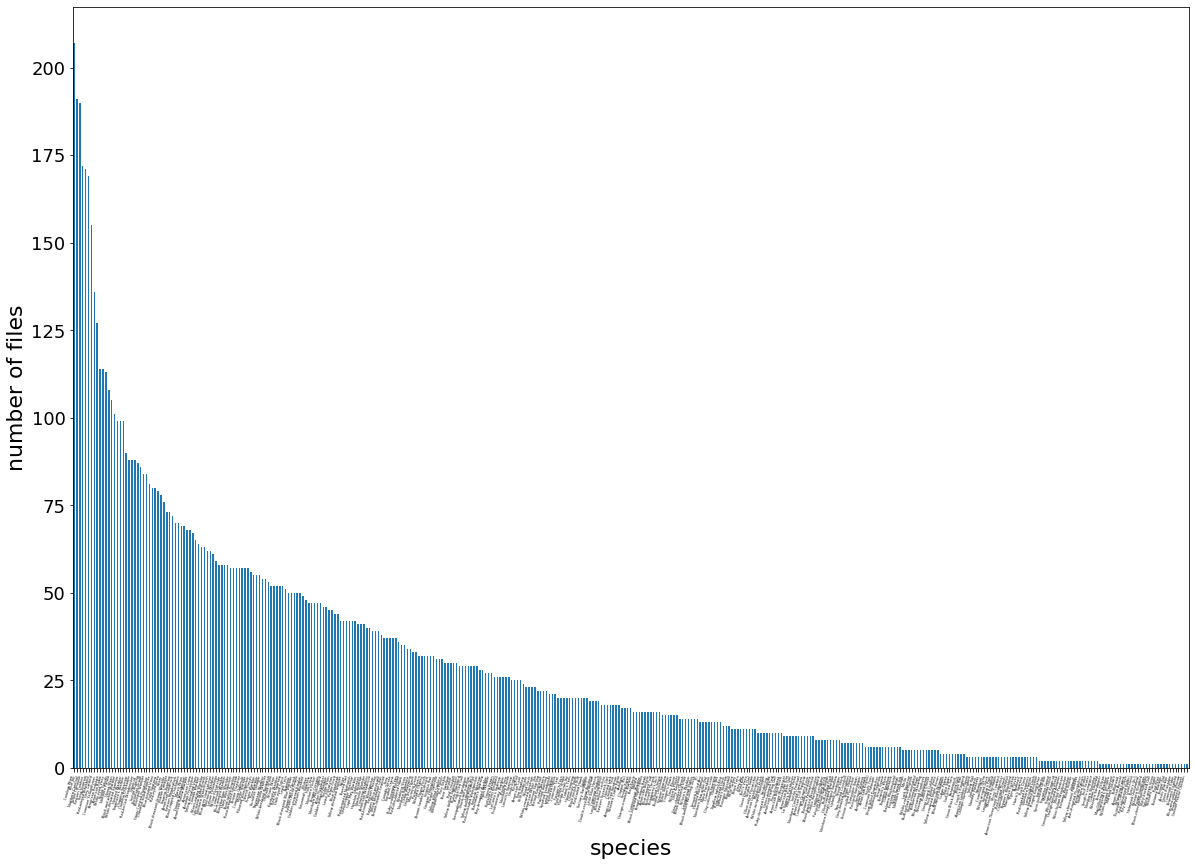

In [18]:
#create plots of the distributions

#f,ax = plt.subplots( figsize=(20,14) )
ax = df_c.plot.bar( figsize=(20,14) , fontsize=4, legend=False )
#ax.set_yscale('log')
#plt.legend( fontsize=20)
#ax.set_xticklabels( fontsize=4 )
ax.xaxis.set_ticklabels(ax.xaxis.get_ticklabels(), rotation=75, ha='right', fontsize=3.5)
ax.set_xlabel('species', fontsize=22)
ax.set_ylabel('number of files', fontsize=22 )
for tick in ax.get_yticklabels():
    tick.set_fontsize(18)
    
plt.savefig( 'species_bar.pdf',  encoding='pdf' );
'''
#f,ax = plt.subplots( figsize=(20,14) )
ax = df_s.plot.bar( figsize=(10,8) , fontsize=4 )
ax.set_yscale('log')
plt.savefig( 'sizes_bar.pdf',  encoding='pdf' )
#ax.set_xticklabels( fontsize=4 )
for tick in ax.get_yticklabels():
    tick.set_fontsize(10)
    
#use a hist for both  
ax = df_both.plot.bar(figsize=(20,14), fontsize=4, alpha=0.7)
ax.set_yscale('log')
for tick in ax.get_yticklabels():
    tick.set_fontsize(10)
'''

In [ ]:
d

In [ ]:
df_c.head(20)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def GetNumPerSpecies( topfolder='birdcalls/' ):
    filetype = 'mp3'
    folders = os.listdir(topfolder)
    d = {}
    sizes = {}
    for fold in folders:
        truepath = os.path.join( topfolder, fold )
        files = os.listdir( truepath )
        d[ fold ] = files
        size = 0
        for file in files:
            size += os.path.getsize( truepath )
            
        sizes[ fold ] = size
        print( fold, sizes[fold] )
    
    counts = {}
    
    for k,item in d.items():
        counts[k] = len( d[k] )
        
        #print(k, counts[k])
    return d, counts, sizes, both
        
d, counts, sizes = GetNumPerSpecies()
s_counts = list( sorted( counts.items() , key=lambda l: l[1] , reverse=True ) )
s_sizes = list( sorted( sizes.items() , key=lambda l: l[1] , reverse=True ) )
df = pd.DataFrame( s_counts )
#df.plot.hist( bins = 24, alpha=0.6 )
df.columns = 'species', 'counts'
df.set_index('species', drop=True, inplace=True)
#f,ax = plt.subplots( figsize=(20,14) )
ax = df.plot.bar( figsize=(20,14) , fontsize=4 )
plt.savefig( 'species_bar.pdf',  encoding='pdf', )
#ax.set_xticklabels( fontsize=4 )
for tick in ax.get_yticklabels():
    tick.set_fontsize(10)

summary of data cleaning
first limit region of recordings to the eastern US, Canada, and Mexico.  (from the midwest to the east coast)
this will limit the number of extraneous species included in the data set
from xeno-canto, only take recordings rated 'A' and 'B'
this should limit poor quality recordings included in the data set

use scipy peak finder, with a spacing of peaks equal/similar to the length after the peak that will be cut
this way, the calls will not be overlapping, or at least have very minimal overlap
some overlap is okay because ideally you will have the entire call 'pattern' inside the window being cut on

issues with this method of peak finding
- microphone pops, and recording noise from the recordist, can cause unwanted spikes in the data, which will falsely be identified as the peak of interest
- perhaps look by eye at the spectra, and eliminate these recordings by hand (there are not that many)
- the other option is to put the recording through a filter to do the peak finding (the original recording will still be what is clipped for the sub-clips) but the unwanted events that appear as peask will be filtered out
- sometimes on long recordings, these spikes might appear as an unwanted noise, but they are actually of interest
- get a way to find these outliers during exploratory analysis...


## things to check
- number of samples as a function of species
- decide threshold of number of samples to cut off results at
- scrape data from cornell to get higher quality clips
- only need name...so it may be worth it
- how to match up the different sample rate files to the same dimension fourier spectrograms

## possibly create
- dict with species name and files to remove, or filter...
- feature that looks at the fourier spectrum at the peak location (in sample space)


In [ ]:
def LoopThroughSpecies( species_list ):
    for name in species_list:
        print( name == folders[num], name, folders[num]  )
        folder = ''.join( (top_folder, folders[num]) )
        files = [ file for file in os.listdir(folder) if filetype in file ]
        print( f'{len(files)} files in the {folder} folder' )

In [ ]:
n=0
for spec_name in species_list:
    path, files = GetFilesForSpecies( spec_name=spec_name )
    n += len(files)
    
clipdir = 'cutclips/'
clip_files = os.listdir(clipdir)
'start', n, 'end', len(clip_files)